In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_targets_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 2116)
(4629816, 8)
validation
(621056, 2116)
(621056, 8)
test
(624904, 2116)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 2116)]            0         


 dense (Dense)               (None, 1024)              2167808   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 2857864 (10.90 MB)


Trainable params: 2857864 (10.90 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 14:46 - loss: 2.3657 - STD: 0.1035 - MAE: 0.2190

  3/463 [..............................] - ETA: 20s - loss: 2.2064 - STD: 0.0725 - MAE: 0.2172  

  5/463 [..............................] - ETA: 20s - loss: 2.1500 - STD: 0.0629 - MAE: 0.2166

  7/463 [..............................] - ETA: 20s - loss: 2.1278 - STD: 0.0557 - MAE: 0.2167

  9/463 [..............................] - ETA: 20s - loss: 2.1183 - STD: 0.0519 - MAE: 0.2168

 11/463 [..............................] - ETA: 20s - loss: 2.1104 - STD: 0.0495 - MAE: 0.2168

 12/463 [..............................] - ETA: 21s - loss: 2.1068 - STD: 0.0488 - MAE: 0.2168

 13/463 [..............................] - ETA: 21s - loss: 2.1031 - STD: 0.0482 - MAE: 0.2168

 14/463 [..............................] - ETA: 21s - loss: 2.1000 - STD: 0.0477 - MAE: 0.2167

 16/463 [>.............................] - ETA: 21s - loss: 2.0939 - STD: 0.0466 - MAE: 0.2167

 17/463 [>.............................] - ETA: 21s - loss: 2.0915 - STD: 0.0460 - MAE: 0.2166

 18/463 [>.............................] - ETA: 53s - loss: 2.0891 - STD: 0.0453 - MAE: 0.2166

 20/463 [>.............................] - ETA: 49s - loss: 2.0857 - STD: 0.0441 - MAE: 0.2166

 22/463 [>.............................] - ETA: 46s - loss: 2.0827 - STD: 0.0429 - MAE: 0.2167

 24/463 [>.............................] - ETA: 44s - loss: 2.0807 - STD: 0.0421 - MAE: 0.2167

 26/463 [>.............................] - ETA: 42s - loss: 2.0783 - STD: 0.0412 - MAE: 0.2167

 28/463 [>.............................] - ETA: 40s - loss: 2.0765 - STD: 0.0406 - MAE: 0.2167

 30/463 [>.............................] - ETA: 38s - loss: 2.0745 - STD: 0.0401 - MAE: 0.2167

 32/463 [=>............................] - ETA: 37s - loss: 2.0728 - STD: 0.0397 - MAE: 0.2167

 33/463 [=>............................] - ETA: 36s - loss: 2.0720 - STD: 0.0394 - MAE: 0.2167

 34/463 [=>............................] - ETA: 36s - loss: 2.0712 - STD: 0.0392 - MAE: 0.2166

 35/463 [=>............................] - ETA: 35s - loss: 2.0706 - STD: 0.0390 - MAE: 0.2166

 36/463 [=>............................] - ETA: 35s - loss: 2.0698 - STD: 0.0388 - MAE: 0.2166

 38/463 [=>............................] - ETA: 34s - loss: 2.0682 - STD: 0.0385 - MAE: 0.2166

 40/463 [=>............................] - ETA: 33s - loss: 2.0663 - STD: 0.0383 - MAE: 0.2166

 42/463 [=>............................] - ETA: 32s - loss: 2.0642 - STD: 0.0380 - MAE: 0.2165

 43/463 [=>............................] - ETA: 32s - loss: 2.0630 - STD: 0.0380 - MAE: 0.2165

 45/463 [=>............................] - ETA: 31s - loss: 2.0607 - STD: 0.0378 - MAE: 0.2164

 47/463 [==>...........................] - ETA: 31s - loss: 2.0579 - STD: 0.0377 - MAE: 0.2164

 48/463 [==>...........................] - ETA: 30s - loss: 2.0562 - STD: 0.0377 - MAE: 0.2163

 50/463 [==>...........................] - ETA: 30s - loss: 2.0522 - STD: 0.0378 - MAE: 0.2162

 52/463 [==>...........................] - ETA: 29s - loss: 2.0478 - STD: 0.0382 - MAE: 0.2160

 53/463 [==>...........................] - ETA: 29s - loss: 2.0454 - STD: 0.0385 - MAE: 0.2159

 55/463 [==>...........................] - ETA: 28s - loss: 2.0402 - STD: 0.0392 - MAE: 0.2157

 57/463 [==>...........................] - ETA: 28s - loss: 2.0348 - STD: 0.0401 - MAE: 0.2155

 58/463 [==>...........................] - ETA: 28s - loss: 2.0321 - STD: 0.0406 - MAE: 0.2153

 60/463 [==>...........................] - ETA: 27s - loss: 2.0268 - STD: 0.0416 - MAE: 0.2151

 62/463 [===>..........................] - ETA: 27s - loss: 2.0213 - STD: 0.0427 - MAE: 0.2148

 64/463 [===>..........................] - ETA: 26s - loss: 2.0157 - STD: 0.0438 - MAE: 0.2145

 65/463 [===>..........................] - ETA: 26s - loss: 2.0130 - STD: 0.0443 - MAE: 0.2144

 66/463 [===>..........................] - ETA: 26s - loss: 2.0101 - STD: 0.0449 - MAE: 0.2142

 68/463 [===>..........................] - ETA: 26s - loss: 2.0047 - STD: 0.0459 - MAE: 0.2140

 70/463 [===>..........................] - ETA: 25s - loss: 1.9993 - STD: 0.0469 - MAE: 0.2137

 72/463 [===>..........................] - ETA: 25s - loss: 1.9941 - STD: 0.0479 - MAE: 0.2134

 73/463 [===>..........................] - ETA: 25s - loss: 1.9915 - STD: 0.0483 - MAE: 0.2133

 75/463 [===>..........................] - ETA: 25s - loss: 1.9862 - STD: 0.0492 - MAE: 0.2131

 77/463 [===>..........................] - ETA: 24s - loss: 1.9809 - STD: 0.0501 - MAE: 0.2128

 79/463 [====>.........................] - ETA: 24s - loss: 1.9754 - STD: 0.0510 - MAE: 0.2125

 81/463 [====>.........................] - ETA: 24s - loss: 1.9701 - STD: 0.0520 - MAE: 0.2123

 83/463 [====>.........................] - ETA: 24s - loss: 1.9648 - STD: 0.0529 - MAE: 0.2120

 85/463 [====>.........................] - ETA: 23s - loss: 1.9592 - STD: 0.0537 - MAE: 0.2117

 87/463 [====>.........................] - ETA: 23s - loss: 1.9538 - STD: 0.0546 - MAE: 0.2115

 89/463 [====>.........................] - ETA: 23s - loss: 1.9482 - STD: 0.0554 - MAE: 0.2112

 91/463 [====>.........................] - ETA: 23s - loss: 1.9426 - STD: 0.0563 - MAE: 0.2109

 92/463 [====>.........................] - ETA: 22s - loss: 1.9399 - STD: 0.0567 - MAE: 0.2108

 94/463 [=====>........................] - ETA: 22s - loss: 1.9341 - STD: 0.0575 - MAE: 0.2105

 96/463 [=====>........................] - ETA: 22s - loss: 1.9282 - STD: 0.0583 - MAE: 0.2102

 98/463 [=====>........................] - ETA: 22s - loss: 1.9223 - STD: 0.0591 - MAE: 0.2100

 99/463 [=====>........................] - ETA: 22s - loss: 1.9195 - STD: 0.0595 - MAE: 0.2098

100/463 [=====>........................] - ETA: 22s - loss: 1.9168 - STD: 0.0600 - MAE: 0.2097

102/463 [=====>........................] - ETA: 21s - loss: 1.9114 - STD: 0.0608 - MAE: 0.2094

104/463 [=====>........................] - ETA: 21s - loss: 1.9060 - STD: 0.0616 - MAE: 0.2091

106/463 [=====>........................] - ETA: 21s - loss: 1.9003 - STD: 0.0625 - MAE: 0.2088

108/463 [=====>........................] - ETA: 21s - loss: 1.8948 - STD: 0.0633 - MAE: 0.2085

110/463 [======>.......................] - ETA: 21s - loss: 1.8893 - STD: 0.0641 - MAE: 0.2082

112/463 [======>.......................] - ETA: 20s - loss: 1.8839 - STD: 0.0649 - MAE: 0.2080

114/463 [======>.......................] - ETA: 20s - loss: 1.8786 - STD: 0.0658 - MAE: 0.2077

115/463 [======>.......................] - ETA: 20s - loss: 1.8759 - STD: 0.0662 - MAE: 0.2075

117/463 [======>.......................] - ETA: 20s - loss: 1.8706 - STD: 0.0670 - MAE: 0.2072

119/463 [======>.......................] - ETA: 20s - loss: 1.8654 - STD: 0.0678 - MAE: 0.2069

121/463 [======>.......................] - ETA: 20s - loss: 1.8601 - STD: 0.0686 - MAE: 0.2066

123/463 [======>.......................] - ETA: 19s - loss: 1.8548 - STD: 0.0693 - MAE: 0.2063

125/463 [=======>......................] - ETA: 19s - loss: 1.8496 - STD: 0.0701 - MAE: 0.2060

127/463 [=======>......................] - ETA: 19s - loss: 1.8446 - STD: 0.0709 - MAE: 0.2057

129/463 [=======>......................] - ETA: 19s - loss: 1.8396 - STD: 0.0717 - MAE: 0.2054

130/463 [=======>......................] - ETA: 19s - loss: 1.8371 - STD: 0.0721 - MAE: 0.2053

132/463 [=======>......................] - ETA: 19s - loss: 1.8323 - STD: 0.0730 - MAE: 0.2050

134/463 [=======>......................] - ETA: 18s - loss: 1.8274 - STD: 0.0738 - MAE: 0.2047

136/463 [=======>......................] - ETA: 18s - loss: 1.8225 - STD: 0.0745 - MAE: 0.2044

138/463 [=======>......................] - ETA: 18s - loss: 1.8177 - STD: 0.0753 - MAE: 0.2041

140/463 [========>.....................] - ETA: 18s - loss: 1.8131 - STD: 0.0761 - MAE: 0.2038

142/463 [========>.....................] - ETA: 18s - loss: 1.8084 - STD: 0.0768 - MAE: 0.2035

144/463 [========>.....................] - ETA: 18s - loss: 1.8039 - STD: 0.0776 - MAE: 0.2032

145/463 [========>.....................] - ETA: 18s - loss: 1.8015 - STD: 0.0779 - MAE: 0.2030

147/463 [========>.....................] - ETA: 17s - loss: 1.7969 - STD: 0.0786 - MAE: 0.2027

149/463 [========>.....................] - ETA: 17s - loss: 1.7923 - STD: 0.0794 - MAE: 0.2024

151/463 [========>.....................] - ETA: 17s - loss: 1.7877 - STD: 0.0801 - MAE: 0.2021

153/463 [========>.....................] - ETA: 17s - loss: 1.7829 - STD: 0.0808 - MAE: 0.2018

154/463 [========>.....................] - ETA: 17s - loss: 1.7806 - STD: 0.0812 - MAE: 0.2016

156/463 [=========>....................] - ETA: 17s - loss: 1.7757 - STD: 0.0819 - MAE: 0.2013

158/463 [=========>....................] - ETA: 17s - loss: 1.7708 - STD: 0.0826 - MAE: 0.2010

160/463 [=========>....................] - ETA: 16s - loss: 1.7662 - STD: 0.0833 - MAE: 0.2007

162/463 [=========>....................] - ETA: 16s - loss: 1.7614 - STD: 0.0840 - MAE: 0.2004

164/463 [=========>....................] - ETA: 16s - loss: 1.7567 - STD: 0.0848 - MAE: 0.2000

166/463 [=========>....................] - ETA: 16s - loss: 1.7520 - STD: 0.0855 - MAE: 0.1997

168/463 [=========>....................] - ETA: 16s - loss: 1.7472 - STD: 0.0862 - MAE: 0.1994

170/463 [==========>...................] - ETA: 16s - loss: 1.7424 - STD: 0.0870 - MAE: 0.1990

172/463 [==========>...................] - ETA: 16s - loss: 1.7378 - STD: 0.0877 - MAE: 0.1987

173/463 [==========>...................] - ETA: 16s - loss: 1.7354 - STD: 0.0881 - MAE: 0.1985

175/463 [==========>...................] - ETA: 15s - loss: 1.7307 - STD: 0.0888 - MAE: 0.1982

177/463 [==========>...................] - ETA: 15s - loss: 1.7259 - STD: 0.0895 - MAE: 0.1978

178/463 [==========>...................] - ETA: 15s - loss: 1.7237 - STD: 0.0898 - MAE: 0.1977

180/463 [==========>...................] - ETA: 15s - loss: 1.7191 - STD: 0.0906 - MAE: 0.1973

181/463 [==========>...................] - ETA: 15s - loss: 1.7168 - STD: 0.0909 - MAE: 0.1972

183/463 [==========>...................] - ETA: 15s - loss: 1.7122 - STD: 0.0916 - MAE: 0.1968

185/463 [==========>...................] - ETA: 15s - loss: 1.7077 - STD: 0.0923 - MAE: 0.1965

187/463 [===========>..................] - ETA: 15s - loss: 1.7032 - STD: 0.0930 - MAE: 0.1962

189/463 [===========>..................] - ETA: 15s - loss: 1.6987 - STD: 0.0937 - MAE: 0.1958

191/463 [===========>..................] - ETA: 14s - loss: 1.6943 - STD: 0.0944 - MAE: 0.1955

193/463 [===========>..................] - ETA: 14s - loss: 1.6898 - STD: 0.0951 - MAE: 0.1951

195/463 [===========>..................] - ETA: 14s - loss: 1.6855 - STD: 0.0958 - MAE: 0.1948

196/463 [===========>..................] - ETA: 14s - loss: 1.6834 - STD: 0.0962 - MAE: 0.1947

198/463 [===========>..................] - ETA: 14s - loss: 1.6791 - STD: 0.0969 - MAE: 0.1943

200/463 [===========>..................] - ETA: 14s - loss: 1.6748 - STD: 0.0975 - MAE: 0.1940

202/463 [============>.................] - ETA: 14s - loss: 1.6705 - STD: 0.0982 - MAE: 0.1937

204/463 [============>.................] - ETA: 14s - loss: 1.6664 - STD: 0.0989 - MAE: 0.1933

206/463 [============>.................] - ETA: 14s - loss: 1.6623 - STD: 0.0995 - MAE: 0.1930

208/463 [============>.................] - ETA: 13s - loss: 1.6585 - STD: 0.1002 - MAE: 0.1927

210/463 [============>.................] - ETA: 13s - loss: 1.6546 - STD: 0.1008 - MAE: 0.1924

212/463 [============>.................] - ETA: 13s - loss: 1.6507 - STD: 0.1015 - MAE: 0.1921

214/463 [============>.................] - ETA: 13s - loss: 1.6470 - STD: 0.1021 - MAE: 0.1918

216/463 [============>.................] - ETA: 13s - loss: 1.6432 - STD: 0.1027 - MAE: 0.1915

218/463 [=============>................] - ETA: 13s - loss: 1.6394 - STD: 0.1033 - MAE: 0.1912

219/463 [=============>................] - ETA: 13s - loss: 1.6376 - STD: 0.1036 - MAE: 0.1910

221/463 [=============>................] - ETA: 13s - loss: 1.6339 - STD: 0.1042 - MAE: 0.1907

223/463 [=============>................] - ETA: 12s - loss: 1.6302 - STD: 0.1048 - MAE: 0.1904

225/463 [=============>................] - ETA: 12s - loss: 1.6265 - STD: 0.1054 - MAE: 0.1901

226/463 [=============>................] - ETA: 12s - loss: 1.6248 - STD: 0.1057 - MAE: 0.1900

228/463 [=============>................] - ETA: 12s - loss: 1.6216 - STD: 0.1063 - MAE: 0.1897

230/463 [=============>................] - ETA: 12s - loss: 1.6181 - STD: 0.1069 - MAE: 0.1894

232/463 [==============>...............] - ETA: 12s - loss: 1.6150 - STD: 0.1074 - MAE: 0.1891

234/463 [==============>...............] - ETA: 12s - loss: 1.6116 - STD: 0.1080 - MAE: 0.1889

235/463 [==============>...............] - ETA: 12s - loss: 1.6100 - STD: 0.1083 - MAE: 0.1887

237/463 [==============>...............] - ETA: 12s - loss: 1.6067 - STD: 0.1088 - MAE: 0.1884

239/463 [==============>...............] - ETA: 12s - loss: 1.6036 - STD: 0.1094 - MAE: 0.1882

241/463 [==============>...............] - ETA: 11s - loss: 1.6005 - STD: 0.1099 - MAE: 0.1879

243/463 [==============>...............] - ETA: 11s - loss: 1.5973 - STD: 0.1104 - MAE: 0.1877

245/463 [==============>...............] - ETA: 11s - loss: 1.5940 - STD: 0.1109 - MAE: 0.1874

246/463 [==============>...............] - ETA: 11s - loss: 1.5925 - STD: 0.1112 - MAE: 0.1873

248/463 [===============>..............] - ETA: 11s - loss: 1.5894 - STD: 0.1117 - MAE: 0.1870

250/463 [===============>..............] - ETA: 11s - loss: 1.5862 - STD: 0.1122 - MAE: 0.1867

251/463 [===============>..............] - ETA: 11s - loss: 1.5847 - STD: 0.1125 - MAE: 0.1866

253/463 [===============>..............] - ETA: 11s - loss: 1.5817 - STD: 0.1130 - MAE: 0.1864

255/463 [===============>..............] - ETA: 11s - loss: 1.5786 - STD: 0.1134 - MAE: 0.1861

257/463 [===============>..............] - ETA: 10s - loss: 1.5757 - STD: 0.1139 - MAE: 0.1859

258/463 [===============>..............] - ETA: 10s - loss: 1.5742 - STD: 0.1142 - MAE: 0.1857

260/463 [===============>..............] - ETA: 10s - loss: 1.5713 - STD: 0.1146 - MAE: 0.1855

262/463 [===============>..............] - ETA: 10s - loss: 1.5683 - STD: 0.1151 - MAE: 0.1853

264/463 [================>.............] - ETA: 10s - loss: 1.5654 - STD: 0.1156 - MAE: 0.1850

266/463 [================>.............] - ETA: 10s - loss: 1.5625 - STD: 0.1160 - MAE: 0.1848

268/463 [================>.............] - ETA: 10s - loss: 1.5596 - STD: 0.1165 - MAE: 0.1845

270/463 [================>.............] - ETA: 10s - loss: 1.5568 - STD: 0.1169 - MAE: 0.1843

272/463 [================>.............] - ETA: 10s - loss: 1.5540 - STD: 0.1174 - MAE: 0.1841

274/463 [================>.............] - ETA: 10s - loss: 1.5512 - STD: 0.1178 - MAE: 0.1838

276/463 [================>.............] - ETA: 9s - loss: 1.5484 - STD: 0.1183 - MAE: 0.1836 

278/463 [=================>............] - ETA: 9s - loss: 1.5457 - STD: 0.1187 - MAE: 0.1833

280/463 [=================>............] - ETA: 9s - loss: 1.5430 - STD: 0.1192 - MAE: 0.1831

282/463 [=================>............] - ETA: 9s - loss: 1.5402 - STD: 0.1196 - MAE: 0.1829

284/463 [=================>............] - ETA: 9s - loss: 1.5375 - STD: 0.1200 - MAE: 0.1827

286/463 [=================>............] - ETA: 9s - loss: 1.5349 - STD: 0.1204 - MAE: 0.1824

288/463 [=================>............] - ETA: 9s - loss: 1.5323 - STD: 0.1208 - MAE: 0.1822

290/463 [=================>............] - ETA: 9s - loss: 1.5297 - STD: 0.1213 - MAE: 0.1820

291/463 [=================>............] - ETA: 9s - loss: 1.5284 - STD: 0.1215 - MAE: 0.1819

293/463 [=================>............] - ETA: 8s - loss: 1.5258 - STD: 0.1219 - MAE: 0.1817

294/463 [==================>...........] - ETA: 8s - loss: 1.5246 - STD: 0.1221 - MAE: 0.1816

296/463 [==================>...........] - ETA: 8s - loss: 1.5222 - STD: 0.1225 - MAE: 0.1813

298/463 [==================>...........] - ETA: 8s - loss: 1.5197 - STD: 0.1229 - MAE: 0.1811

300/463 [==================>...........] - ETA: 8s - loss: 1.5171 - STD: 0.1233 - MAE: 0.1809

302/463 [==================>...........] - ETA: 8s - loss: 1.5147 - STD: 0.1237 - MAE: 0.1807

304/463 [==================>...........] - ETA: 8s - loss: 1.5124 - STD: 0.1241 - MAE: 0.1805

305/463 [==================>...........] - ETA: 8s - loss: 1.5112 - STD: 0.1242 - MAE: 0.1804

306/463 [==================>...........] - ETA: 8s - loss: 1.5100 - STD: 0.1244 - MAE: 0.1803

308/463 [==================>...........] - ETA: 8s - loss: 1.5077 - STD: 0.1248 - MAE: 0.1801

310/463 [===================>..........] - ETA: 8s - loss: 1.5054 - STD: 0.1252 - MAE: 0.1799

312/463 [===================>..........] - ETA: 7s - loss: 1.5031 - STD: 0.1256 - MAE: 0.1797

314/463 [===================>..........] - ETA: 7s - loss: 1.5008 - STD: 0.1259 - MAE: 0.1795

315/463 [===================>..........] - ETA: 7s - loss: 1.4997 - STD: 0.1261 - MAE: 0.1794

317/463 [===================>..........] - ETA: 7s - loss: 1.4975 - STD: 0.1265 - MAE: 0.1792

319/463 [===================>..........] - ETA: 7s - loss: 1.4952 - STD: 0.1268 - MAE: 0.1790

321/463 [===================>..........] - ETA: 7s - loss: 1.4931 - STD: 0.1272 - MAE: 0.1788

323/463 [===================>..........] - ETA: 7s - loss: 1.4911 - STD: 0.1276 - MAE: 0.1786

325/463 [====================>.........] - ETA: 7s - loss: 1.4889 - STD: 0.1279 - MAE: 0.1784

327/463 [====================>.........] - ETA: 7s - loss: 1.4868 - STD: 0.1283 - MAE: 0.1783

328/463 [====================>.........] - ETA: 7s - loss: 1.4857 - STD: 0.1284 - MAE: 0.1782

330/463 [====================>.........] - ETA: 6s - loss: 1.4836 - STD: 0.1288 - MAE: 0.1780

332/463 [====================>.........] - ETA: 6s - loss: 1.4815 - STD: 0.1291 - MAE: 0.1778

334/463 [====================>.........] - ETA: 6s - loss: 1.4794 - STD: 0.1294 - MAE: 0.1776

336/463 [====================>.........] - ETA: 6s - loss: 1.4772 - STD: 0.1298 - MAE: 0.1774

338/463 [====================>.........] - ETA: 6s - loss: 1.4752 - STD: 0.1301 - MAE: 0.1772

340/463 [=====================>........] - ETA: 6s - loss: 1.4732 - STD: 0.1304 - MAE: 0.1771

342/463 [=====================>........] - ETA: 6s - loss: 1.4712 - STD: 0.1308 - MAE: 0.1769

344/463 [=====================>........] - ETA: 6s - loss: 1.4692 - STD: 0.1311 - MAE: 0.1767

346/463 [=====================>........] - ETA: 6s - loss: 1.4672 - STD: 0.1314 - MAE: 0.1765

347/463 [=====================>........] - ETA: 6s - loss: 1.4662 - STD: 0.1316 - MAE: 0.1764

349/463 [=====================>........] - ETA: 5s - loss: 1.4642 - STD: 0.1319 - MAE: 0.1763

351/463 [=====================>........] - ETA: 5s - loss: 1.4622 - STD: 0.1322 - MAE: 0.1761

353/463 [=====================>........] - ETA: 5s - loss: 1.4602 - STD: 0.1325 - MAE: 0.1759

355/463 [======================>.......] - ETA: 5s - loss: 1.4584 - STD: 0.1328 - MAE: 0.1757

356/463 [======================>.......] - ETA: 5s - loss: 1.4574 - STD: 0.1330 - MAE: 0.1757

357/463 [======================>.......] - ETA: 5s - loss: 1.4564 - STD: 0.1331 - MAE: 0.1756

359/463 [======================>.......] - ETA: 5s - loss: 1.4545 - STD: 0.1334 - MAE: 0.1754

361/463 [======================>.......] - ETA: 5s - loss: 1.4526 - STD: 0.1337 - MAE: 0.1752

363/463 [======================>.......] - ETA: 5s - loss: 1.4507 - STD: 0.1340 - MAE: 0.1751

364/463 [======================>.......] - ETA: 5s - loss: 1.4498 - STD: 0.1342 - MAE: 0.1750

366/463 [======================>.......] - ETA: 5s - loss: 1.4480 - STD: 0.1345 - MAE: 0.1748

368/463 [======================>.......] - ETA: 4s - loss: 1.4462 - STD: 0.1348 - MAE: 0.1746

370/463 [======================>.......] - ETA: 4s - loss: 1.4447 - STD: 0.1351 - MAE: 0.1745

372/463 [=======================>......] - ETA: 4s - loss: 1.4429 - STD: 0.1354 - MAE: 0.1743

374/463 [=======================>......] - ETA: 4s - loss: 1.4413 - STD: 0.1357 - MAE: 0.1742

376/463 [=======================>......] - ETA: 4s - loss: 1.4396 - STD: 0.1360 - MAE: 0.1740

378/463 [=======================>......] - ETA: 4s - loss: 1.4380 - STD: 0.1362 - MAE: 0.1739

380/463 [=======================>......] - ETA: 4s - loss: 1.4363 - STD: 0.1365 - MAE: 0.1737

382/463 [=======================>......] - ETA: 4s - loss: 1.4346 - STD: 0.1368 - MAE: 0.1736

384/463 [=======================>......] - ETA: 4s - loss: 1.4330 - STD: 0.1371 - MAE: 0.1734

386/463 [========================>.....] - ETA: 3s - loss: 1.4315 - STD: 0.1373 - MAE: 0.1733

388/463 [========================>.....] - ETA: 3s - loss: 1.4299 - STD: 0.1376 - MAE: 0.1731

390/463 [========================>.....] - ETA: 3s - loss: 1.4285 - STD: 0.1379 - MAE: 0.1730

392/463 [========================>.....] - ETA: 3s - loss: 1.4269 - STD: 0.1382 - MAE: 0.1729

394/463 [========================>.....] - ETA: 3s - loss: 1.4255 - STD: 0.1384 - MAE: 0.1727

396/463 [========================>.....] - ETA: 3s - loss: 1.4240 - STD: 0.1387 - MAE: 0.1726

398/463 [========================>.....] - ETA: 3s - loss: 1.4225 - STD: 0.1389 - MAE: 0.1724

400/463 [========================>.....] - ETA: 3s - loss: 1.4210 - STD: 0.1392 - MAE: 0.1723

402/463 [=========================>....] - ETA: 3s - loss: 1.4194 - STD: 0.1394 - MAE: 0.1722

403/463 [=========================>....] - ETA: 3s - loss: 1.4187 - STD: 0.1396 - MAE: 0.1721

405/463 [=========================>....] - ETA: 2s - loss: 1.4171 - STD: 0.1398 - MAE: 0.1720

406/463 [=========================>....] - ETA: 2s - loss: 1.4164 - STD: 0.1399 - MAE: 0.1719

408/463 [=========================>....] - ETA: 2s - loss: 1.4149 - STD: 0.1402 - MAE: 0.1718

410/463 [=========================>....] - ETA: 2s - loss: 1.4133 - STD: 0.1404 - MAE: 0.1716

412/463 [=========================>....] - ETA: 2s - loss: 1.4118 - STD: 0.1407 - MAE: 0.1715

414/463 [=========================>....] - ETA: 2s - loss: 1.4103 - STD: 0.1409 - MAE: 0.1713

416/463 [=========================>....] - ETA: 2s - loss: 1.4088 - STD: 0.1412 - MAE: 0.1712

418/463 [==========================>...] - ETA: 2s - loss: 1.4074 - STD: 0.1414 - MAE: 0.1711

420/463 [==========================>...] - ETA: 2s - loss: 1.4058 - STD: 0.1416 - MAE: 0.1709

422/463 [==========================>...] - ETA: 2s - loss: 1.4043 - STD: 0.1419 - MAE: 0.1708

424/463 [==========================>...] - ETA: 2s - loss: 1.4029 - STD: 0.1421 - MAE: 0.1707

426/463 [==========================>...] - ETA: 1s - loss: 1.4015 - STD: 0.1423 - MAE: 0.1705

428/463 [==========================>...] - ETA: 1s - loss: 1.4001 - STD: 0.1426 - MAE: 0.1704

429/463 [==========================>...] - ETA: 1s - loss: 1.3994 - STD: 0.1427 - MAE: 0.1703

430/463 [==========================>...] - ETA: 1s - loss: 1.3987 - STD: 0.1428 - MAE: 0.1703

432/463 [==========================>...] - ETA: 1s - loss: 1.3973 - STD: 0.1430 - MAE: 0.1702

434/463 [===========================>..] - ETA: 1s - loss: 1.3960 - STD: 0.1433 - MAE: 0.1700

436/463 [===========================>..] - ETA: 1s - loss: 1.3946 - STD: 0.1435 - MAE: 0.1699

438/463 [===========================>..] - ETA: 1s - loss: 1.3933 - STD: 0.1437 - MAE: 0.1698

439/463 [===========================>..] - ETA: 1s - loss: 1.3926 - STD: 0.1438 - MAE: 0.1697

441/463 [===========================>..] - ETA: 1s - loss: 1.3913 - STD: 0.1440 - MAE: 0.1696

443/463 [===========================>..] - ETA: 1s - loss: 1.3899 - STD: 0.1442 - MAE: 0.1695

445/463 [===========================>..] - ETA: 0s - loss: 1.3885 - STD: 0.1445 - MAE: 0.1693

447/463 [===========================>..] - ETA: 0s - loss: 1.3872 - STD: 0.1447 - MAE: 0.1692

449/463 [============================>.] - ETA: 0s - loss: 1.3859 - STD: 0.1449 - MAE: 0.1691

451/463 [============================>.] - ETA: 0s - loss: 1.3845 - STD: 0.1451 - MAE: 0.1690

453/463 [============================>.] - ETA: 0s - loss: 1.3831 - STD: 0.1454 - MAE: 0.1688

455/463 [============================>.] - ETA: 0s - loss: 1.3817 - STD: 0.1456 - MAE: 0.1687

456/463 [============================>.] - ETA: 0s - loss: 1.3811 - STD: 0.1457 - MAE: 0.1687

458/463 [============================>.] - ETA: 0s - loss: 1.3798 - STD: 0.1459 - MAE: 0.1685

460/463 [============================>.] - ETA: 0s - loss: 1.3784 - STD: 0.1461 - MAE: 0.1684

462/463 [============================>.] - ETA: 0s - loss: 1.3770 - STD: 0.1463 - MAE: 0.1683

463/463 [==============================] - ETA: 0s - loss: 1.3763 - STD: 0.1464 - MAE: 0.1682

463/463 [==============================] - 29s 59ms/step - loss: 1.3763 - STD: 0.1464 - MAE: 0.1682 - val_loss: 1.2896 - val_STD: 0.1959 - val_MAE: 0.1523


Epoch 2/10000


  1/463 [..............................] - ETA: 45s - loss: 1.0719 - STD: 0.1951 - MAE: 0.1402

  2/463 [..............................] - ETA: 24s - loss: 1.0773 - STD: 0.1952 - MAE: 0.1402

  4/463 [..............................] - ETA: 22s - loss: 1.0761 - STD: 0.1953 - MAE: 0.1400

  6/463 [..............................] - ETA: 21s - loss: 1.0741 - STD: 0.1956 - MAE: 0.1399

  7/463 [..............................] - ETA: 22s - loss: 1.0751 - STD: 0.1958 - MAE: 0.1399

  9/463 [..............................] - ETA: 22s - loss: 1.0759 - STD: 0.1958 - MAE: 0.1399

 11/463 [..............................] - ETA: 21s - loss: 1.0754 - STD: 0.1957 - MAE: 0.1399

 13/463 [..............................] - ETA: 21s - loss: 1.0749 - STD: 0.1955 - MAE: 0.1400

 15/463 [..............................] - ETA: 21s - loss: 1.0739 - STD: 0.1956 - MAE: 0.1399

 17/463 [>.............................] - ETA: 21s - loss: 1.0732 - STD: 0.1958 - MAE: 0.1397

 19/463 [>.............................] - ETA: 21s - loss: 1.0721 - STD: 0.1958 - MAE: 0.1397

 21/463 [>.............................] - ETA: 21s - loss: 1.0705 - STD: 0.1958 - MAE: 0.1396

 23/463 [>.............................] - ETA: 21s - loss: 1.0693 - STD: 0.1957 - MAE: 0.1395

 24/463 [>.............................] - ETA: 21s - loss: 1.0690 - STD: 0.1958 - MAE: 0.1395

 26/463 [>.............................] - ETA: 21s - loss: 1.0678 - STD: 0.1959 - MAE: 0.1394

 28/463 [>.............................] - ETA: 20s - loss: 1.0671 - STD: 0.1960 - MAE: 0.1393

 30/463 [>.............................] - ETA: 20s - loss: 1.0676 - STD: 0.1960 - MAE: 0.1393

 31/463 [=>............................] - ETA: 20s - loss: 1.0674 - STD: 0.1960 - MAE: 0.1393

 32/463 [=>............................] - ETA: 20s - loss: 1.0670 - STD: 0.1960 - MAE: 0.1393

 34/463 [=>............................] - ETA: 20s - loss: 1.0670 - STD: 0.1960 - MAE: 0.1393

 36/463 [=>............................] - ETA: 20s - loss: 1.0665 - STD: 0.1962 - MAE: 0.1392

 38/463 [=>............................] - ETA: 20s - loss: 1.0657 - STD: 0.1962 - MAE: 0.1391

 39/463 [=>............................] - ETA: 20s - loss: 1.0653 - STD: 0.1963 - MAE: 0.1391

 40/463 [=>............................] - ETA: 20s - loss: 1.0652 - STD: 0.1964 - MAE: 0.1390

 42/463 [=>............................] - ETA: 20s - loss: 1.0646 - STD: 0.1965 - MAE: 0.1390

 44/463 [=>............................] - ETA: 20s - loss: 1.0647 - STD: 0.1965 - MAE: 0.1390

 46/463 [=>............................] - ETA: 20s - loss: 1.0645 - STD: 0.1966 - MAE: 0.1389

 47/463 [==>...........................] - ETA: 20s - loss: 1.0645 - STD: 0.1966 - MAE: 0.1389

 49/463 [==>...........................] - ETA: 20s - loss: 1.0639 - STD: 0.1966 - MAE: 0.1389

 51/463 [==>...........................] - ETA: 19s - loss: 1.0631 - STD: 0.1967 - MAE: 0.1388

 53/463 [==>...........................] - ETA: 19s - loss: 1.0621 - STD: 0.1968 - MAE: 0.1387

 55/463 [==>...........................] - ETA: 19s - loss: 1.0621 - STD: 0.1968 - MAE: 0.1387

 56/463 [==>...........................] - ETA: 19s - loss: 1.0620 - STD: 0.1969 - MAE: 0.1386

 58/463 [==>...........................] - ETA: 19s - loss: 1.0613 - STD: 0.1970 - MAE: 0.1386

 60/463 [==>...........................] - ETA: 19s - loss: 1.0605 - STD: 0.1970 - MAE: 0.1385

 62/463 [===>..........................] - ETA: 19s - loss: 1.0605 - STD: 0.1971 - MAE: 0.1385

 64/463 [===>..........................] - ETA: 19s - loss: 1.0608 - STD: 0.1972 - MAE: 0.1385

 66/463 [===>..........................] - ETA: 19s - loss: 1.0605 - STD: 0.1973 - MAE: 0.1384

 68/463 [===>..........................] - ETA: 19s - loss: 1.0610 - STD: 0.1973 - MAE: 0.1384

 70/463 [===>..........................] - ETA: 19s - loss: 1.0613 - STD: 0.1974 - MAE: 0.1384

 72/463 [===>..........................] - ETA: 18s - loss: 1.0617 - STD: 0.1974 - MAE: 0.1384

 73/463 [===>..........................] - ETA: 18s - loss: 1.0620 - STD: 0.1975 - MAE: 0.1385

 75/463 [===>..........................] - ETA: 18s - loss: 1.0621 - STD: 0.1975 - MAE: 0.1385

 77/463 [===>..........................] - ETA: 18s - loss: 1.0622 - STD: 0.1975 - MAE: 0.1385

 79/463 [====>.........................] - ETA: 18s - loss: 1.0622 - STD: 0.1975 - MAE: 0.1385

 81/463 [====>.........................] - ETA: 18s - loss: 1.0624 - STD: 0.1976 - MAE: 0.1384

 83/463 [====>.........................] - ETA: 18s - loss: 1.0621 - STD: 0.1976 - MAE: 0.1384

 85/463 [====>.........................] - ETA: 18s - loss: 1.0622 - STD: 0.1976 - MAE: 0.1384

 87/463 [====>.........................] - ETA: 18s - loss: 1.0624 - STD: 0.1977 - MAE: 0.1384

 89/463 [====>.........................] - ETA: 18s - loss: 1.0624 - STD: 0.1977 - MAE: 0.1384

 91/463 [====>.........................] - ETA: 17s - loss: 1.0620 - STD: 0.1977 - MAE: 0.1384

 92/463 [====>.........................] - ETA: 17s - loss: 1.0618 - STD: 0.1977 - MAE: 0.1383

 94/463 [=====>........................] - ETA: 17s - loss: 1.0613 - STD: 0.1978 - MAE: 0.1383

 95/463 [=====>........................] - ETA: 17s - loss: 1.0612 - STD: 0.1978 - MAE: 0.1383

 97/463 [=====>........................] - ETA: 17s - loss: 1.0606 - STD: 0.1978 - MAE: 0.1382

 99/463 [=====>........................] - ETA: 17s - loss: 1.0599 - STD: 0.1978 - MAE: 0.1382

101/463 [=====>........................] - ETA: 17s - loss: 1.0595 - STD: 0.1979 - MAE: 0.1381

103/463 [=====>........................] - ETA: 17s - loss: 1.0592 - STD: 0.1979 - MAE: 0.1381

105/463 [=====>........................] - ETA: 17s - loss: 1.0591 - STD: 0.1980 - MAE: 0.1381

107/463 [=====>........................] - ETA: 17s - loss: 1.0586 - STD: 0.1981 - MAE: 0.1380

108/463 [=====>........................] - ETA: 17s - loss: 1.0585 - STD: 0.1981 - MAE: 0.1380

110/463 [======>.......................] - ETA: 17s - loss: 1.0582 - STD: 0.1982 - MAE: 0.1380

112/463 [======>.......................] - ETA: 17s - loss: 1.0578 - STD: 0.1982 - MAE: 0.1379

114/463 [======>.......................] - ETA: 16s - loss: 1.0576 - STD: 0.1982 - MAE: 0.1379

116/463 [======>.......................] - ETA: 16s - loss: 1.0573 - STD: 0.1983 - MAE: 0.1379

118/463 [======>.......................] - ETA: 16s - loss: 1.0570 - STD: 0.1983 - MAE: 0.1378

120/463 [======>.......................] - ETA: 16s - loss: 1.0565 - STD: 0.1984 - MAE: 0.1378

122/463 [======>.......................] - ETA: 16s - loss: 1.0563 - STD: 0.1984 - MAE: 0.1378

124/463 [=======>......................] - ETA: 16s - loss: 1.0557 - STD: 0.1985 - MAE: 0.1377

126/463 [=======>......................] - ETA: 16s - loss: 1.0560 - STD: 0.1985 - MAE: 0.1377

128/463 [=======>......................] - ETA: 16s - loss: 1.0557 - STD: 0.1986 - MAE: 0.1377

129/463 [=======>......................] - ETA: 16s - loss: 1.0561 - STD: 0.1986 - MAE: 0.1377

131/463 [=======>......................] - ETA: 16s - loss: 1.0557 - STD: 0.1986 - MAE: 0.1377

132/463 [=======>......................] - ETA: 16s - loss: 1.0556 - STD: 0.1986 - MAE: 0.1376

134/463 [=======>......................] - ETA: 15s - loss: 1.0553 - STD: 0.1987 - MAE: 0.1376

136/463 [=======>......................] - ETA: 15s - loss: 1.0549 - STD: 0.1987 - MAE: 0.1376

138/463 [=======>......................] - ETA: 15s - loss: 1.0543 - STD: 0.1987 - MAE: 0.1375

140/463 [========>.....................] - ETA: 15s - loss: 1.0537 - STD: 0.1988 - MAE: 0.1375

142/463 [========>.....................] - ETA: 15s - loss: 1.0532 - STD: 0.1988 - MAE: 0.1374

144/463 [========>.....................] - ETA: 15s - loss: 1.0527 - STD: 0.1989 - MAE: 0.1374

146/463 [========>.....................] - ETA: 15s - loss: 1.0521 - STD: 0.1990 - MAE: 0.1373

148/463 [========>.....................] - ETA: 15s - loss: 1.0516 - STD: 0.1990 - MAE: 0.1373

150/463 [========>.....................] - ETA: 15s - loss: 1.0512 - STD: 0.1991 - MAE: 0.1372

152/463 [========>.....................] - ETA: 15s - loss: 1.0507 - STD: 0.1992 - MAE: 0.1372

154/463 [========>.....................] - ETA: 14s - loss: 1.0501 - STD: 0.1992 - MAE: 0.1371

156/463 [=========>....................] - ETA: 14s - loss: 1.0496 - STD: 0.1993 - MAE: 0.1371

158/463 [=========>....................] - ETA: 14s - loss: 1.0492 - STD: 0.1993 - MAE: 0.1370

160/463 [=========>....................] - ETA: 14s - loss: 1.0487 - STD: 0.1994 - MAE: 0.1370

162/463 [=========>....................] - ETA: 14s - loss: 1.0482 - STD: 0.1994 - MAE: 0.1369

163/463 [=========>....................] - ETA: 14s - loss: 1.0478 - STD: 0.1994 - MAE: 0.1369

164/463 [=========>....................] - ETA: 14s - loss: 1.0475 - STD: 0.1995 - MAE: 0.1368

166/463 [=========>....................] - ETA: 14s - loss: 1.0470 - STD: 0.1995 - MAE: 0.1368

168/463 [=========>....................] - ETA: 14s - loss: 1.0465 - STD: 0.1996 - MAE: 0.1367

170/463 [==========>...................] - ETA: 14s - loss: 1.0462 - STD: 0.1996 - MAE: 0.1367

171/463 [==========>...................] - ETA: 14s - loss: 1.0459 - STD: 0.1997 - MAE: 0.1367

172/463 [==========>...................] - ETA: 14s - loss: 1.0456 - STD: 0.1997 - MAE: 0.1366

174/463 [==========>...................] - ETA: 13s - loss: 1.0449 - STD: 0.1998 - MAE: 0.1366

176/463 [==========>...................] - ETA: 13s - loss: 1.0444 - STD: 0.1998 - MAE: 0.1365

178/463 [==========>...................] - ETA: 13s - loss: 1.0438 - STD: 0.1999 - MAE: 0.1365

180/463 [==========>...................] - ETA: 13s - loss: 1.0432 - STD: 0.2000 - MAE: 0.1364

181/463 [==========>...................] - ETA: 13s - loss: 1.0430 - STD: 0.2000 - MAE: 0.1364

182/463 [==========>...................] - ETA: 13s - loss: 1.0427 - STD: 0.2000 - MAE: 0.1363

183/463 [==========>...................] - ETA: 13s - loss: 1.0424 - STD: 0.2001 - MAE: 0.1363

185/463 [==========>...................] - ETA: 13s - loss: 1.0419 - STD: 0.2001 - MAE: 0.1363

187/463 [===========>..................] - ETA: 13s - loss: 1.0420 - STD: 0.2002 - MAE: 0.1362

189/463 [===========>..................] - ETA: 13s - loss: 1.0423 - STD: 0.2003 - MAE: 0.1362

191/463 [===========>..................] - ETA: 13s - loss: 1.0434 - STD: 0.2003 - MAE: 0.1363

193/463 [===========>..................] - ETA: 13s - loss: 1.0448 - STD: 0.2004 - MAE: 0.1363

195/463 [===========>..................] - ETA: 12s - loss: 1.0469 - STD: 0.2004 - MAE: 0.1364

197/463 [===========>..................] - ETA: 12s - loss: 1.0480 - STD: 0.2003 - MAE: 0.1365

199/463 [===========>..................] - ETA: 12s - loss: 1.0487 - STD: 0.2003 - MAE: 0.1366

201/463 [============>.................] - ETA: 12s - loss: 1.0491 - STD: 0.2003 - MAE: 0.1366

203/463 [============>.................] - ETA: 12s - loss: 1.0493 - STD: 0.2003 - MAE: 0.1366

205/463 [============>.................] - ETA: 12s - loss: 1.0493 - STD: 0.2003 - MAE: 0.1366

207/463 [============>.................] - ETA: 12s - loss: 1.0492 - STD: 0.2004 - MAE: 0.1366

208/463 [============>.................] - ETA: 12s - loss: 1.0491 - STD: 0.2004 - MAE: 0.1366

209/463 [============>.................] - ETA: 12s - loss: 1.0492 - STD: 0.2004 - MAE: 0.1366

211/463 [============>.................] - ETA: 12s - loss: 1.0490 - STD: 0.2004 - MAE: 0.1365

213/463 [============>.................] - ETA: 12s - loss: 1.0489 - STD: 0.2004 - MAE: 0.1365

215/463 [============>.................] - ETA: 11s - loss: 1.0486 - STD: 0.2005 - MAE: 0.1365

217/463 [=============>................] - ETA: 11s - loss: 1.0483 - STD: 0.2005 - MAE: 0.1365

219/463 [=============>................] - ETA: 11s - loss: 1.0477 - STD: 0.2005 - MAE: 0.1364

220/463 [=============>................] - ETA: 11s - loss: 1.0475 - STD: 0.2005 - MAE: 0.1364

222/463 [=============>................] - ETA: 11s - loss: 1.0472 - STD: 0.2005 - MAE: 0.1364

224/463 [=============>................] - ETA: 11s - loss: 1.0467 - STD: 0.2006 - MAE: 0.1364

225/463 [=============>................] - ETA: 11s - loss: 1.0465 - STD: 0.2006 - MAE: 0.1363

226/463 [=============>................] - ETA: 11s - loss: 1.0463 - STD: 0.2006 - MAE: 0.1363

228/463 [=============>................] - ETA: 11s - loss: 1.0457 - STD: 0.2007 - MAE: 0.1363

230/463 [=============>................] - ETA: 11s - loss: 1.0452 - STD: 0.2007 - MAE: 0.1362

232/463 [==============>...............] - ETA: 11s - loss: 1.0448 - STD: 0.2008 - MAE: 0.1362

234/463 [==============>...............] - ETA: 11s - loss: 1.0444 - STD: 0.2008 - MAE: 0.1361

235/463 [==============>...............] - ETA: 11s - loss: 1.0443 - STD: 0.2009 - MAE: 0.1361

236/463 [==============>...............] - ETA: 10s - loss: 1.0440 - STD: 0.2009 - MAE: 0.1361

238/463 [==============>...............] - ETA: 10s - loss: 1.0434 - STD: 0.2009 - MAE: 0.1360

240/463 [==============>...............] - ETA: 10s - loss: 1.0429 - STD: 0.2010 - MAE: 0.1360

242/463 [==============>...............] - ETA: 10s - loss: 1.0424 - STD: 0.2010 - MAE: 0.1359

244/463 [==============>...............] - ETA: 10s - loss: 1.0419 - STD: 0.2011 - MAE: 0.1359

246/463 [==============>...............] - ETA: 10s - loss: 1.0416 - STD: 0.2011 - MAE: 0.1358

248/463 [===============>..............] - ETA: 10s - loss: 1.0411 - STD: 0.2012 - MAE: 0.1358

250/463 [===============>..............] - ETA: 10s - loss: 1.0406 - STD: 0.2012 - MAE: 0.1357

252/463 [===============>..............] - ETA: 10s - loss: 1.0402 - STD: 0.2013 - MAE: 0.1357

254/463 [===============>..............] - ETA: 10s - loss: 1.0396 - STD: 0.2014 - MAE: 0.1356

256/463 [===============>..............] - ETA: 9s - loss: 1.0392 - STD: 0.2014 - MAE: 0.1356 

258/463 [===============>..............] - ETA: 9s - loss: 1.0388 - STD: 0.2015 - MAE: 0.1355

259/463 [===============>..............] - ETA: 9s - loss: 1.0386 - STD: 0.2015 - MAE: 0.1355

260/463 [===============>..............] - ETA: 9s - loss: 1.0385 - STD: 0.2015 - MAE: 0.1355

262/463 [===============>..............] - ETA: 9s - loss: 1.0380 - STD: 0.2016 - MAE: 0.1355

264/463 [================>.............] - ETA: 9s - loss: 1.0376 - STD: 0.2016 - MAE: 0.1354

266/463 [================>.............] - ETA: 9s - loss: 1.0372 - STD: 0.2017 - MAE: 0.1354

268/463 [================>.............] - ETA: 9s - loss: 1.0366 - STD: 0.2017 - MAE: 0.1353

269/463 [================>.............] - ETA: 9s - loss: 1.0364 - STD: 0.2018 - MAE: 0.1353

270/463 [================>.............] - ETA: 9s - loss: 1.0361 - STD: 0.2018 - MAE: 0.1353

271/463 [================>.............] - ETA: 9s - loss: 1.0359 - STD: 0.2018 - MAE: 0.1352

273/463 [================>.............] - ETA: 9s - loss: 1.0355 - STD: 0.2019 - MAE: 0.1352

275/463 [================>.............] - ETA: 9s - loss: 1.0351 - STD: 0.2019 - MAE: 0.1351

276/463 [================>.............] - ETA: 9s - loss: 1.0350 - STD: 0.2020 - MAE: 0.1351

277/463 [================>.............] - ETA: 8s - loss: 1.0348 - STD: 0.2020 - MAE: 0.1351

278/463 [=================>............] - ETA: 8s - loss: 1.0346 - STD: 0.2020 - MAE: 0.1351

279/463 [=================>............] - ETA: 8s - loss: 1.0345 - STD: 0.2020 - MAE: 0.1351

280/463 [=================>............] - ETA: 8s - loss: 1.0343 - STD: 0.2021 - MAE: 0.1350

282/463 [=================>............] - ETA: 8s - loss: 1.0342 - STD: 0.2021 - MAE: 0.1350

284/463 [=================>............] - ETA: 8s - loss: 1.0340 - STD: 0.2022 - MAE: 0.1350

286/463 [=================>............] - ETA: 8s - loss: 1.0338 - STD: 0.2022 - MAE: 0.1349

288/463 [=================>............] - ETA: 8s - loss: 1.0336 - STD: 0.2023 - MAE: 0.1349

289/463 [=================>............] - ETA: 8s - loss: 1.0335 - STD: 0.2023 - MAE: 0.1349

290/463 [=================>............] - ETA: 8s - loss: 1.0334 - STD: 0.2023 - MAE: 0.1349

291/463 [=================>............] - ETA: 8s - loss: 1.0332 - STD: 0.2023 - MAE: 0.1349

293/463 [=================>............] - ETA: 8s - loss: 1.0329 - STD: 0.2024 - MAE: 0.1348

295/463 [==================>...........] - ETA: 8s - loss: 1.0325 - STD: 0.2024 - MAE: 0.1348

297/463 [==================>...........] - ETA: 8s - loss: 1.0320 - STD: 0.2025 - MAE: 0.1347

299/463 [==================>...........] - ETA: 7s - loss: 1.0315 - STD: 0.2025 - MAE: 0.1347

301/463 [==================>...........] - ETA: 7s - loss: 1.0310 - STD: 0.2026 - MAE: 0.1346

303/463 [==================>...........] - ETA: 7s - loss: 1.0306 - STD: 0.2026 - MAE: 0.1346

305/463 [==================>...........] - ETA: 7s - loss: 1.0302 - STD: 0.2027 - MAE: 0.1345

307/463 [==================>...........] - ETA: 7s - loss: 1.0297 - STD: 0.2027 - MAE: 0.1345

309/463 [===================>..........] - ETA: 7s - loss: 1.0292 - STD: 0.2028 - MAE: 0.1344

311/463 [===================>..........] - ETA: 7s - loss: 1.0286 - STD: 0.2029 - MAE: 0.1344

313/463 [===================>..........] - ETA: 7s - loss: 1.0281 - STD: 0.2029 - MAE: 0.1343

315/463 [===================>..........] - ETA: 7s - loss: 1.0277 - STD: 0.2030 - MAE: 0.1343

317/463 [===================>..........] - ETA: 7s - loss: 1.0272 - STD: 0.2030 - MAE: 0.1342

319/463 [===================>..........] - ETA: 6s - loss: 1.0268 - STD: 0.2031 - MAE: 0.1342

320/463 [===================>..........] - ETA: 6s - loss: 1.0265 - STD: 0.2031 - MAE: 0.1342

321/463 [===================>..........] - ETA: 6s - loss: 1.0263 - STD: 0.2032 - MAE: 0.1341

323/463 [===================>..........] - ETA: 6s - loss: 1.0259 - STD: 0.2032 - MAE: 0.1341

325/463 [====================>.........] - ETA: 6s - loss: 1.0254 - STD: 0.2033 - MAE: 0.1340

327/463 [====================>.........] - ETA: 6s - loss: 1.0250 - STD: 0.2033 - MAE: 0.1340

329/463 [====================>.........] - ETA: 6s - loss: 1.0246 - STD: 0.2034 - MAE: 0.1339

331/463 [====================>.........] - ETA: 6s - loss: 1.0242 - STD: 0.2034 - MAE: 0.1339

333/463 [====================>.........] - ETA: 6s - loss: 1.0237 - STD: 0.2035 - MAE: 0.1338

334/463 [====================>.........] - ETA: 6s - loss: 1.0236 - STD: 0.2035 - MAE: 0.1338

335/463 [====================>.........] - ETA: 6s - loss: 1.0233 - STD: 0.2035 - MAE: 0.1338

337/463 [====================>.........] - ETA: 6s - loss: 1.0228 - STD: 0.2036 - MAE: 0.1338

338/463 [====================>.........] - ETA: 6s - loss: 1.0226 - STD: 0.2036 - MAE: 0.1337

340/463 [=====================>........] - ETA: 5s - loss: 1.0221 - STD: 0.2037 - MAE: 0.1337

342/463 [=====================>........] - ETA: 5s - loss: 1.0217 - STD: 0.2037 - MAE: 0.1336

343/463 [=====================>........] - ETA: 5s - loss: 1.0214 - STD: 0.2037 - MAE: 0.1336

344/463 [=====================>........] - ETA: 5s - loss: 1.0212 - STD: 0.2038 - MAE: 0.1336

346/463 [=====================>........] - ETA: 5s - loss: 1.0208 - STD: 0.2038 - MAE: 0.1335

348/463 [=====================>........] - ETA: 5s - loss: 1.0205 - STD: 0.2039 - MAE: 0.1335

350/463 [=====================>........] - ETA: 5s - loss: 1.0202 - STD: 0.2039 - MAE: 0.1335

352/463 [=====================>........] - ETA: 5s - loss: 1.0198 - STD: 0.2040 - MAE: 0.1334

354/463 [=====================>........] - ETA: 5s - loss: 1.0195 - STD: 0.2040 - MAE: 0.1334

356/463 [======================>.......] - ETA: 5s - loss: 1.0192 - STD: 0.2041 - MAE: 0.1333

358/463 [======================>.......] - ETA: 5s - loss: 1.0190 - STD: 0.2042 - MAE: 0.1333

360/463 [======================>.......] - ETA: 4s - loss: 1.0189 - STD: 0.2042 - MAE: 0.1333

362/463 [======================>.......] - ETA: 4s - loss: 1.0185 - STD: 0.2043 - MAE: 0.1332

364/463 [======================>.......] - ETA: 4s - loss: 1.0184 - STD: 0.2043 - MAE: 0.1332

366/463 [======================>.......] - ETA: 4s - loss: 1.0185 - STD: 0.2043 - MAE: 0.1332

368/463 [======================>.......] - ETA: 4s - loss: 1.0186 - STD: 0.2044 - MAE: 0.1332

370/463 [======================>.......] - ETA: 4s - loss: 1.0187 - STD: 0.2044 - MAE: 0.1332

372/463 [=======================>......] - ETA: 4s - loss: 1.0187 - STD: 0.2045 - MAE: 0.1332

374/463 [=======================>......] - ETA: 4s - loss: 1.0186 - STD: 0.2045 - MAE: 0.1331

376/463 [=======================>......] - ETA: 4s - loss: 1.0184 - STD: 0.2045 - MAE: 0.1331

378/463 [=======================>......] - ETA: 4s - loss: 1.0182 - STD: 0.2046 - MAE: 0.1331

380/463 [=======================>......] - ETA: 3s - loss: 1.0179 - STD: 0.2046 - MAE: 0.1331

382/463 [=======================>......] - ETA: 3s - loss: 1.0176 - STD: 0.2046 - MAE: 0.1330

384/463 [=======================>......] - ETA: 3s - loss: 1.0173 - STD: 0.2047 - MAE: 0.1330

386/463 [========================>.....] - ETA: 3s - loss: 1.0169 - STD: 0.2047 - MAE: 0.1329

388/463 [========================>.....] - ETA: 3s - loss: 1.0165 - STD: 0.2048 - MAE: 0.1329

390/463 [========================>.....] - ETA: 3s - loss: 1.0161 - STD: 0.2048 - MAE: 0.1329

392/463 [========================>.....] - ETA: 3s - loss: 1.0157 - STD: 0.2049 - MAE: 0.1328

394/463 [========================>.....] - ETA: 3s - loss: 1.0152 - STD: 0.2049 - MAE: 0.1328

396/463 [========================>.....] - ETA: 3s - loss: 1.0148 - STD: 0.2050 - MAE: 0.1327

397/463 [========================>.....] - ETA: 3s - loss: 1.0146 - STD: 0.2050 - MAE: 0.1327

399/463 [========================>.....] - ETA: 3s - loss: 1.0143 - STD: 0.2050 - MAE: 0.1327

400/463 [========================>.....] - ETA: 3s - loss: 1.0141 - STD: 0.2051 - MAE: 0.1326

402/463 [=========================>....] - ETA: 2s - loss: 1.0137 - STD: 0.2051 - MAE: 0.1326

404/463 [=========================>....] - ETA: 2s - loss: 1.0133 - STD: 0.2052 - MAE: 0.1326

406/463 [=========================>....] - ETA: 2s - loss: 1.0129 - STD: 0.2052 - MAE: 0.1325

408/463 [=========================>....] - ETA: 2s - loss: 1.0126 - STD: 0.2053 - MAE: 0.1325

410/463 [=========================>....] - ETA: 2s - loss: 1.0122 - STD: 0.2053 - MAE: 0.1324

412/463 [=========================>....] - ETA: 2s - loss: 1.0118 - STD: 0.2053 - MAE: 0.1324

413/463 [=========================>....] - ETA: 2s - loss: 1.0116 - STD: 0.2054 - MAE: 0.1324

414/463 [=========================>....] - ETA: 2s - loss: 1.0114 - STD: 0.2054 - MAE: 0.1323

415/463 [=========================>....] - ETA: 2s - loss: 1.0112 - STD: 0.2054 - MAE: 0.1323

416/463 [=========================>....] - ETA: 2s - loss: 1.0110 - STD: 0.2054 - MAE: 0.1323

417/463 [==========================>...] - ETA: 2s - loss: 1.0108 - STD: 0.2055 - MAE: 0.1323

418/463 [==========================>...] - ETA: 2s - loss: 1.0106 - STD: 0.2055 - MAE: 0.1323

419/463 [==========================>...] - ETA: 2s - loss: 1.0104 - STD: 0.2055 - MAE: 0.1322

420/463 [==========================>...] - ETA: 2s - loss: 1.0102 - STD: 0.2055 - MAE: 0.1322

421/463 [==========================>...] - ETA: 2s - loss: 1.0100 - STD: 0.2056 - MAE: 0.1322

422/463 [==========================>...] - ETA: 1s - loss: 1.0098 - STD: 0.2056 - MAE: 0.1322

423/463 [==========================>...] - ETA: 1s - loss: 1.0096 - STD: 0.2056 - MAE: 0.1322

424/463 [==========================>...] - ETA: 1s - loss: 1.0094 - STD: 0.2056 - MAE: 0.1321

425/463 [==========================>...] - ETA: 1s - loss: 1.0093 - STD: 0.2057 - MAE: 0.1321

426/463 [==========================>...] - ETA: 1s - loss: 1.0091 - STD: 0.2057 - MAE: 0.1321

427/463 [==========================>...] - ETA: 1s - loss: 1.0088 - STD: 0.2057 - MAE: 0.1321

428/463 [==========================>...] - ETA: 1s - loss: 1.0086 - STD: 0.2057 - MAE: 0.1320

429/463 [==========================>...] - ETA: 1s - loss: 1.0084 - STD: 0.2058 - MAE: 0.1320

430/463 [==========================>...] - ETA: 1s - loss: 1.0082 - STD: 0.2058 - MAE: 0.1320

431/463 [==========================>...] - ETA: 1s - loss: 1.0080 - STD: 0.2058 - MAE: 0.1320

432/463 [==========================>...] - ETA: 1s - loss: 1.0078 - STD: 0.2058 - MAE: 0.1320

433/463 [===========================>..] - ETA: 1s - loss: 1.0076 - STD: 0.2059 - MAE: 0.1319

435/463 [===========================>..] - ETA: 1s - loss: 1.0072 - STD: 0.2059 - MAE: 0.1319

436/463 [===========================>..] - ETA: 1s - loss: 1.0070 - STD: 0.2059 - MAE: 0.1319

437/463 [===========================>..] - ETA: 1s - loss: 1.0068 - STD: 0.2060 - MAE: 0.1318

438/463 [===========================>..] - ETA: 1s - loss: 1.0066 - STD: 0.2060 - MAE: 0.1318

439/463 [===========================>..] - ETA: 1s - loss: 1.0065 - STD: 0.2060 - MAE: 0.1318

440/463 [===========================>..] - ETA: 1s - loss: 1.0063 - STD: 0.2060 - MAE: 0.1318

441/463 [===========================>..] - ETA: 1s - loss: 1.0062 - STD: 0.2061 - MAE: 0.1318

442/463 [===========================>..] - ETA: 1s - loss: 1.0061 - STD: 0.2061 - MAE: 0.1317

443/463 [===========================>..] - ETA: 0s - loss: 1.0059 - STD: 0.2061 - MAE: 0.1317

444/463 [===========================>..] - ETA: 0s - loss: 1.0058 - STD: 0.2061 - MAE: 0.1317

446/463 [===========================>..] - ETA: 0s - loss: 1.0055 - STD: 0.2062 - MAE: 0.1317

447/463 [===========================>..] - ETA: 0s - loss: 1.0054 - STD: 0.2062 - MAE: 0.1316

448/463 [============================>.] - ETA: 0s - loss: 1.0053 - STD: 0.2062 - MAE: 0.1316

449/463 [============================>.] - ETA: 0s - loss: 1.0051 - STD: 0.2063 - MAE: 0.1316

450/463 [============================>.] - ETA: 0s - loss: 1.0049 - STD: 0.2063 - MAE: 0.1316

451/463 [============================>.] - ETA: 0s - loss: 1.0048 - STD: 0.2063 - MAE: 0.1316

452/463 [============================>.] - ETA: 0s - loss: 1.0046 - STD: 0.2063 - MAE: 0.1316

453/463 [============================>.] - ETA: 0s - loss: 1.0044 - STD: 0.2064 - MAE: 0.1315

454/463 [============================>.] - ETA: 0s - loss: 1.0042 - STD: 0.2064 - MAE: 0.1315

456/463 [============================>.] - ETA: 0s - loss: 1.0038 - STD: 0.2064 - MAE: 0.1315

457/463 [============================>.] - ETA: 0s - loss: 1.0036 - STD: 0.2065 - MAE: 0.1314

458/463 [============================>.] - ETA: 0s - loss: 1.0035 - STD: 0.2065 - MAE: 0.1314

459/463 [============================>.] - ETA: 0s - loss: 1.0033 - STD: 0.2065 - MAE: 0.1314

460/463 [============================>.] - ETA: 0s - loss: 1.0032 - STD: 0.2065 - MAE: 0.1314

461/463 [============================>.] - ETA: 0s - loss: 1.0030 - STD: 0.2065 - MAE: 0.1314

462/463 [============================>.] - ETA: 0s - loss: 1.0029 - STD: 0.2066 - MAE: 0.1314

463/463 [==============================] - ETA: 0s - loss: 1.0028 - STD: 0.2066 - MAE: 0.1313

463/463 [==============================] - 26s 56ms/step - loss: 1.0028 - STD: 0.2066 - MAE: 0.1313 - val_loss: 1.2557 - val_STD: 0.2187 - val_MAE: 0.1404


Epoch 3/10000


  1/463 [..............................] - ETA: 52s - loss: 0.9558 - STD: 0.2176 - MAE: 0.1241

  2/463 [..............................] - ETA: 23s - loss: 0.9331 - STD: 0.2173 - MAE: 0.1228

  3/463 [..............................] - ETA: 23s - loss: 0.9280 - STD: 0.2171 - MAE: 0.1226

  4/463 [..............................] - ETA: 24s - loss: 0.9308 - STD: 0.2173 - MAE: 0.1227

  5/463 [..............................] - ETA: 24s - loss: 0.9332 - STD: 0.2172 - MAE: 0.1229

  6/463 [..............................] - ETA: 24s - loss: 0.9351 - STD: 0.2170 - MAE: 0.1231

  7/463 [..............................] - ETA: 25s - loss: 0.9366 - STD: 0.2170 - MAE: 0.1232

  8/463 [..............................] - ETA: 25s - loss: 0.9342 - STD: 0.2169 - MAE: 0.1231

  9/463 [..............................] - ETA: 25s - loss: 0.9328 - STD: 0.2169 - MAE: 0.1230

 10/463 [..............................] - ETA: 25s - loss: 0.9344 - STD: 0.2171 - MAE: 0.1230

 11/463 [..............................] - ETA: 25s - loss: 0.9345 - STD: 0.2173 - MAE: 0.1230

 12/463 [..............................] - ETA: 25s - loss: 0.9341 - STD: 0.2174 - MAE: 0.1228

 14/463 [..............................] - ETA: 24s - loss: 0.9357 - STD: 0.2179 - MAE: 0.1228

 15/463 [..............................] - ETA: 24s - loss: 0.9361 - STD: 0.2179 - MAE: 0.1227

 16/463 [>.............................] - ETA: 24s - loss: 0.9361 - STD: 0.2179 - MAE: 0.1228

 17/463 [>.............................] - ETA: 24s - loss: 0.9351 - STD: 0.2178 - MAE: 0.1227

 18/463 [>.............................] - ETA: 24s - loss: 0.9359 - STD: 0.2177 - MAE: 0.1228

 19/463 [>.............................] - ETA: 24s - loss: 0.9361 - STD: 0.2177 - MAE: 0.1228

 21/463 [>.............................] - ETA: 24s - loss: 0.9351 - STD: 0.2176 - MAE: 0.1228

 22/463 [>.............................] - ETA: 24s - loss: 0.9348 - STD: 0.2176 - MAE: 0.1228

 23/463 [>.............................] - ETA: 24s - loss: 0.9341 - STD: 0.2176 - MAE: 0.1227

 24/463 [>.............................] - ETA: 24s - loss: 0.9340 - STD: 0.2177 - MAE: 0.1227

 25/463 [>.............................] - ETA: 24s - loss: 0.9335 - STD: 0.2177 - MAE: 0.1227

 26/463 [>.............................] - ETA: 24s - loss: 0.9340 - STD: 0.2177 - MAE: 0.1227

 27/463 [>.............................] - ETA: 24s - loss: 0.9341 - STD: 0.2178 - MAE: 0.1227

 28/463 [>.............................] - ETA: 24s - loss: 0.9338 - STD: 0.2177 - MAE: 0.1227

 29/463 [>.............................] - ETA: 24s - loss: 0.9329 - STD: 0.2177 - MAE: 0.1226

 31/463 [=>............................] - ETA: 23s - loss: 0.9339 - STD: 0.2177 - MAE: 0.1227

 32/463 [=>............................] - ETA: 23s - loss: 0.9336 - STD: 0.2176 - MAE: 0.1227

 33/463 [=>............................] - ETA: 23s - loss: 0.9335 - STD: 0.2177 - MAE: 0.1226

 34/463 [=>............................] - ETA: 23s - loss: 0.9344 - STD: 0.2177 - MAE: 0.1227

 35/463 [=>............................] - ETA: 23s - loss: 0.9343 - STD: 0.2177 - MAE: 0.1227

 36/463 [=>............................] - ETA: 23s - loss: 0.9351 - STD: 0.2178 - MAE: 0.1227

 37/463 [=>............................] - ETA: 23s - loss: 0.9348 - STD: 0.2178 - MAE: 0.1227

 38/463 [=>............................] - ETA: 23s - loss: 0.9352 - STD: 0.2178 - MAE: 0.1227

 40/463 [=>............................] - ETA: 23s - loss: 0.9348 - STD: 0.2178 - MAE: 0.1227

 41/463 [=>............................] - ETA: 23s - loss: 0.9353 - STD: 0.2178 - MAE: 0.1227

 42/463 [=>............................] - ETA: 23s - loss: 0.9343 - STD: 0.2178 - MAE: 0.1227

 43/463 [=>............................] - ETA: 23s - loss: 0.9345 - STD: 0.2178 - MAE: 0.1227

 44/463 [=>............................] - ETA: 23s - loss: 0.9344 - STD: 0.2178 - MAE: 0.1227

 45/463 [=>............................] - ETA: 23s - loss: 0.9347 - STD: 0.2178 - MAE: 0.1227

 46/463 [=>............................] - ETA: 23s - loss: 0.9342 - STD: 0.2178 - MAE: 0.1227

 47/463 [==>...........................] - ETA: 23s - loss: 0.9348 - STD: 0.2178 - MAE: 0.1227

 48/463 [==>...........................] - ETA: 22s - loss: 0.9355 - STD: 0.2178 - MAE: 0.1228

 49/463 [==>...........................] - ETA: 22s - loss: 0.9356 - STD: 0.2178 - MAE: 0.1228

 50/463 [==>...........................] - ETA: 22s - loss: 0.9354 - STD: 0.2177 - MAE: 0.1228

 51/463 [==>...........................] - ETA: 22s - loss: 0.9363 - STD: 0.2178 - MAE: 0.1228

 52/463 [==>...........................] - ETA: 22s - loss: 0.9365 - STD: 0.2178 - MAE: 0.1229

 53/463 [==>...........................] - ETA: 22s - loss: 0.9365 - STD: 0.2177 - MAE: 0.1229

 54/463 [==>...........................] - ETA: 22s - loss: 0.9374 - STD: 0.2178 - MAE: 0.1229

 55/463 [==>...........................] - ETA: 22s - loss: 0.9375 - STD: 0.2178 - MAE: 0.1229

 57/463 [==>...........................] - ETA: 22s - loss: 0.9373 - STD: 0.2177 - MAE: 0.1229

 58/463 [==>...........................] - ETA: 22s - loss: 0.9372 - STD: 0.2177 - MAE: 0.1229

 59/463 [==>...........................] - ETA: 22s - loss: 0.9369 - STD: 0.2177 - MAE: 0.1229

 60/463 [==>...........................] - ETA: 22s - loss: 0.9370 - STD: 0.2177 - MAE: 0.1229

 61/463 [==>...........................] - ETA: 22s - loss: 0.9373 - STD: 0.2177 - MAE: 0.1229

 62/463 [===>..........................] - ETA: 22s - loss: 0.9368 - STD: 0.2177 - MAE: 0.1229

 63/463 [===>..........................] - ETA: 22s - loss: 0.9375 - STD: 0.2177 - MAE: 0.1230

 64/463 [===>..........................] - ETA: 22s - loss: 0.9381 - STD: 0.2176 - MAE: 0.1230

 65/463 [===>..........................] - ETA: 22s - loss: 0.9379 - STD: 0.2176 - MAE: 0.1230

 66/463 [===>..........................] - ETA: 22s - loss: 0.9386 - STD: 0.2176 - MAE: 0.1231

 67/463 [===>..........................] - ETA: 22s - loss: 0.9387 - STD: 0.2176 - MAE: 0.1231

 68/463 [===>..........................] - ETA: 21s - loss: 0.9387 - STD: 0.2176 - MAE: 0.1231

 69/463 [===>..........................] - ETA: 21s - loss: 0.9393 - STD: 0.2176 - MAE: 0.1231

 70/463 [===>..........................] - ETA: 21s - loss: 0.9394 - STD: 0.2176 - MAE: 0.1231

 71/463 [===>..........................] - ETA: 21s - loss: 0.9391 - STD: 0.2175 - MAE: 0.1231

 72/463 [===>..........................] - ETA: 21s - loss: 0.9394 - STD: 0.2175 - MAE: 0.1232

 73/463 [===>..........................] - ETA: 21s - loss: 0.9390 - STD: 0.2174 - MAE: 0.1232

 74/463 [===>..........................] - ETA: 21s - loss: 0.9387 - STD: 0.2174 - MAE: 0.1231

 75/463 [===>..........................] - ETA: 21s - loss: 0.9382 - STD: 0.2174 - MAE: 0.1231

 76/463 [===>..........................] - ETA: 21s - loss: 0.9379 - STD: 0.2174 - MAE: 0.1231

 77/463 [===>..........................] - ETA: 21s - loss: 0.9376 - STD: 0.2174 - MAE: 0.1231

 78/463 [====>.........................] - ETA: 21s - loss: 0.9372 - STD: 0.2175 - MAE: 0.1230

 79/463 [====>.........................] - ETA: 21s - loss: 0.9367 - STD: 0.2175 - MAE: 0.1230

 80/463 [====>.........................] - ETA: 21s - loss: 0.9364 - STD: 0.2175 - MAE: 0.1230

 81/463 [====>.........................] - ETA: 21s - loss: 0.9361 - STD: 0.2175 - MAE: 0.1230

 82/463 [====>.........................] - ETA: 21s - loss: 0.9358 - STD: 0.2175 - MAE: 0.1229

 83/463 [====>.........................] - ETA: 21s - loss: 0.9355 - STD: 0.2175 - MAE: 0.1229

 84/463 [====>.........................] - ETA: 21s - loss: 0.9351 - STD: 0.2175 - MAE: 0.1229

 85/463 [====>.........................] - ETA: 21s - loss: 0.9349 - STD: 0.2175 - MAE: 0.1229

 86/463 [====>.........................] - ETA: 21s - loss: 0.9346 - STD: 0.2175 - MAE: 0.1229

 87/463 [====>.........................] - ETA: 21s - loss: 0.9343 - STD: 0.2175 - MAE: 0.1228

 88/463 [====>.........................] - ETA: 20s - loss: 0.9340 - STD: 0.2175 - MAE: 0.1228

 89/463 [====>.........................] - ETA: 20s - loss: 0.9338 - STD: 0.2175 - MAE: 0.1228

 90/463 [====>.........................] - ETA: 20s - loss: 0.9335 - STD: 0.2175 - MAE: 0.1228

 91/463 [====>.........................] - ETA: 20s - loss: 0.9331 - STD: 0.2176 - MAE: 0.1228

 92/463 [====>.........................] - ETA: 20s - loss: 0.9328 - STD: 0.2176 - MAE: 0.1227

 94/463 [=====>........................] - ETA: 20s - loss: 0.9319 - STD: 0.2176 - MAE: 0.1227

 95/463 [=====>........................] - ETA: 20s - loss: 0.9315 - STD: 0.2177 - MAE: 0.1226

 96/463 [=====>........................] - ETA: 20s - loss: 0.9312 - STD: 0.2177 - MAE: 0.1226

 97/463 [=====>........................] - ETA: 20s - loss: 0.9309 - STD: 0.2177 - MAE: 0.1226

 98/463 [=====>........................] - ETA: 20s - loss: 0.9306 - STD: 0.2177 - MAE: 0.1225

 99/463 [=====>........................] - ETA: 20s - loss: 0.9301 - STD: 0.2177 - MAE: 0.1225

100/463 [=====>........................] - ETA: 20s - loss: 0.9298 - STD: 0.2178 - MAE: 0.1225

101/463 [=====>........................] - ETA: 20s - loss: 0.9293 - STD: 0.2178 - MAE: 0.1224

102/463 [=====>........................] - ETA: 20s - loss: 0.9290 - STD: 0.2178 - MAE: 0.1224

103/463 [=====>........................] - ETA: 20s - loss: 0.9287 - STD: 0.2178 - MAE: 0.1224

104/463 [=====>........................] - ETA: 20s - loss: 0.9283 - STD: 0.2179 - MAE: 0.1223

105/463 [=====>........................] - ETA: 20s - loss: 0.9281 - STD: 0.2179 - MAE: 0.1223

106/463 [=====>........................] - ETA: 20s - loss: 0.9280 - STD: 0.2179 - MAE: 0.1223

107/463 [=====>........................] - ETA: 19s - loss: 0.9277 - STD: 0.2179 - MAE: 0.1223

108/463 [=====>........................] - ETA: 19s - loss: 0.9275 - STD: 0.2180 - MAE: 0.1222

109/463 [======>.......................] - ETA: 19s - loss: 0.9273 - STD: 0.2180 - MAE: 0.1222

110/463 [======>.......................] - ETA: 19s - loss: 0.9271 - STD: 0.2180 - MAE: 0.1222

111/463 [======>.......................] - ETA: 19s - loss: 0.9268 - STD: 0.2180 - MAE: 0.1222

112/463 [======>.......................] - ETA: 19s - loss: 0.9264 - STD: 0.2181 - MAE: 0.1221

113/463 [======>.......................] - ETA: 19s - loss: 0.9262 - STD: 0.2181 - MAE: 0.1221

114/463 [======>.......................] - ETA: 19s - loss: 0.9260 - STD: 0.2181 - MAE: 0.1221

115/463 [======>.......................] - ETA: 19s - loss: 0.9257 - STD: 0.2181 - MAE: 0.1221

116/463 [======>.......................] - ETA: 19s - loss: 0.9255 - STD: 0.2182 - MAE: 0.1220

117/463 [======>.......................] - ETA: 19s - loss: 0.9253 - STD: 0.2182 - MAE: 0.1220

118/463 [======>.......................] - ETA: 19s - loss: 0.9249 - STD: 0.2182 - MAE: 0.1220

119/463 [======>.......................] - ETA: 19s - loss: 0.9248 - STD: 0.2182 - MAE: 0.1220

120/463 [======>.......................] - ETA: 19s - loss: 0.9246 - STD: 0.2183 - MAE: 0.1219

121/463 [======>.......................] - ETA: 19s - loss: 0.9242 - STD: 0.2183 - MAE: 0.1219

122/463 [======>.......................] - ETA: 19s - loss: 0.9240 - STD: 0.2183 - MAE: 0.1219

123/463 [======>.......................] - ETA: 19s - loss: 0.9237 - STD: 0.2183 - MAE: 0.1219

124/463 [=======>......................] - ETA: 19s - loss: 0.9235 - STD: 0.2183 - MAE: 0.1218

125/463 [=======>......................] - ETA: 19s - loss: 0.9233 - STD: 0.2183 - MAE: 0.1218

126/463 [=======>......................] - ETA: 18s - loss: 0.9231 - STD: 0.2184 - MAE: 0.1218

127/463 [=======>......................] - ETA: 18s - loss: 0.9228 - STD: 0.2184 - MAE: 0.1218

128/463 [=======>......................] - ETA: 18s - loss: 0.9225 - STD: 0.2184 - MAE: 0.1217

129/463 [=======>......................] - ETA: 18s - loss: 0.9223 - STD: 0.2184 - MAE: 0.1217

130/463 [=======>......................] - ETA: 18s - loss: 0.9221 - STD: 0.2185 - MAE: 0.1217

131/463 [=======>......................] - ETA: 18s - loss: 0.9220 - STD: 0.2185 - MAE: 0.1217

132/463 [=======>......................] - ETA: 18s - loss: 0.9216 - STD: 0.2185 - MAE: 0.1216

133/463 [=======>......................] - ETA: 18s - loss: 0.9214 - STD: 0.2185 - MAE: 0.1216

134/463 [=======>......................] - ETA: 18s - loss: 0.9212 - STD: 0.2186 - MAE: 0.1216

135/463 [=======>......................] - ETA: 18s - loss: 0.9211 - STD: 0.2186 - MAE: 0.1216

136/463 [=======>......................] - ETA: 18s - loss: 0.9208 - STD: 0.2186 - MAE: 0.1216

137/463 [=======>......................] - ETA: 18s - loss: 0.9205 - STD: 0.2186 - MAE: 0.1215

138/463 [=======>......................] - ETA: 18s - loss: 0.9204 - STD: 0.2186 - MAE: 0.1215

139/463 [========>.....................] - ETA: 18s - loss: 0.9202 - STD: 0.2187 - MAE: 0.1215

140/463 [========>.....................] - ETA: 18s - loss: 0.9199 - STD: 0.2187 - MAE: 0.1215

141/463 [========>.....................] - ETA: 18s - loss: 0.9198 - STD: 0.2187 - MAE: 0.1214

142/463 [========>.....................] - ETA: 18s - loss: 0.9196 - STD: 0.2187 - MAE: 0.1214

143/463 [========>.....................] - ETA: 17s - loss: 0.9193 - STD: 0.2187 - MAE: 0.1214

144/463 [========>.....................] - ETA: 17s - loss: 0.9192 - STD: 0.2188 - MAE: 0.1214

145/463 [========>.....................] - ETA: 17s - loss: 0.9191 - STD: 0.2188 - MAE: 0.1214

147/463 [========>.....................] - ETA: 17s - loss: 0.9190 - STD: 0.2188 - MAE: 0.1213

148/463 [========>.....................] - ETA: 17s - loss: 0.9190 - STD: 0.2189 - MAE: 0.1213

149/463 [========>.....................] - ETA: 17s - loss: 0.9188 - STD: 0.2189 - MAE: 0.1213

150/463 [========>.....................] - ETA: 17s - loss: 0.9186 - STD: 0.2189 - MAE: 0.1213

151/463 [========>.....................] - ETA: 17s - loss: 0.9187 - STD: 0.2189 - MAE: 0.1213

152/463 [========>.....................] - ETA: 17s - loss: 0.9187 - STD: 0.2189 - MAE: 0.1213

153/463 [========>.....................] - ETA: 17s - loss: 0.9185 - STD: 0.2190 - MAE: 0.1213

154/463 [========>.....................] - ETA: 17s - loss: 0.9184 - STD: 0.2190 - MAE: 0.1212

155/463 [=========>....................] - ETA: 17s - loss: 0.9185 - STD: 0.2190 - MAE: 0.1212

156/463 [=========>....................] - ETA: 17s - loss: 0.9185 - STD: 0.2190 - MAE: 0.1212

157/463 [=========>....................] - ETA: 17s - loss: 0.9182 - STD: 0.2191 - MAE: 0.1212

158/463 [=========>....................] - ETA: 17s - loss: 0.9183 - STD: 0.2191 - MAE: 0.1212

159/463 [=========>....................] - ETA: 17s - loss: 0.9184 - STD: 0.2191 - MAE: 0.1212

160/463 [=========>....................] - ETA: 17s - loss: 0.9182 - STD: 0.2191 - MAE: 0.1212

162/463 [=========>....................] - ETA: 16s - loss: 0.9180 - STD: 0.2192 - MAE: 0.1212

163/463 [=========>....................] - ETA: 16s - loss: 0.9179 - STD: 0.2192 - MAE: 0.1211

164/463 [=========>....................] - ETA: 16s - loss: 0.9178 - STD: 0.2192 - MAE: 0.1211

165/463 [=========>....................] - ETA: 16s - loss: 0.9176 - STD: 0.2192 - MAE: 0.1211

166/463 [=========>....................] - ETA: 16s - loss: 0.9174 - STD: 0.2193 - MAE: 0.1211

167/463 [=========>....................] - ETA: 16s - loss: 0.9173 - STD: 0.2193 - MAE: 0.1211

168/463 [=========>....................] - ETA: 16s - loss: 0.9171 - STD: 0.2193 - MAE: 0.1210

169/463 [=========>....................] - ETA: 16s - loss: 0.9170 - STD: 0.2193 - MAE: 0.1210

170/463 [==========>...................] - ETA: 16s - loss: 0.9168 - STD: 0.2193 - MAE: 0.1210

171/463 [==========>...................] - ETA: 16s - loss: 0.9166 - STD: 0.2193 - MAE: 0.1210

172/463 [==========>...................] - ETA: 16s - loss: 0.9163 - STD: 0.2193 - MAE: 0.1210

173/463 [==========>...................] - ETA: 16s - loss: 0.9162 - STD: 0.2193 - MAE: 0.1210

174/463 [==========>...................] - ETA: 16s - loss: 0.9161 - STD: 0.2193 - MAE: 0.1210

175/463 [==========>...................] - ETA: 16s - loss: 0.9159 - STD: 0.2193 - MAE: 0.1209

176/463 [==========>...................] - ETA: 16s - loss: 0.9158 - STD: 0.2194 - MAE: 0.1209

177/463 [==========>...................] - ETA: 16s - loss: 0.9156 - STD: 0.2194 - MAE: 0.1209

178/463 [==========>...................] - ETA: 15s - loss: 0.9154 - STD: 0.2194 - MAE: 0.1209

179/463 [==========>...................] - ETA: 15s - loss: 0.9152 - STD: 0.2194 - MAE: 0.1209

180/463 [==========>...................] - ETA: 15s - loss: 0.9150 - STD: 0.2194 - MAE: 0.1209

181/463 [==========>...................] - ETA: 15s - loss: 0.9148 - STD: 0.2194 - MAE: 0.1208

182/463 [==========>...................] - ETA: 15s - loss: 0.9145 - STD: 0.2194 - MAE: 0.1208

183/463 [==========>...................] - ETA: 15s - loss: 0.9144 - STD: 0.2195 - MAE: 0.1208

184/463 [==========>...................] - ETA: 15s - loss: 0.9141 - STD: 0.2195 - MAE: 0.1208

185/463 [==========>...................] - ETA: 15s - loss: 0.9139 - STD: 0.2195 - MAE: 0.1208

186/463 [===========>..................] - ETA: 15s - loss: 0.9137 - STD: 0.2195 - MAE: 0.1208

187/463 [===========>..................] - ETA: 15s - loss: 0.9135 - STD: 0.2195 - MAE: 0.1207

188/463 [===========>..................] - ETA: 15s - loss: 0.9133 - STD: 0.2195 - MAE: 0.1207

189/463 [===========>..................] - ETA: 15s - loss: 0.9131 - STD: 0.2196 - MAE: 0.1207

190/463 [===========>..................] - ETA: 15s - loss: 0.9129 - STD: 0.2196 - MAE: 0.1207

191/463 [===========>..................] - ETA: 15s - loss: 0.9127 - STD: 0.2196 - MAE: 0.1206

192/463 [===========>..................] - ETA: 15s - loss: 0.9126 - STD: 0.2196 - MAE: 0.1206

193/463 [===========>..................] - ETA: 15s - loss: 0.9124 - STD: 0.2196 - MAE: 0.1206

194/463 [===========>..................] - ETA: 15s - loss: 0.9122 - STD: 0.2197 - MAE: 0.1206

196/463 [===========>..................] - ETA: 14s - loss: 0.9118 - STD: 0.2197 - MAE: 0.1205

198/463 [===========>..................] - ETA: 14s - loss: 0.9117 - STD: 0.2197 - MAE: 0.1205

200/463 [===========>..................] - ETA: 14s - loss: 0.9115 - STD: 0.2198 - MAE: 0.1205

202/463 [============>.................] - ETA: 14s - loss: 0.9114 - STD: 0.2198 - MAE: 0.1205

204/463 [============>.................] - ETA: 14s - loss: 0.9112 - STD: 0.2199 - MAE: 0.1204

206/463 [============>.................] - ETA: 14s - loss: 0.9109 - STD: 0.2199 - MAE: 0.1204

208/463 [============>.................] - ETA: 14s - loss: 0.9112 - STD: 0.2199 - MAE: 0.1204

210/463 [============>.................] - ETA: 14s - loss: 0.9110 - STD: 0.2199 - MAE: 0.1204

212/463 [============>.................] - ETA: 13s - loss: 0.9110 - STD: 0.2200 - MAE: 0.1204

214/463 [============>.................] - ETA: 13s - loss: 0.9108 - STD: 0.2200 - MAE: 0.1203

216/463 [============>.................] - ETA: 13s - loss: 0.9106 - STD: 0.2201 - MAE: 0.1203

218/463 [=============>................] - ETA: 13s - loss: 0.9104 - STD: 0.2201 - MAE: 0.1203

220/463 [=============>................] - ETA: 13s - loss: 0.9103 - STD: 0.2201 - MAE: 0.1203

222/463 [=============>................] - ETA: 13s - loss: 0.9101 - STD: 0.2201 - MAE: 0.1203

224/463 [=============>................] - ETA: 13s - loss: 0.9099 - STD: 0.2201 - MAE: 0.1202

226/463 [=============>................] - ETA: 12s - loss: 0.9098 - STD: 0.2202 - MAE: 0.1202

228/463 [=============>................] - ETA: 12s - loss: 0.9095 - STD: 0.2202 - MAE: 0.1202

230/463 [=============>................] - ETA: 12s - loss: 0.9092 - STD: 0.2202 - MAE: 0.1202

232/463 [==============>...............] - ETA: 12s - loss: 0.9090 - STD: 0.2203 - MAE: 0.1201

234/463 [==============>...............] - ETA: 12s - loss: 0.9088 - STD: 0.2203 - MAE: 0.1201

235/463 [==============>...............] - ETA: 12s - loss: 0.9087 - STD: 0.2203 - MAE: 0.1201

236/463 [==============>...............] - ETA: 12s - loss: 0.9085 - STD: 0.2203 - MAE: 0.1201

238/463 [==============>...............] - ETA: 12s - loss: 0.9083 - STD: 0.2203 - MAE: 0.1201

240/463 [==============>...............] - ETA: 12s - loss: 0.9080 - STD: 0.2203 - MAE: 0.1200

241/463 [==============>...............] - ETA: 12s - loss: 0.9078 - STD: 0.2204 - MAE: 0.1200

243/463 [==============>...............] - ETA: 11s - loss: 0.9075 - STD: 0.2204 - MAE: 0.1200

245/463 [==============>...............] - ETA: 11s - loss: 0.9072 - STD: 0.2204 - MAE: 0.1200

246/463 [==============>...............] - ETA: 11s - loss: 0.9070 - STD: 0.2204 - MAE: 0.1199

248/463 [===============>..............] - ETA: 11s - loss: 0.9068 - STD: 0.2205 - MAE: 0.1199

250/463 [===============>..............] - ETA: 11s - loss: 0.9064 - STD: 0.2205 - MAE: 0.1199

252/463 [===============>..............] - ETA: 11s - loss: 0.9061 - STD: 0.2205 - MAE: 0.1199

254/463 [===============>..............] - ETA: 11s - loss: 0.9058 - STD: 0.2206 - MAE: 0.1198

256/463 [===============>..............] - ETA: 11s - loss: 0.9054 - STD: 0.2206 - MAE: 0.1198

258/463 [===============>..............] - ETA: 11s - loss: 0.9051 - STD: 0.2206 - MAE: 0.1197

260/463 [===============>..............] - ETA: 10s - loss: 0.9048 - STD: 0.2207 - MAE: 0.1197

261/463 [===============>..............] - ETA: 10s - loss: 0.9046 - STD: 0.2207 - MAE: 0.1197

262/463 [===============>..............] - ETA: 10s - loss: 0.9044 - STD: 0.2207 - MAE: 0.1197

263/463 [================>.............] - ETA: 10s - loss: 0.9042 - STD: 0.2207 - MAE: 0.1197

264/463 [================>.............] - ETA: 10s - loss: 0.9041 - STD: 0.2207 - MAE: 0.1196

265/463 [================>.............] - ETA: 10s - loss: 0.9039 - STD: 0.2207 - MAE: 0.1196

266/463 [================>.............] - ETA: 10s - loss: 0.9037 - STD: 0.2208 - MAE: 0.1196

268/463 [================>.............] - ETA: 10s - loss: 0.9034 - STD: 0.2208 - MAE: 0.1196

269/463 [================>.............] - ETA: 10s - loss: 0.9034 - STD: 0.2208 - MAE: 0.1196

270/463 [================>.............] - ETA: 10s - loss: 0.9032 - STD: 0.2208 - MAE: 0.1195

271/463 [================>.............] - ETA: 10s - loss: 0.9031 - STD: 0.2209 - MAE: 0.1195

272/463 [================>.............] - ETA: 10s - loss: 0.9029 - STD: 0.2209 - MAE: 0.1195

273/463 [================>.............] - ETA: 10s - loss: 0.9028 - STD: 0.2209 - MAE: 0.1195

274/463 [================>.............] - ETA: 10s - loss: 0.9027 - STD: 0.2209 - MAE: 0.1195

275/463 [================>.............] - ETA: 10s - loss: 0.9026 - STD: 0.2209 - MAE: 0.1195

277/463 [================>.............] - ETA: 10s - loss: 0.9023 - STD: 0.2209 - MAE: 0.1194

278/463 [=================>............] - ETA: 9s - loss: 0.9023 - STD: 0.2210 - MAE: 0.1194 

279/463 [=================>............] - ETA: 9s - loss: 0.9022 - STD: 0.2210 - MAE: 0.1194

280/463 [=================>............] - ETA: 9s - loss: 0.9021 - STD: 0.2210 - MAE: 0.1194

281/463 [=================>............] - ETA: 9s - loss: 0.9020 - STD: 0.2210 - MAE: 0.1194

282/463 [=================>............] - ETA: 9s - loss: 0.9018 - STD: 0.2210 - MAE: 0.1194

283/463 [=================>............] - ETA: 9s - loss: 0.9018 - STD: 0.2210 - MAE: 0.1194

284/463 [=================>............] - ETA: 9s - loss: 0.9017 - STD: 0.2211 - MAE: 0.1193

286/463 [=================>............] - ETA: 9s - loss: 0.9015 - STD: 0.2211 - MAE: 0.1193

287/463 [=================>............] - ETA: 9s - loss: 0.9014 - STD: 0.2211 - MAE: 0.1193

288/463 [=================>............] - ETA: 9s - loss: 0.9012 - STD: 0.2211 - MAE: 0.1193

289/463 [=================>............] - ETA: 9s - loss: 0.9011 - STD: 0.2211 - MAE: 0.1193

290/463 [=================>............] - ETA: 9s - loss: 0.9009 - STD: 0.2212 - MAE: 0.1193

291/463 [=================>............] - ETA: 9s - loss: 0.9008 - STD: 0.2212 - MAE: 0.1192

292/463 [=================>............] - ETA: 9s - loss: 0.9007 - STD: 0.2212 - MAE: 0.1192

293/463 [=================>............] - ETA: 9s - loss: 0.9006 - STD: 0.2212 - MAE: 0.1192

294/463 [==================>...........] - ETA: 9s - loss: 0.9004 - STD: 0.2212 - MAE: 0.1192

295/463 [==================>...........] - ETA: 9s - loss: 0.9003 - STD: 0.2212 - MAE: 0.1192

296/463 [==================>...........] - ETA: 9s - loss: 0.9002 - STD: 0.2212 - MAE: 0.1192

297/463 [==================>...........] - ETA: 9s - loss: 0.9001 - STD: 0.2213 - MAE: 0.1192

298/463 [==================>...........] - ETA: 8s - loss: 0.9000 - STD: 0.2213 - MAE: 0.1191

299/463 [==================>...........] - ETA: 8s - loss: 0.8999 - STD: 0.2213 - MAE: 0.1191

300/463 [==================>...........] - ETA: 8s - loss: 0.8999 - STD: 0.2213 - MAE: 0.1191

301/463 [==================>...........] - ETA: 8s - loss: 0.8997 - STD: 0.2213 - MAE: 0.1191

303/463 [==================>...........] - ETA: 8s - loss: 0.8997 - STD: 0.2214 - MAE: 0.1191

304/463 [==================>...........] - ETA: 8s - loss: 0.8997 - STD: 0.2214 - MAE: 0.1191

305/463 [==================>...........] - ETA: 8s - loss: 0.8997 - STD: 0.2214 - MAE: 0.1191

306/463 [==================>...........] - ETA: 8s - loss: 0.8998 - STD: 0.2214 - MAE: 0.1191

307/463 [==================>...........] - ETA: 8s - loss: 0.8996 - STD: 0.2214 - MAE: 0.1191

308/463 [==================>...........] - ETA: 8s - loss: 0.8996 - STD: 0.2214 - MAE: 0.1191

309/463 [===================>..........] - ETA: 8s - loss: 0.8997 - STD: 0.2214 - MAE: 0.1191

310/463 [===================>..........] - ETA: 8s - loss: 0.8997 - STD: 0.2214 - MAE: 0.1191

311/463 [===================>..........] - ETA: 8s - loss: 0.8998 - STD: 0.2215 - MAE: 0.1191

312/463 [===================>..........] - ETA: 8s - loss: 0.8997 - STD: 0.2215 - MAE: 0.1190

314/463 [===================>..........] - ETA: 8s - loss: 0.8998 - STD: 0.2215 - MAE: 0.1190

315/463 [===================>..........] - ETA: 8s - loss: 0.8997 - STD: 0.2215 - MAE: 0.1190

316/463 [===================>..........] - ETA: 8s - loss: 0.8998 - STD: 0.2215 - MAE: 0.1190

318/463 [===================>..........] - ETA: 7s - loss: 0.8998 - STD: 0.2215 - MAE: 0.1190

319/463 [===================>..........] - ETA: 7s - loss: 0.8997 - STD: 0.2216 - MAE: 0.1190

321/463 [===================>..........] - ETA: 7s - loss: 0.8995 - STD: 0.2216 - MAE: 0.1190

323/463 [===================>..........] - ETA: 7s - loss: 0.8994 - STD: 0.2216 - MAE: 0.1190

325/463 [====================>.........] - ETA: 7s - loss: 0.8993 - STD: 0.2216 - MAE: 0.1190

327/463 [====================>.........] - ETA: 7s - loss: 0.8991 - STD: 0.2216 - MAE: 0.1190

329/463 [====================>.........] - ETA: 7s - loss: 0.8990 - STD: 0.2217 - MAE: 0.1189

330/463 [====================>.........] - ETA: 7s - loss: 0.8989 - STD: 0.2217 - MAE: 0.1189

331/463 [====================>.........] - ETA: 7s - loss: 0.8989 - STD: 0.2217 - MAE: 0.1189

332/463 [====================>.........] - ETA: 7s - loss: 0.8989 - STD: 0.2217 - MAE: 0.1189

333/463 [====================>.........] - ETA: 7s - loss: 0.8988 - STD: 0.2217 - MAE: 0.1189

334/463 [====================>.........] - ETA: 7s - loss: 0.8987 - STD: 0.2217 - MAE: 0.1189

336/463 [====================>.........] - ETA: 6s - loss: 0.8985 - STD: 0.2217 - MAE: 0.1189

337/463 [====================>.........] - ETA: 6s - loss: 0.8984 - STD: 0.2217 - MAE: 0.1189

338/463 [====================>.........] - ETA: 6s - loss: 0.8983 - STD: 0.2217 - MAE: 0.1189

339/463 [====================>.........] - ETA: 6s - loss: 0.8982 - STD: 0.2218 - MAE: 0.1188

340/463 [=====================>........] - ETA: 6s - loss: 0.8981 - STD: 0.2218 - MAE: 0.1188

341/463 [=====================>........] - ETA: 6s - loss: 0.8980 - STD: 0.2218 - MAE: 0.1188

342/463 [=====================>........] - ETA: 6s - loss: 0.8978 - STD: 0.2218 - MAE: 0.1188

343/463 [=====================>........] - ETA: 6s - loss: 0.8977 - STD: 0.2218 - MAE: 0.1188

344/463 [=====================>........] - ETA: 6s - loss: 0.8975 - STD: 0.2218 - MAE: 0.1188

345/463 [=====================>........] - ETA: 6s - loss: 0.8974 - STD: 0.2218 - MAE: 0.1188

346/463 [=====================>........] - ETA: 6s - loss: 0.8973 - STD: 0.2218 - MAE: 0.1187

347/463 [=====================>........] - ETA: 6s - loss: 0.8972 - STD: 0.2218 - MAE: 0.1187

348/463 [=====================>........] - ETA: 6s - loss: 0.8970 - STD: 0.2219 - MAE: 0.1187

349/463 [=====================>........] - ETA: 6s - loss: 0.8969 - STD: 0.2219 - MAE: 0.1187

350/463 [=====================>........] - ETA: 6s - loss: 0.8967 - STD: 0.2219 - MAE: 0.1187

351/463 [=====================>........] - ETA: 6s - loss: 0.8966 - STD: 0.2219 - MAE: 0.1187

353/463 [=====================>........] - ETA: 5s - loss: 0.8964 - STD: 0.2219 - MAE: 0.1187

354/463 [=====================>........] - ETA: 5s - loss: 0.8963 - STD: 0.2219 - MAE: 0.1186

355/463 [======================>.......] - ETA: 5s - loss: 0.8962 - STD: 0.2219 - MAE: 0.1186

356/463 [======================>.......] - ETA: 5s - loss: 0.8960 - STD: 0.2220 - MAE: 0.1186

357/463 [======================>.......] - ETA: 5s - loss: 0.8960 - STD: 0.2220 - MAE: 0.1186

358/463 [======================>.......] - ETA: 5s - loss: 0.8959 - STD: 0.2220 - MAE: 0.1186

360/463 [======================>.......] - ETA: 5s - loss: 0.8958 - STD: 0.2220 - MAE: 0.1186

361/463 [======================>.......] - ETA: 5s - loss: 0.8957 - STD: 0.2220 - MAE: 0.1186

362/463 [======================>.......] - ETA: 5s - loss: 0.8956 - STD: 0.2220 - MAE: 0.1186

363/463 [======================>.......] - ETA: 5s - loss: 0.8955 - STD: 0.2220 - MAE: 0.1186

364/463 [======================>.......] - ETA: 5s - loss: 0.8954 - STD: 0.2221 - MAE: 0.1185

365/463 [======================>.......] - ETA: 5s - loss: 0.8953 - STD: 0.2221 - MAE: 0.1185

366/463 [======================>.......] - ETA: 5s - loss: 0.8952 - STD: 0.2221 - MAE: 0.1185

367/463 [======================>.......] - ETA: 5s - loss: 0.8951 - STD: 0.2221 - MAE: 0.1185

369/463 [======================>.......] - ETA: 5s - loss: 0.8948 - STD: 0.2221 - MAE: 0.1185

370/463 [======================>.......] - ETA: 5s - loss: 0.8947 - STD: 0.2221 - MAE: 0.1185

371/463 [=======================>......] - ETA: 5s - loss: 0.8945 - STD: 0.2222 - MAE: 0.1184

372/463 [=======================>......] - ETA: 4s - loss: 0.8944 - STD: 0.2222 - MAE: 0.1184

374/463 [=======================>......] - ETA: 4s - loss: 0.8942 - STD: 0.2222 - MAE: 0.1184

375/463 [=======================>......] - ETA: 4s - loss: 0.8942 - STD: 0.2222 - MAE: 0.1184

376/463 [=======================>......] - ETA: 4s - loss: 0.8941 - STD: 0.2222 - MAE: 0.1184

377/463 [=======================>......] - ETA: 4s - loss: 0.8940 - STD: 0.2222 - MAE: 0.1184

378/463 [=======================>......] - ETA: 4s - loss: 0.8938 - STD: 0.2222 - MAE: 0.1184

379/463 [=======================>......] - ETA: 4s - loss: 0.8938 - STD: 0.2223 - MAE: 0.1183

380/463 [=======================>......] - ETA: 4s - loss: 0.8937 - STD: 0.2223 - MAE: 0.1183

381/463 [=======================>......] - ETA: 4s - loss: 0.8937 - STD: 0.2223 - MAE: 0.1183

382/463 [=======================>......] - ETA: 4s - loss: 0.8936 - STD: 0.2223 - MAE: 0.1183

383/463 [=======================>......] - ETA: 4s - loss: 0.8935 - STD: 0.2223 - MAE: 0.1183

384/463 [=======================>......] - ETA: 4s - loss: 0.8934 - STD: 0.2223 - MAE: 0.1183

385/463 [=======================>......] - ETA: 4s - loss: 0.8933 - STD: 0.2223 - MAE: 0.1183

386/463 [========================>.....] - ETA: 4s - loss: 0.8933 - STD: 0.2223 - MAE: 0.1183

387/463 [========================>.....] - ETA: 4s - loss: 0.8931 - STD: 0.2224 - MAE: 0.1183

388/463 [========================>.....] - ETA: 4s - loss: 0.8930 - STD: 0.2224 - MAE: 0.1182

389/463 [========================>.....] - ETA: 4s - loss: 0.8929 - STD: 0.2224 - MAE: 0.1182

390/463 [========================>.....] - ETA: 4s - loss: 0.8929 - STD: 0.2224 - MAE: 0.1182

391/463 [========================>.....] - ETA: 3s - loss: 0.8928 - STD: 0.2224 - MAE: 0.1182

392/463 [========================>.....] - ETA: 3s - loss: 0.8926 - STD: 0.2224 - MAE: 0.1182

393/463 [========================>.....] - ETA: 3s - loss: 0.8925 - STD: 0.2224 - MAE: 0.1182

394/463 [========================>.....] - ETA: 3s - loss: 0.8924 - STD: 0.2225 - MAE: 0.1182

395/463 [========================>.....] - ETA: 3s - loss: 0.8924 - STD: 0.2225 - MAE: 0.1182

396/463 [========================>.....] - ETA: 3s - loss: 0.8923 - STD: 0.2225 - MAE: 0.1182

397/463 [========================>.....] - ETA: 3s - loss: 0.8922 - STD: 0.2225 - MAE: 0.1181

398/463 [========================>.....] - ETA: 3s - loss: 0.8921 - STD: 0.2225 - MAE: 0.1181

399/463 [========================>.....] - ETA: 3s - loss: 0.8921 - STD: 0.2225 - MAE: 0.1181

400/463 [========================>.....] - ETA: 3s - loss: 0.8920 - STD: 0.2225 - MAE: 0.1181

401/463 [========================>.....] - ETA: 3s - loss: 0.8919 - STD: 0.2226 - MAE: 0.1181

402/463 [=========================>....] - ETA: 3s - loss: 0.8918 - STD: 0.2226 - MAE: 0.1181

403/463 [=========================>....] - ETA: 3s - loss: 0.8917 - STD: 0.2226 - MAE: 0.1181

404/463 [=========================>....] - ETA: 3s - loss: 0.8917 - STD: 0.2226 - MAE: 0.1181

405/463 [=========================>....] - ETA: 3s - loss: 0.8916 - STD: 0.2226 - MAE: 0.1181

406/463 [=========================>....] - ETA: 3s - loss: 0.8916 - STD: 0.2226 - MAE: 0.1181

407/463 [=========================>....] - ETA: 3s - loss: 0.8915 - STD: 0.2226 - MAE: 0.1181

408/463 [=========================>....] - ETA: 3s - loss: 0.8916 - STD: 0.2226 - MAE: 0.1180

409/463 [=========================>....] - ETA: 2s - loss: 0.8915 - STD: 0.2226 - MAE: 0.1180

411/463 [=========================>....] - ETA: 2s - loss: 0.8914 - STD: 0.2227 - MAE: 0.1180

412/463 [=========================>....] - ETA: 2s - loss: 0.8913 - STD: 0.2227 - MAE: 0.1180

413/463 [=========================>....] - ETA: 2s - loss: 0.8913 - STD: 0.2227 - MAE: 0.1180

414/463 [=========================>....] - ETA: 2s - loss: 0.8913 - STD: 0.2227 - MAE: 0.1180

415/463 [=========================>....] - ETA: 2s - loss: 0.8912 - STD: 0.2227 - MAE: 0.1180

416/463 [=========================>....] - ETA: 2s - loss: 0.8910 - STD: 0.2227 - MAE: 0.1180

417/463 [==========================>...] - ETA: 2s - loss: 0.8910 - STD: 0.2227 - MAE: 0.1180

418/463 [==========================>...] - ETA: 2s - loss: 0.8909 - STD: 0.2227 - MAE: 0.1180

420/463 [==========================>...] - ETA: 2s - loss: 0.8907 - STD: 0.2228 - MAE: 0.1179

421/463 [==========================>...] - ETA: 2s - loss: 0.8906 - STD: 0.2228 - MAE: 0.1179

422/463 [==========================>...] - ETA: 2s - loss: 0.8906 - STD: 0.2228 - MAE: 0.1179

423/463 [==========================>...] - ETA: 2s - loss: 0.8905 - STD: 0.2228 - MAE: 0.1179

424/463 [==========================>...] - ETA: 2s - loss: 0.8903 - STD: 0.2228 - MAE: 0.1179

425/463 [==========================>...] - ETA: 2s - loss: 0.8902 - STD: 0.2228 - MAE: 0.1179

426/463 [==========================>...] - ETA: 2s - loss: 0.8901 - STD: 0.2228 - MAE: 0.1179

427/463 [==========================>...] - ETA: 1s - loss: 0.8900 - STD: 0.2228 - MAE: 0.1179

428/463 [==========================>...] - ETA: 1s - loss: 0.8899 - STD: 0.2228 - MAE: 0.1178

430/463 [==========================>...] - ETA: 1s - loss: 0.8896 - STD: 0.2229 - MAE: 0.1178

431/463 [==========================>...] - ETA: 1s - loss: 0.8895 - STD: 0.2229 - MAE: 0.1178

432/463 [==========================>...] - ETA: 1s - loss: 0.8894 - STD: 0.2229 - MAE: 0.1178

433/463 [===========================>..] - ETA: 1s - loss: 0.8892 - STD: 0.2229 - MAE: 0.1178

434/463 [===========================>..] - ETA: 1s - loss: 0.8890 - STD: 0.2229 - MAE: 0.1178

435/463 [===========================>..] - ETA: 1s - loss: 0.8889 - STD: 0.2229 - MAE: 0.1178

436/463 [===========================>..] - ETA: 1s - loss: 0.8888 - STD: 0.2229 - MAE: 0.1177

437/463 [===========================>..] - ETA: 1s - loss: 0.8887 - STD: 0.2230 - MAE: 0.1177

438/463 [===========================>..] - ETA: 1s - loss: 0.8885 - STD: 0.2230 - MAE: 0.1177

440/463 [===========================>..] - ETA: 1s - loss: 0.8883 - STD: 0.2230 - MAE: 0.1177

441/463 [===========================>..] - ETA: 1s - loss: 0.8882 - STD: 0.2230 - MAE: 0.1177

442/463 [===========================>..] - ETA: 1s - loss: 0.8881 - STD: 0.2230 - MAE: 0.1177

443/463 [===========================>..] - ETA: 1s - loss: 0.8880 - STD: 0.2230 - MAE: 0.1177

444/463 [===========================>..] - ETA: 1s - loss: 0.8879 - STD: 0.2230 - MAE: 0.1176

445/463 [===========================>..] - ETA: 0s - loss: 0.8878 - STD: 0.2231 - MAE: 0.1176

446/463 [===========================>..] - ETA: 0s - loss: 0.8877 - STD: 0.2231 - MAE: 0.1176

447/463 [===========================>..] - ETA: 0s - loss: 0.8876 - STD: 0.2231 - MAE: 0.1176

448/463 [============================>.] - ETA: 0s - loss: 0.8874 - STD: 0.2231 - MAE: 0.1176

449/463 [============================>.] - ETA: 0s - loss: 0.8873 - STD: 0.2231 - MAE: 0.1176

450/463 [============================>.] - ETA: 0s - loss: 0.8872 - STD: 0.2231 - MAE: 0.1176

451/463 [============================>.] - ETA: 0s - loss: 0.8871 - STD: 0.2231 - MAE: 0.1175

452/463 [============================>.] - ETA: 0s - loss: 0.8869 - STD: 0.2232 - MAE: 0.1175

453/463 [============================>.] - ETA: 0s - loss: 0.8868 - STD: 0.2232 - MAE: 0.1175

454/463 [============================>.] - ETA: 0s - loss: 0.8867 - STD: 0.2232 - MAE: 0.1175

455/463 [============================>.] - ETA: 0s - loss: 0.8866 - STD: 0.2232 - MAE: 0.1175

456/463 [============================>.] - ETA: 0s - loss: 0.8865 - STD: 0.2232 - MAE: 0.1175

458/463 [============================>.] - ETA: 0s - loss: 0.8863 - STD: 0.2232 - MAE: 0.1175

459/463 [============================>.] - ETA: 0s - loss: 0.8862 - STD: 0.2232 - MAE: 0.1174

460/463 [============================>.] - ETA: 0s - loss: 0.8861 - STD: 0.2232 - MAE: 0.1174

461/463 [============================>.] - ETA: 0s - loss: 0.8860 - STD: 0.2233 - MAE: 0.1174

463/463 [==============================] - ETA: 0s - loss: 0.8858 - STD: 0.2233 - MAE: 0.1174

463/463 [==============================] - 29s 63ms/step - loss: 0.8858 - STD: 0.2233 - MAE: 0.1174 - val_loss: 1.2406 - val_STD: 0.2280 - val_MAE: 0.1365


Epoch 4/10000


  1/463 [..............................] - ETA: 51s - loss: 0.8545 - STD: 0.2289 - MAE: 0.1130

  2/463 [..............................] - ETA: 27s - loss: 0.8493 - STD: 0.2289 - MAE: 0.1128

  3/463 [..............................] - ETA: 27s - loss: 0.8483 - STD: 0.2287 - MAE: 0.1127

  4/463 [..............................] - ETA: 29s - loss: 0.8487 - STD: 0.2291 - MAE: 0.1126

  5/463 [..............................] - ETA: 28s - loss: 0.8506 - STD: 0.2291 - MAE: 0.1127

  6/463 [..............................] - ETA: 27s - loss: 0.8566 - STD: 0.2291 - MAE: 0.1130

  7/463 [..............................] - ETA: 27s - loss: 0.8549 - STD: 0.2292 - MAE: 0.1128

  8/463 [..............................] - ETA: 27s - loss: 0.8513 - STD: 0.2292 - MAE: 0.1126

  9/463 [..............................] - ETA: 27s - loss: 0.8509 - STD: 0.2291 - MAE: 0.1126

 10/463 [..............................] - ETA: 27s - loss: 0.8535 - STD: 0.2292 - MAE: 0.1128

 11/463 [..............................] - ETA: 27s - loss: 0.8542 - STD: 0.2292 - MAE: 0.1128

 12/463 [..............................] - ETA: 27s - loss: 0.8535 - STD: 0.2292 - MAE: 0.1128

 13/463 [..............................] - ETA: 27s - loss: 0.8542 - STD: 0.2292 - MAE: 0.1128

 14/463 [..............................] - ETA: 27s - loss: 0.8566 - STD: 0.2292 - MAE: 0.1130

 15/463 [..............................] - ETA: 27s - loss: 0.8580 - STD: 0.2291 - MAE: 0.1131

 16/463 [>.............................] - ETA: 27s - loss: 0.8572 - STD: 0.2293 - MAE: 0.1130

 17/463 [>.............................] - ETA: 27s - loss: 0.8598 - STD: 0.2293 - MAE: 0.1131

 18/463 [>.............................] - ETA: 26s - loss: 0.8613 - STD: 0.2292 - MAE: 0.1133

 19/463 [>.............................] - ETA: 26s - loss: 0.8606 - STD: 0.2293 - MAE: 0.1132

 20/463 [>.............................] - ETA: 26s - loss: 0.8649 - STD: 0.2291 - MAE: 0.1135

 21/463 [>.............................] - ETA: 27s - loss: 0.8652 - STD: 0.2292 - MAE: 0.1135

 22/463 [>.............................] - ETA: 26s - loss: 0.8656 - STD: 0.2294 - MAE: 0.1134

 24/463 [>.............................] - ETA: 26s - loss: 0.8681 - STD: 0.2294 - MAE: 0.1136

 25/463 [>.............................] - ETA: 26s - loss: 0.8692 - STD: 0.2295 - MAE: 0.1136

 26/463 [>.............................] - ETA: 26s - loss: 0.8712 - STD: 0.2294 - MAE: 0.1138

 27/463 [>.............................] - ETA: 26s - loss: 0.8712 - STD: 0.2294 - MAE: 0.1138

 28/463 [>.............................] - ETA: 26s - loss: 0.8739 - STD: 0.2296 - MAE: 0.1139

 29/463 [>.............................] - ETA: 25s - loss: 0.8724 - STD: 0.2296 - MAE: 0.1138

 30/463 [>.............................] - ETA: 25s - loss: 0.8734 - STD: 0.2295 - MAE: 0.1139

 31/463 [=>............................] - ETA: 25s - loss: 0.8728 - STD: 0.2295 - MAE: 0.1138

 32/463 [=>............................] - ETA: 25s - loss: 0.8737 - STD: 0.2295 - MAE: 0.1139

 33/463 [=>............................] - ETA: 25s - loss: 0.8727 - STD: 0.2294 - MAE: 0.1139

 34/463 [=>............................] - ETA: 25s - loss: 0.8733 - STD: 0.2292 - MAE: 0.1140

 35/463 [=>............................] - ETA: 25s - loss: 0.8721 - STD: 0.2292 - MAE: 0.1140

 36/463 [=>............................] - ETA: 25s - loss: 0.8726 - STD: 0.2292 - MAE: 0.1140

 37/463 [=>............................] - ETA: 25s - loss: 0.8713 - STD: 0.2292 - MAE: 0.1139

 38/463 [=>............................] - ETA: 25s - loss: 0.8712 - STD: 0.2291 - MAE: 0.1139

 39/463 [=>............................] - ETA: 25s - loss: 0.8707 - STD: 0.2290 - MAE: 0.1139

 40/463 [=>............................] - ETA: 25s - loss: 0.8704 - STD: 0.2290 - MAE: 0.1139

 41/463 [=>............................] - ETA: 25s - loss: 0.8697 - STD: 0.2290 - MAE: 0.1139

 43/463 [=>............................] - ETA: 25s - loss: 0.8688 - STD: 0.2288 - MAE: 0.1139

 44/463 [=>............................] - ETA: 24s - loss: 0.8681 - STD: 0.2288 - MAE: 0.1139

 45/463 [=>............................] - ETA: 24s - loss: 0.8675 - STD: 0.2288 - MAE: 0.1139

 46/463 [=>............................] - ETA: 24s - loss: 0.8667 - STD: 0.2287 - MAE: 0.1139

 47/463 [==>...........................] - ETA: 24s - loss: 0.8663 - STD: 0.2287 - MAE: 0.1138

 48/463 [==>...........................] - ETA: 24s - loss: 0.8660 - STD: 0.2286 - MAE: 0.1138

 49/463 [==>...........................] - ETA: 24s - loss: 0.8652 - STD: 0.2287 - MAE: 0.1138

 50/463 [==>...........................] - ETA: 24s - loss: 0.8653 - STD: 0.2286 - MAE: 0.1138

 51/463 [==>...........................] - ETA: 24s - loss: 0.8652 - STD: 0.2286 - MAE: 0.1138

 52/463 [==>...........................] - ETA: 24s - loss: 0.8644 - STD: 0.2286 - MAE: 0.1138

 53/463 [==>...........................] - ETA: 24s - loss: 0.8640 - STD: 0.2286 - MAE: 0.1137

 54/463 [==>...........................] - ETA: 24s - loss: 0.8633 - STD: 0.2286 - MAE: 0.1137

 55/463 [==>...........................] - ETA: 24s - loss: 0.8633 - STD: 0.2286 - MAE: 0.1137

 57/463 [==>...........................] - ETA: 23s - loss: 0.8623 - STD: 0.2286 - MAE: 0.1136

 58/463 [==>...........................] - ETA: 23s - loss: 0.8620 - STD: 0.2286 - MAE: 0.1136

 59/463 [==>...........................] - ETA: 23s - loss: 0.8617 - STD: 0.2286 - MAE: 0.1136

 60/463 [==>...........................] - ETA: 23s - loss: 0.8613 - STD: 0.2286 - MAE: 0.1136

 61/463 [==>...........................] - ETA: 23s - loss: 0.8609 - STD: 0.2286 - MAE: 0.1135

 62/463 [===>..........................] - ETA: 23s - loss: 0.8608 - STD: 0.2286 - MAE: 0.1135

 63/463 [===>..........................] - ETA: 23s - loss: 0.8601 - STD: 0.2286 - MAE: 0.1135

 64/463 [===>..........................] - ETA: 23s - loss: 0.8593 - STD: 0.2287 - MAE: 0.1134

 65/463 [===>..........................] - ETA: 23s - loss: 0.8586 - STD: 0.2287 - MAE: 0.1133

 67/463 [===>..........................] - ETA: 23s - loss: 0.8574 - STD: 0.2288 - MAE: 0.1132

 68/463 [===>..........................] - ETA: 23s - loss: 0.8572 - STD: 0.2288 - MAE: 0.1132

 69/463 [===>..........................] - ETA: 23s - loss: 0.8567 - STD: 0.2288 - MAE: 0.1132

 70/463 [===>..........................] - ETA: 23s - loss: 0.8569 - STD: 0.2287 - MAE: 0.1132

 71/463 [===>..........................] - ETA: 23s - loss: 0.8569 - STD: 0.2287 - MAE: 0.1132

 72/463 [===>..........................] - ETA: 23s - loss: 0.8568 - STD: 0.2287 - MAE: 0.1132

 73/463 [===>..........................] - ETA: 22s - loss: 0.8566 - STD: 0.2287 - MAE: 0.1132

 75/463 [===>..........................] - ETA: 22s - loss: 0.8558 - STD: 0.2288 - MAE: 0.1131

 76/463 [===>..........................] - ETA: 22s - loss: 0.8554 - STD: 0.2288 - MAE: 0.1131

 77/463 [===>..........................] - ETA: 22s - loss: 0.8549 - STD: 0.2288 - MAE: 0.1131

 78/463 [====>.........................] - ETA: 22s - loss: 0.8546 - STD: 0.2288 - MAE: 0.1130

 79/463 [====>.........................] - ETA: 22s - loss: 0.8543 - STD: 0.2289 - MAE: 0.1130

 80/463 [====>.........................] - ETA: 22s - loss: 0.8542 - STD: 0.2289 - MAE: 0.1130

 81/463 [====>.........................] - ETA: 22s - loss: 0.8539 - STD: 0.2289 - MAE: 0.1130

 82/463 [====>.........................] - ETA: 22s - loss: 0.8536 - STD: 0.2289 - MAE: 0.1130

 84/463 [====>.........................] - ETA: 22s - loss: 0.8533 - STD: 0.2289 - MAE: 0.1129

 85/463 [====>.........................] - ETA: 22s - loss: 0.8529 - STD: 0.2289 - MAE: 0.1129

 86/463 [====>.........................] - ETA: 22s - loss: 0.8528 - STD: 0.2289 - MAE: 0.1129

 87/463 [====>.........................] - ETA: 22s - loss: 0.8527 - STD: 0.2289 - MAE: 0.1129

 88/463 [====>.........................] - ETA: 21s - loss: 0.8526 - STD: 0.2289 - MAE: 0.1129

 89/463 [====>.........................] - ETA: 22s - loss: 0.8523 - STD: 0.2290 - MAE: 0.1128

 90/463 [====>.........................] - ETA: 21s - loss: 0.8519 - STD: 0.2290 - MAE: 0.1128

 92/463 [====>.........................] - ETA: 21s - loss: 0.8518 - STD: 0.2290 - MAE: 0.1128

 93/463 [=====>........................] - ETA: 21s - loss: 0.8516 - STD: 0.2290 - MAE: 0.1128

 94/463 [=====>........................] - ETA: 21s - loss: 0.8513 - STD: 0.2290 - MAE: 0.1127

 95/463 [=====>........................] - ETA: 21s - loss: 0.8508 - STD: 0.2291 - MAE: 0.1127

 96/463 [=====>........................] - ETA: 21s - loss: 0.8506 - STD: 0.2291 - MAE: 0.1127

 97/463 [=====>........................] - ETA: 21s - loss: 0.8506 - STD: 0.2291 - MAE: 0.1127

 98/463 [=====>........................] - ETA: 21s - loss: 0.8504 - STD: 0.2291 - MAE: 0.1126

 99/463 [=====>........................] - ETA: 21s - loss: 0.8501 - STD: 0.2291 - MAE: 0.1126

100/463 [=====>........................] - ETA: 21s - loss: 0.8498 - STD: 0.2291 - MAE: 0.1126

101/463 [=====>........................] - ETA: 21s - loss: 0.8496 - STD: 0.2291 - MAE: 0.1126

102/463 [=====>........................] - ETA: 21s - loss: 0.8493 - STD: 0.2291 - MAE: 0.1126

104/463 [=====>........................] - ETA: 21s - loss: 0.8489 - STD: 0.2292 - MAE: 0.1125

105/463 [=====>........................] - ETA: 20s - loss: 0.8487 - STD: 0.2292 - MAE: 0.1125

106/463 [=====>........................] - ETA: 20s - loss: 0.8484 - STD: 0.2292 - MAE: 0.1125

107/463 [=====>........................] - ETA: 20s - loss: 0.8481 - STD: 0.2292 - MAE: 0.1124

108/463 [=====>........................] - ETA: 20s - loss: 0.8478 - STD: 0.2293 - MAE: 0.1124

109/463 [======>.......................] - ETA: 20s - loss: 0.8476 - STD: 0.2293 - MAE: 0.1124

111/463 [======>.......................] - ETA: 20s - loss: 0.8469 - STD: 0.2293 - MAE: 0.1123

112/463 [======>.......................] - ETA: 20s - loss: 0.8466 - STD: 0.2294 - MAE: 0.1123

113/463 [======>.......................] - ETA: 20s - loss: 0.8463 - STD: 0.2294 - MAE: 0.1123

114/463 [======>.......................] - ETA: 20s - loss: 0.8461 - STD: 0.2294 - MAE: 0.1122

115/463 [======>.......................] - ETA: 20s - loss: 0.8457 - STD: 0.2294 - MAE: 0.1122

116/463 [======>.......................] - ETA: 20s - loss: 0.8454 - STD: 0.2294 - MAE: 0.1122

117/463 [======>.......................] - ETA: 20s - loss: 0.8452 - STD: 0.2294 - MAE: 0.1122

118/463 [======>.......................] - ETA: 20s - loss: 0.8449 - STD: 0.2294 - MAE: 0.1121

120/463 [======>.......................] - ETA: 20s - loss: 0.8446 - STD: 0.2295 - MAE: 0.1121

121/463 [======>.......................] - ETA: 20s - loss: 0.8443 - STD: 0.2295 - MAE: 0.1121

122/463 [======>.......................] - ETA: 19s - loss: 0.8440 - STD: 0.2295 - MAE: 0.1121

123/463 [======>.......................] - ETA: 19s - loss: 0.8438 - STD: 0.2295 - MAE: 0.1120

124/463 [=======>......................] - ETA: 19s - loss: 0.8437 - STD: 0.2295 - MAE: 0.1120

125/463 [=======>......................] - ETA: 19s - loss: 0.8440 - STD: 0.2295 - MAE: 0.1120

126/463 [=======>......................] - ETA: 19s - loss: 0.8438 - STD: 0.2295 - MAE: 0.1120

127/463 [=======>......................] - ETA: 19s - loss: 0.8436 - STD: 0.2296 - MAE: 0.1120

128/463 [=======>......................] - ETA: 19s - loss: 0.8435 - STD: 0.2296 - MAE: 0.1120

129/463 [=======>......................] - ETA: 19s - loss: 0.8433 - STD: 0.2296 - MAE: 0.1120

130/463 [=======>......................] - ETA: 19s - loss: 0.8432 - STD: 0.2296 - MAE: 0.1120

131/463 [=======>......................] - ETA: 19s - loss: 0.8428 - STD: 0.2296 - MAE: 0.1119

132/463 [=======>......................] - ETA: 19s - loss: 0.8426 - STD: 0.2297 - MAE: 0.1119

133/463 [=======>......................] - ETA: 19s - loss: 0.8427 - STD: 0.2297 - MAE: 0.1119

134/463 [=======>......................] - ETA: 19s - loss: 0.8426 - STD: 0.2297 - MAE: 0.1119

135/463 [=======>......................] - ETA: 19s - loss: 0.8427 - STD: 0.2297 - MAE: 0.1119

136/463 [=======>......................] - ETA: 19s - loss: 0.8424 - STD: 0.2297 - MAE: 0.1119

138/463 [=======>......................] - ETA: 19s - loss: 0.8427 - STD: 0.2298 - MAE: 0.1119

139/463 [========>.....................] - ETA: 18s - loss: 0.8428 - STD: 0.2298 - MAE: 0.1119

140/463 [========>.....................] - ETA: 18s - loss: 0.8426 - STD: 0.2298 - MAE: 0.1119

141/463 [========>.....................] - ETA: 18s - loss: 0.8427 - STD: 0.2298 - MAE: 0.1119

142/463 [========>.....................] - ETA: 18s - loss: 0.8429 - STD: 0.2298 - MAE: 0.1119

143/463 [========>.....................] - ETA: 18s - loss: 0.8430 - STD: 0.2298 - MAE: 0.1119

145/463 [========>.....................] - ETA: 18s - loss: 0.8429 - STD: 0.2298 - MAE: 0.1119

146/463 [========>.....................] - ETA: 18s - loss: 0.8429 - STD: 0.2299 - MAE: 0.1118

147/463 [========>.....................] - ETA: 18s - loss: 0.8429 - STD: 0.2299 - MAE: 0.1118

148/463 [========>.....................] - ETA: 18s - loss: 0.8428 - STD: 0.2299 - MAE: 0.1118

149/463 [========>.....................] - ETA: 18s - loss: 0.8428 - STD: 0.2299 - MAE: 0.1118

150/463 [========>.....................] - ETA: 18s - loss: 0.8429 - STD: 0.2299 - MAE: 0.1118

151/463 [========>.....................] - ETA: 18s - loss: 0.8428 - STD: 0.2299 - MAE: 0.1118

152/463 [========>.....................] - ETA: 18s - loss: 0.8425 - STD: 0.2299 - MAE: 0.1118

153/463 [========>.....................] - ETA: 18s - loss: 0.8423 - STD: 0.2299 - MAE: 0.1118

154/463 [========>.....................] - ETA: 18s - loss: 0.8424 - STD: 0.2299 - MAE: 0.1118

155/463 [=========>....................] - ETA: 18s - loss: 0.8422 - STD: 0.2299 - MAE: 0.1118

156/463 [=========>....................] - ETA: 17s - loss: 0.8420 - STD: 0.2299 - MAE: 0.1118

157/463 [=========>....................] - ETA: 17s - loss: 0.8419 - STD: 0.2299 - MAE: 0.1118

158/463 [=========>....................] - ETA: 17s - loss: 0.8418 - STD: 0.2299 - MAE: 0.1118

159/463 [=========>....................] - ETA: 17s - loss: 0.8416 - STD: 0.2299 - MAE: 0.1117

160/463 [=========>....................] - ETA: 17s - loss: 0.8414 - STD: 0.2299 - MAE: 0.1117

161/463 [=========>....................] - ETA: 17s - loss: 0.8413 - STD: 0.2300 - MAE: 0.1117

162/463 [=========>....................] - ETA: 17s - loss: 0.8411 - STD: 0.2300 - MAE: 0.1117

163/463 [=========>....................] - ETA: 17s - loss: 0.8407 - STD: 0.2300 - MAE: 0.1117

165/463 [=========>....................] - ETA: 17s - loss: 0.8405 - STD: 0.2300 - MAE: 0.1116

166/463 [=========>....................] - ETA: 17s - loss: 0.8404 - STD: 0.2300 - MAE: 0.1116

167/463 [=========>....................] - ETA: 17s - loss: 0.8402 - STD: 0.2300 - MAE: 0.1116

168/463 [=========>....................] - ETA: 17s - loss: 0.8401 - STD: 0.2300 - MAE: 0.1116

169/463 [=========>....................] - ETA: 17s - loss: 0.8401 - STD: 0.2300 - MAE: 0.1116

170/463 [==========>...................] - ETA: 17s - loss: 0.8400 - STD: 0.2300 - MAE: 0.1116

171/463 [==========>...................] - ETA: 17s - loss: 0.8398 - STD: 0.2301 - MAE: 0.1116

172/463 [==========>...................] - ETA: 17s - loss: 0.8396 - STD: 0.2301 - MAE: 0.1116

173/463 [==========>...................] - ETA: 16s - loss: 0.8394 - STD: 0.2301 - MAE: 0.1115

174/463 [==========>...................] - ETA: 16s - loss: 0.8392 - STD: 0.2301 - MAE: 0.1115

175/463 [==========>...................] - ETA: 16s - loss: 0.8390 - STD: 0.2301 - MAE: 0.1115

177/463 [==========>...................] - ETA: 16s - loss: 0.8387 - STD: 0.2301 - MAE: 0.1115

179/463 [==========>...................] - ETA: 16s - loss: 0.8383 - STD: 0.2301 - MAE: 0.1114

181/463 [==========>...................] - ETA: 16s - loss: 0.8379 - STD: 0.2302 - MAE: 0.1114

182/463 [==========>...................] - ETA: 16s - loss: 0.8378 - STD: 0.2302 - MAE: 0.1114

183/463 [==========>...................] - ETA: 16s - loss: 0.8377 - STD: 0.2302 - MAE: 0.1114

184/463 [==========>...................] - ETA: 16s - loss: 0.8375 - STD: 0.2302 - MAE: 0.1113

185/463 [==========>...................] - ETA: 16s - loss: 0.8373 - STD: 0.2302 - MAE: 0.1113

186/463 [===========>..................] - ETA: 16s - loss: 0.8373 - STD: 0.2302 - MAE: 0.1113

187/463 [===========>..................] - ETA: 16s - loss: 0.8371 - STD: 0.2302 - MAE: 0.1113

188/463 [===========>..................] - ETA: 16s - loss: 0.8369 - STD: 0.2302 - MAE: 0.1113

189/463 [===========>..................] - ETA: 15s - loss: 0.8367 - STD: 0.2302 - MAE: 0.1113

190/463 [===========>..................] - ETA: 15s - loss: 0.8366 - STD: 0.2303 - MAE: 0.1113

191/463 [===========>..................] - ETA: 15s - loss: 0.8364 - STD: 0.2303 - MAE: 0.1112

192/463 [===========>..................] - ETA: 15s - loss: 0.8363 - STD: 0.2303 - MAE: 0.1112

193/463 [===========>..................] - ETA: 15s - loss: 0.8361 - STD: 0.2303 - MAE: 0.1112

194/463 [===========>..................] - ETA: 15s - loss: 0.8361 - STD: 0.2303 - MAE: 0.1112

195/463 [===========>..................] - ETA: 15s - loss: 0.8360 - STD: 0.2304 - MAE: 0.1112

196/463 [===========>..................] - ETA: 15s - loss: 0.8359 - STD: 0.2304 - MAE: 0.1112

197/463 [===========>..................] - ETA: 15s - loss: 0.8358 - STD: 0.2304 - MAE: 0.1112

198/463 [===========>..................] - ETA: 15s - loss: 0.8357 - STD: 0.2304 - MAE: 0.1112

199/463 [===========>..................] - ETA: 15s - loss: 0.8355 - STD: 0.2304 - MAE: 0.1111

200/463 [===========>..................] - ETA: 15s - loss: 0.8354 - STD: 0.2304 - MAE: 0.1111

201/463 [============>.................] - ETA: 15s - loss: 0.8353 - STD: 0.2304 - MAE: 0.1111

202/463 [============>.................] - ETA: 15s - loss: 0.8351 - STD: 0.2304 - MAE: 0.1111

203/463 [============>.................] - ETA: 15s - loss: 0.8350 - STD: 0.2304 - MAE: 0.1111

204/463 [============>.................] - ETA: 15s - loss: 0.8347 - STD: 0.2304 - MAE: 0.1111

206/463 [============>.................] - ETA: 14s - loss: 0.8344 - STD: 0.2305 - MAE: 0.1110

207/463 [============>.................] - ETA: 14s - loss: 0.8343 - STD: 0.2305 - MAE: 0.1110

208/463 [============>.................] - ETA: 14s - loss: 0.8341 - STD: 0.2305 - MAE: 0.1110

209/463 [============>.................] - ETA: 14s - loss: 0.8340 - STD: 0.2305 - MAE: 0.1110

210/463 [============>.................] - ETA: 14s - loss: 0.8338 - STD: 0.2305 - MAE: 0.1110

211/463 [============>.................] - ETA: 14s - loss: 0.8337 - STD: 0.2305 - MAE: 0.1110

213/463 [============>.................] - ETA: 14s - loss: 0.8333 - STD: 0.2306 - MAE: 0.1109

214/463 [============>.................] - ETA: 14s - loss: 0.8332 - STD: 0.2306 - MAE: 0.1109

215/463 [============>.................] - ETA: 14s - loss: 0.8330 - STD: 0.2306 - MAE: 0.1109

216/463 [============>.................] - ETA: 14s - loss: 0.8329 - STD: 0.2306 - MAE: 0.1109

217/463 [=============>................] - ETA: 14s - loss: 0.8328 - STD: 0.2306 - MAE: 0.1109

219/463 [=============>................] - ETA: 14s - loss: 0.8326 - STD: 0.2306 - MAE: 0.1108

220/463 [=============>................] - ETA: 14s - loss: 0.8324 - STD: 0.2307 - MAE: 0.1108

221/463 [=============>................] - ETA: 14s - loss: 0.8323 - STD: 0.2307 - MAE: 0.1108

222/463 [=============>................] - ETA: 14s - loss: 0.8321 - STD: 0.2307 - MAE: 0.1108

223/463 [=============>................] - ETA: 14s - loss: 0.8321 - STD: 0.2307 - MAE: 0.1108

224/463 [=============>................] - ETA: 13s - loss: 0.8320 - STD: 0.2307 - MAE: 0.1108

225/463 [=============>................] - ETA: 13s - loss: 0.8318 - STD: 0.2307 - MAE: 0.1108

226/463 [=============>................] - ETA: 13s - loss: 0.8317 - STD: 0.2307 - MAE: 0.1107

227/463 [=============>................] - ETA: 13s - loss: 0.8316 - STD: 0.2307 - MAE: 0.1107

228/463 [=============>................] - ETA: 13s - loss: 0.8316 - STD: 0.2307 - MAE: 0.1107

229/463 [=============>................] - ETA: 13s - loss: 0.8314 - STD: 0.2308 - MAE: 0.1107

230/463 [=============>................] - ETA: 13s - loss: 0.8313 - STD: 0.2308 - MAE: 0.1107

231/463 [=============>................] - ETA: 13s - loss: 0.8311 - STD: 0.2308 - MAE: 0.1107

232/463 [==============>...............] - ETA: 13s - loss: 0.8310 - STD: 0.2308 - MAE: 0.1107

233/463 [==============>...............] - ETA: 13s - loss: 0.8311 - STD: 0.2308 - MAE: 0.1107

234/463 [==============>...............] - ETA: 13s - loss: 0.8313 - STD: 0.2308 - MAE: 0.1107

236/463 [==============>...............] - ETA: 13s - loss: 0.8313 - STD: 0.2308 - MAE: 0.1107

237/463 [==============>...............] - ETA: 13s - loss: 0.8312 - STD: 0.2309 - MAE: 0.1107

238/463 [==============>...............] - ETA: 13s - loss: 0.8312 - STD: 0.2309 - MAE: 0.1106

239/463 [==============>...............] - ETA: 13s - loss: 0.8312 - STD: 0.2309 - MAE: 0.1106

240/463 [==============>...............] - ETA: 13s - loss: 0.8311 - STD: 0.2309 - MAE: 0.1106

241/463 [==============>...............] - ETA: 12s - loss: 0.8311 - STD: 0.2309 - MAE: 0.1106

242/463 [==============>...............] - ETA: 12s - loss: 0.8310 - STD: 0.2309 - MAE: 0.1106

243/463 [==============>...............] - ETA: 12s - loss: 0.8309 - STD: 0.2309 - MAE: 0.1106

244/463 [==============>...............] - ETA: 12s - loss: 0.8308 - STD: 0.2310 - MAE: 0.1106

245/463 [==============>...............] - ETA: 12s - loss: 0.8307 - STD: 0.2310 - MAE: 0.1106

246/463 [==============>...............] - ETA: 12s - loss: 0.8307 - STD: 0.2310 - MAE: 0.1106

247/463 [===============>..............] - ETA: 12s - loss: 0.8305 - STD: 0.2310 - MAE: 0.1106

248/463 [===============>..............] - ETA: 12s - loss: 0.8304 - STD: 0.2310 - MAE: 0.1105

249/463 [===============>..............] - ETA: 12s - loss: 0.8304 - STD: 0.2310 - MAE: 0.1105

250/463 [===============>..............] - ETA: 12s - loss: 0.8302 - STD: 0.2310 - MAE: 0.1105

251/463 [===============>..............] - ETA: 12s - loss: 0.8301 - STD: 0.2310 - MAE: 0.1105

252/463 [===============>..............] - ETA: 12s - loss: 0.8299 - STD: 0.2310 - MAE: 0.1105

253/463 [===============>..............] - ETA: 12s - loss: 0.8298 - STD: 0.2311 - MAE: 0.1105

254/463 [===============>..............] - ETA: 12s - loss: 0.8297 - STD: 0.2311 - MAE: 0.1105

255/463 [===============>..............] - ETA: 12s - loss: 0.8296 - STD: 0.2311 - MAE: 0.1105

256/463 [===============>..............] - ETA: 12s - loss: 0.8294 - STD: 0.2311 - MAE: 0.1104

257/463 [===============>..............] - ETA: 12s - loss: 0.8294 - STD: 0.2311 - MAE: 0.1104

258/463 [===============>..............] - ETA: 11s - loss: 0.8293 - STD: 0.2311 - MAE: 0.1104

259/463 [===============>..............] - ETA: 11s - loss: 0.8292 - STD: 0.2311 - MAE: 0.1104

260/463 [===============>..............] - ETA: 11s - loss: 0.8290 - STD: 0.2311 - MAE: 0.1104

261/463 [===============>..............] - ETA: 11s - loss: 0.8289 - STD: 0.2311 - MAE: 0.1104

262/463 [===============>..............] - ETA: 11s - loss: 0.8288 - STD: 0.2311 - MAE: 0.1104

263/463 [================>.............] - ETA: 11s - loss: 0.8287 - STD: 0.2312 - MAE: 0.1104

264/463 [================>.............] - ETA: 11s - loss: 0.8285 - STD: 0.2312 - MAE: 0.1103

265/463 [================>.............] - ETA: 11s - loss: 0.8285 - STD: 0.2312 - MAE: 0.1103

266/463 [================>.............] - ETA: 11s - loss: 0.8285 - STD: 0.2312 - MAE: 0.1103

267/463 [================>.............] - ETA: 11s - loss: 0.8284 - STD: 0.2312 - MAE: 0.1103

268/463 [================>.............] - ETA: 11s - loss: 0.8283 - STD: 0.2312 - MAE: 0.1103

269/463 [================>.............] - ETA: 11s - loss: 0.8282 - STD: 0.2312 - MAE: 0.1103

270/463 [================>.............] - ETA: 11s - loss: 0.8280 - STD: 0.2312 - MAE: 0.1103

271/463 [================>.............] - ETA: 11s - loss: 0.8280 - STD: 0.2312 - MAE: 0.1103

272/463 [================>.............] - ETA: 11s - loss: 0.8279 - STD: 0.2312 - MAE: 0.1103

273/463 [================>.............] - ETA: 11s - loss: 0.8278 - STD: 0.2313 - MAE: 0.1103

274/463 [================>.............] - ETA: 11s - loss: 0.8276 - STD: 0.2313 - MAE: 0.1102

275/463 [================>.............] - ETA: 10s - loss: 0.8275 - STD: 0.2313 - MAE: 0.1102

276/463 [================>.............] - ETA: 10s - loss: 0.8274 - STD: 0.2313 - MAE: 0.1102

277/463 [================>.............] - ETA: 10s - loss: 0.8273 - STD: 0.2313 - MAE: 0.1102

278/463 [=================>............] - ETA: 10s - loss: 0.8272 - STD: 0.2313 - MAE: 0.1102

279/463 [=================>............] - ETA: 10s - loss: 0.8271 - STD: 0.2313 - MAE: 0.1102

280/463 [=================>............] - ETA: 10s - loss: 0.8270 - STD: 0.2313 - MAE: 0.1102

281/463 [=================>............] - ETA: 10s - loss: 0.8269 - STD: 0.2313 - MAE: 0.1102

282/463 [=================>............] - ETA: 10s - loss: 0.8267 - STD: 0.2314 - MAE: 0.1101

283/463 [=================>............] - ETA: 10s - loss: 0.8266 - STD: 0.2314 - MAE: 0.1101

284/463 [=================>............] - ETA: 10s - loss: 0.8265 - STD: 0.2314 - MAE: 0.1101

285/463 [=================>............] - ETA: 10s - loss: 0.8264 - STD: 0.2314 - MAE: 0.1101

287/463 [=================>............] - ETA: 10s - loss: 0.8262 - STD: 0.2314 - MAE: 0.1101

288/463 [=================>............] - ETA: 10s - loss: 0.8261 - STD: 0.2314 - MAE: 0.1101

289/463 [=================>............] - ETA: 10s - loss: 0.8260 - STD: 0.2314 - MAE: 0.1101

290/463 [=================>............] - ETA: 10s - loss: 0.8259 - STD: 0.2314 - MAE: 0.1101

291/463 [=================>............] - ETA: 10s - loss: 0.8259 - STD: 0.2315 - MAE: 0.1100

292/463 [=================>............] - ETA: 10s - loss: 0.8259 - STD: 0.2315 - MAE: 0.1100

293/463 [=================>............] - ETA: 9s - loss: 0.8259 - STD: 0.2315 - MAE: 0.1100 

294/463 [==================>...........] - ETA: 9s - loss: 0.8258 - STD: 0.2315 - MAE: 0.1100

296/463 [==================>...........] - ETA: 9s - loss: 0.8257 - STD: 0.2315 - MAE: 0.1100

297/463 [==================>...........] - ETA: 9s - loss: 0.8257 - STD: 0.2315 - MAE: 0.1100

298/463 [==================>...........] - ETA: 9s - loss: 0.8257 - STD: 0.2315 - MAE: 0.1100

299/463 [==================>...........] - ETA: 9s - loss: 0.8257 - STD: 0.2315 - MAE: 0.1100

300/463 [==================>...........] - ETA: 9s - loss: 0.8257 - STD: 0.2315 - MAE: 0.1100

301/463 [==================>...........] - ETA: 9s - loss: 0.8255 - STD: 0.2315 - MAE: 0.1100

302/463 [==================>...........] - ETA: 9s - loss: 0.8255 - STD: 0.2316 - MAE: 0.1100

303/463 [==================>...........] - ETA: 9s - loss: 0.8257 - STD: 0.2316 - MAE: 0.1100

304/463 [==================>...........] - ETA: 9s - loss: 0.8257 - STD: 0.2316 - MAE: 0.1100

305/463 [==================>...........] - ETA: 9s - loss: 0.8256 - STD: 0.2316 - MAE: 0.1100

306/463 [==================>...........] - ETA: 9s - loss: 0.8255 - STD: 0.2316 - MAE: 0.1100

307/463 [==================>...........] - ETA: 9s - loss: 0.8255 - STD: 0.2316 - MAE: 0.1100

308/463 [==================>...........] - ETA: 9s - loss: 0.8256 - STD: 0.2316 - MAE: 0.1100

309/463 [===================>..........] - ETA: 9s - loss: 0.8255 - STD: 0.2316 - MAE: 0.1099

310/463 [===================>..........] - ETA: 8s - loss: 0.8255 - STD: 0.2316 - MAE: 0.1099

311/463 [===================>..........] - ETA: 8s - loss: 0.8255 - STD: 0.2316 - MAE: 0.1099

312/463 [===================>..........] - ETA: 8s - loss: 0.8255 - STD: 0.2317 - MAE: 0.1099

313/463 [===================>..........] - ETA: 8s - loss: 0.8255 - STD: 0.2317 - MAE: 0.1099

314/463 [===================>..........] - ETA: 8s - loss: 0.8255 - STD: 0.2317 - MAE: 0.1099

315/463 [===================>..........] - ETA: 8s - loss: 0.8254 - STD: 0.2317 - MAE: 0.1099

317/463 [===================>..........] - ETA: 8s - loss: 0.8252 - STD: 0.2317 - MAE: 0.1099

318/463 [===================>..........] - ETA: 8s - loss: 0.8251 - STD: 0.2317 - MAE: 0.1099

319/463 [===================>..........] - ETA: 8s - loss: 0.8250 - STD: 0.2317 - MAE: 0.1099

320/463 [===================>..........] - ETA: 8s - loss: 0.8249 - STD: 0.2317 - MAE: 0.1099

321/463 [===================>..........] - ETA: 8s - loss: 0.8249 - STD: 0.2317 - MAE: 0.1099

322/463 [===================>..........] - ETA: 8s - loss: 0.8247 - STD: 0.2317 - MAE: 0.1099

324/463 [===================>..........] - ETA: 8s - loss: 0.8245 - STD: 0.2317 - MAE: 0.1098

325/463 [====================>.........] - ETA: 8s - loss: 0.8244 - STD: 0.2317 - MAE: 0.1098

326/463 [====================>.........] - ETA: 8s - loss: 0.8243 - STD: 0.2317 - MAE: 0.1098

327/463 [====================>.........] - ETA: 7s - loss: 0.8242 - STD: 0.2318 - MAE: 0.1098

328/463 [====================>.........] - ETA: 7s - loss: 0.8241 - STD: 0.2318 - MAE: 0.1098

329/463 [====================>.........] - ETA: 7s - loss: 0.8239 - STD: 0.2318 - MAE: 0.1098

331/463 [====================>.........] - ETA: 7s - loss: 0.8237 - STD: 0.2318 - MAE: 0.1098

332/463 [====================>.........] - ETA: 7s - loss: 0.8237 - STD: 0.2318 - MAE: 0.1098

333/463 [====================>.........] - ETA: 7s - loss: 0.8235 - STD: 0.2318 - MAE: 0.1097

334/463 [====================>.........] - ETA: 7s - loss: 0.8234 - STD: 0.2318 - MAE: 0.1097

335/463 [====================>.........] - ETA: 7s - loss: 0.8233 - STD: 0.2318 - MAE: 0.1097

336/463 [====================>.........] - ETA: 7s - loss: 0.8231 - STD: 0.2318 - MAE: 0.1097

337/463 [====================>.........] - ETA: 7s - loss: 0.8230 - STD: 0.2318 - MAE: 0.1097

338/463 [====================>.........] - ETA: 7s - loss: 0.8229 - STD: 0.2319 - MAE: 0.1097

339/463 [====================>.........] - ETA: 7s - loss: 0.8228 - STD: 0.2319 - MAE: 0.1097

340/463 [=====================>........] - ETA: 7s - loss: 0.8227 - STD: 0.2319 - MAE: 0.1097

341/463 [=====================>........] - ETA: 7s - loss: 0.8225 - STD: 0.2319 - MAE: 0.1097

342/463 [=====================>........] - ETA: 7s - loss: 0.8224 - STD: 0.2319 - MAE: 0.1096

343/463 [=====================>........] - ETA: 7s - loss: 0.8223 - STD: 0.2319 - MAE: 0.1096

345/463 [=====================>........] - ETA: 6s - loss: 0.8222 - STD: 0.2319 - MAE: 0.1096

346/463 [=====================>........] - ETA: 6s - loss: 0.8222 - STD: 0.2319 - MAE: 0.1096

347/463 [=====================>........] - ETA: 6s - loss: 0.8221 - STD: 0.2319 - MAE: 0.1096

348/463 [=====================>........] - ETA: 6s - loss: 0.8220 - STD: 0.2320 - MAE: 0.1096

349/463 [=====================>........] - ETA: 6s - loss: 0.8219 - STD: 0.2320 - MAE: 0.1096

350/463 [=====================>........] - ETA: 6s - loss: 0.8219 - STD: 0.2320 - MAE: 0.1096

351/463 [=====================>........] - ETA: 6s - loss: 0.8218 - STD: 0.2320 - MAE: 0.1096

352/463 [=====================>........] - ETA: 6s - loss: 0.8218 - STD: 0.2320 - MAE: 0.1095

353/463 [=====================>........] - ETA: 6s - loss: 0.8216 - STD: 0.2320 - MAE: 0.1095

354/463 [=====================>........] - ETA: 6s - loss: 0.8216 - STD: 0.2320 - MAE: 0.1095

355/463 [======================>.......] - ETA: 6s - loss: 0.8216 - STD: 0.2320 - MAE: 0.1095

356/463 [======================>.......] - ETA: 6s - loss: 0.8215 - STD: 0.2320 - MAE: 0.1095

357/463 [======================>.......] - ETA: 6s - loss: 0.8215 - STD: 0.2321 - MAE: 0.1095

358/463 [======================>.......] - ETA: 6s - loss: 0.8215 - STD: 0.2321 - MAE: 0.1095

359/463 [======================>.......] - ETA: 6s - loss: 0.8214 - STD: 0.2321 - MAE: 0.1095

360/463 [======================>.......] - ETA: 6s - loss: 0.8215 - STD: 0.2321 - MAE: 0.1095

361/463 [======================>.......] - ETA: 5s - loss: 0.8215 - STD: 0.2321 - MAE: 0.1095

362/463 [======================>.......] - ETA: 5s - loss: 0.8214 - STD: 0.2321 - MAE: 0.1095

363/463 [======================>.......] - ETA: 5s - loss: 0.8214 - STD: 0.2321 - MAE: 0.1095

364/463 [======================>.......] - ETA: 5s - loss: 0.8214 - STD: 0.2321 - MAE: 0.1095

365/463 [======================>.......] - ETA: 5s - loss: 0.8213 - STD: 0.2321 - MAE: 0.1095

366/463 [======================>.......] - ETA: 5s - loss: 0.8213 - STD: 0.2321 - MAE: 0.1095

367/463 [======================>.......] - ETA: 5s - loss: 0.8213 - STD: 0.2322 - MAE: 0.1095

369/463 [======================>.......] - ETA: 5s - loss: 0.8212 - STD: 0.2322 - MAE: 0.1094

370/463 [======================>.......] - ETA: 5s - loss: 0.8211 - STD: 0.2322 - MAE: 0.1094

371/463 [=======================>......] - ETA: 5s - loss: 0.8210 - STD: 0.2322 - MAE: 0.1094

373/463 [=======================>......] - ETA: 5s - loss: 0.8209 - STD: 0.2322 - MAE: 0.1094

374/463 [=======================>......] - ETA: 5s - loss: 0.8209 - STD: 0.2322 - MAE: 0.1094

376/463 [=======================>......] - ETA: 5s - loss: 0.8206 - STD: 0.2322 - MAE: 0.1094

377/463 [=======================>......] - ETA: 5s - loss: 0.8205 - STD: 0.2322 - MAE: 0.1094

378/463 [=======================>......] - ETA: 4s - loss: 0.8204 - STD: 0.2322 - MAE: 0.1094

379/463 [=======================>......] - ETA: 4s - loss: 0.8204 - STD: 0.2322 - MAE: 0.1094

380/463 [=======================>......] - ETA: 4s - loss: 0.8203 - STD: 0.2322 - MAE: 0.1093

381/463 [=======================>......] - ETA: 4s - loss: 0.8201 - STD: 0.2322 - MAE: 0.1093

382/463 [=======================>......] - ETA: 4s - loss: 0.8200 - STD: 0.2323 - MAE: 0.1093

383/463 [=======================>......] - ETA: 4s - loss: 0.8199 - STD: 0.2323 - MAE: 0.1093

384/463 [=======================>......] - ETA: 4s - loss: 0.8198 - STD: 0.2323 - MAE: 0.1093

385/463 [=======================>......] - ETA: 4s - loss: 0.8197 - STD: 0.2323 - MAE: 0.1093

386/463 [========================>.....] - ETA: 4s - loss: 0.8196 - STD: 0.2323 - MAE: 0.1093

388/463 [========================>.....] - ETA: 4s - loss: 0.8194 - STD: 0.2323 - MAE: 0.1093

389/463 [========================>.....] - ETA: 4s - loss: 0.8193 - STD: 0.2323 - MAE: 0.1092

390/463 [========================>.....] - ETA: 4s - loss: 0.8192 - STD: 0.2323 - MAE: 0.1092

391/463 [========================>.....] - ETA: 4s - loss: 0.8191 - STD: 0.2323 - MAE: 0.1092

392/463 [========================>.....] - ETA: 4s - loss: 0.8190 - STD: 0.2323 - MAE: 0.1092

393/463 [========================>.....] - ETA: 4s - loss: 0.8189 - STD: 0.2324 - MAE: 0.1092

394/463 [========================>.....] - ETA: 4s - loss: 0.8188 - STD: 0.2324 - MAE: 0.1092

395/463 [========================>.....] - ETA: 3s - loss: 0.8187 - STD: 0.2324 - MAE: 0.1092

396/463 [========================>.....] - ETA: 3s - loss: 0.8186 - STD: 0.2324 - MAE: 0.1092

397/463 [========================>.....] - ETA: 3s - loss: 0.8185 - STD: 0.2324 - MAE: 0.1092

398/463 [========================>.....] - ETA: 3s - loss: 0.8184 - STD: 0.2324 - MAE: 0.1091

399/463 [========================>.....] - ETA: 3s - loss: 0.8183 - STD: 0.2324 - MAE: 0.1091

400/463 [========================>.....] - ETA: 3s - loss: 0.8182 - STD: 0.2324 - MAE: 0.1091

401/463 [========================>.....] - ETA: 3s - loss: 0.8181 - STD: 0.2324 - MAE: 0.1091

402/463 [=========================>....] - ETA: 3s - loss: 0.8181 - STD: 0.2324 - MAE: 0.1091

403/463 [=========================>....] - ETA: 3s - loss: 0.8180 - STD: 0.2324 - MAE: 0.1091

404/463 [=========================>....] - ETA: 3s - loss: 0.8179 - STD: 0.2324 - MAE: 0.1091

405/463 [=========================>....] - ETA: 3s - loss: 0.8178 - STD: 0.2325 - MAE: 0.1091

406/463 [=========================>....] - ETA: 3s - loss: 0.8177 - STD: 0.2325 - MAE: 0.1091

407/463 [=========================>....] - ETA: 3s - loss: 0.8176 - STD: 0.2325 - MAE: 0.1091

409/463 [=========================>....] - ETA: 3s - loss: 0.8174 - STD: 0.2325 - MAE: 0.1090

410/463 [=========================>....] - ETA: 3s - loss: 0.8173 - STD: 0.2325 - MAE: 0.1090

411/463 [=========================>....] - ETA: 3s - loss: 0.8172 - STD: 0.2325 - MAE: 0.1090

412/463 [=========================>....] - ETA: 2s - loss: 0.8171 - STD: 0.2325 - MAE: 0.1090

413/463 [=========================>....] - ETA: 2s - loss: 0.8170 - STD: 0.2325 - MAE: 0.1090

414/463 [=========================>....] - ETA: 2s - loss: 0.8169 - STD: 0.2326 - MAE: 0.1090

415/463 [=========================>....] - ETA: 2s - loss: 0.8168 - STD: 0.2326 - MAE: 0.1090

416/463 [=========================>....] - ETA: 2s - loss: 0.8167 - STD: 0.2326 - MAE: 0.1090

417/463 [==========================>...] - ETA: 2s - loss: 0.8167 - STD: 0.2326 - MAE: 0.1090

418/463 [==========================>...] - ETA: 2s - loss: 0.8166 - STD: 0.2326 - MAE: 0.1089

420/463 [==========================>...] - ETA: 2s - loss: 0.8164 - STD: 0.2326 - MAE: 0.1089

421/463 [==========================>...] - ETA: 2s - loss: 0.8165 - STD: 0.2326 - MAE: 0.1089

422/463 [==========================>...] - ETA: 2s - loss: 0.8166 - STD: 0.2326 - MAE: 0.1089

423/463 [==========================>...] - ETA: 2s - loss: 0.8165 - STD: 0.2326 - MAE: 0.1089

424/463 [==========================>...] - ETA: 2s - loss: 0.8165 - STD: 0.2327 - MAE: 0.1089

425/463 [==========================>...] - ETA: 2s - loss: 0.8165 - STD: 0.2327 - MAE: 0.1089

426/463 [==========================>...] - ETA: 2s - loss: 0.8164 - STD: 0.2327 - MAE: 0.1089

427/463 [==========================>...] - ETA: 2s - loss: 0.8163 - STD: 0.2327 - MAE: 0.1089

428/463 [==========================>...] - ETA: 2s - loss: 0.8163 - STD: 0.2327 - MAE: 0.1089

429/463 [==========================>...] - ETA: 1s - loss: 0.8163 - STD: 0.2327 - MAE: 0.1089

430/463 [==========================>...] - ETA: 1s - loss: 0.8162 - STD: 0.2327 - MAE: 0.1089

431/463 [==========================>...] - ETA: 1s - loss: 0.8161 - STD: 0.2327 - MAE: 0.1089

432/463 [==========================>...] - ETA: 1s - loss: 0.8160 - STD: 0.2327 - MAE: 0.1088

434/463 [===========================>..] - ETA: 1s - loss: 0.8159 - STD: 0.2328 - MAE: 0.1088

435/463 [===========================>..] - ETA: 1s - loss: 0.8158 - STD: 0.2328 - MAE: 0.1088

436/463 [===========================>..] - ETA: 1s - loss: 0.8158 - STD: 0.2328 - MAE: 0.1088

437/463 [===========================>..] - ETA: 1s - loss: 0.8157 - STD: 0.2328 - MAE: 0.1088

438/463 [===========================>..] - ETA: 1s - loss: 0.8156 - STD: 0.2328 - MAE: 0.1088

439/463 [===========================>..] - ETA: 1s - loss: 0.8155 - STD: 0.2328 - MAE: 0.1088

440/463 [===========================>..] - ETA: 1s - loss: 0.8155 - STD: 0.2328 - MAE: 0.1088

441/463 [===========================>..] - ETA: 1s - loss: 0.8154 - STD: 0.2328 - MAE: 0.1088

442/463 [===========================>..] - ETA: 1s - loss: 0.8153 - STD: 0.2328 - MAE: 0.1088

443/463 [===========================>..] - ETA: 1s - loss: 0.8153 - STD: 0.2328 - MAE: 0.1088

444/463 [===========================>..] - ETA: 1s - loss: 0.8152 - STD: 0.2328 - MAE: 0.1087

445/463 [===========================>..] - ETA: 1s - loss: 0.8152 - STD: 0.2329 - MAE: 0.1087

446/463 [===========================>..] - ETA: 0s - loss: 0.8151 - STD: 0.2329 - MAE: 0.1087

447/463 [===========================>..] - ETA: 0s - loss: 0.8150 - STD: 0.2329 - MAE: 0.1087

448/463 [============================>.] - ETA: 0s - loss: 0.8150 - STD: 0.2329 - MAE: 0.1087

450/463 [============================>.] - ETA: 0s - loss: 0.8150 - STD: 0.2329 - MAE: 0.1087

451/463 [============================>.] - ETA: 0s - loss: 0.8150 - STD: 0.2329 - MAE: 0.1087

452/463 [============================>.] - ETA: 0s - loss: 0.8150 - STD: 0.2329 - MAE: 0.1087

453/463 [============================>.] - ETA: 0s - loss: 0.8149 - STD: 0.2329 - MAE: 0.1087

454/463 [============================>.] - ETA: 0s - loss: 0.8148 - STD: 0.2329 - MAE: 0.1087

455/463 [============================>.] - ETA: 0s - loss: 0.8147 - STD: 0.2329 - MAE: 0.1087

456/463 [============================>.] - ETA: 0s - loss: 0.8147 - STD: 0.2329 - MAE: 0.1087

457/463 [============================>.] - ETA: 0s - loss: 0.8146 - STD: 0.2330 - MAE: 0.1087

458/463 [============================>.] - ETA: 0s - loss: 0.8145 - STD: 0.2330 - MAE: 0.1087

459/463 [============================>.] - ETA: 0s - loss: 0.8145 - STD: 0.2330 - MAE: 0.1086

460/463 [============================>.] - ETA: 0s - loss: 0.8144 - STD: 0.2330 - MAE: 0.1086

461/463 [============================>.] - ETA: 0s - loss: 0.8143 - STD: 0.2330 - MAE: 0.1086

462/463 [============================>.] - ETA: 0s - loss: 0.8142 - STD: 0.2330 - MAE: 0.1086

463/463 [==============================] - ETA: 0s - loss: 0.8142 - STD: 0.2330 - MAE: 0.1086

463/463 [==============================] - 31s 66ms/step - loss: 0.8142 - STD: 0.2330 - MAE: 0.1086 - val_loss: 1.2271 - val_STD: 0.2350 - val_MAE: 0.1326


Epoch 5/10000


  1/463 [..............................] - ETA: 55s - loss: 0.7656 - STD: 0.2370 - MAE: 0.1037

  2/463 [..............................] - ETA: 26s - loss: 0.7681 - STD: 0.2372 - MAE: 0.1037

  3/463 [..............................] - ETA: 29s - loss: 0.7752 - STD: 0.2376 - MAE: 0.1041

  4/463 [..............................] - ETA: 28s - loss: 0.7725 - STD: 0.2374 - MAE: 0.1040

  5/463 [..............................] - ETA: 29s - loss: 0.7739 - STD: 0.2371 - MAE: 0.1044

  6/463 [..............................] - ETA: 29s - loss: 0.7746 - STD: 0.2367 - MAE: 0.1046

  7/463 [..............................] - ETA: 29s - loss: 0.7751 - STD: 0.2369 - MAE: 0.1045

  8/463 [..............................] - ETA: 28s - loss: 0.7744 - STD: 0.2373 - MAE: 0.1042

  9/463 [..............................] - ETA: 28s - loss: 0.7734 - STD: 0.2374 - MAE: 0.1041

 10/463 [..............................] - ETA: 28s - loss: 0.7732 - STD: 0.2373 - MAE: 0.1041

 11/463 [..............................] - ETA: 28s - loss: 0.7732 - STD: 0.2371 - MAE: 0.1042

 12/463 [..............................] - ETA: 28s - loss: 0.7721 - STD: 0.2371 - MAE: 0.1041

 14/463 [..............................] - ETA: 27s - loss: 0.7738 - STD: 0.2373 - MAE: 0.1041

 15/463 [..............................] - ETA: 27s - loss: 0.7726 - STD: 0.2373 - MAE: 0.1041

 16/463 [>.............................] - ETA: 27s - loss: 0.7732 - STD: 0.2371 - MAE: 0.1042

 17/463 [>.............................] - ETA: 27s - loss: 0.7738 - STD: 0.2372 - MAE: 0.1042

 18/463 [>.............................] - ETA: 27s - loss: 0.7736 - STD: 0.2372 - MAE: 0.1042

 19/463 [>.............................] - ETA: 27s - loss: 0.7733 - STD: 0.2373 - MAE: 0.1041

 20/463 [>.............................] - ETA: 27s - loss: 0.7730 - STD: 0.2374 - MAE: 0.1041

 21/463 [>.............................] - ETA: 26s - loss: 0.7730 - STD: 0.2373 - MAE: 0.1041

 22/463 [>.............................] - ETA: 26s - loss: 0.7739 - STD: 0.2374 - MAE: 0.1041

 23/463 [>.............................] - ETA: 26s - loss: 0.7752 - STD: 0.2374 - MAE: 0.1042

 24/463 [>.............................] - ETA: 26s - loss: 0.7748 - STD: 0.2374 - MAE: 0.1041

 25/463 [>.............................] - ETA: 26s - loss: 0.7748 - STD: 0.2374 - MAE: 0.1041

 26/463 [>.............................] - ETA: 26s - loss: 0.7742 - STD: 0.2373 - MAE: 0.1041

 27/463 [>.............................] - ETA: 26s - loss: 0.7744 - STD: 0.2373 - MAE: 0.1041

 28/463 [>.............................] - ETA: 26s - loss: 0.7749 - STD: 0.2373 - MAE: 0.1042

 29/463 [>.............................] - ETA: 26s - loss: 0.7753 - STD: 0.2374 - MAE: 0.1042

 31/463 [=>............................] - ETA: 26s - loss: 0.7748 - STD: 0.2373 - MAE: 0.1042

 32/463 [=>............................] - ETA: 26s - loss: 0.7739 - STD: 0.2373 - MAE: 0.1041

 33/463 [=>............................] - ETA: 26s - loss: 0.7738 - STD: 0.2373 - MAE: 0.1041

 35/463 [=>............................] - ETA: 25s - loss: 0.7744 - STD: 0.2374 - MAE: 0.1041

 36/463 [=>............................] - ETA: 25s - loss: 0.7738 - STD: 0.2374 - MAE: 0.1041

 38/463 [=>............................] - ETA: 25s - loss: 0.7738 - STD: 0.2373 - MAE: 0.1041

 39/463 [=>............................] - ETA: 25s - loss: 0.7741 - STD: 0.2374 - MAE: 0.1041

 40/463 [=>............................] - ETA: 25s - loss: 0.7743 - STD: 0.2375 - MAE: 0.1041

 41/463 [=>............................] - ETA: 25s - loss: 0.7740 - STD: 0.2375 - MAE: 0.1040

 42/463 [=>............................] - ETA: 25s - loss: 0.7744 - STD: 0.2375 - MAE: 0.1040

 43/463 [=>............................] - ETA: 25s - loss: 0.7745 - STD: 0.2375 - MAE: 0.1040

 44/463 [=>............................] - ETA: 24s - loss: 0.7745 - STD: 0.2376 - MAE: 0.1040

 45/463 [=>............................] - ETA: 24s - loss: 0.7741 - STD: 0.2376 - MAE: 0.1040

 46/463 [=>............................] - ETA: 24s - loss: 0.7741 - STD: 0.2376 - MAE: 0.1040

 47/463 [==>...........................] - ETA: 24s - loss: 0.7740 - STD: 0.2376 - MAE: 0.1040

 48/463 [==>...........................] - ETA: 24s - loss: 0.7744 - STD: 0.2376 - MAE: 0.1040

 49/463 [==>...........................] - ETA: 24s - loss: 0.7744 - STD: 0.2376 - MAE: 0.1040

 50/463 [==>...........................] - ETA: 24s - loss: 0.7743 - STD: 0.2377 - MAE: 0.1040

 51/463 [==>...........................] - ETA: 24s - loss: 0.7742 - STD: 0.2376 - MAE: 0.1040

 52/463 [==>...........................] - ETA: 24s - loss: 0.7745 - STD: 0.2376 - MAE: 0.1040

 53/463 [==>...........................] - ETA: 24s - loss: 0.7746 - STD: 0.2376 - MAE: 0.1040

 54/463 [==>...........................] - ETA: 24s - loss: 0.7741 - STD: 0.2377 - MAE: 0.1040

 55/463 [==>...........................] - ETA: 24s - loss: 0.7740 - STD: 0.2377 - MAE: 0.1039

 56/463 [==>...........................] - ETA: 24s - loss: 0.7741 - STD: 0.2377 - MAE: 0.1039

 57/463 [==>...........................] - ETA: 24s - loss: 0.7742 - STD: 0.2377 - MAE: 0.1039

 58/463 [==>...........................] - ETA: 24s - loss: 0.7740 - STD: 0.2377 - MAE: 0.1039

 60/463 [==>...........................] - ETA: 23s - loss: 0.7740 - STD: 0.2377 - MAE: 0.1039

 61/463 [==>...........................] - ETA: 23s - loss: 0.7738 - STD: 0.2377 - MAE: 0.1039

 62/463 [===>..........................] - ETA: 23s - loss: 0.7740 - STD: 0.2377 - MAE: 0.1039

 63/463 [===>..........................] - ETA: 23s - loss: 0.7739 - STD: 0.2377 - MAE: 0.1039

 64/463 [===>..........................] - ETA: 23s - loss: 0.7737 - STD: 0.2377 - MAE: 0.1039

 65/463 [===>..........................] - ETA: 23s - loss: 0.7736 - STD: 0.2377 - MAE: 0.1039

 66/463 [===>..........................] - ETA: 23s - loss: 0.7739 - STD: 0.2377 - MAE: 0.1039

 67/463 [===>..........................] - ETA: 23s - loss: 0.7737 - STD: 0.2377 - MAE: 0.1039

 68/463 [===>..........................] - ETA: 23s - loss: 0.7737 - STD: 0.2377 - MAE: 0.1039

 69/463 [===>..........................] - ETA: 23s - loss: 0.7734 - STD: 0.2377 - MAE: 0.1039

 70/463 [===>..........................] - ETA: 23s - loss: 0.7733 - STD: 0.2377 - MAE: 0.1039

 71/463 [===>..........................] - ETA: 23s - loss: 0.7733 - STD: 0.2377 - MAE: 0.1039

 72/463 [===>..........................] - ETA: 22s - loss: 0.7732 - STD: 0.2377 - MAE: 0.1039

 73/463 [===>..........................] - ETA: 22s - loss: 0.7730 - STD: 0.2377 - MAE: 0.1039

 74/463 [===>..........................] - ETA: 22s - loss: 0.7728 - STD: 0.2377 - MAE: 0.1039

 75/463 [===>..........................] - ETA: 22s - loss: 0.7727 - STD: 0.2377 - MAE: 0.1038

 76/463 [===>..........................] - ETA: 22s - loss: 0.7729 - STD: 0.2377 - MAE: 0.1039

 77/463 [===>..........................] - ETA: 22s - loss: 0.7729 - STD: 0.2377 - MAE: 0.1039

 78/463 [====>.........................] - ETA: 22s - loss: 0.7728 - STD: 0.2378 - MAE: 0.1038

 79/463 [====>.........................] - ETA: 22s - loss: 0.7725 - STD: 0.2378 - MAE: 0.1038

 80/463 [====>.........................] - ETA: 22s - loss: 0.7722 - STD: 0.2378 - MAE: 0.1038

 81/463 [====>.........................] - ETA: 22s - loss: 0.7719 - STD: 0.2378 - MAE: 0.1037

 83/463 [====>.........................] - ETA: 22s - loss: 0.7716 - STD: 0.2378 - MAE: 0.1037

 84/463 [====>.........................] - ETA: 22s - loss: 0.7714 - STD: 0.2378 - MAE: 0.1037

 85/463 [====>.........................] - ETA: 22s - loss: 0.7711 - STD: 0.2378 - MAE: 0.1037

 86/463 [====>.........................] - ETA: 22s - loss: 0.7712 - STD: 0.2378 - MAE: 0.1037

 87/463 [====>.........................] - ETA: 22s - loss: 0.7710 - STD: 0.2379 - MAE: 0.1037

 88/463 [====>.........................] - ETA: 22s - loss: 0.7710 - STD: 0.2379 - MAE: 0.1037

 89/463 [====>.........................] - ETA: 22s - loss: 0.7716 - STD: 0.2379 - MAE: 0.1037

 90/463 [====>.........................] - ETA: 21s - loss: 0.7723 - STD: 0.2379 - MAE: 0.1037

 91/463 [====>.........................] - ETA: 21s - loss: 0.7726 - STD: 0.2379 - MAE: 0.1038

 92/463 [====>.........................] - ETA: 21s - loss: 0.7726 - STD: 0.2379 - MAE: 0.1038

 93/463 [=====>........................] - ETA: 21s - loss: 0.7725 - STD: 0.2379 - MAE: 0.1038

 94/463 [=====>........................] - ETA: 21s - loss: 0.7726 - STD: 0.2379 - MAE: 0.1038

 96/463 [=====>........................] - ETA: 21s - loss: 0.7727 - STD: 0.2379 - MAE: 0.1037

 97/463 [=====>........................] - ETA: 21s - loss: 0.7728 - STD: 0.2379 - MAE: 0.1037

 98/463 [=====>........................] - ETA: 21s - loss: 0.7729 - STD: 0.2379 - MAE: 0.1038

 99/463 [=====>........................] - ETA: 21s - loss: 0.7734 - STD: 0.2379 - MAE: 0.1038

100/463 [=====>........................] - ETA: 21s - loss: 0.7736 - STD: 0.2379 - MAE: 0.1038

101/463 [=====>........................] - ETA: 21s - loss: 0.7735 - STD: 0.2379 - MAE: 0.1038

102/463 [=====>........................] - ETA: 21s - loss: 0.7736 - STD: 0.2379 - MAE: 0.1038

103/463 [=====>........................] - ETA: 21s - loss: 0.7739 - STD: 0.2379 - MAE: 0.1038

104/463 [=====>........................] - ETA: 21s - loss: 0.7739 - STD: 0.2379 - MAE: 0.1038

105/463 [=====>........................] - ETA: 21s - loss: 0.7738 - STD: 0.2379 - MAE: 0.1038

106/463 [=====>........................] - ETA: 20s - loss: 0.7739 - STD: 0.2379 - MAE: 0.1038

107/463 [=====>........................] - ETA: 20s - loss: 0.7740 - STD: 0.2379 - MAE: 0.1038

108/463 [=====>........................] - ETA: 20s - loss: 0.7743 - STD: 0.2379 - MAE: 0.1038

109/463 [======>.......................] - ETA: 20s - loss: 0.7744 - STD: 0.2379 - MAE: 0.1038

110/463 [======>.......................] - ETA: 20s - loss: 0.7743 - STD: 0.2379 - MAE: 0.1038

111/463 [======>.......................] - ETA: 20s - loss: 0.7742 - STD: 0.2379 - MAE: 0.1038

112/463 [======>.......................] - ETA: 20s - loss: 0.7744 - STD: 0.2379 - MAE: 0.1038

113/463 [======>.......................] - ETA: 20s - loss: 0.7745 - STD: 0.2379 - MAE: 0.1038

114/463 [======>.......................] - ETA: 20s - loss: 0.7744 - STD: 0.2380 - MAE: 0.1038

115/463 [======>.......................] - ETA: 20s - loss: 0.7743 - STD: 0.2380 - MAE: 0.1038

116/463 [======>.......................] - ETA: 20s - loss: 0.7744 - STD: 0.2379 - MAE: 0.1038

117/463 [======>.......................] - ETA: 20s - loss: 0.7744 - STD: 0.2379 - MAE: 0.1038

118/463 [======>.......................] - ETA: 20s - loss: 0.7742 - STD: 0.2379 - MAE: 0.1038

120/463 [======>.......................] - ETA: 20s - loss: 0.7738 - STD: 0.2380 - MAE: 0.1038

121/463 [======>.......................] - ETA: 20s - loss: 0.7737 - STD: 0.2380 - MAE: 0.1038

122/463 [======>.......................] - ETA: 19s - loss: 0.7736 - STD: 0.2380 - MAE: 0.1038

123/463 [======>.......................] - ETA: 19s - loss: 0.7734 - STD: 0.2380 - MAE: 0.1037

124/463 [=======>......................] - ETA: 19s - loss: 0.7732 - STD: 0.2380 - MAE: 0.1037

125/463 [=======>......................] - ETA: 19s - loss: 0.7731 - STD: 0.2380 - MAE: 0.1037

126/463 [=======>......................] - ETA: 19s - loss: 0.7730 - STD: 0.2380 - MAE: 0.1037

127/463 [=======>......................] - ETA: 19s - loss: 0.7731 - STD: 0.2380 - MAE: 0.1037

128/463 [=======>......................] - ETA: 19s - loss: 0.7732 - STD: 0.2380 - MAE: 0.1037

129/463 [=======>......................] - ETA: 19s - loss: 0.7731 - STD: 0.2380 - MAE: 0.1037

130/463 [=======>......................] - ETA: 19s - loss: 0.7729 - STD: 0.2380 - MAE: 0.1037

131/463 [=======>......................] - ETA: 19s - loss: 0.7727 - STD: 0.2380 - MAE: 0.1037

132/463 [=======>......................] - ETA: 19s - loss: 0.7726 - STD: 0.2380 - MAE: 0.1037

133/463 [=======>......................] - ETA: 19s - loss: 0.7726 - STD: 0.2380 - MAE: 0.1037

135/463 [=======>......................] - ETA: 19s - loss: 0.7723 - STD: 0.2380 - MAE: 0.1037

136/463 [=======>......................] - ETA: 19s - loss: 0.7723 - STD: 0.2380 - MAE: 0.1037

137/463 [=======>......................] - ETA: 19s - loss: 0.7723 - STD: 0.2380 - MAE: 0.1037

138/463 [=======>......................] - ETA: 18s - loss: 0.7722 - STD: 0.2380 - MAE: 0.1037

139/463 [========>.....................] - ETA: 18s - loss: 0.7721 - STD: 0.2380 - MAE: 0.1036

140/463 [========>.....................] - ETA: 18s - loss: 0.7720 - STD: 0.2380 - MAE: 0.1036

141/463 [========>.....................] - ETA: 18s - loss: 0.7720 - STD: 0.2380 - MAE: 0.1036

142/463 [========>.....................] - ETA: 18s - loss: 0.7721 - STD: 0.2380 - MAE: 0.1036

143/463 [========>.....................] - ETA: 18s - loss: 0.7721 - STD: 0.2381 - MAE: 0.1036

144/463 [========>.....................] - ETA: 18s - loss: 0.7720 - STD: 0.2381 - MAE: 0.1036

145/463 [========>.....................] - ETA: 18s - loss: 0.7720 - STD: 0.2381 - MAE: 0.1036

146/463 [========>.....................] - ETA: 18s - loss: 0.7720 - STD: 0.2381 - MAE: 0.1036

147/463 [========>.....................] - ETA: 18s - loss: 0.7718 - STD: 0.2381 - MAE: 0.1036

148/463 [========>.....................] - ETA: 18s - loss: 0.7717 - STD: 0.2381 - MAE: 0.1036

150/463 [========>.....................] - ETA: 18s - loss: 0.7717 - STD: 0.2381 - MAE: 0.1036

151/463 [========>.....................] - ETA: 18s - loss: 0.7716 - STD: 0.2381 - MAE: 0.1036

152/463 [========>.....................] - ETA: 18s - loss: 0.7716 - STD: 0.2381 - MAE: 0.1036

153/463 [========>.....................] - ETA: 18s - loss: 0.7718 - STD: 0.2382 - MAE: 0.1036

154/463 [========>.....................] - ETA: 18s - loss: 0.7717 - STD: 0.2382 - MAE: 0.1035

156/463 [=========>....................] - ETA: 17s - loss: 0.7717 - STD: 0.2382 - MAE: 0.1035

158/463 [=========>....................] - ETA: 17s - loss: 0.7715 - STD: 0.2382 - MAE: 0.1035

159/463 [=========>....................] - ETA: 17s - loss: 0.7715 - STD: 0.2382 - MAE: 0.1035

160/463 [=========>....................] - ETA: 17s - loss: 0.7714 - STD: 0.2382 - MAE: 0.1035

161/463 [=========>....................] - ETA: 17s - loss: 0.7713 - STD: 0.2382 - MAE: 0.1035

162/463 [=========>....................] - ETA: 17s - loss: 0.7714 - STD: 0.2382 - MAE: 0.1035

163/463 [=========>....................] - ETA: 17s - loss: 0.7715 - STD: 0.2382 - MAE: 0.1035

164/463 [=========>....................] - ETA: 17s - loss: 0.7716 - STD: 0.2383 - MAE: 0.1035

165/463 [=========>....................] - ETA: 17s - loss: 0.7716 - STD: 0.2383 - MAE: 0.1035

166/463 [=========>....................] - ETA: 17s - loss: 0.7715 - STD: 0.2383 - MAE: 0.1035

167/463 [=========>....................] - ETA: 17s - loss: 0.7716 - STD: 0.2383 - MAE: 0.1035

168/463 [=========>....................] - ETA: 17s - loss: 0.7717 - STD: 0.2383 - MAE: 0.1035

169/463 [=========>....................] - ETA: 17s - loss: 0.7717 - STD: 0.2383 - MAE: 0.1035

170/463 [==========>...................] - ETA: 17s - loss: 0.7718 - STD: 0.2383 - MAE: 0.1035

172/463 [==========>...................] - ETA: 17s - loss: 0.7716 - STD: 0.2383 - MAE: 0.1035

173/463 [==========>...................] - ETA: 16s - loss: 0.7719 - STD: 0.2383 - MAE: 0.1035

174/463 [==========>...................] - ETA: 16s - loss: 0.7718 - STD: 0.2383 - MAE: 0.1035

175/463 [==========>...................] - ETA: 16s - loss: 0.7718 - STD: 0.2383 - MAE: 0.1035

176/463 [==========>...................] - ETA: 16s - loss: 0.7718 - STD: 0.2383 - MAE: 0.1035

177/463 [==========>...................] - ETA: 16s - loss: 0.7717 - STD: 0.2383 - MAE: 0.1035

178/463 [==========>...................] - ETA: 16s - loss: 0.7717 - STD: 0.2383 - MAE: 0.1035

179/463 [==========>...................] - ETA: 16s - loss: 0.7715 - STD: 0.2384 - MAE: 0.1035

180/463 [==========>...................] - ETA: 16s - loss: 0.7714 - STD: 0.2384 - MAE: 0.1034

181/463 [==========>...................] - ETA: 16s - loss: 0.7713 - STD: 0.2384 - MAE: 0.1034

182/463 [==========>...................] - ETA: 16s - loss: 0.7712 - STD: 0.2384 - MAE: 0.1034

183/463 [==========>...................] - ETA: 16s - loss: 0.7712 - STD: 0.2384 - MAE: 0.1034

184/463 [==========>...................] - ETA: 16s - loss: 0.7710 - STD: 0.2384 - MAE: 0.1034

185/463 [==========>...................] - ETA: 16s - loss: 0.7709 - STD: 0.2384 - MAE: 0.1034

186/463 [===========>..................] - ETA: 16s - loss: 0.7708 - STD: 0.2384 - MAE: 0.1034

187/463 [===========>..................] - ETA: 16s - loss: 0.7708 - STD: 0.2384 - MAE: 0.1034

188/463 [===========>..................] - ETA: 16s - loss: 0.7706 - STD: 0.2384 - MAE: 0.1034

189/463 [===========>..................] - ETA: 16s - loss: 0.7707 - STD: 0.2384 - MAE: 0.1034

190/463 [===========>..................] - ETA: 15s - loss: 0.7708 - STD: 0.2384 - MAE: 0.1034

191/463 [===========>..................] - ETA: 15s - loss: 0.7708 - STD: 0.2384 - MAE: 0.1034

192/463 [===========>..................] - ETA: 15s - loss: 0.7707 - STD: 0.2384 - MAE: 0.1034

193/463 [===========>..................] - ETA: 15s - loss: 0.7706 - STD: 0.2384 - MAE: 0.1034

194/463 [===========>..................] - ETA: 15s - loss: 0.7708 - STD: 0.2384 - MAE: 0.1034

195/463 [===========>..................] - ETA: 15s - loss: 0.7707 - STD: 0.2384 - MAE: 0.1034

196/463 [===========>..................] - ETA: 15s - loss: 0.7706 - STD: 0.2384 - MAE: 0.1034

197/463 [===========>..................] - ETA: 15s - loss: 0.7705 - STD: 0.2384 - MAE: 0.1034

198/463 [===========>..................] - ETA: 15s - loss: 0.7705 - STD: 0.2384 - MAE: 0.1033

199/463 [===========>..................] - ETA: 15s - loss: 0.7704 - STD: 0.2384 - MAE: 0.1033

200/463 [===========>..................] - ETA: 15s - loss: 0.7703 - STD: 0.2385 - MAE: 0.1033

201/463 [============>.................] - ETA: 15s - loss: 0.7703 - STD: 0.2385 - MAE: 0.1033

202/463 [============>.................] - ETA: 15s - loss: 0.7702 - STD: 0.2385 - MAE: 0.1033

203/463 [============>.................] - ETA: 15s - loss: 0.7701 - STD: 0.2385 - MAE: 0.1033

204/463 [============>.................] - ETA: 15s - loss: 0.7700 - STD: 0.2385 - MAE: 0.1033

205/463 [============>.................] - ETA: 15s - loss: 0.7700 - STD: 0.2385 - MAE: 0.1033

206/463 [============>.................] - ETA: 15s - loss: 0.7699 - STD: 0.2385 - MAE: 0.1033

207/463 [============>.................] - ETA: 14s - loss: 0.7698 - STD: 0.2385 - MAE: 0.1033

208/463 [============>.................] - ETA: 14s - loss: 0.7699 - STD: 0.2385 - MAE: 0.1033

209/463 [============>.................] - ETA: 14s - loss: 0.7697 - STD: 0.2385 - MAE: 0.1033

210/463 [============>.................] - ETA: 14s - loss: 0.7695 - STD: 0.2385 - MAE: 0.1032

211/463 [============>.................] - ETA: 14s - loss: 0.7694 - STD: 0.2385 - MAE: 0.1032

212/463 [============>.................] - ETA: 14s - loss: 0.7693 - STD: 0.2385 - MAE: 0.1032

213/463 [============>.................] - ETA: 14s - loss: 0.7692 - STD: 0.2385 - MAE: 0.1032

214/463 [============>.................] - ETA: 14s - loss: 0.7691 - STD: 0.2386 - MAE: 0.1032

215/463 [============>.................] - ETA: 14s - loss: 0.7691 - STD: 0.2386 - MAE: 0.1032

216/463 [============>.................] - ETA: 14s - loss: 0.7689 - STD: 0.2386 - MAE: 0.1032

217/463 [=============>................] - ETA: 14s - loss: 0.7689 - STD: 0.2386 - MAE: 0.1032

219/463 [=============>................] - ETA: 14s - loss: 0.7686 - STD: 0.2386 - MAE: 0.1032

220/463 [=============>................] - ETA: 14s - loss: 0.7685 - STD: 0.2386 - MAE: 0.1031

221/463 [=============>................] - ETA: 14s - loss: 0.7684 - STD: 0.2386 - MAE: 0.1031

222/463 [=============>................] - ETA: 14s - loss: 0.7683 - STD: 0.2386 - MAE: 0.1031

223/463 [=============>................] - ETA: 14s - loss: 0.7682 - STD: 0.2386 - MAE: 0.1031

224/463 [=============>................] - ETA: 13s - loss: 0.7681 - STD: 0.2386 - MAE: 0.1031

225/463 [=============>................] - ETA: 13s - loss: 0.7679 - STD: 0.2386 - MAE: 0.1031

226/463 [=============>................] - ETA: 13s - loss: 0.7678 - STD: 0.2386 - MAE: 0.1031

227/463 [=============>................] - ETA: 13s - loss: 0.7677 - STD: 0.2386 - MAE: 0.1031

229/463 [=============>................] - ETA: 13s - loss: 0.7676 - STD: 0.2386 - MAE: 0.1031

230/463 [=============>................] - ETA: 13s - loss: 0.7677 - STD: 0.2386 - MAE: 0.1031

231/463 [=============>................] - ETA: 13s - loss: 0.7676 - STD: 0.2387 - MAE: 0.1031

232/463 [==============>...............] - ETA: 13s - loss: 0.7676 - STD: 0.2387 - MAE: 0.1031

233/463 [==============>...............] - ETA: 13s - loss: 0.7674 - STD: 0.2387 - MAE: 0.1030

234/463 [==============>...............] - ETA: 13s - loss: 0.7674 - STD: 0.2387 - MAE: 0.1030

235/463 [==============>...............] - ETA: 13s - loss: 0.7672 - STD: 0.2387 - MAE: 0.1030

236/463 [==============>...............] - ETA: 13s - loss: 0.7671 - STD: 0.2387 - MAE: 0.1030

238/463 [==============>...............] - ETA: 13s - loss: 0.7669 - STD: 0.2387 - MAE: 0.1030

239/463 [==============>...............] - ETA: 13s - loss: 0.7668 - STD: 0.2387 - MAE: 0.1030

240/463 [==============>...............] - ETA: 13s - loss: 0.7667 - STD: 0.2387 - MAE: 0.1030

241/463 [==============>...............] - ETA: 12s - loss: 0.7666 - STD: 0.2388 - MAE: 0.1030

242/463 [==============>...............] - ETA: 12s - loss: 0.7665 - STD: 0.2388 - MAE: 0.1030

243/463 [==============>...............] - ETA: 12s - loss: 0.7665 - STD: 0.2388 - MAE: 0.1029

244/463 [==============>...............] - ETA: 12s - loss: 0.7664 - STD: 0.2388 - MAE: 0.1029

245/463 [==============>...............] - ETA: 12s - loss: 0.7665 - STD: 0.2388 - MAE: 0.1029

246/463 [==============>...............] - ETA: 12s - loss: 0.7665 - STD: 0.2388 - MAE: 0.1029

247/463 [===============>..............] - ETA: 12s - loss: 0.7664 - STD: 0.2388 - MAE: 0.1029

248/463 [===============>..............] - ETA: 12s - loss: 0.7663 - STD: 0.2388 - MAE: 0.1029

250/463 [===============>..............] - ETA: 12s - loss: 0.7663 - STD: 0.2388 - MAE: 0.1029

251/463 [===============>..............] - ETA: 12s - loss: 0.7664 - STD: 0.2388 - MAE: 0.1029

252/463 [===============>..............] - ETA: 12s - loss: 0.7664 - STD: 0.2388 - MAE: 0.1029

254/463 [===============>..............] - ETA: 12s - loss: 0.7664 - STD: 0.2388 - MAE: 0.1029

255/463 [===============>..............] - ETA: 12s - loss: 0.7669 - STD: 0.2389 - MAE: 0.1029

256/463 [===============>..............] - ETA: 12s - loss: 0.7672 - STD: 0.2389 - MAE: 0.1029

257/463 [===============>..............] - ETA: 12s - loss: 0.7673 - STD: 0.2389 - MAE: 0.1029

258/463 [===============>..............] - ETA: 11s - loss: 0.7675 - STD: 0.2389 - MAE: 0.1030

259/463 [===============>..............] - ETA: 11s - loss: 0.7675 - STD: 0.2389 - MAE: 0.1029

260/463 [===============>..............] - ETA: 11s - loss: 0.7679 - STD: 0.2389 - MAE: 0.1030

261/463 [===============>..............] - ETA: 11s - loss: 0.7681 - STD: 0.2389 - MAE: 0.1030

262/463 [===============>..............] - ETA: 11s - loss: 0.7681 - STD: 0.2389 - MAE: 0.1030

263/463 [================>.............] - ETA: 11s - loss: 0.7685 - STD: 0.2389 - MAE: 0.1030

264/463 [================>.............] - ETA: 11s - loss: 0.7685 - STD: 0.2389 - MAE: 0.1030

265/463 [================>.............] - ETA: 11s - loss: 0.7687 - STD: 0.2389 - MAE: 0.1030

266/463 [================>.............] - ETA: 11s - loss: 0.7689 - STD: 0.2389 - MAE: 0.1030

267/463 [================>.............] - ETA: 11s - loss: 0.7689 - STD: 0.2389 - MAE: 0.1030

268/463 [================>.............] - ETA: 11s - loss: 0.7692 - STD: 0.2389 - MAE: 0.1030

269/463 [================>.............] - ETA: 11s - loss: 0.7694 - STD: 0.2389 - MAE: 0.1031

270/463 [================>.............] - ETA: 11s - loss: 0.7695 - STD: 0.2389 - MAE: 0.1031

272/463 [================>.............] - ETA: 11s - loss: 0.7697 - STD: 0.2389 - MAE: 0.1031

274/463 [================>.............] - ETA: 11s - loss: 0.7696 - STD: 0.2389 - MAE: 0.1031

275/463 [================>.............] - ETA: 10s - loss: 0.7697 - STD: 0.2389 - MAE: 0.1031

276/463 [================>.............] - ETA: 10s - loss: 0.7697 - STD: 0.2389 - MAE: 0.1031

277/463 [================>.............] - ETA: 10s - loss: 0.7696 - STD: 0.2389 - MAE: 0.1031

278/463 [=================>............] - ETA: 10s - loss: 0.7696 - STD: 0.2389 - MAE: 0.1031

279/463 [=================>............] - ETA: 10s - loss: 0.7695 - STD: 0.2389 - MAE: 0.1031

280/463 [=================>............] - ETA: 10s - loss: 0.7695 - STD: 0.2389 - MAE: 0.1031

281/463 [=================>............] - ETA: 10s - loss: 0.7694 - STD: 0.2389 - MAE: 0.1031

282/463 [=================>............] - ETA: 10s - loss: 0.7694 - STD: 0.2389 - MAE: 0.1031

283/463 [=================>............] - ETA: 10s - loss: 0.7693 - STD: 0.2389 - MAE: 0.1031

284/463 [=================>............] - ETA: 10s - loss: 0.7693 - STD: 0.2389 - MAE: 0.1031

285/463 [=================>............] - ETA: 10s - loss: 0.7693 - STD: 0.2389 - MAE: 0.1031

286/463 [=================>............] - ETA: 10s - loss: 0.7693 - STD: 0.2389 - MAE: 0.1031

287/463 [=================>............] - ETA: 10s - loss: 0.7692 - STD: 0.2389 - MAE: 0.1031

288/463 [=================>............] - ETA: 10s - loss: 0.7692 - STD: 0.2389 - MAE: 0.1031

290/463 [=================>............] - ETA: 10s - loss: 0.7692 - STD: 0.2389 - MAE: 0.1031

291/463 [=================>............] - ETA: 10s - loss: 0.7692 - STD: 0.2389 - MAE: 0.1031

292/463 [=================>............] - ETA: 9s - loss: 0.7691 - STD: 0.2389 - MAE: 0.1031 

293/463 [=================>............] - ETA: 9s - loss: 0.7690 - STD: 0.2389 - MAE: 0.1031

294/463 [==================>...........] - ETA: 9s - loss: 0.7690 - STD: 0.2389 - MAE: 0.1031

296/463 [==================>...........] - ETA: 9s - loss: 0.7689 - STD: 0.2389 - MAE: 0.1030

297/463 [==================>...........] - ETA: 9s - loss: 0.7687 - STD: 0.2389 - MAE: 0.1030

298/463 [==================>...........] - ETA: 9s - loss: 0.7686 - STD: 0.2389 - MAE: 0.1030

299/463 [==================>...........] - ETA: 9s - loss: 0.7685 - STD: 0.2389 - MAE: 0.1030

301/463 [==================>...........] - ETA: 9s - loss: 0.7683 - STD: 0.2389 - MAE: 0.1030

302/463 [==================>...........] - ETA: 9s - loss: 0.7682 - STD: 0.2389 - MAE: 0.1030

303/463 [==================>...........] - ETA: 9s - loss: 0.7681 - STD: 0.2389 - MAE: 0.1030

304/463 [==================>...........] - ETA: 9s - loss: 0.7680 - STD: 0.2389 - MAE: 0.1030

305/463 [==================>...........] - ETA: 9s - loss: 0.7680 - STD: 0.2389 - MAE: 0.1030

306/463 [==================>...........] - ETA: 9s - loss: 0.7678 - STD: 0.2389 - MAE: 0.1030

307/463 [==================>...........] - ETA: 9s - loss: 0.7677 - STD: 0.2389 - MAE: 0.1029

308/463 [==================>...........] - ETA: 9s - loss: 0.7676 - STD: 0.2390 - MAE: 0.1029

309/463 [===================>..........] - ETA: 8s - loss: 0.7675 - STD: 0.2390 - MAE: 0.1029

311/463 [===================>..........] - ETA: 8s - loss: 0.7673 - STD: 0.2390 - MAE: 0.1029

312/463 [===================>..........] - ETA: 8s - loss: 0.7672 - STD: 0.2390 - MAE: 0.1029

313/463 [===================>..........] - ETA: 8s - loss: 0.7670 - STD: 0.2390 - MAE: 0.1029

314/463 [===================>..........] - ETA: 8s - loss: 0.7669 - STD: 0.2390 - MAE: 0.1029

315/463 [===================>..........] - ETA: 8s - loss: 0.7668 - STD: 0.2390 - MAE: 0.1029

316/463 [===================>..........] - ETA: 8s - loss: 0.7667 - STD: 0.2390 - MAE: 0.1029

317/463 [===================>..........] - ETA: 8s - loss: 0.7666 - STD: 0.2390 - MAE: 0.1028

318/463 [===================>..........] - ETA: 8s - loss: 0.7665 - STD: 0.2390 - MAE: 0.1028

319/463 [===================>..........] - ETA: 8s - loss: 0.7665 - STD: 0.2390 - MAE: 0.1028

320/463 [===================>..........] - ETA: 8s - loss: 0.7664 - STD: 0.2390 - MAE: 0.1028

321/463 [===================>..........] - ETA: 8s - loss: 0.7663 - STD: 0.2390 - MAE: 0.1028

323/463 [===================>..........] - ETA: 8s - loss: 0.7661 - STD: 0.2391 - MAE: 0.1028

324/463 [===================>..........] - ETA: 8s - loss: 0.7660 - STD: 0.2391 - MAE: 0.1028

325/463 [====================>.........] - ETA: 8s - loss: 0.7659 - STD: 0.2391 - MAE: 0.1028

326/463 [====================>.........] - ETA: 7s - loss: 0.7659 - STD: 0.2391 - MAE: 0.1028

327/463 [====================>.........] - ETA: 7s - loss: 0.7658 - STD: 0.2391 - MAE: 0.1028

328/463 [====================>.........] - ETA: 7s - loss: 0.7658 - STD: 0.2391 - MAE: 0.1028

329/463 [====================>.........] - ETA: 7s - loss: 0.7657 - STD: 0.2391 - MAE: 0.1027

330/463 [====================>.........] - ETA: 7s - loss: 0.7656 - STD: 0.2391 - MAE: 0.1027

331/463 [====================>.........] - ETA: 7s - loss: 0.7655 - STD: 0.2391 - MAE: 0.1027

332/463 [====================>.........] - ETA: 7s - loss: 0.7655 - STD: 0.2391 - MAE: 0.1027

333/463 [====================>.........] - ETA: 7s - loss: 0.7654 - STD: 0.2392 - MAE: 0.1027

334/463 [====================>.........] - ETA: 7s - loss: 0.7653 - STD: 0.2392 - MAE: 0.1027

335/463 [====================>.........] - ETA: 7s - loss: 0.7653 - STD: 0.2392 - MAE: 0.1027

336/463 [====================>.........] - ETA: 7s - loss: 0.7651 - STD: 0.2392 - MAE: 0.1027

337/463 [====================>.........] - ETA: 7s - loss: 0.7650 - STD: 0.2392 - MAE: 0.1027

338/463 [====================>.........] - ETA: 7s - loss: 0.7649 - STD: 0.2392 - MAE: 0.1027

339/463 [====================>.........] - ETA: 7s - loss: 0.7647 - STD: 0.2392 - MAE: 0.1026

340/463 [=====================>........] - ETA: 7s - loss: 0.7646 - STD: 0.2392 - MAE: 0.1026

341/463 [=====================>........] - ETA: 7s - loss: 0.7645 - STD: 0.2392 - MAE: 0.1026

342/463 [=====================>........] - ETA: 7s - loss: 0.7645 - STD: 0.2392 - MAE: 0.1026

343/463 [=====================>........] - ETA: 7s - loss: 0.7644 - STD: 0.2392 - MAE: 0.1026

344/463 [=====================>........] - ETA: 6s - loss: 0.7643 - STD: 0.2393 - MAE: 0.1026

345/463 [=====================>........] - ETA: 6s - loss: 0.7643 - STD: 0.2393 - MAE: 0.1026

346/463 [=====================>........] - ETA: 6s - loss: 0.7642 - STD: 0.2393 - MAE: 0.1026

347/463 [=====================>........] - ETA: 6s - loss: 0.7642 - STD: 0.2393 - MAE: 0.1026

348/463 [=====================>........] - ETA: 6s - loss: 0.7642 - STD: 0.2393 - MAE: 0.1026

349/463 [=====================>........] - ETA: 6s - loss: 0.7642 - STD: 0.2393 - MAE: 0.1026

350/463 [=====================>........] - ETA: 6s - loss: 0.7641 - STD: 0.2393 - MAE: 0.1026

351/463 [=====================>........] - ETA: 6s - loss: 0.7640 - STD: 0.2393 - MAE: 0.1025

352/463 [=====================>........] - ETA: 6s - loss: 0.7640 - STD: 0.2393 - MAE: 0.1025

353/463 [=====================>........] - ETA: 6s - loss: 0.7640 - STD: 0.2393 - MAE: 0.1025

354/463 [=====================>........] - ETA: 6s - loss: 0.7640 - STD: 0.2393 - MAE: 0.1025

355/463 [======================>.......] - ETA: 6s - loss: 0.7639 - STD: 0.2393 - MAE: 0.1025

356/463 [======================>.......] - ETA: 6s - loss: 0.7638 - STD: 0.2393 - MAE: 0.1025

357/463 [======================>.......] - ETA: 6s - loss: 0.7638 - STD: 0.2393 - MAE: 0.1025

358/463 [======================>.......] - ETA: 6s - loss: 0.7637 - STD: 0.2394 - MAE: 0.1025

359/463 [======================>.......] - ETA: 6s - loss: 0.7637 - STD: 0.2394 - MAE: 0.1025

360/463 [======================>.......] - ETA: 6s - loss: 0.7637 - STD: 0.2394 - MAE: 0.1025

361/463 [======================>.......] - ETA: 5s - loss: 0.7637 - STD: 0.2394 - MAE: 0.1025

363/463 [======================>.......] - ETA: 5s - loss: 0.7636 - STD: 0.2394 - MAE: 0.1025

364/463 [======================>.......] - ETA: 5s - loss: 0.7635 - STD: 0.2394 - MAE: 0.1025

365/463 [======================>.......] - ETA: 5s - loss: 0.7634 - STD: 0.2394 - MAE: 0.1025

366/463 [======================>.......] - ETA: 5s - loss: 0.7634 - STD: 0.2394 - MAE: 0.1025

367/463 [======================>.......] - ETA: 5s - loss: 0.7633 - STD: 0.2394 - MAE: 0.1024

368/463 [======================>.......] - ETA: 5s - loss: 0.7632 - STD: 0.2394 - MAE: 0.1024

369/463 [======================>.......] - ETA: 5s - loss: 0.7632 - STD: 0.2394 - MAE: 0.1024

370/463 [======================>.......] - ETA: 5s - loss: 0.7631 - STD: 0.2394 - MAE: 0.1024

371/463 [=======================>......] - ETA: 5s - loss: 0.7630 - STD: 0.2394 - MAE: 0.1024

373/463 [=======================>......] - ETA: 5s - loss: 0.7629 - STD: 0.2395 - MAE: 0.1024

374/463 [=======================>......] - ETA: 5s - loss: 0.7628 - STD: 0.2395 - MAE: 0.1024

375/463 [=======================>......] - ETA: 5s - loss: 0.7628 - STD: 0.2395 - MAE: 0.1024

376/463 [=======================>......] - ETA: 5s - loss: 0.7627 - STD: 0.2395 - MAE: 0.1024

377/463 [=======================>......] - ETA: 5s - loss: 0.7626 - STD: 0.2395 - MAE: 0.1024

378/463 [=======================>......] - ETA: 4s - loss: 0.7625 - STD: 0.2395 - MAE: 0.1024

379/463 [=======================>......] - ETA: 4s - loss: 0.7624 - STD: 0.2395 - MAE: 0.1024

380/463 [=======================>......] - ETA: 4s - loss: 0.7623 - STD: 0.2395 - MAE: 0.1023

381/463 [=======================>......] - ETA: 4s - loss: 0.7623 - STD: 0.2395 - MAE: 0.1023

382/463 [=======================>......] - ETA: 4s - loss: 0.7622 - STD: 0.2395 - MAE: 0.1023

383/463 [=======================>......] - ETA: 4s - loss: 0.7621 - STD: 0.2395 - MAE: 0.1023

384/463 [=======================>......] - ETA: 4s - loss: 0.7620 - STD: 0.2395 - MAE: 0.1023

385/463 [=======================>......] - ETA: 4s - loss: 0.7619 - STD: 0.2395 - MAE: 0.1023

386/463 [========================>.....] - ETA: 4s - loss: 0.7618 - STD: 0.2395 - MAE: 0.1023

387/463 [========================>.....] - ETA: 4s - loss: 0.7618 - STD: 0.2396 - MAE: 0.1023

389/463 [========================>.....] - ETA: 4s - loss: 0.7617 - STD: 0.2396 - MAE: 0.1023

390/463 [========================>.....] - ETA: 4s - loss: 0.7615 - STD: 0.2396 - MAE: 0.1023

391/463 [========================>.....] - ETA: 4s - loss: 0.7614 - STD: 0.2396 - MAE: 0.1022

392/463 [========================>.....] - ETA: 4s - loss: 0.7614 - STD: 0.2396 - MAE: 0.1022

393/463 [========================>.....] - ETA: 4s - loss: 0.7613 - STD: 0.2396 - MAE: 0.1022

394/463 [========================>.....] - ETA: 4s - loss: 0.7613 - STD: 0.2396 - MAE: 0.1022

396/463 [========================>.....] - ETA: 3s - loss: 0.7611 - STD: 0.2396 - MAE: 0.1022

397/463 [========================>.....] - ETA: 3s - loss: 0.7610 - STD: 0.2396 - MAE: 0.1022

398/463 [========================>.....] - ETA: 3s - loss: 0.7610 - STD: 0.2396 - MAE: 0.1022

399/463 [========================>.....] - ETA: 3s - loss: 0.7609 - STD: 0.2396 - MAE: 0.1022

400/463 [========================>.....] - ETA: 3s - loss: 0.7608 - STD: 0.2397 - MAE: 0.1022

401/463 [========================>.....] - ETA: 3s - loss: 0.7607 - STD: 0.2397 - MAE: 0.1022

402/463 [=========================>....] - ETA: 3s - loss: 0.7606 - STD: 0.2397 - MAE: 0.1022

403/463 [=========================>....] - ETA: 3s - loss: 0.7605 - STD: 0.2397 - MAE: 0.1021

405/463 [=========================>....] - ETA: 3s - loss: 0.7604 - STD: 0.2397 - MAE: 0.1021

406/463 [=========================>....] - ETA: 3s - loss: 0.7603 - STD: 0.2397 - MAE: 0.1021

407/463 [=========================>....] - ETA: 3s - loss: 0.7602 - STD: 0.2397 - MAE: 0.1021

408/463 [=========================>....] - ETA: 3s - loss: 0.7601 - STD: 0.2397 - MAE: 0.1021

409/463 [=========================>....] - ETA: 3s - loss: 0.7601 - STD: 0.2397 - MAE: 0.1021

410/463 [=========================>....] - ETA: 3s - loss: 0.7600 - STD: 0.2397 - MAE: 0.1021

411/463 [=========================>....] - ETA: 3s - loss: 0.7599 - STD: 0.2397 - MAE: 0.1021

412/463 [=========================>....] - ETA: 2s - loss: 0.7599 - STD: 0.2397 - MAE: 0.1021

413/463 [=========================>....] - ETA: 2s - loss: 0.7597 - STD: 0.2398 - MAE: 0.1021

414/463 [=========================>....] - ETA: 2s - loss: 0.7597 - STD: 0.2398 - MAE: 0.1021

415/463 [=========================>....] - ETA: 2s - loss: 0.7596 - STD: 0.2398 - MAE: 0.1020

416/463 [=========================>....] - ETA: 2s - loss: 0.7595 - STD: 0.2398 - MAE: 0.1020

417/463 [==========================>...] - ETA: 2s - loss: 0.7594 - STD: 0.2398 - MAE: 0.1020

418/463 [==========================>...] - ETA: 2s - loss: 0.7593 - STD: 0.2398 - MAE: 0.1020

419/463 [==========================>...] - ETA: 2s - loss: 0.7592 - STD: 0.2398 - MAE: 0.1020

420/463 [==========================>...] - ETA: 2s - loss: 0.7592 - STD: 0.2398 - MAE: 0.1020

421/463 [==========================>...] - ETA: 2s - loss: 0.7590 - STD: 0.2398 - MAE: 0.1020

422/463 [==========================>...] - ETA: 2s - loss: 0.7590 - STD: 0.2398 - MAE: 0.1020

423/463 [==========================>...] - ETA: 2s - loss: 0.7588 - STD: 0.2398 - MAE: 0.1020

424/463 [==========================>...] - ETA: 2s - loss: 0.7587 - STD: 0.2398 - MAE: 0.1020

425/463 [==========================>...] - ETA: 2s - loss: 0.7586 - STD: 0.2399 - MAE: 0.1019

426/463 [==========================>...] - ETA: 2s - loss: 0.7586 - STD: 0.2399 - MAE: 0.1019

427/463 [==========================>...] - ETA: 2s - loss: 0.7586 - STD: 0.2399 - MAE: 0.1019

428/463 [==========================>...] - ETA: 2s - loss: 0.7586 - STD: 0.2399 - MAE: 0.1019

429/463 [==========================>...] - ETA: 1s - loss: 0.7586 - STD: 0.2399 - MAE: 0.1019

430/463 [==========================>...] - ETA: 1s - loss: 0.7585 - STD: 0.2399 - MAE: 0.1019

431/463 [==========================>...] - ETA: 1s - loss: 0.7584 - STD: 0.2399 - MAE: 0.1019

433/463 [===========================>..] - ETA: 1s - loss: 0.7583 - STD: 0.2399 - MAE: 0.1019

434/463 [===========================>..] - ETA: 1s - loss: 0.7583 - STD: 0.2399 - MAE: 0.1019

435/463 [===========================>..] - ETA: 1s - loss: 0.7582 - STD: 0.2399 - MAE: 0.1019

436/463 [===========================>..] - ETA: 1s - loss: 0.7581 - STD: 0.2399 - MAE: 0.1019

437/463 [===========================>..] - ETA: 1s - loss: 0.7580 - STD: 0.2399 - MAE: 0.1019

438/463 [===========================>..] - ETA: 1s - loss: 0.7580 - STD: 0.2400 - MAE: 0.1019

439/463 [===========================>..] - ETA: 1s - loss: 0.7579 - STD: 0.2400 - MAE: 0.1018

441/463 [===========================>..] - ETA: 1s - loss: 0.7577 - STD: 0.2400 - MAE: 0.1018

442/463 [===========================>..] - ETA: 1s - loss: 0.7576 - STD: 0.2400 - MAE: 0.1018

443/463 [===========================>..] - ETA: 1s - loss: 0.7576 - STD: 0.2400 - MAE: 0.1018

444/463 [===========================>..] - ETA: 1s - loss: 0.7575 - STD: 0.2400 - MAE: 0.1018

445/463 [===========================>..] - ETA: 1s - loss: 0.7574 - STD: 0.2400 - MAE: 0.1018

446/463 [===========================>..] - ETA: 0s - loss: 0.7574 - STD: 0.2400 - MAE: 0.1018

447/463 [===========================>..] - ETA: 0s - loss: 0.7573 - STD: 0.2400 - MAE: 0.1018

449/463 [============================>.] - ETA: 0s - loss: 0.7573 - STD: 0.2400 - MAE: 0.1018

450/463 [============================>.] - ETA: 0s - loss: 0.7572 - STD: 0.2401 - MAE: 0.1018

451/463 [============================>.] - ETA: 0s - loss: 0.7571 - STD: 0.2401 - MAE: 0.1018

452/463 [============================>.] - ETA: 0s - loss: 0.7570 - STD: 0.2401 - MAE: 0.1017

453/463 [============================>.] - ETA: 0s - loss: 0.7569 - STD: 0.2401 - MAE: 0.1017

454/463 [============================>.] - ETA: 0s - loss: 0.7569 - STD: 0.2401 - MAE: 0.1017

455/463 [============================>.] - ETA: 0s - loss: 0.7569 - STD: 0.2401 - MAE: 0.1017

456/463 [============================>.] - ETA: 0s - loss: 0.7568 - STD: 0.2401 - MAE: 0.1017

458/463 [============================>.] - ETA: 0s - loss: 0.7568 - STD: 0.2401 - MAE: 0.1017

459/463 [============================>.] - ETA: 0s - loss: 0.7567 - STD: 0.2401 - MAE: 0.1017

460/463 [============================>.] - ETA: 0s - loss: 0.7566 - STD: 0.2401 - MAE: 0.1017

461/463 [============================>.] - ETA: 0s - loss: 0.7566 - STD: 0.2402 - MAE: 0.1017

462/463 [============================>.] - ETA: 0s - loss: 0.7565 - STD: 0.2402 - MAE: 0.1017

463/463 [==============================] - ETA: 0s - loss: 0.7565 - STD: 0.2402 - MAE: 0.1017

463/463 [==============================] - 31s 66ms/step - loss: 0.7565 - STD: 0.2402 - MAE: 0.1017 - val_loss: 1.2510 - val_STD: 0.2405 - val_MAE: 0.1308


Epoch 6/10000


  1/463 [..............................] - ETA: 56s - loss: 0.7465 - STD: 0.2441 - MAE: 0.0991

  2/463 [..............................] - ETA: 27s - loss: 0.7369 - STD: 0.2444 - MAE: 0.0984

  3/463 [..............................] - ETA: 27s - loss: 0.7418 - STD: 0.2443 - MAE: 0.0989

  4/463 [..............................] - ETA: 26s - loss: 0.7422 - STD: 0.2442 - MAE: 0.0989

  5/463 [..............................] - ETA: 26s - loss: 0.7496 - STD: 0.2440 - MAE: 0.0995

  6/463 [..............................] - ETA: 26s - loss: 0.7569 - STD: 0.2438 - MAE: 0.1001

  7/463 [..............................] - ETA: 27s - loss: 0.7522 - STD: 0.2439 - MAE: 0.0998

  8/463 [..............................] - ETA: 27s - loss: 0.7485 - STD: 0.2438 - MAE: 0.0995

  9/463 [..............................] - ETA: 27s - loss: 0.7486 - STD: 0.2437 - MAE: 0.0996

 10/463 [..............................] - ETA: 26s - loss: 0.7508 - STD: 0.2435 - MAE: 0.0998

 11/463 [..............................] - ETA: 26s - loss: 0.7539 - STD: 0.2436 - MAE: 0.0999

 12/463 [..............................] - ETA: 26s - loss: 0.7521 - STD: 0.2438 - MAE: 0.0997

 13/463 [..............................] - ETA: 26s - loss: 0.7506 - STD: 0.2438 - MAE: 0.0996

 14/463 [..............................] - ETA: 26s - loss: 0.7502 - STD: 0.2436 - MAE: 0.0997

 15/463 [..............................] - ETA: 26s - loss: 0.7508 - STD: 0.2435 - MAE: 0.0998

 16/463 [>.............................] - ETA: 26s - loss: 0.7499 - STD: 0.2436 - MAE: 0.0997

 17/463 [>.............................] - ETA: 26s - loss: 0.7477 - STD: 0.2436 - MAE: 0.0995

 18/463 [>.............................] - ETA: 26s - loss: 0.7472 - STD: 0.2435 - MAE: 0.0995

 19/463 [>.............................] - ETA: 26s - loss: 0.7465 - STD: 0.2434 - MAE: 0.0995

 20/463 [>.............................] - ETA: 26s - loss: 0.7451 - STD: 0.2434 - MAE: 0.0995

 21/463 [>.............................] - ETA: 26s - loss: 0.7440 - STD: 0.2434 - MAE: 0.0994

 22/463 [>.............................] - ETA: 26s - loss: 0.7430 - STD: 0.2434 - MAE: 0.0993

 23/463 [>.............................] - ETA: 26s - loss: 0.7422 - STD: 0.2433 - MAE: 0.0993

 24/463 [>.............................] - ETA: 25s - loss: 0.7414 - STD: 0.2433 - MAE: 0.0993

 25/463 [>.............................] - ETA: 25s - loss: 0.7416 - STD: 0.2433 - MAE: 0.0993

 26/463 [>.............................] - ETA: 25s - loss: 0.7405 - STD: 0.2433 - MAE: 0.0992

 27/463 [>.............................] - ETA: 25s - loss: 0.7397 - STD: 0.2433 - MAE: 0.0991

 28/463 [>.............................] - ETA: 25s - loss: 0.7388 - STD: 0.2432 - MAE: 0.0991

 30/463 [>.............................] - ETA: 25s - loss: 0.7374 - STD: 0.2432 - MAE: 0.0990

 31/463 [=>............................] - ETA: 25s - loss: 0.7369 - STD: 0.2432 - MAE: 0.0989

 32/463 [=>............................] - ETA: 25s - loss: 0.7357 - STD: 0.2433 - MAE: 0.0989

 33/463 [=>............................] - ETA: 25s - loss: 0.7349 - STD: 0.2433 - MAE: 0.0988

 34/463 [=>............................] - ETA: 25s - loss: 0.7347 - STD: 0.2432 - MAE: 0.0988

 35/463 [=>............................] - ETA: 24s - loss: 0.7343 - STD: 0.2432 - MAE: 0.0988

 36/463 [=>............................] - ETA: 24s - loss: 0.7336 - STD: 0.2432 - MAE: 0.0987

 37/463 [=>............................] - ETA: 24s - loss: 0.7336 - STD: 0.2432 - MAE: 0.0987

 38/463 [=>............................] - ETA: 24s - loss: 0.7331 - STD: 0.2432 - MAE: 0.0987

 39/463 [=>............................] - ETA: 24s - loss: 0.7327 - STD: 0.2432 - MAE: 0.0987

 40/463 [=>............................] - ETA: 24s - loss: 0.7323 - STD: 0.2432 - MAE: 0.0986

 41/463 [=>............................] - ETA: 24s - loss: 0.7320 - STD: 0.2432 - MAE: 0.0986

 42/463 [=>............................] - ETA: 24s - loss: 0.7317 - STD: 0.2432 - MAE: 0.0986

 43/463 [=>............................] - ETA: 24s - loss: 0.7314 - STD: 0.2432 - MAE: 0.0986

 44/463 [=>............................] - ETA: 24s - loss: 0.7309 - STD: 0.2432 - MAE: 0.0986

 45/463 [=>............................] - ETA: 24s - loss: 0.7305 - STD: 0.2433 - MAE: 0.0985

 46/463 [=>............................] - ETA: 24s - loss: 0.7302 - STD: 0.2433 - MAE: 0.0985

 47/463 [==>...........................] - ETA: 24s - loss: 0.7302 - STD: 0.2433 - MAE: 0.0985

 48/463 [==>...........................] - ETA: 24s - loss: 0.7300 - STD: 0.2433 - MAE: 0.0985

 49/463 [==>...........................] - ETA: 24s - loss: 0.7296 - STD: 0.2434 - MAE: 0.0984

 50/463 [==>...........................] - ETA: 24s - loss: 0.7297 - STD: 0.2434 - MAE: 0.0984

 51/463 [==>...........................] - ETA: 24s - loss: 0.7298 - STD: 0.2434 - MAE: 0.0984

 52/463 [==>...........................] - ETA: 24s - loss: 0.7304 - STD: 0.2434 - MAE: 0.0984

 54/463 [==>...........................] - ETA: 23s - loss: 0.7299 - STD: 0.2435 - MAE: 0.0984

 55/463 [==>...........................] - ETA: 23s - loss: 0.7302 - STD: 0.2435 - MAE: 0.0984

 56/463 [==>...........................] - ETA: 23s - loss: 0.7300 - STD: 0.2436 - MAE: 0.0984

 57/463 [==>...........................] - ETA: 23s - loss: 0.7302 - STD: 0.2435 - MAE: 0.0984

 58/463 [==>...........................] - ETA: 23s - loss: 0.7303 - STD: 0.2436 - MAE: 0.0984

 59/463 [==>...........................] - ETA: 23s - loss: 0.7304 - STD: 0.2436 - MAE: 0.0984

 60/463 [==>...........................] - ETA: 23s - loss: 0.7302 - STD: 0.2435 - MAE: 0.0984

 61/463 [==>...........................] - ETA: 23s - loss: 0.7299 - STD: 0.2436 - MAE: 0.0984

 62/463 [===>..........................] - ETA: 23s - loss: 0.7302 - STD: 0.2436 - MAE: 0.0984

 63/463 [===>..........................] - ETA: 23s - loss: 0.7303 - STD: 0.2436 - MAE: 0.0984

 64/463 [===>..........................] - ETA: 23s - loss: 0.7302 - STD: 0.2436 - MAE: 0.0984

 65/463 [===>..........................] - ETA: 23s - loss: 0.7305 - STD: 0.2436 - MAE: 0.0984

 67/463 [===>..........................] - ETA: 23s - loss: 0.7311 - STD: 0.2436 - MAE: 0.0984

 68/463 [===>..........................] - ETA: 23s - loss: 0.7309 - STD: 0.2437 - MAE: 0.0984

 69/463 [===>..........................] - ETA: 22s - loss: 0.7310 - STD: 0.2437 - MAE: 0.0984

 70/463 [===>..........................] - ETA: 22s - loss: 0.7309 - STD: 0.2437 - MAE: 0.0984

 71/463 [===>..........................] - ETA: 22s - loss: 0.7309 - STD: 0.2437 - MAE: 0.0984

 72/463 [===>..........................] - ETA: 22s - loss: 0.7307 - STD: 0.2437 - MAE: 0.0984

 73/463 [===>..........................] - ETA: 22s - loss: 0.7304 - STD: 0.2437 - MAE: 0.0984

 74/463 [===>..........................] - ETA: 22s - loss: 0.7302 - STD: 0.2437 - MAE: 0.0983

 75/463 [===>..........................] - ETA: 22s - loss: 0.7298 - STD: 0.2437 - MAE: 0.0983

 76/463 [===>..........................] - ETA: 22s - loss: 0.7296 - STD: 0.2437 - MAE: 0.0983

 77/463 [===>..........................] - ETA: 22s - loss: 0.7293 - STD: 0.2437 - MAE: 0.0983

 78/463 [====>.........................] - ETA: 22s - loss: 0.7289 - STD: 0.2437 - MAE: 0.0982

 79/463 [====>.........................] - ETA: 22s - loss: 0.7287 - STD: 0.2437 - MAE: 0.0982

 80/463 [====>.........................] - ETA: 22s - loss: 0.7284 - STD: 0.2437 - MAE: 0.0982

 81/463 [====>.........................] - ETA: 22s - loss: 0.7281 - STD: 0.2437 - MAE: 0.0982

 82/463 [====>.........................] - ETA: 22s - loss: 0.7279 - STD: 0.2437 - MAE: 0.0982

 83/463 [====>.........................] - ETA: 22s - loss: 0.7277 - STD: 0.2437 - MAE: 0.0981

 84/463 [====>.........................] - ETA: 22s - loss: 0.7273 - STD: 0.2437 - MAE: 0.0981

 85/463 [====>.........................] - ETA: 22s - loss: 0.7271 - STD: 0.2437 - MAE: 0.0981

 86/463 [====>.........................] - ETA: 22s - loss: 0.7269 - STD: 0.2437 - MAE: 0.0981

 87/463 [====>.........................] - ETA: 21s - loss: 0.7266 - STD: 0.2437 - MAE: 0.0981

 89/463 [====>.........................] - ETA: 21s - loss: 0.7261 - STD: 0.2437 - MAE: 0.0980

 90/463 [====>.........................] - ETA: 21s - loss: 0.7258 - STD: 0.2437 - MAE: 0.0980

 91/463 [====>.........................] - ETA: 21s - loss: 0.7253 - STD: 0.2438 - MAE: 0.0980

 92/463 [====>.........................] - ETA: 21s - loss: 0.7251 - STD: 0.2438 - MAE: 0.0979

 93/463 [=====>........................] - ETA: 21s - loss: 0.7250 - STD: 0.2438 - MAE: 0.0979

 94/463 [=====>........................] - ETA: 21s - loss: 0.7249 - STD: 0.2438 - MAE: 0.0979

 95/463 [=====>........................] - ETA: 21s - loss: 0.7247 - STD: 0.2438 - MAE: 0.0979

 96/463 [=====>........................] - ETA: 21s - loss: 0.7245 - STD: 0.2438 - MAE: 0.0979

 97/463 [=====>........................] - ETA: 21s - loss: 0.7243 - STD: 0.2438 - MAE: 0.0979

 98/463 [=====>........................] - ETA: 21s - loss: 0.7243 - STD: 0.2438 - MAE: 0.0979

 99/463 [=====>........................] - ETA: 21s - loss: 0.7242 - STD: 0.2438 - MAE: 0.0978

100/463 [=====>........................] - ETA: 21s - loss: 0.7241 - STD: 0.2438 - MAE: 0.0978

102/463 [=====>........................] - ETA: 21s - loss: 0.7237 - STD: 0.2439 - MAE: 0.0978

103/463 [=====>........................] - ETA: 20s - loss: 0.7235 - STD: 0.2439 - MAE: 0.0978

104/463 [=====>........................] - ETA: 20s - loss: 0.7234 - STD: 0.2439 - MAE: 0.0978

105/463 [=====>........................] - ETA: 20s - loss: 0.7233 - STD: 0.2439 - MAE: 0.0978

106/463 [=====>........................] - ETA: 20s - loss: 0.7234 - STD: 0.2439 - MAE: 0.0978

107/463 [=====>........................] - ETA: 20s - loss: 0.7234 - STD: 0.2439 - MAE: 0.0978

108/463 [=====>........................] - ETA: 20s - loss: 0.7234 - STD: 0.2439 - MAE: 0.0977

109/463 [======>.......................] - ETA: 20s - loss: 0.7233 - STD: 0.2439 - MAE: 0.0977

110/463 [======>.......................] - ETA: 20s - loss: 0.7230 - STD: 0.2440 - MAE: 0.0977

111/463 [======>.......................] - ETA: 20s - loss: 0.7229 - STD: 0.2440 - MAE: 0.0977

112/463 [======>.......................] - ETA: 20s - loss: 0.7228 - STD: 0.2440 - MAE: 0.0977

113/463 [======>.......................] - ETA: 20s - loss: 0.7228 - STD: 0.2440 - MAE: 0.0977

114/463 [======>.......................] - ETA: 20s - loss: 0.7226 - STD: 0.2440 - MAE: 0.0977

115/463 [======>.......................] - ETA: 20s - loss: 0.7224 - STD: 0.2440 - MAE: 0.0977

116/463 [======>.......................] - ETA: 20s - loss: 0.7226 - STD: 0.2440 - MAE: 0.0977

117/463 [======>.......................] - ETA: 20s - loss: 0.7227 - STD: 0.2440 - MAE: 0.0977

118/463 [======>.......................] - ETA: 20s - loss: 0.7226 - STD: 0.2440 - MAE: 0.0977

119/463 [======>.......................] - ETA: 20s - loss: 0.7224 - STD: 0.2440 - MAE: 0.0976

120/463 [======>.......................] - ETA: 20s - loss: 0.7224 - STD: 0.2440 - MAE: 0.0976

121/463 [======>.......................] - ETA: 19s - loss: 0.7223 - STD: 0.2441 - MAE: 0.0976

122/463 [======>.......................] - ETA: 19s - loss: 0.7225 - STD: 0.2441 - MAE: 0.0976

123/463 [======>.......................] - ETA: 19s - loss: 0.7224 - STD: 0.2441 - MAE: 0.0976

124/463 [=======>......................] - ETA: 19s - loss: 0.7224 - STD: 0.2441 - MAE: 0.0976

125/463 [=======>......................] - ETA: 19s - loss: 0.7224 - STD: 0.2441 - MAE: 0.0976

126/463 [=======>......................] - ETA: 19s - loss: 0.7223 - STD: 0.2441 - MAE: 0.0976

127/463 [=======>......................] - ETA: 19s - loss: 0.7223 - STD: 0.2441 - MAE: 0.0976

128/463 [=======>......................] - ETA: 19s - loss: 0.7226 - STD: 0.2441 - MAE: 0.0976

129/463 [=======>......................] - ETA: 19s - loss: 0.7225 - STD: 0.2442 - MAE: 0.0976

130/463 [=======>......................] - ETA: 19s - loss: 0.7224 - STD: 0.2442 - MAE: 0.0976

131/463 [=======>......................] - ETA: 19s - loss: 0.7225 - STD: 0.2442 - MAE: 0.0976

132/463 [=======>......................] - ETA: 19s - loss: 0.7224 - STD: 0.2442 - MAE: 0.0975

133/463 [=======>......................] - ETA: 19s - loss: 0.7223 - STD: 0.2442 - MAE: 0.0975

134/463 [=======>......................] - ETA: 19s - loss: 0.7224 - STD: 0.2442 - MAE: 0.0975

135/463 [=======>......................] - ETA: 19s - loss: 0.7224 - STD: 0.2443 - MAE: 0.0975

136/463 [=======>......................] - ETA: 19s - loss: 0.7227 - STD: 0.2443 - MAE: 0.0975

137/463 [=======>......................] - ETA: 19s - loss: 0.7226 - STD: 0.2443 - MAE: 0.0975

139/463 [========>.....................] - ETA: 18s - loss: 0.7228 - STD: 0.2443 - MAE: 0.0975

140/463 [========>.....................] - ETA: 18s - loss: 0.7229 - STD: 0.2443 - MAE: 0.0975

141/463 [========>.....................] - ETA: 18s - loss: 0.7229 - STD: 0.2443 - MAE: 0.0975

142/463 [========>.....................] - ETA: 18s - loss: 0.7228 - STD: 0.2443 - MAE: 0.0975

143/463 [========>.....................] - ETA: 18s - loss: 0.7227 - STD: 0.2443 - MAE: 0.0975

144/463 [========>.....................] - ETA: 18s - loss: 0.7227 - STD: 0.2443 - MAE: 0.0975

145/463 [========>.....................] - ETA: 18s - loss: 0.7226 - STD: 0.2443 - MAE: 0.0975

147/463 [========>.....................] - ETA: 18s - loss: 0.7225 - STD: 0.2443 - MAE: 0.0975

148/463 [========>.....................] - ETA: 18s - loss: 0.7224 - STD: 0.2443 - MAE: 0.0975

149/463 [========>.....................] - ETA: 18s - loss: 0.7223 - STD: 0.2443 - MAE: 0.0975

151/463 [========>.....................] - ETA: 18s - loss: 0.7222 - STD: 0.2443 - MAE: 0.0975

152/463 [========>.....................] - ETA: 18s - loss: 0.7220 - STD: 0.2443 - MAE: 0.0975

153/463 [========>.....................] - ETA: 18s - loss: 0.7219 - STD: 0.2443 - MAE: 0.0975

154/463 [========>.....................] - ETA: 18s - loss: 0.7217 - STD: 0.2444 - MAE: 0.0974

155/463 [=========>....................] - ETA: 17s - loss: 0.7216 - STD: 0.2444 - MAE: 0.0974

156/463 [=========>....................] - ETA: 17s - loss: 0.7215 - STD: 0.2444 - MAE: 0.0974

157/463 [=========>....................] - ETA: 17s - loss: 0.7213 - STD: 0.2444 - MAE: 0.0974

158/463 [=========>....................] - ETA: 17s - loss: 0.7213 - STD: 0.2444 - MAE: 0.0974

159/463 [=========>....................] - ETA: 17s - loss: 0.7213 - STD: 0.2444 - MAE: 0.0974

161/463 [=========>....................] - ETA: 17s - loss: 0.7212 - STD: 0.2444 - MAE: 0.0974

162/463 [=========>....................] - ETA: 17s - loss: 0.7212 - STD: 0.2444 - MAE: 0.0974

163/463 [=========>....................] - ETA: 17s - loss: 0.7212 - STD: 0.2444 - MAE: 0.0974

164/463 [=========>....................] - ETA: 17s - loss: 0.7211 - STD: 0.2444 - MAE: 0.0974

165/463 [=========>....................] - ETA: 17s - loss: 0.7210 - STD: 0.2444 - MAE: 0.0974

166/463 [=========>....................] - ETA: 17s - loss: 0.7209 - STD: 0.2444 - MAE: 0.0974

167/463 [=========>....................] - ETA: 17s - loss: 0.7207 - STD: 0.2444 - MAE: 0.0973

168/463 [=========>....................] - ETA: 17s - loss: 0.7206 - STD: 0.2444 - MAE: 0.0973

169/463 [=========>....................] - ETA: 17s - loss: 0.7206 - STD: 0.2444 - MAE: 0.0973

170/463 [==========>...................] - ETA: 17s - loss: 0.7205 - STD: 0.2444 - MAE: 0.0973

171/463 [==========>...................] - ETA: 17s - loss: 0.7202 - STD: 0.2444 - MAE: 0.0973

172/463 [==========>...................] - ETA: 16s - loss: 0.7201 - STD: 0.2445 - MAE: 0.0973

173/463 [==========>...................] - ETA: 16s - loss: 0.7199 - STD: 0.2445 - MAE: 0.0973

174/463 [==========>...................] - ETA: 16s - loss: 0.7198 - STD: 0.2445 - MAE: 0.0973

175/463 [==========>...................] - ETA: 16s - loss: 0.7197 - STD: 0.2445 - MAE: 0.0973

176/463 [==========>...................] - ETA: 16s - loss: 0.7196 - STD: 0.2445 - MAE: 0.0972

177/463 [==========>...................] - ETA: 16s - loss: 0.7195 - STD: 0.2445 - MAE: 0.0972

178/463 [==========>...................] - ETA: 16s - loss: 0.7194 - STD: 0.2445 - MAE: 0.0972

179/463 [==========>...................] - ETA: 16s - loss: 0.7194 - STD: 0.2445 - MAE: 0.0972

180/463 [==========>...................] - ETA: 16s - loss: 0.7192 - STD: 0.2445 - MAE: 0.0972

181/463 [==========>...................] - ETA: 16s - loss: 0.7192 - STD: 0.2445 - MAE: 0.0972

182/463 [==========>...................] - ETA: 16s - loss: 0.7191 - STD: 0.2445 - MAE: 0.0972

183/463 [==========>...................] - ETA: 16s - loss: 0.7189 - STD: 0.2445 - MAE: 0.0972

184/463 [==========>...................] - ETA: 16s - loss: 0.7188 - STD: 0.2446 - MAE: 0.0972

185/463 [==========>...................] - ETA: 16s - loss: 0.7187 - STD: 0.2446 - MAE: 0.0971

186/463 [===========>..................] - ETA: 16s - loss: 0.7187 - STD: 0.2446 - MAE: 0.0971

187/463 [===========>..................] - ETA: 16s - loss: 0.7187 - STD: 0.2446 - MAE: 0.0971

188/463 [===========>..................] - ETA: 16s - loss: 0.7186 - STD: 0.2446 - MAE: 0.0971

189/463 [===========>..................] - ETA: 15s - loss: 0.7186 - STD: 0.2446 - MAE: 0.0971

190/463 [===========>..................] - ETA: 15s - loss: 0.7186 - STD: 0.2446 - MAE: 0.0971

191/463 [===========>..................] - ETA: 15s - loss: 0.7185 - STD: 0.2446 - MAE: 0.0971

192/463 [===========>..................] - ETA: 15s - loss: 0.7183 - STD: 0.2446 - MAE: 0.0971

193/463 [===========>..................] - ETA: 15s - loss: 0.7183 - STD: 0.2446 - MAE: 0.0971

194/463 [===========>..................] - ETA: 15s - loss: 0.7183 - STD: 0.2446 - MAE: 0.0971

195/463 [===========>..................] - ETA: 15s - loss: 0.7182 - STD: 0.2446 - MAE: 0.0971

196/463 [===========>..................] - ETA: 15s - loss: 0.7181 - STD: 0.2446 - MAE: 0.0971

197/463 [===========>..................] - ETA: 15s - loss: 0.7181 - STD: 0.2447 - MAE: 0.0971

198/463 [===========>..................] - ETA: 15s - loss: 0.7180 - STD: 0.2447 - MAE: 0.0971

199/463 [===========>..................] - ETA: 15s - loss: 0.7179 - STD: 0.2447 - MAE: 0.0970

200/463 [===========>..................] - ETA: 15s - loss: 0.7178 - STD: 0.2447 - MAE: 0.0970

201/463 [============>.................] - ETA: 15s - loss: 0.7176 - STD: 0.2447 - MAE: 0.0970

202/463 [============>.................] - ETA: 15s - loss: 0.7175 - STD: 0.2447 - MAE: 0.0970

203/463 [============>.................] - ETA: 15s - loss: 0.7174 - STD: 0.2447 - MAE: 0.0970

204/463 [============>.................] - ETA: 15s - loss: 0.7174 - STD: 0.2447 - MAE: 0.0970

205/463 [============>.................] - ETA: 15s - loss: 0.7175 - STD: 0.2447 - MAE: 0.0970

206/463 [============>.................] - ETA: 15s - loss: 0.7175 - STD: 0.2447 - MAE: 0.0970

207/463 [============>.................] - ETA: 14s - loss: 0.7174 - STD: 0.2447 - MAE: 0.0970

208/463 [============>.................] - ETA: 14s - loss: 0.7173 - STD: 0.2447 - MAE: 0.0970

209/463 [============>.................] - ETA: 14s - loss: 0.7172 - STD: 0.2447 - MAE: 0.0970

210/463 [============>.................] - ETA: 14s - loss: 0.7172 - STD: 0.2448 - MAE: 0.0970

211/463 [============>.................] - ETA: 14s - loss: 0.7171 - STD: 0.2448 - MAE: 0.0970

213/463 [============>.................] - ETA: 14s - loss: 0.7169 - STD: 0.2448 - MAE: 0.0969

214/463 [============>.................] - ETA: 14s - loss: 0.7168 - STD: 0.2448 - MAE: 0.0969

215/463 [============>.................] - ETA: 14s - loss: 0.7167 - STD: 0.2448 - MAE: 0.0969

216/463 [============>.................] - ETA: 14s - loss: 0.7166 - STD: 0.2448 - MAE: 0.0969

217/463 [=============>................] - ETA: 14s - loss: 0.7165 - STD: 0.2448 - MAE: 0.0969

218/463 [=============>................] - ETA: 14s - loss: 0.7165 - STD: 0.2448 - MAE: 0.0969

219/463 [=============>................] - ETA: 14s - loss: 0.7164 - STD: 0.2448 - MAE: 0.0969

220/463 [=============>................] - ETA: 14s - loss: 0.7164 - STD: 0.2448 - MAE: 0.0969

221/463 [=============>................] - ETA: 14s - loss: 0.7163 - STD: 0.2448 - MAE: 0.0969

222/463 [=============>................] - ETA: 14s - loss: 0.7162 - STD: 0.2448 - MAE: 0.0969

223/463 [=============>................] - ETA: 14s - loss: 0.7161 - STD: 0.2449 - MAE: 0.0968

224/463 [=============>................] - ETA: 13s - loss: 0.7159 - STD: 0.2449 - MAE: 0.0968

225/463 [=============>................] - ETA: 13s - loss: 0.7158 - STD: 0.2449 - MAE: 0.0968

226/463 [=============>................] - ETA: 13s - loss: 0.7158 - STD: 0.2449 - MAE: 0.0968

227/463 [=============>................] - ETA: 13s - loss: 0.7156 - STD: 0.2449 - MAE: 0.0968

228/463 [=============>................] - ETA: 13s - loss: 0.7155 - STD: 0.2449 - MAE: 0.0968

229/463 [=============>................] - ETA: 13s - loss: 0.7154 - STD: 0.2449 - MAE: 0.0968

230/463 [=============>................] - ETA: 13s - loss: 0.7153 - STD: 0.2449 - MAE: 0.0968

231/463 [=============>................] - ETA: 13s - loss: 0.7152 - STD: 0.2449 - MAE: 0.0968

232/463 [==============>...............] - ETA: 13s - loss: 0.7151 - STD: 0.2449 - MAE: 0.0968

233/463 [==============>...............] - ETA: 13s - loss: 0.7151 - STD: 0.2449 - MAE: 0.0967

234/463 [==============>...............] - ETA: 13s - loss: 0.7150 - STD: 0.2449 - MAE: 0.0967

235/463 [==============>...............] - ETA: 13s - loss: 0.7150 - STD: 0.2449 - MAE: 0.0967

236/463 [==============>...............] - ETA: 13s - loss: 0.7150 - STD: 0.2449 - MAE: 0.0967

237/463 [==============>...............] - ETA: 13s - loss: 0.7149 - STD: 0.2449 - MAE: 0.0967

238/463 [==============>...............] - ETA: 13s - loss: 0.7149 - STD: 0.2450 - MAE: 0.0967

239/463 [==============>...............] - ETA: 13s - loss: 0.7148 - STD: 0.2450 - MAE: 0.0967

240/463 [==============>...............] - ETA: 13s - loss: 0.7147 - STD: 0.2450 - MAE: 0.0967

242/463 [==============>...............] - ETA: 12s - loss: 0.7148 - STD: 0.2450 - MAE: 0.0967

243/463 [==============>...............] - ETA: 12s - loss: 0.7151 - STD: 0.2450 - MAE: 0.0967

244/463 [==============>...............] - ETA: 12s - loss: 0.7153 - STD: 0.2450 - MAE: 0.0967

245/463 [==============>...............] - ETA: 12s - loss: 0.7152 - STD: 0.2450 - MAE: 0.0967

246/463 [==============>...............] - ETA: 12s - loss: 0.7151 - STD: 0.2450 - MAE: 0.0967

247/463 [===============>..............] - ETA: 12s - loss: 0.7152 - STD: 0.2450 - MAE: 0.0967

248/463 [===============>..............] - ETA: 12s - loss: 0.7153 - STD: 0.2450 - MAE: 0.0967

249/463 [===============>..............] - ETA: 12s - loss: 0.7153 - STD: 0.2450 - MAE: 0.0967

250/463 [===============>..............] - ETA: 12s - loss: 0.7153 - STD: 0.2450 - MAE: 0.0967

251/463 [===============>..............] - ETA: 12s - loss: 0.7152 - STD: 0.2451 - MAE: 0.0967

252/463 [===============>..............] - ETA: 12s - loss: 0.7153 - STD: 0.2451 - MAE: 0.0967

253/463 [===============>..............] - ETA: 12s - loss: 0.7154 - STD: 0.2451 - MAE: 0.0967

254/463 [===============>..............] - ETA: 12s - loss: 0.7153 - STD: 0.2451 - MAE: 0.0967

255/463 [===============>..............] - ETA: 12s - loss: 0.7153 - STD: 0.2451 - MAE: 0.0967

256/463 [===============>..............] - ETA: 12s - loss: 0.7155 - STD: 0.2451 - MAE: 0.0967

257/463 [===============>..............] - ETA: 12s - loss: 0.7155 - STD: 0.2451 - MAE: 0.0967

258/463 [===============>..............] - ETA: 12s - loss: 0.7155 - STD: 0.2451 - MAE: 0.0967

259/463 [===============>..............] - ETA: 11s - loss: 0.7157 - STD: 0.2451 - MAE: 0.0967

260/463 [===============>..............] - ETA: 11s - loss: 0.7158 - STD: 0.2451 - MAE: 0.0967

261/463 [===============>..............] - ETA: 11s - loss: 0.7158 - STD: 0.2451 - MAE: 0.0967

262/463 [===============>..............] - ETA: 11s - loss: 0.7158 - STD: 0.2451 - MAE: 0.0967

263/463 [================>.............] - ETA: 11s - loss: 0.7159 - STD: 0.2451 - MAE: 0.0967

264/463 [================>.............] - ETA: 11s - loss: 0.7160 - STD: 0.2451 - MAE: 0.0967

265/463 [================>.............] - ETA: 11s - loss: 0.7161 - STD: 0.2451 - MAE: 0.0967

266/463 [================>.............] - ETA: 11s - loss: 0.7161 - STD: 0.2451 - MAE: 0.0967

267/463 [================>.............] - ETA: 11s - loss: 0.7163 - STD: 0.2451 - MAE: 0.0967

268/463 [================>.............] - ETA: 11s - loss: 0.7164 - STD: 0.2451 - MAE: 0.0967

269/463 [================>.............] - ETA: 11s - loss: 0.7163 - STD: 0.2452 - MAE: 0.0967

270/463 [================>.............] - ETA: 11s - loss: 0.7165 - STD: 0.2452 - MAE: 0.0967

271/463 [================>.............] - ETA: 11s - loss: 0.7165 - STD: 0.2452 - MAE: 0.0967

272/463 [================>.............] - ETA: 11s - loss: 0.7167 - STD: 0.2451 - MAE: 0.0968

273/463 [================>.............] - ETA: 11s - loss: 0.7169 - STD: 0.2451 - MAE: 0.0968

274/463 [================>.............] - ETA: 11s - loss: 0.7168 - STD: 0.2452 - MAE: 0.0968

275/463 [================>.............] - ETA: 11s - loss: 0.7169 - STD: 0.2451 - MAE: 0.0968

277/463 [================>.............] - ETA: 10s - loss: 0.7172 - STD: 0.2451 - MAE: 0.0968

278/463 [=================>............] - ETA: 10s - loss: 0.7171 - STD: 0.2451 - MAE: 0.0968

279/463 [=================>............] - ETA: 10s - loss: 0.7171 - STD: 0.2451 - MAE: 0.0968

280/463 [=================>............] - ETA: 10s - loss: 0.7172 - STD: 0.2451 - MAE: 0.0968

281/463 [=================>............] - ETA: 10s - loss: 0.7171 - STD: 0.2451 - MAE: 0.0968

282/463 [=================>............] - ETA: 10s - loss: 0.7170 - STD: 0.2451 - MAE: 0.0968

283/463 [=================>............] - ETA: 10s - loss: 0.7171 - STD: 0.2451 - MAE: 0.0968

284/463 [=================>............] - ETA: 10s - loss: 0.7171 - STD: 0.2451 - MAE: 0.0968

285/463 [=================>............] - ETA: 10s - loss: 0.7170 - STD: 0.2451 - MAE: 0.0968

286/463 [=================>............] - ETA: 10s - loss: 0.7171 - STD: 0.2451 - MAE: 0.0968

287/463 [=================>............] - ETA: 10s - loss: 0.7171 - STD: 0.2451 - MAE: 0.0968

288/463 [=================>............] - ETA: 10s - loss: 0.7169 - STD: 0.2451 - MAE: 0.0968

289/463 [=================>............] - ETA: 10s - loss: 0.7169 - STD: 0.2451 - MAE: 0.0968

290/463 [=================>............] - ETA: 10s - loss: 0.7169 - STD: 0.2451 - MAE: 0.0968

291/463 [=================>............] - ETA: 10s - loss: 0.7169 - STD: 0.2451 - MAE: 0.0968

292/463 [=================>............] - ETA: 10s - loss: 0.7168 - STD: 0.2451 - MAE: 0.0968

293/463 [=================>............] - ETA: 9s - loss: 0.7168 - STD: 0.2451 - MAE: 0.0968 

294/463 [==================>...........] - ETA: 9s - loss: 0.7167 - STD: 0.2451 - MAE: 0.0968

295/463 [==================>...........] - ETA: 9s - loss: 0.7167 - STD: 0.2451 - MAE: 0.0968

296/463 [==================>...........] - ETA: 9s - loss: 0.7167 - STD: 0.2452 - MAE: 0.0968

297/463 [==================>...........] - ETA: 9s - loss: 0.7165 - STD: 0.2452 - MAE: 0.0967

298/463 [==================>...........] - ETA: 9s - loss: 0.7165 - STD: 0.2452 - MAE: 0.0967

299/463 [==================>...........] - ETA: 9s - loss: 0.7164 - STD: 0.2452 - MAE: 0.0967

300/463 [==================>...........] - ETA: 9s - loss: 0.7165 - STD: 0.2452 - MAE: 0.0967

301/463 [==================>...........] - ETA: 9s - loss: 0.7164 - STD: 0.2452 - MAE: 0.0967

302/463 [==================>...........] - ETA: 9s - loss: 0.7164 - STD: 0.2452 - MAE: 0.0967

303/463 [==================>...........] - ETA: 9s - loss: 0.7164 - STD: 0.2452 - MAE: 0.0967

304/463 [==================>...........] - ETA: 9s - loss: 0.7163 - STD: 0.2452 - MAE: 0.0967

305/463 [==================>...........] - ETA: 9s - loss: 0.7162 - STD: 0.2452 - MAE: 0.0967

306/463 [==================>...........] - ETA: 9s - loss: 0.7161 - STD: 0.2452 - MAE: 0.0967

307/463 [==================>...........] - ETA: 9s - loss: 0.7160 - STD: 0.2452 - MAE: 0.0967

308/463 [==================>...........] - ETA: 9s - loss: 0.7159 - STD: 0.2452 - MAE: 0.0967

309/463 [===================>..........] - ETA: 9s - loss: 0.7158 - STD: 0.2452 - MAE: 0.0967

311/463 [===================>..........] - ETA: 8s - loss: 0.7157 - STD: 0.2452 - MAE: 0.0967

312/463 [===================>..........] - ETA: 8s - loss: 0.7157 - STD: 0.2452 - MAE: 0.0967

313/463 [===================>..........] - ETA: 8s - loss: 0.7155 - STD: 0.2452 - MAE: 0.0966

314/463 [===================>..........] - ETA: 8s - loss: 0.7154 - STD: 0.2452 - MAE: 0.0966

315/463 [===================>..........] - ETA: 8s - loss: 0.7154 - STD: 0.2452 - MAE: 0.0966

316/463 [===================>..........] - ETA: 8s - loss: 0.7153 - STD: 0.2452 - MAE: 0.0966

317/463 [===================>..........] - ETA: 8s - loss: 0.7153 - STD: 0.2452 - MAE: 0.0966

318/463 [===================>..........] - ETA: 8s - loss: 0.7152 - STD: 0.2452 - MAE: 0.0966

319/463 [===================>..........] - ETA: 8s - loss: 0.7151 - STD: 0.2453 - MAE: 0.0966

320/463 [===================>..........] - ETA: 8s - loss: 0.7150 - STD: 0.2453 - MAE: 0.0966

321/463 [===================>..........] - ETA: 8s - loss: 0.7149 - STD: 0.2453 - MAE: 0.0966

322/463 [===================>..........] - ETA: 8s - loss: 0.7148 - STD: 0.2453 - MAE: 0.0966

323/463 [===================>..........] - ETA: 8s - loss: 0.7147 - STD: 0.2453 - MAE: 0.0966

325/463 [====================>.........] - ETA: 8s - loss: 0.7144 - STD: 0.2453 - MAE: 0.0965

326/463 [====================>.........] - ETA: 8s - loss: 0.7143 - STD: 0.2453 - MAE: 0.0965

327/463 [====================>.........] - ETA: 7s - loss: 0.7142 - STD: 0.2453 - MAE: 0.0965

328/463 [====================>.........] - ETA: 7s - loss: 0.7141 - STD: 0.2453 - MAE: 0.0965

329/463 [====================>.........] - ETA: 7s - loss: 0.7140 - STD: 0.2453 - MAE: 0.0965

330/463 [====================>.........] - ETA: 7s - loss: 0.7140 - STD: 0.2453 - MAE: 0.0965

331/463 [====================>.........] - ETA: 7s - loss: 0.7139 - STD: 0.2453 - MAE: 0.0965

332/463 [====================>.........] - ETA: 7s - loss: 0.7139 - STD: 0.2453 - MAE: 0.0965

333/463 [====================>.........] - ETA: 7s - loss: 0.7138 - STD: 0.2453 - MAE: 0.0965

334/463 [====================>.........] - ETA: 7s - loss: 0.7137 - STD: 0.2453 - MAE: 0.0965

335/463 [====================>.........] - ETA: 7s - loss: 0.7136 - STD: 0.2453 - MAE: 0.0965

336/463 [====================>.........] - ETA: 7s - loss: 0.7135 - STD: 0.2454 - MAE: 0.0965

338/463 [====================>.........] - ETA: 7s - loss: 0.7133 - STD: 0.2454 - MAE: 0.0964

339/463 [====================>.........] - ETA: 7s - loss: 0.7132 - STD: 0.2454 - MAE: 0.0964

340/463 [=====================>........] - ETA: 7s - loss: 0.7131 - STD: 0.2454 - MAE: 0.0964

341/463 [=====================>........] - ETA: 7s - loss: 0.7130 - STD: 0.2454 - MAE: 0.0964

342/463 [=====================>........] - ETA: 7s - loss: 0.7129 - STD: 0.2454 - MAE: 0.0964

343/463 [=====================>........] - ETA: 7s - loss: 0.7128 - STD: 0.2454 - MAE: 0.0964

345/463 [=====================>........] - ETA: 6s - loss: 0.7126 - STD: 0.2454 - MAE: 0.0964

346/463 [=====================>........] - ETA: 6s - loss: 0.7125 - STD: 0.2454 - MAE: 0.0964

347/463 [=====================>........] - ETA: 6s - loss: 0.7124 - STD: 0.2454 - MAE: 0.0964

348/463 [=====================>........] - ETA: 6s - loss: 0.7124 - STD: 0.2454 - MAE: 0.0963

349/463 [=====================>........] - ETA: 6s - loss: 0.7124 - STD: 0.2454 - MAE: 0.0963

350/463 [=====================>........] - ETA: 6s - loss: 0.7123 - STD: 0.2454 - MAE: 0.0963

351/463 [=====================>........] - ETA: 6s - loss: 0.7122 - STD: 0.2454 - MAE: 0.0963

352/463 [=====================>........] - ETA: 6s - loss: 0.7123 - STD: 0.2455 - MAE: 0.0963

353/463 [=====================>........] - ETA: 6s - loss: 0.7123 - STD: 0.2455 - MAE: 0.0963

354/463 [=====================>........] - ETA: 6s - loss: 0.7123 - STD: 0.2455 - MAE: 0.0963

355/463 [======================>.......] - ETA: 6s - loss: 0.7122 - STD: 0.2455 - MAE: 0.0963

356/463 [======================>.......] - ETA: 6s - loss: 0.7121 - STD: 0.2455 - MAE: 0.0963

358/463 [======================>.......] - ETA: 6s - loss: 0.7121 - STD: 0.2455 - MAE: 0.0963

359/463 [======================>.......] - ETA: 6s - loss: 0.7120 - STD: 0.2455 - MAE: 0.0963

360/463 [======================>.......] - ETA: 6s - loss: 0.7120 - STD: 0.2455 - MAE: 0.0963

361/463 [======================>.......] - ETA: 5s - loss: 0.7120 - STD: 0.2455 - MAE: 0.0963

362/463 [======================>.......] - ETA: 5s - loss: 0.7120 - STD: 0.2455 - MAE: 0.0963

363/463 [======================>.......] - ETA: 5s - loss: 0.7121 - STD: 0.2455 - MAE: 0.0963

364/463 [======================>.......] - ETA: 5s - loss: 0.7121 - STD: 0.2455 - MAE: 0.0963

365/463 [======================>.......] - ETA: 5s - loss: 0.7121 - STD: 0.2455 - MAE: 0.0963

366/463 [======================>.......] - ETA: 5s - loss: 0.7121 - STD: 0.2455 - MAE: 0.0963

367/463 [======================>.......] - ETA: 5s - loss: 0.7121 - STD: 0.2455 - MAE: 0.0963

368/463 [======================>.......] - ETA: 5s - loss: 0.7122 - STD: 0.2456 - MAE: 0.0963

369/463 [======================>.......] - ETA: 5s - loss: 0.7121 - STD: 0.2456 - MAE: 0.0963

370/463 [======================>.......] - ETA: 5s - loss: 0.7121 - STD: 0.2456 - MAE: 0.0963

371/463 [=======================>......] - ETA: 5s - loss: 0.7122 - STD: 0.2456 - MAE: 0.0963

372/463 [=======================>......] - ETA: 5s - loss: 0.7121 - STD: 0.2456 - MAE: 0.0963

373/463 [=======================>......] - ETA: 5s - loss: 0.7121 - STD: 0.2456 - MAE: 0.0963

374/463 [=======================>......] - ETA: 5s - loss: 0.7121 - STD: 0.2456 - MAE: 0.0963

375/463 [=======================>......] - ETA: 5s - loss: 0.7122 - STD: 0.2456 - MAE: 0.0963

376/463 [=======================>......] - ETA: 5s - loss: 0.7123 - STD: 0.2456 - MAE: 0.0963

377/463 [=======================>......] - ETA: 5s - loss: 0.7123 - STD: 0.2456 - MAE: 0.0963

378/463 [=======================>......] - ETA: 4s - loss: 0.7123 - STD: 0.2456 - MAE: 0.0963

379/463 [=======================>......] - ETA: 4s - loss: 0.7124 - STD: 0.2456 - MAE: 0.0963

380/463 [=======================>......] - ETA: 4s - loss: 0.7124 - STD: 0.2456 - MAE: 0.0963

381/463 [=======================>......] - ETA: 4s - loss: 0.7124 - STD: 0.2456 - MAE: 0.0963

382/463 [=======================>......] - ETA: 4s - loss: 0.7124 - STD: 0.2456 - MAE: 0.0963

383/463 [=======================>......] - ETA: 4s - loss: 0.7123 - STD: 0.2456 - MAE: 0.0962

384/463 [=======================>......] - ETA: 4s - loss: 0.7123 - STD: 0.2456 - MAE: 0.0962

385/463 [=======================>......] - ETA: 4s - loss: 0.7122 - STD: 0.2457 - MAE: 0.0962

386/463 [========================>.....] - ETA: 4s - loss: 0.7121 - STD: 0.2457 - MAE: 0.0962

388/463 [========================>.....] - ETA: 4s - loss: 0.7119 - STD: 0.2457 - MAE: 0.0962

389/463 [========================>.....] - ETA: 4s - loss: 0.7119 - STD: 0.2457 - MAE: 0.0962

390/463 [========================>.....] - ETA: 4s - loss: 0.7118 - STD: 0.2457 - MAE: 0.0962

391/463 [========================>.....] - ETA: 4s - loss: 0.7117 - STD: 0.2457 - MAE: 0.0962

392/463 [========================>.....] - ETA: 4s - loss: 0.7117 - STD: 0.2457 - MAE: 0.0962

393/463 [========================>.....] - ETA: 4s - loss: 0.7116 - STD: 0.2457 - MAE: 0.0962

394/463 [========================>.....] - ETA: 4s - loss: 0.7115 - STD: 0.2457 - MAE: 0.0962

395/463 [========================>.....] - ETA: 3s - loss: 0.7114 - STD: 0.2457 - MAE: 0.0962

396/463 [========================>.....] - ETA: 3s - loss: 0.7114 - STD: 0.2457 - MAE: 0.0962

397/463 [========================>.....] - ETA: 3s - loss: 0.7113 - STD: 0.2457 - MAE: 0.0962

399/463 [========================>.....] - ETA: 3s - loss: 0.7112 - STD: 0.2457 - MAE: 0.0961

400/463 [========================>.....] - ETA: 3s - loss: 0.7111 - STD: 0.2457 - MAE: 0.0961

401/463 [========================>.....] - ETA: 3s - loss: 0.7110 - STD: 0.2457 - MAE: 0.0961

402/463 [=========================>....] - ETA: 3s - loss: 0.7109 - STD: 0.2457 - MAE: 0.0961

403/463 [=========================>....] - ETA: 3s - loss: 0.7108 - STD: 0.2457 - MAE: 0.0961

404/463 [=========================>....] - ETA: 3s - loss: 0.7108 - STD: 0.2457 - MAE: 0.0961

405/463 [=========================>....] - ETA: 3s - loss: 0.7107 - STD: 0.2457 - MAE: 0.0961

406/463 [=========================>....] - ETA: 3s - loss: 0.7106 - STD: 0.2457 - MAE: 0.0961

407/463 [=========================>....] - ETA: 3s - loss: 0.7105 - STD: 0.2458 - MAE: 0.0961

408/463 [=========================>....] - ETA: 3s - loss: 0.7104 - STD: 0.2458 - MAE: 0.0961

409/463 [=========================>....] - ETA: 3s - loss: 0.7104 - STD: 0.2458 - MAE: 0.0961

410/463 [=========================>....] - ETA: 3s - loss: 0.7103 - STD: 0.2458 - MAE: 0.0961

411/463 [=========================>....] - ETA: 3s - loss: 0.7102 - STD: 0.2458 - MAE: 0.0960

412/463 [=========================>....] - ETA: 2s - loss: 0.7101 - STD: 0.2458 - MAE: 0.0960

413/463 [=========================>....] - ETA: 2s - loss: 0.7100 - STD: 0.2458 - MAE: 0.0960

415/463 [=========================>....] - ETA: 2s - loss: 0.7099 - STD: 0.2458 - MAE: 0.0960

416/463 [=========================>....] - ETA: 2s - loss: 0.7098 - STD: 0.2458 - MAE: 0.0960

417/463 [==========================>...] - ETA: 2s - loss: 0.7097 - STD: 0.2458 - MAE: 0.0960

418/463 [==========================>...] - ETA: 2s - loss: 0.7097 - STD: 0.2458 - MAE: 0.0960

419/463 [==========================>...] - ETA: 2s - loss: 0.7096 - STD: 0.2458 - MAE: 0.0960

420/463 [==========================>...] - ETA: 2s - loss: 0.7096 - STD: 0.2458 - MAE: 0.0960

421/463 [==========================>...] - ETA: 2s - loss: 0.7095 - STD: 0.2458 - MAE: 0.0960

422/463 [==========================>...] - ETA: 2s - loss: 0.7094 - STD: 0.2458 - MAE: 0.0960

423/463 [==========================>...] - ETA: 2s - loss: 0.7093 - STD: 0.2459 - MAE: 0.0959

424/463 [==========================>...] - ETA: 2s - loss: 0.7093 - STD: 0.2459 - MAE: 0.0959

425/463 [==========================>...] - ETA: 2s - loss: 0.7092 - STD: 0.2459 - MAE: 0.0959

426/463 [==========================>...] - ETA: 2s - loss: 0.7091 - STD: 0.2459 - MAE: 0.0959

427/463 [==========================>...] - ETA: 2s - loss: 0.7090 - STD: 0.2459 - MAE: 0.0959

428/463 [==========================>...] - ETA: 2s - loss: 0.7089 - STD: 0.2459 - MAE: 0.0959

429/463 [==========================>...] - ETA: 1s - loss: 0.7089 - STD: 0.2459 - MAE: 0.0959

431/463 [==========================>...] - ETA: 1s - loss: 0.7087 - STD: 0.2459 - MAE: 0.0959

432/463 [==========================>...] - ETA: 1s - loss: 0.7086 - STD: 0.2459 - MAE: 0.0959

433/463 [===========================>..] - ETA: 1s - loss: 0.7085 - STD: 0.2459 - MAE: 0.0959

434/463 [===========================>..] - ETA: 1s - loss: 0.7084 - STD: 0.2459 - MAE: 0.0958

435/463 [===========================>..] - ETA: 1s - loss: 0.7083 - STD: 0.2459 - MAE: 0.0958

436/463 [===========================>..] - ETA: 1s - loss: 0.7083 - STD: 0.2459 - MAE: 0.0958

437/463 [===========================>..] - ETA: 1s - loss: 0.7083 - STD: 0.2460 - MAE: 0.0958

438/463 [===========================>..] - ETA: 1s - loss: 0.7083 - STD: 0.2460 - MAE: 0.0958

439/463 [===========================>..] - ETA: 1s - loss: 0.7082 - STD: 0.2460 - MAE: 0.0958

440/463 [===========================>..] - ETA: 1s - loss: 0.7081 - STD: 0.2460 - MAE: 0.0958

441/463 [===========================>..] - ETA: 1s - loss: 0.7080 - STD: 0.2460 - MAE: 0.0958

442/463 [===========================>..] - ETA: 1s - loss: 0.7079 - STD: 0.2460 - MAE: 0.0958

443/463 [===========================>..] - ETA: 1s - loss: 0.7080 - STD: 0.2460 - MAE: 0.0958

444/463 [===========================>..] - ETA: 1s - loss: 0.7080 - STD: 0.2460 - MAE: 0.0958

445/463 [===========================>..] - ETA: 1s - loss: 0.7079 - STD: 0.2460 - MAE: 0.0958

447/463 [===========================>..] - ETA: 0s - loss: 0.7080 - STD: 0.2460 - MAE: 0.0958

448/463 [============================>.] - ETA: 0s - loss: 0.7081 - STD: 0.2460 - MAE: 0.0958

449/463 [============================>.] - ETA: 0s - loss: 0.7081 - STD: 0.2460 - MAE: 0.0958

450/463 [============================>.] - ETA: 0s - loss: 0.7081 - STD: 0.2460 - MAE: 0.0958

451/463 [============================>.] - ETA: 0s - loss: 0.7082 - STD: 0.2460 - MAE: 0.0958

452/463 [============================>.] - ETA: 0s - loss: 0.7082 - STD: 0.2460 - MAE: 0.0958

453/463 [============================>.] - ETA: 0s - loss: 0.7081 - STD: 0.2460 - MAE: 0.0958

454/463 [============================>.] - ETA: 0s - loss: 0.7083 - STD: 0.2460 - MAE: 0.0958

455/463 [============================>.] - ETA: 0s - loss: 0.7083 - STD: 0.2461 - MAE: 0.0958

456/463 [============================>.] - ETA: 0s - loss: 0.7082 - STD: 0.2461 - MAE: 0.0958

457/463 [============================>.] - ETA: 0s - loss: 0.7083 - STD: 0.2461 - MAE: 0.0958

458/463 [============================>.] - ETA: 0s - loss: 0.7083 - STD: 0.2461 - MAE: 0.0958

459/463 [============================>.] - ETA: 0s - loss: 0.7082 - STD: 0.2461 - MAE: 0.0958

460/463 [============================>.] - ETA: 0s - loss: 0.7082 - STD: 0.2461 - MAE: 0.0958

461/463 [============================>.] - ETA: 0s - loss: 0.7082 - STD: 0.2461 - MAE: 0.0958

462/463 [============================>.] - ETA: 0s - loss: 0.7082 - STD: 0.2461 - MAE: 0.0958

463/463 [==============================] - 31s 66ms/step - loss: 0.7081 - STD: 0.2461 - MAE: 0.0958 - val_loss: 1.3278 - val_STD: 0.2448 - val_MAE: 0.1291


Epoch 7/10000


  1/463 [..............................] - ETA: 53s - loss: 0.6787 - STD: 0.2494 - MAE: 0.0921

  2/463 [..............................] - ETA: 27s - loss: 0.6753 - STD: 0.2484 - MAE: 0.0925

  3/463 [..............................] - ETA: 27s - loss: 0.6866 - STD: 0.2478 - MAE: 0.0935

  4/463 [..............................] - ETA: 27s - loss: 0.6870 - STD: 0.2479 - MAE: 0.0935

  5/463 [..............................] - ETA: 27s - loss: 0.6853 - STD: 0.2481 - MAE: 0.0933

  6/463 [..............................] - ETA: 27s - loss: 0.6842 - STD: 0.2481 - MAE: 0.0932

  7/463 [..............................] - ETA: 27s - loss: 0.6851 - STD: 0.2478 - MAE: 0.0934

  8/463 [..............................] - ETA: 27s - loss: 0.6833 - STD: 0.2480 - MAE: 0.0932

  9/463 [..............................] - ETA: 27s - loss: 0.6839 - STD: 0.2481 - MAE: 0.0932

 10/463 [..............................] - ETA: 27s - loss: 0.6839 - STD: 0.2479 - MAE: 0.0932

 11/463 [..............................] - ETA: 27s - loss: 0.6824 - STD: 0.2478 - MAE: 0.0932

 12/463 [..............................] - ETA: 26s - loss: 0.6819 - STD: 0.2478 - MAE: 0.0932

 13/463 [..............................] - ETA: 26s - loss: 0.6817 - STD: 0.2477 - MAE: 0.0932

 14/463 [..............................] - ETA: 26s - loss: 0.6809 - STD: 0.2478 - MAE: 0.0931

 15/463 [..............................] - ETA: 26s - loss: 0.6798 - STD: 0.2479 - MAE: 0.0930

 16/463 [>.............................] - ETA: 26s - loss: 0.6799 - STD: 0.2479 - MAE: 0.0930

 17/463 [>.............................] - ETA: 26s - loss: 0.6811 - STD: 0.2480 - MAE: 0.0931

 18/463 [>.............................] - ETA: 26s - loss: 0.6811 - STD: 0.2481 - MAE: 0.0930

 19/463 [>.............................] - ETA: 26s - loss: 0.6820 - STD: 0.2481 - MAE: 0.0931

 21/463 [>.............................] - ETA: 25s - loss: 0.6830 - STD: 0.2483 - MAE: 0.0930

 22/463 [>.............................] - ETA: 26s - loss: 0.6832 - STD: 0.2482 - MAE: 0.0931

 24/463 [>.............................] - ETA: 25s - loss: 0.6831 - STD: 0.2484 - MAE: 0.0930

 25/463 [>.............................] - ETA: 25s - loss: 0.6828 - STD: 0.2485 - MAE: 0.0929

 26/463 [>.............................] - ETA: 25s - loss: 0.6823 - STD: 0.2485 - MAE: 0.0929

 27/463 [>.............................] - ETA: 25s - loss: 0.6816 - STD: 0.2486 - MAE: 0.0928

 28/463 [>.............................] - ETA: 25s - loss: 0.6814 - STD: 0.2485 - MAE: 0.0928

 29/463 [>.............................] - ETA: 25s - loss: 0.6817 - STD: 0.2486 - MAE: 0.0928

 30/463 [>.............................] - ETA: 25s - loss: 0.6814 - STD: 0.2487 - MAE: 0.0927

 31/463 [=>............................] - ETA: 25s - loss: 0.6818 - STD: 0.2487 - MAE: 0.0928

 32/463 [=>............................] - ETA: 25s - loss: 0.6820 - STD: 0.2487 - MAE: 0.0928

 33/463 [=>............................] - ETA: 25s - loss: 0.6822 - STD: 0.2487 - MAE: 0.0928

 35/463 [=>............................] - ETA: 25s - loss: 0.6822 - STD: 0.2487 - MAE: 0.0928

 36/463 [=>............................] - ETA: 25s - loss: 0.6818 - STD: 0.2487 - MAE: 0.0928

 38/463 [=>............................] - ETA: 24s - loss: 0.6816 - STD: 0.2487 - MAE: 0.0927

 40/463 [=>............................] - ETA: 24s - loss: 0.6816 - STD: 0.2487 - MAE: 0.0928

 42/463 [=>............................] - ETA: 24s - loss: 0.6809 - STD: 0.2488 - MAE: 0.0927

 43/463 [=>............................] - ETA: 24s - loss: 0.6806 - STD: 0.2488 - MAE: 0.0927

 44/463 [=>............................] - ETA: 24s - loss: 0.6801 - STD: 0.2487 - MAE: 0.0926

 45/463 [=>............................] - ETA: 24s - loss: 0.6803 - STD: 0.2487 - MAE: 0.0927

 46/463 [=>............................] - ETA: 24s - loss: 0.6802 - STD: 0.2488 - MAE: 0.0926

 47/463 [==>...........................] - ETA: 24s - loss: 0.6799 - STD: 0.2487 - MAE: 0.0926

 48/463 [==>...........................] - ETA: 24s - loss: 0.6799 - STD: 0.2487 - MAE: 0.0926

 49/463 [==>...........................] - ETA: 23s - loss: 0.6799 - STD: 0.2487 - MAE: 0.0926

 50/463 [==>...........................] - ETA: 23s - loss: 0.6796 - STD: 0.2488 - MAE: 0.0926

 51/463 [==>...........................] - ETA: 23s - loss: 0.6791 - STD: 0.2488 - MAE: 0.0926

 52/463 [==>...........................] - ETA: 23s - loss: 0.6790 - STD: 0.2488 - MAE: 0.0926

 53/463 [==>...........................] - ETA: 23s - loss: 0.6788 - STD: 0.2488 - MAE: 0.0925

 54/463 [==>...........................] - ETA: 23s - loss: 0.6784 - STD: 0.2488 - MAE: 0.0925

 55/463 [==>...........................] - ETA: 23s - loss: 0.6780 - STD: 0.2488 - MAE: 0.0925

 56/463 [==>...........................] - ETA: 23s - loss: 0.6779 - STD: 0.2488 - MAE: 0.0925

 58/463 [==>...........................] - ETA: 23s - loss: 0.6770 - STD: 0.2489 - MAE: 0.0924

 59/463 [==>...........................] - ETA: 23s - loss: 0.6767 - STD: 0.2489 - MAE: 0.0924

 60/463 [==>...........................] - ETA: 23s - loss: 0.6765 - STD: 0.2489 - MAE: 0.0923

 61/463 [==>...........................] - ETA: 23s - loss: 0.6764 - STD: 0.2489 - MAE: 0.0923

 62/463 [===>..........................] - ETA: 23s - loss: 0.6763 - STD: 0.2490 - MAE: 0.0923

 63/463 [===>..........................] - ETA: 23s - loss: 0.6762 - STD: 0.2489 - MAE: 0.0923

 64/463 [===>..........................] - ETA: 23s - loss: 0.6762 - STD: 0.2490 - MAE: 0.0923

 65/463 [===>..........................] - ETA: 23s - loss: 0.6760 - STD: 0.2490 - MAE: 0.0923

 66/463 [===>..........................] - ETA: 23s - loss: 0.6758 - STD: 0.2490 - MAE: 0.0923

 67/463 [===>..........................] - ETA: 23s - loss: 0.6757 - STD: 0.2490 - MAE: 0.0923

 68/463 [===>..........................] - ETA: 23s - loss: 0.6755 - STD: 0.2490 - MAE: 0.0922

 69/463 [===>..........................] - ETA: 23s - loss: 0.6754 - STD: 0.2490 - MAE: 0.0922

 70/463 [===>..........................] - ETA: 22s - loss: 0.6755 - STD: 0.2490 - MAE: 0.0922

 71/463 [===>..........................] - ETA: 22s - loss: 0.6758 - STD: 0.2490 - MAE: 0.0923

 72/463 [===>..........................] - ETA: 22s - loss: 0.6756 - STD: 0.2490 - MAE: 0.0922

 73/463 [===>..........................] - ETA: 22s - loss: 0.6754 - STD: 0.2490 - MAE: 0.0922

 74/463 [===>..........................] - ETA: 22s - loss: 0.6752 - STD: 0.2491 - MAE: 0.0922

 75/463 [===>..........................] - ETA: 22s - loss: 0.6752 - STD: 0.2491 - MAE: 0.0922

 76/463 [===>..........................] - ETA: 22s - loss: 0.6752 - STD: 0.2491 - MAE: 0.0922

 77/463 [===>..........................] - ETA: 22s - loss: 0.6749 - STD: 0.2491 - MAE: 0.0922

 78/463 [====>.........................] - ETA: 22s - loss: 0.6748 - STD: 0.2491 - MAE: 0.0921

 79/463 [====>.........................] - ETA: 22s - loss: 0.6748 - STD: 0.2491 - MAE: 0.0921

 80/463 [====>.........................] - ETA: 22s - loss: 0.6747 - STD: 0.2491 - MAE: 0.0921

 81/463 [====>.........................] - ETA: 22s - loss: 0.6748 - STD: 0.2491 - MAE: 0.0921

 82/463 [====>.........................] - ETA: 22s - loss: 0.6746 - STD: 0.2491 - MAE: 0.0921

 83/463 [====>.........................] - ETA: 22s - loss: 0.6745 - STD: 0.2492 - MAE: 0.0921

 84/463 [====>.........................] - ETA: 22s - loss: 0.6744 - STD: 0.2492 - MAE: 0.0921

 85/463 [====>.........................] - ETA: 22s - loss: 0.6741 - STD: 0.2492 - MAE: 0.0920

 86/463 [====>.........................] - ETA: 22s - loss: 0.6742 - STD: 0.2492 - MAE: 0.0920

 87/463 [====>.........................] - ETA: 21s - loss: 0.6741 - STD: 0.2492 - MAE: 0.0920

 88/463 [====>.........................] - ETA: 21s - loss: 0.6737 - STD: 0.2492 - MAE: 0.0920

 89/463 [====>.........................] - ETA: 21s - loss: 0.6737 - STD: 0.2493 - MAE: 0.0920

 90/463 [====>.........................] - ETA: 21s - loss: 0.6735 - STD: 0.2493 - MAE: 0.0920

 91/463 [====>.........................] - ETA: 21s - loss: 0.6735 - STD: 0.2493 - MAE: 0.0920

 92/463 [====>.........................] - ETA: 21s - loss: 0.6737 - STD: 0.2493 - MAE: 0.0920

 93/463 [=====>........................] - ETA: 21s - loss: 0.6738 - STD: 0.2493 - MAE: 0.0920

 94/463 [=====>........................] - ETA: 21s - loss: 0.6740 - STD: 0.2493 - MAE: 0.0920

 95/463 [=====>........................] - ETA: 21s - loss: 0.6742 - STD: 0.2493 - MAE: 0.0920

 96/463 [=====>........................] - ETA: 21s - loss: 0.6744 - STD: 0.2494 - MAE: 0.0920

 97/463 [=====>........................] - ETA: 21s - loss: 0.6746 - STD: 0.2494 - MAE: 0.0920

 98/463 [=====>........................] - ETA: 21s - loss: 0.6745 - STD: 0.2494 - MAE: 0.0920

 99/463 [=====>........................] - ETA: 21s - loss: 0.6746 - STD: 0.2494 - MAE: 0.0920

100/463 [=====>........................] - ETA: 21s - loss: 0.6746 - STD: 0.2494 - MAE: 0.0920

101/463 [=====>........................] - ETA: 21s - loss: 0.6747 - STD: 0.2494 - MAE: 0.0920

102/463 [=====>........................] - ETA: 21s - loss: 0.6749 - STD: 0.2494 - MAE: 0.0920

103/463 [=====>........................] - ETA: 21s - loss: 0.6748 - STD: 0.2494 - MAE: 0.0920

104/463 [=====>........................] - ETA: 20s - loss: 0.6749 - STD: 0.2495 - MAE: 0.0920

105/463 [=====>........................] - ETA: 20s - loss: 0.6750 - STD: 0.2495 - MAE: 0.0920

106/463 [=====>........................] - ETA: 20s - loss: 0.6747 - STD: 0.2495 - MAE: 0.0919

107/463 [=====>........................] - ETA: 20s - loss: 0.6748 - STD: 0.2495 - MAE: 0.0919

108/463 [=====>........................] - ETA: 20s - loss: 0.6749 - STD: 0.2495 - MAE: 0.0920

109/463 [======>.......................] - ETA: 20s - loss: 0.6750 - STD: 0.2495 - MAE: 0.0920

111/463 [======>.......................] - ETA: 20s - loss: 0.6752 - STD: 0.2495 - MAE: 0.0920

112/463 [======>.......................] - ETA: 20s - loss: 0.6755 - STD: 0.2495 - MAE: 0.0920

113/463 [======>.......................] - ETA: 20s - loss: 0.6753 - STD: 0.2496 - MAE: 0.0920

114/463 [======>.......................] - ETA: 20s - loss: 0.6753 - STD: 0.2496 - MAE: 0.0920

115/463 [======>.......................] - ETA: 20s - loss: 0.6755 - STD: 0.2495 - MAE: 0.0920

116/463 [======>.......................] - ETA: 20s - loss: 0.6755 - STD: 0.2495 - MAE: 0.0920

117/463 [======>.......................] - ETA: 20s - loss: 0.6754 - STD: 0.2496 - MAE: 0.0920

118/463 [======>.......................] - ETA: 20s - loss: 0.6757 - STD: 0.2496 - MAE: 0.0920

119/463 [======>.......................] - ETA: 20s - loss: 0.6759 - STD: 0.2495 - MAE: 0.0920

120/463 [======>.......................] - ETA: 20s - loss: 0.6760 - STD: 0.2496 - MAE: 0.0920

121/463 [======>.......................] - ETA: 19s - loss: 0.6759 - STD: 0.2496 - MAE: 0.0920

122/463 [======>.......................] - ETA: 19s - loss: 0.6760 - STD: 0.2495 - MAE: 0.0920

123/463 [======>.......................] - ETA: 19s - loss: 0.6761 - STD: 0.2495 - MAE: 0.0920

124/463 [=======>......................] - ETA: 19s - loss: 0.6761 - STD: 0.2496 - MAE: 0.0920

125/463 [=======>......................] - ETA: 19s - loss: 0.6761 - STD: 0.2495 - MAE: 0.0920

126/463 [=======>......................] - ETA: 19s - loss: 0.6762 - STD: 0.2495 - MAE: 0.0920

127/463 [=======>......................] - ETA: 19s - loss: 0.6764 - STD: 0.2495 - MAE: 0.0920

128/463 [=======>......................] - ETA: 19s - loss: 0.6764 - STD: 0.2496 - MAE: 0.0920

129/463 [=======>......................] - ETA: 19s - loss: 0.6765 - STD: 0.2495 - MAE: 0.0920

130/463 [=======>......................] - ETA: 19s - loss: 0.6764 - STD: 0.2495 - MAE: 0.0920

131/463 [=======>......................] - ETA: 19s - loss: 0.6763 - STD: 0.2495 - MAE: 0.0920

132/463 [=======>......................] - ETA: 19s - loss: 0.6762 - STD: 0.2495 - MAE: 0.0920

133/463 [=======>......................] - ETA: 19s - loss: 0.6762 - STD: 0.2496 - MAE: 0.0920

135/463 [=======>......................] - ETA: 19s - loss: 0.6759 - STD: 0.2495 - MAE: 0.0920

136/463 [=======>......................] - ETA: 19s - loss: 0.6758 - STD: 0.2496 - MAE: 0.0920

137/463 [=======>......................] - ETA: 19s - loss: 0.6757 - STD: 0.2496 - MAE: 0.0920

138/463 [=======>......................] - ETA: 18s - loss: 0.6757 - STD: 0.2495 - MAE: 0.0920

139/463 [========>.....................] - ETA: 18s - loss: 0.6756 - STD: 0.2495 - MAE: 0.0920

140/463 [========>.....................] - ETA: 18s - loss: 0.6757 - STD: 0.2495 - MAE: 0.0920

141/463 [========>.....................] - ETA: 18s - loss: 0.6757 - STD: 0.2496 - MAE: 0.0920

143/463 [========>.....................] - ETA: 18s - loss: 0.6756 - STD: 0.2496 - MAE: 0.0920

144/463 [========>.....................] - ETA: 18s - loss: 0.6754 - STD: 0.2496 - MAE: 0.0920

145/463 [========>.....................] - ETA: 18s - loss: 0.6752 - STD: 0.2496 - MAE: 0.0920

146/463 [========>.....................] - ETA: 18s - loss: 0.6750 - STD: 0.2496 - MAE: 0.0919

147/463 [========>.....................] - ETA: 18s - loss: 0.6749 - STD: 0.2496 - MAE: 0.0919

148/463 [========>.....................] - ETA: 18s - loss: 0.6748 - STD: 0.2496 - MAE: 0.0919

149/463 [========>.....................] - ETA: 18s - loss: 0.6747 - STD: 0.2496 - MAE: 0.0919

150/463 [========>.....................] - ETA: 18s - loss: 0.6745 - STD: 0.2496 - MAE: 0.0919

151/463 [========>.....................] - ETA: 18s - loss: 0.6744 - STD: 0.2496 - MAE: 0.0919

152/463 [========>.....................] - ETA: 18s - loss: 0.6743 - STD: 0.2496 - MAE: 0.0919

153/463 [========>.....................] - ETA: 18s - loss: 0.6743 - STD: 0.2496 - MAE: 0.0919

154/463 [========>.....................] - ETA: 18s - loss: 0.6743 - STD: 0.2496 - MAE: 0.0919

155/463 [=========>....................] - ETA: 17s - loss: 0.6742 - STD: 0.2496 - MAE: 0.0919

156/463 [=========>....................] - ETA: 17s - loss: 0.6741 - STD: 0.2496 - MAE: 0.0919

157/463 [=========>....................] - ETA: 17s - loss: 0.6741 - STD: 0.2496 - MAE: 0.0919

158/463 [=========>....................] - ETA: 17s - loss: 0.6740 - STD: 0.2496 - MAE: 0.0918

159/463 [=========>....................] - ETA: 17s - loss: 0.6738 - STD: 0.2497 - MAE: 0.0918

160/463 [=========>....................] - ETA: 17s - loss: 0.6737 - STD: 0.2497 - MAE: 0.0918

161/463 [=========>....................] - ETA: 17s - loss: 0.6736 - STD: 0.2497 - MAE: 0.0918

162/463 [=========>....................] - ETA: 17s - loss: 0.6736 - STD: 0.2497 - MAE: 0.0918

163/463 [=========>....................] - ETA: 17s - loss: 0.6734 - STD: 0.2497 - MAE: 0.0918

165/463 [=========>....................] - ETA: 17s - loss: 0.6732 - STD: 0.2497 - MAE: 0.0918

166/463 [=========>....................] - ETA: 17s - loss: 0.6732 - STD: 0.2497 - MAE: 0.0917

167/463 [=========>....................] - ETA: 17s - loss: 0.6729 - STD: 0.2497 - MAE: 0.0917

168/463 [=========>....................] - ETA: 17s - loss: 0.6727 - STD: 0.2498 - MAE: 0.0917

169/463 [=========>....................] - ETA: 17s - loss: 0.6726 - STD: 0.2498 - MAE: 0.0917

170/463 [==========>...................] - ETA: 17s - loss: 0.6725 - STD: 0.2498 - MAE: 0.0917

171/463 [==========>...................] - ETA: 17s - loss: 0.6724 - STD: 0.2498 - MAE: 0.0917

172/463 [==========>...................] - ETA: 16s - loss: 0.6723 - STD: 0.2498 - MAE: 0.0916

173/463 [==========>...................] - ETA: 16s - loss: 0.6722 - STD: 0.2498 - MAE: 0.0916

174/463 [==========>...................] - ETA: 16s - loss: 0.6721 - STD: 0.2498 - MAE: 0.0916

175/463 [==========>...................] - ETA: 16s - loss: 0.6720 - STD: 0.2498 - MAE: 0.0916

176/463 [==========>...................] - ETA: 16s - loss: 0.6719 - STD: 0.2498 - MAE: 0.0916

177/463 [==========>...................] - ETA: 16s - loss: 0.6719 - STD: 0.2498 - MAE: 0.0916

178/463 [==========>...................] - ETA: 16s - loss: 0.6718 - STD: 0.2499 - MAE: 0.0916

179/463 [==========>...................] - ETA: 16s - loss: 0.6719 - STD: 0.2498 - MAE: 0.0916

180/463 [==========>...................] - ETA: 16s - loss: 0.6720 - STD: 0.2499 - MAE: 0.0916

181/463 [==========>...................] - ETA: 16s - loss: 0.6720 - STD: 0.2499 - MAE: 0.0916

182/463 [==========>...................] - ETA: 16s - loss: 0.6719 - STD: 0.2499 - MAE: 0.0916

183/463 [==========>...................] - ETA: 16s - loss: 0.6720 - STD: 0.2499 - MAE: 0.0916

184/463 [==========>...................] - ETA: 16s - loss: 0.6721 - STD: 0.2499 - MAE: 0.0916

186/463 [===========>..................] - ETA: 16s - loss: 0.6721 - STD: 0.2499 - MAE: 0.0916

187/463 [===========>..................] - ETA: 16s - loss: 0.6721 - STD: 0.2499 - MAE: 0.0916

188/463 [===========>..................] - ETA: 16s - loss: 0.6722 - STD: 0.2499 - MAE: 0.0916

190/463 [===========>..................] - ETA: 15s - loss: 0.6722 - STD: 0.2499 - MAE: 0.0916

191/463 [===========>..................] - ETA: 15s - loss: 0.6723 - STD: 0.2500 - MAE: 0.0916

192/463 [===========>..................] - ETA: 15s - loss: 0.6723 - STD: 0.2500 - MAE: 0.0916

193/463 [===========>..................] - ETA: 15s - loss: 0.6723 - STD: 0.2500 - MAE: 0.0916

194/463 [===========>..................] - ETA: 15s - loss: 0.6724 - STD: 0.2500 - MAE: 0.0916

195/463 [===========>..................] - ETA: 15s - loss: 0.6724 - STD: 0.2500 - MAE: 0.0916

196/463 [===========>..................] - ETA: 15s - loss: 0.6724 - STD: 0.2500 - MAE: 0.0916

197/463 [===========>..................] - ETA: 15s - loss: 0.6724 - STD: 0.2500 - MAE: 0.0915

198/463 [===========>..................] - ETA: 15s - loss: 0.6723 - STD: 0.2500 - MAE: 0.0915

199/463 [===========>..................] - ETA: 15s - loss: 0.6724 - STD: 0.2500 - MAE: 0.0916

201/463 [============>.................] - ETA: 15s - loss: 0.6723 - STD: 0.2500 - MAE: 0.0915

202/463 [============>.................] - ETA: 15s - loss: 0.6723 - STD: 0.2500 - MAE: 0.0915

203/463 [============>.................] - ETA: 15s - loss: 0.6724 - STD: 0.2501 - MAE: 0.0915

204/463 [============>.................] - ETA: 15s - loss: 0.6723 - STD: 0.2501 - MAE: 0.0915

205/463 [============>.................] - ETA: 15s - loss: 0.6723 - STD: 0.2501 - MAE: 0.0915

206/463 [============>.................] - ETA: 15s - loss: 0.6724 - STD: 0.2501 - MAE: 0.0915

207/463 [============>.................] - ETA: 14s - loss: 0.6723 - STD: 0.2501 - MAE: 0.0915

208/463 [============>.................] - ETA: 14s - loss: 0.6724 - STD: 0.2501 - MAE: 0.0915

209/463 [============>.................] - ETA: 14s - loss: 0.6723 - STD: 0.2501 - MAE: 0.0915

210/463 [============>.................] - ETA: 14s - loss: 0.6722 - STD: 0.2501 - MAE: 0.0915

211/463 [============>.................] - ETA: 14s - loss: 0.6723 - STD: 0.2501 - MAE: 0.0915

212/463 [============>.................] - ETA: 14s - loss: 0.6722 - STD: 0.2501 - MAE: 0.0915

213/463 [============>.................] - ETA: 14s - loss: 0.6722 - STD: 0.2501 - MAE: 0.0915

214/463 [============>.................] - ETA: 14s - loss: 0.6722 - STD: 0.2501 - MAE: 0.0915

215/463 [============>.................] - ETA: 14s - loss: 0.6722 - STD: 0.2501 - MAE: 0.0915

216/463 [============>.................] - ETA: 14s - loss: 0.6724 - STD: 0.2501 - MAE: 0.0915

217/463 [=============>................] - ETA: 14s - loss: 0.6724 - STD: 0.2501 - MAE: 0.0915

218/463 [=============>................] - ETA: 14s - loss: 0.6725 - STD: 0.2501 - MAE: 0.0915

219/463 [=============>................] - ETA: 14s - loss: 0.6725 - STD: 0.2501 - MAE: 0.0915

220/463 [=============>................] - ETA: 14s - loss: 0.6726 - STD: 0.2501 - MAE: 0.0915

221/463 [=============>................] - ETA: 14s - loss: 0.6726 - STD: 0.2501 - MAE: 0.0915

223/463 [=============>................] - ETA: 14s - loss: 0.6730 - STD: 0.2501 - MAE: 0.0915

224/463 [=============>................] - ETA: 13s - loss: 0.6730 - STD: 0.2501 - MAE: 0.0915

225/463 [=============>................] - ETA: 13s - loss: 0.6730 - STD: 0.2501 - MAE: 0.0915

226/463 [=============>................] - ETA: 13s - loss: 0.6731 - STD: 0.2501 - MAE: 0.0916

227/463 [=============>................] - ETA: 13s - loss: 0.6732 - STD: 0.2501 - MAE: 0.0916

228/463 [=============>................] - ETA: 13s - loss: 0.6733 - STD: 0.2501 - MAE: 0.0916

229/463 [=============>................] - ETA: 13s - loss: 0.6734 - STD: 0.2501 - MAE: 0.0916

230/463 [=============>................] - ETA: 13s - loss: 0.6736 - STD: 0.2501 - MAE: 0.0916

231/463 [=============>................] - ETA: 13s - loss: 0.6737 - STD: 0.2501 - MAE: 0.0916

232/463 [==============>...............] - ETA: 13s - loss: 0.6737 - STD: 0.2501 - MAE: 0.0916

233/463 [==============>...............] - ETA: 13s - loss: 0.6740 - STD: 0.2501 - MAE: 0.0916

234/463 [==============>...............] - ETA: 13s - loss: 0.6742 - STD: 0.2501 - MAE: 0.0916

235/463 [==============>...............] - ETA: 13s - loss: 0.6741 - STD: 0.2501 - MAE: 0.0916

236/463 [==============>...............] - ETA: 13s - loss: 0.6743 - STD: 0.2501 - MAE: 0.0916

237/463 [==============>...............] - ETA: 13s - loss: 0.6743 - STD: 0.2501 - MAE: 0.0916

238/463 [==============>...............] - ETA: 13s - loss: 0.6742 - STD: 0.2502 - MAE: 0.0916

239/463 [==============>...............] - ETA: 13s - loss: 0.6742 - STD: 0.2502 - MAE: 0.0916

240/463 [==============>...............] - ETA: 13s - loss: 0.6743 - STD: 0.2502 - MAE: 0.0916

241/463 [==============>...............] - ETA: 12s - loss: 0.6742 - STD: 0.2502 - MAE: 0.0916

242/463 [==============>...............] - ETA: 12s - loss: 0.6742 - STD: 0.2502 - MAE: 0.0916

243/463 [==============>...............] - ETA: 12s - loss: 0.6741 - STD: 0.2502 - MAE: 0.0916

244/463 [==============>...............] - ETA: 12s - loss: 0.6740 - STD: 0.2502 - MAE: 0.0916

245/463 [==============>...............] - ETA: 12s - loss: 0.6740 - STD: 0.2502 - MAE: 0.0916

246/463 [==============>...............] - ETA: 12s - loss: 0.6739 - STD: 0.2502 - MAE: 0.0916

247/463 [===============>..............] - ETA: 12s - loss: 0.6739 - STD: 0.2502 - MAE: 0.0916

248/463 [===============>..............] - ETA: 12s - loss: 0.6739 - STD: 0.2502 - MAE: 0.0916

250/463 [===============>..............] - ETA: 12s - loss: 0.6740 - STD: 0.2502 - MAE: 0.0916

251/463 [===============>..............] - ETA: 12s - loss: 0.6739 - STD: 0.2502 - MAE: 0.0916

252/463 [===============>..............] - ETA: 12s - loss: 0.6739 - STD: 0.2502 - MAE: 0.0916

253/463 [===============>..............] - ETA: 12s - loss: 0.6740 - STD: 0.2502 - MAE: 0.0916

254/463 [===============>..............] - ETA: 12s - loss: 0.6739 - STD: 0.2502 - MAE: 0.0916

255/463 [===============>..............] - ETA: 12s - loss: 0.6738 - STD: 0.2502 - MAE: 0.0916

256/463 [===============>..............] - ETA: 12s - loss: 0.6738 - STD: 0.2502 - MAE: 0.0916

257/463 [===============>..............] - ETA: 12s - loss: 0.6738 - STD: 0.2502 - MAE: 0.0916

258/463 [===============>..............] - ETA: 11s - loss: 0.6738 - STD: 0.2502 - MAE: 0.0916

259/463 [===============>..............] - ETA: 11s - loss: 0.6737 - STD: 0.2502 - MAE: 0.0916

260/463 [===============>..............] - ETA: 11s - loss: 0.6736 - STD: 0.2502 - MAE: 0.0916

261/463 [===============>..............] - ETA: 11s - loss: 0.6735 - STD: 0.2502 - MAE: 0.0916

262/463 [===============>..............] - ETA: 11s - loss: 0.6735 - STD: 0.2502 - MAE: 0.0916

263/463 [================>.............] - ETA: 11s - loss: 0.6734 - STD: 0.2502 - MAE: 0.0915

264/463 [================>.............] - ETA: 11s - loss: 0.6733 - STD: 0.2502 - MAE: 0.0915

265/463 [================>.............] - ETA: 11s - loss: 0.6732 - STD: 0.2502 - MAE: 0.0915

266/463 [================>.............] - ETA: 11s - loss: 0.6731 - STD: 0.2502 - MAE: 0.0915

267/463 [================>.............] - ETA: 11s - loss: 0.6729 - STD: 0.2502 - MAE: 0.0915

268/463 [================>.............] - ETA: 11s - loss: 0.6728 - STD: 0.2502 - MAE: 0.0915

269/463 [================>.............] - ETA: 11s - loss: 0.6727 - STD: 0.2502 - MAE: 0.0915

270/463 [================>.............] - ETA: 11s - loss: 0.6725 - STD: 0.2502 - MAE: 0.0915

271/463 [================>.............] - ETA: 11s - loss: 0.6724 - STD: 0.2502 - MAE: 0.0915

272/463 [================>.............] - ETA: 11s - loss: 0.6723 - STD: 0.2502 - MAE: 0.0915

273/463 [================>.............] - ETA: 11s - loss: 0.6722 - STD: 0.2502 - MAE: 0.0915

274/463 [================>.............] - ETA: 11s - loss: 0.6721 - STD: 0.2502 - MAE: 0.0914

275/463 [================>.............] - ETA: 11s - loss: 0.6720 - STD: 0.2502 - MAE: 0.0914

277/463 [================>.............] - ETA: 10s - loss: 0.6717 - STD: 0.2502 - MAE: 0.0914

278/463 [=================>............] - ETA: 10s - loss: 0.6717 - STD: 0.2503 - MAE: 0.0914

279/463 [=================>............] - ETA: 10s - loss: 0.6716 - STD: 0.2503 - MAE: 0.0914

280/463 [=================>............] - ETA: 10s - loss: 0.6714 - STD: 0.2503 - MAE: 0.0914

281/463 [=================>............] - ETA: 10s - loss: 0.6713 - STD: 0.2503 - MAE: 0.0914

282/463 [=================>............] - ETA: 10s - loss: 0.6712 - STD: 0.2503 - MAE: 0.0914

284/463 [=================>............] - ETA: 10s - loss: 0.6711 - STD: 0.2503 - MAE: 0.0913

285/463 [=================>............] - ETA: 10s - loss: 0.6710 - STD: 0.2503 - MAE: 0.0913

286/463 [=================>............] - ETA: 10s - loss: 0.6710 - STD: 0.2503 - MAE: 0.0913

287/463 [=================>............] - ETA: 10s - loss: 0.6708 - STD: 0.2503 - MAE: 0.0913

288/463 [=================>............] - ETA: 10s - loss: 0.6707 - STD: 0.2503 - MAE: 0.0913

289/463 [=================>............] - ETA: 10s - loss: 0.6707 - STD: 0.2503 - MAE: 0.0913

290/463 [=================>............] - ETA: 10s - loss: 0.6705 - STD: 0.2503 - MAE: 0.0913

291/463 [=================>............] - ETA: 10s - loss: 0.6704 - STD: 0.2503 - MAE: 0.0913

292/463 [=================>............] - ETA: 10s - loss: 0.6703 - STD: 0.2504 - MAE: 0.0913

293/463 [=================>............] - ETA: 9s - loss: 0.6702 - STD: 0.2504 - MAE: 0.0912 

294/463 [==================>...........] - ETA: 9s - loss: 0.6701 - STD: 0.2504 - MAE: 0.0912

295/463 [==================>...........] - ETA: 9s - loss: 0.6700 - STD: 0.2504 - MAE: 0.0912

296/463 [==================>...........] - ETA: 9s - loss: 0.6699 - STD: 0.2504 - MAE: 0.0912

297/463 [==================>...........] - ETA: 9s - loss: 0.6698 - STD: 0.2504 - MAE: 0.0912

298/463 [==================>...........] - ETA: 9s - loss: 0.6697 - STD: 0.2504 - MAE: 0.0912

299/463 [==================>...........] - ETA: 9s - loss: 0.6696 - STD: 0.2504 - MAE: 0.0912

300/463 [==================>...........] - ETA: 9s - loss: 0.6696 - STD: 0.2504 - MAE: 0.0912

301/463 [==================>...........] - ETA: 9s - loss: 0.6695 - STD: 0.2504 - MAE: 0.0912

302/463 [==================>...........] - ETA: 9s - loss: 0.6695 - STD: 0.2504 - MAE: 0.0912

303/463 [==================>...........] - ETA: 9s - loss: 0.6694 - STD: 0.2504 - MAE: 0.0912

304/463 [==================>...........] - ETA: 9s - loss: 0.6694 - STD: 0.2504 - MAE: 0.0912

306/463 [==================>...........] - ETA: 9s - loss: 0.6692 - STD: 0.2505 - MAE: 0.0911

307/463 [==================>...........] - ETA: 9s - loss: 0.6691 - STD: 0.2505 - MAE: 0.0911

308/463 [==================>...........] - ETA: 9s - loss: 0.6690 - STD: 0.2505 - MAE: 0.0911

309/463 [===================>..........] - ETA: 9s - loss: 0.6689 - STD: 0.2505 - MAE: 0.0911

310/463 [===================>..........] - ETA: 8s - loss: 0.6688 - STD: 0.2505 - MAE: 0.0911

311/463 [===================>..........] - ETA: 8s - loss: 0.6687 - STD: 0.2505 - MAE: 0.0911

312/463 [===================>..........] - ETA: 8s - loss: 0.6686 - STD: 0.2505 - MAE: 0.0911

313/463 [===================>..........] - ETA: 8s - loss: 0.6685 - STD: 0.2505 - MAE: 0.0911

314/463 [===================>..........] - ETA: 8s - loss: 0.6684 - STD: 0.2505 - MAE: 0.0910

315/463 [===================>..........] - ETA: 8s - loss: 0.6683 - STD: 0.2505 - MAE: 0.0910

316/463 [===================>..........] - ETA: 8s - loss: 0.6682 - STD: 0.2506 - MAE: 0.0910

317/463 [===================>..........] - ETA: 8s - loss: 0.6681 - STD: 0.2506 - MAE: 0.0910

318/463 [===================>..........] - ETA: 8s - loss: 0.6680 - STD: 0.2506 - MAE: 0.0910

319/463 [===================>..........] - ETA: 8s - loss: 0.6679 - STD: 0.2506 - MAE: 0.0910

320/463 [===================>..........] - ETA: 8s - loss: 0.6678 - STD: 0.2506 - MAE: 0.0910

321/463 [===================>..........] - ETA: 8s - loss: 0.6677 - STD: 0.2506 - MAE: 0.0910

322/463 [===================>..........] - ETA: 8s - loss: 0.6676 - STD: 0.2506 - MAE: 0.0910

323/463 [===================>..........] - ETA: 8s - loss: 0.6675 - STD: 0.2506 - MAE: 0.0909

324/463 [===================>..........] - ETA: 8s - loss: 0.6674 - STD: 0.2506 - MAE: 0.0909

325/463 [====================>.........] - ETA: 8s - loss: 0.6673 - STD: 0.2506 - MAE: 0.0909

326/463 [====================>.........] - ETA: 8s - loss: 0.6673 - STD: 0.2506 - MAE: 0.0909

327/463 [====================>.........] - ETA: 7s - loss: 0.6672 - STD: 0.2506 - MAE: 0.0909

329/463 [====================>.........] - ETA: 7s - loss: 0.6670 - STD: 0.2506 - MAE: 0.0909

330/463 [====================>.........] - ETA: 7s - loss: 0.6669 - STD: 0.2507 - MAE: 0.0909

331/463 [====================>.........] - ETA: 7s - loss: 0.6668 - STD: 0.2507 - MAE: 0.0909

332/463 [====================>.........] - ETA: 7s - loss: 0.6668 - STD: 0.2507 - MAE: 0.0909

333/463 [====================>.........] - ETA: 7s - loss: 0.6669 - STD: 0.2507 - MAE: 0.0909

334/463 [====================>.........] - ETA: 7s - loss: 0.6668 - STD: 0.2507 - MAE: 0.0909

335/463 [====================>.........] - ETA: 7s - loss: 0.6668 - STD: 0.2507 - MAE: 0.0909

336/463 [====================>.........] - ETA: 7s - loss: 0.6667 - STD: 0.2507 - MAE: 0.0908

337/463 [====================>.........] - ETA: 7s - loss: 0.6666 - STD: 0.2507 - MAE: 0.0908

338/463 [====================>.........] - ETA: 7s - loss: 0.6666 - STD: 0.2507 - MAE: 0.0908

339/463 [====================>.........] - ETA: 7s - loss: 0.6666 - STD: 0.2507 - MAE: 0.0908

340/463 [=====================>........] - ETA: 7s - loss: 0.6665 - STD: 0.2507 - MAE: 0.0908

341/463 [=====================>........] - ETA: 7s - loss: 0.6664 - STD: 0.2507 - MAE: 0.0908

342/463 [=====================>........] - ETA: 7s - loss: 0.6663 - STD: 0.2507 - MAE: 0.0908

343/463 [=====================>........] - ETA: 7s - loss: 0.6663 - STD: 0.2508 - MAE: 0.0908

344/463 [=====================>........] - ETA: 6s - loss: 0.6663 - STD: 0.2508 - MAE: 0.0908

345/463 [=====================>........] - ETA: 6s - loss: 0.6662 - STD: 0.2508 - MAE: 0.0908

346/463 [=====================>........] - ETA: 6s - loss: 0.6662 - STD: 0.2508 - MAE: 0.0908

347/463 [=====================>........] - ETA: 6s - loss: 0.6661 - STD: 0.2508 - MAE: 0.0908

348/463 [=====================>........] - ETA: 6s - loss: 0.6660 - STD: 0.2508 - MAE: 0.0908

349/463 [=====================>........] - ETA: 6s - loss: 0.6659 - STD: 0.2508 - MAE: 0.0907

350/463 [=====================>........] - ETA: 6s - loss: 0.6658 - STD: 0.2508 - MAE: 0.0907

351/463 [=====================>........] - ETA: 6s - loss: 0.6658 - STD: 0.2508 - MAE: 0.0907

352/463 [=====================>........] - ETA: 6s - loss: 0.6657 - STD: 0.2508 - MAE: 0.0907

353/463 [=====================>........] - ETA: 6s - loss: 0.6657 - STD: 0.2508 - MAE: 0.0907

354/463 [=====================>........] - ETA: 6s - loss: 0.6656 - STD: 0.2508 - MAE: 0.0907

355/463 [======================>.......] - ETA: 6s - loss: 0.6655 - STD: 0.2508 - MAE: 0.0907

356/463 [======================>.......] - ETA: 6s - loss: 0.6654 - STD: 0.2508 - MAE: 0.0907

357/463 [======================>.......] - ETA: 6s - loss: 0.6654 - STD: 0.2509 - MAE: 0.0907

358/463 [======================>.......] - ETA: 6s - loss: 0.6654 - STD: 0.2509 - MAE: 0.0907

359/463 [======================>.......] - ETA: 6s - loss: 0.6654 - STD: 0.2509 - MAE: 0.0907

360/463 [======================>.......] - ETA: 6s - loss: 0.6653 - STD: 0.2509 - MAE: 0.0907

361/463 [======================>.......] - ETA: 5s - loss: 0.6652 - STD: 0.2509 - MAE: 0.0907

362/463 [======================>.......] - ETA: 5s - loss: 0.6652 - STD: 0.2509 - MAE: 0.0907

363/463 [======================>.......] - ETA: 5s - loss: 0.6652 - STD: 0.2509 - MAE: 0.0906

364/463 [======================>.......] - ETA: 5s - loss: 0.6651 - STD: 0.2509 - MAE: 0.0906

365/463 [======================>.......] - ETA: 5s - loss: 0.6650 - STD: 0.2509 - MAE: 0.0906

366/463 [======================>.......] - ETA: 5s - loss: 0.6649 - STD: 0.2509 - MAE: 0.0906

367/463 [======================>.......] - ETA: 5s - loss: 0.6649 - STD: 0.2509 - MAE: 0.0906

368/463 [======================>.......] - ETA: 5s - loss: 0.6649 - STD: 0.2509 - MAE: 0.0906

369/463 [======================>.......] - ETA: 5s - loss: 0.6648 - STD: 0.2509 - MAE: 0.0906

370/463 [======================>.......] - ETA: 5s - loss: 0.6647 - STD: 0.2509 - MAE: 0.0906

371/463 [=======================>......] - ETA: 5s - loss: 0.6648 - STD: 0.2509 - MAE: 0.0906

372/463 [=======================>......] - ETA: 5s - loss: 0.6647 - STD: 0.2509 - MAE: 0.0906

373/463 [=======================>......] - ETA: 5s - loss: 0.6646 - STD: 0.2509 - MAE: 0.0906

374/463 [=======================>......] - ETA: 5s - loss: 0.6645 - STD: 0.2510 - MAE: 0.0906

375/463 [=======================>......] - ETA: 5s - loss: 0.6644 - STD: 0.2510 - MAE: 0.0906

376/463 [=======================>......] - ETA: 5s - loss: 0.6644 - STD: 0.2510 - MAE: 0.0906

377/463 [=======================>......] - ETA: 5s - loss: 0.6644 - STD: 0.2510 - MAE: 0.0906

378/463 [=======================>......] - ETA: 4s - loss: 0.6643 - STD: 0.2510 - MAE: 0.0905

379/463 [=======================>......] - ETA: 4s - loss: 0.6642 - STD: 0.2510 - MAE: 0.0905

380/463 [=======================>......] - ETA: 4s - loss: 0.6642 - STD: 0.2510 - MAE: 0.0905

382/463 [=======================>......] - ETA: 4s - loss: 0.6640 - STD: 0.2510 - MAE: 0.0905

383/463 [=======================>......] - ETA: 4s - loss: 0.6640 - STD: 0.2510 - MAE: 0.0905

384/463 [=======================>......] - ETA: 4s - loss: 0.6640 - STD: 0.2510 - MAE: 0.0905

385/463 [=======================>......] - ETA: 4s - loss: 0.6639 - STD: 0.2510 - MAE: 0.0905

386/463 [========================>.....] - ETA: 4s - loss: 0.6638 - STD: 0.2510 - MAE: 0.0905

387/463 [========================>.....] - ETA: 4s - loss: 0.6637 - STD: 0.2510 - MAE: 0.0905

388/463 [========================>.....] - ETA: 4s - loss: 0.6637 - STD: 0.2510 - MAE: 0.0905

389/463 [========================>.....] - ETA: 4s - loss: 0.6637 - STD: 0.2511 - MAE: 0.0905

390/463 [========================>.....] - ETA: 4s - loss: 0.6636 - STD: 0.2511 - MAE: 0.0905

391/463 [========================>.....] - ETA: 4s - loss: 0.6636 - STD: 0.2511 - MAE: 0.0905

392/463 [========================>.....] - ETA: 4s - loss: 0.6635 - STD: 0.2511 - MAE: 0.0905

393/463 [========================>.....] - ETA: 4s - loss: 0.6635 - STD: 0.2511 - MAE: 0.0904

394/463 [========================>.....] - ETA: 4s - loss: 0.6634 - STD: 0.2511 - MAE: 0.0904

395/463 [========================>.....] - ETA: 3s - loss: 0.6634 - STD: 0.2511 - MAE: 0.0904

396/463 [========================>.....] - ETA: 3s - loss: 0.6634 - STD: 0.2511 - MAE: 0.0904

397/463 [========================>.....] - ETA: 3s - loss: 0.6634 - STD: 0.2511 - MAE: 0.0904

398/463 [========================>.....] - ETA: 3s - loss: 0.6633 - STD: 0.2511 - MAE: 0.0904

399/463 [========================>.....] - ETA: 3s - loss: 0.6633 - STD: 0.2511 - MAE: 0.0904

400/463 [========================>.....] - ETA: 3s - loss: 0.6633 - STD: 0.2511 - MAE: 0.0904

401/463 [========================>.....] - ETA: 3s - loss: 0.6632 - STD: 0.2511 - MAE: 0.0904

402/463 [=========================>....] - ETA: 3s - loss: 0.6631 - STD: 0.2511 - MAE: 0.0904

403/463 [=========================>....] - ETA: 3s - loss: 0.6631 - STD: 0.2511 - MAE: 0.0904

404/463 [=========================>....] - ETA: 3s - loss: 0.6630 - STD: 0.2512 - MAE: 0.0904

405/463 [=========================>....] - ETA: 3s - loss: 0.6629 - STD: 0.2512 - MAE: 0.0904

406/463 [=========================>....] - ETA: 3s - loss: 0.6628 - STD: 0.2512 - MAE: 0.0904

407/463 [=========================>....] - ETA: 3s - loss: 0.6628 - STD: 0.2512 - MAE: 0.0904

408/463 [=========================>....] - ETA: 3s - loss: 0.6627 - STD: 0.2512 - MAE: 0.0903

409/463 [=========================>....] - ETA: 3s - loss: 0.6626 - STD: 0.2512 - MAE: 0.0903

410/463 [=========================>....] - ETA: 3s - loss: 0.6626 - STD: 0.2512 - MAE: 0.0903

411/463 [=========================>....] - ETA: 3s - loss: 0.6625 - STD: 0.2512 - MAE: 0.0903

412/463 [=========================>....] - ETA: 2s - loss: 0.6625 - STD: 0.2512 - MAE: 0.0903

413/463 [=========================>....] - ETA: 2s - loss: 0.6625 - STD: 0.2512 - MAE: 0.0903

414/463 [=========================>....] - ETA: 2s - loss: 0.6624 - STD: 0.2512 - MAE: 0.0903

415/463 [=========================>....] - ETA: 2s - loss: 0.6623 - STD: 0.2512 - MAE: 0.0903

416/463 [=========================>....] - ETA: 2s - loss: 0.6623 - STD: 0.2512 - MAE: 0.0903

417/463 [==========================>...] - ETA: 2s - loss: 0.6623 - STD: 0.2512 - MAE: 0.0903

418/463 [==========================>...] - ETA: 2s - loss: 0.6623 - STD: 0.2512 - MAE: 0.0903

419/463 [==========================>...] - ETA: 2s - loss: 0.6622 - STD: 0.2512 - MAE: 0.0903

420/463 [==========================>...] - ETA: 2s - loss: 0.6621 - STD: 0.2513 - MAE: 0.0903

421/463 [==========================>...] - ETA: 2s - loss: 0.6620 - STD: 0.2513 - MAE: 0.0903

422/463 [==========================>...] - ETA: 2s - loss: 0.6620 - STD: 0.2513 - MAE: 0.0903

423/463 [==========================>...] - ETA: 2s - loss: 0.6620 - STD: 0.2513 - MAE: 0.0902

424/463 [==========================>...] - ETA: 2s - loss: 0.6619 - STD: 0.2513 - MAE: 0.0902

425/463 [==========================>...] - ETA: 2s - loss: 0.6619 - STD: 0.2513 - MAE: 0.0902

427/463 [==========================>...] - ETA: 2s - loss: 0.6618 - STD: 0.2513 - MAE: 0.0902

428/463 [==========================>...] - ETA: 2s - loss: 0.6618 - STD: 0.2513 - MAE: 0.0902

429/463 [==========================>...] - ETA: 1s - loss: 0.6617 - STD: 0.2513 - MAE: 0.0902

430/463 [==========================>...] - ETA: 1s - loss: 0.6616 - STD: 0.2513 - MAE: 0.0902

431/463 [==========================>...] - ETA: 1s - loss: 0.6616 - STD: 0.2513 - MAE: 0.0902

432/463 [==========================>...] - ETA: 1s - loss: 0.6615 - STD: 0.2513 - MAE: 0.0902

433/463 [===========================>..] - ETA: 1s - loss: 0.6614 - STD: 0.2513 - MAE: 0.0902

434/463 [===========================>..] - ETA: 1s - loss: 0.6613 - STD: 0.2513 - MAE: 0.0902

436/463 [===========================>..] - ETA: 1s - loss: 0.6612 - STD: 0.2514 - MAE: 0.0902

437/463 [===========================>..] - ETA: 1s - loss: 0.6611 - STD: 0.2514 - MAE: 0.0901

438/463 [===========================>..] - ETA: 1s - loss: 0.6611 - STD: 0.2514 - MAE: 0.0901

439/463 [===========================>..] - ETA: 1s - loss: 0.6610 - STD: 0.2514 - MAE: 0.0901

440/463 [===========================>..] - ETA: 1s - loss: 0.6610 - STD: 0.2514 - MAE: 0.0901

441/463 [===========================>..] - ETA: 1s - loss: 0.6609 - STD: 0.2514 - MAE: 0.0901

442/463 [===========================>..] - ETA: 1s - loss: 0.6609 - STD: 0.2514 - MAE: 0.0901

443/463 [===========================>..] - ETA: 1s - loss: 0.6609 - STD: 0.2514 - MAE: 0.0901

444/463 [===========================>..] - ETA: 1s - loss: 0.6609 - STD: 0.2514 - MAE: 0.0901

445/463 [===========================>..] - ETA: 1s - loss: 0.6608 - STD: 0.2514 - MAE: 0.0901

446/463 [===========================>..] - ETA: 0s - loss: 0.6607 - STD: 0.2514 - MAE: 0.0901

448/463 [============================>.] - ETA: 0s - loss: 0.6608 - STD: 0.2514 - MAE: 0.0901

449/463 [============================>.] - ETA: 0s - loss: 0.6608 - STD: 0.2514 - MAE: 0.0901

450/463 [============================>.] - ETA: 0s - loss: 0.6608 - STD: 0.2514 - MAE: 0.0901

451/463 [============================>.] - ETA: 0s - loss: 0.6608 - STD: 0.2514 - MAE: 0.0901

452/463 [============================>.] - ETA: 0s - loss: 0.6608 - STD: 0.2514 - MAE: 0.0901

453/463 [============================>.] - ETA: 0s - loss: 0.6609 - STD: 0.2514 - MAE: 0.0901

454/463 [============================>.] - ETA: 0s - loss: 0.6609 - STD: 0.2514 - MAE: 0.0901

456/463 [============================>.] - ETA: 0s - loss: 0.6609 - STD: 0.2515 - MAE: 0.0901

458/463 [============================>.] - ETA: 0s - loss: 0.6608 - STD: 0.2515 - MAE: 0.0901

460/463 [============================>.] - ETA: 0s - loss: 0.6609 - STD: 0.2515 - MAE: 0.0901

462/463 [============================>.] - ETA: 0s - loss: 0.6609 - STD: 0.2515 - MAE: 0.0901

463/463 [==============================] - 30s 65ms/step - loss: 0.6608 - STD: 0.2515 - MAE: 0.0901 - val_loss: 1.3943 - val_STD: 0.2492 - val_MAE: 0.1297


Epoch 8/10000


  1/463 [..............................] - ETA: 48s - loss: 0.6349 - STD: 0.2549 - MAE: 0.0864

  2/463 [..............................] - ETA: 23s - loss: 0.6459 - STD: 0.2543 - MAE: 0.0877

  4/463 [..............................] - ETA: 21s - loss: 0.6476 - STD: 0.2530 - MAE: 0.0885

  6/463 [..............................] - ETA: 21s - loss: 0.6432 - STD: 0.2533 - MAE: 0.0881

  8/463 [..............................] - ETA: 21s - loss: 0.6412 - STD: 0.2530 - MAE: 0.0881

 10/463 [..............................] - ETA: 21s - loss: 0.6406 - STD: 0.2533 - MAE: 0.0879

 12/463 [..............................] - ETA: 21s - loss: 0.6384 - STD: 0.2535 - MAE: 0.0877

 14/463 [..............................] - ETA: 21s - loss: 0.6379 - STD: 0.2537 - MAE: 0.0875

 15/463 [..............................] - ETA: 21s - loss: 0.6382 - STD: 0.2537 - MAE: 0.0876

 17/463 [>.............................] - ETA: 21s - loss: 0.6374 - STD: 0.2538 - MAE: 0.0874

 19/463 [>.............................] - ETA: 21s - loss: 0.6403 - STD: 0.2539 - MAE: 0.0876

 21/463 [>.............................] - ETA: 20s - loss: 0.6392 - STD: 0.2539 - MAE: 0.0875

 23/463 [>.............................] - ETA: 20s - loss: 0.6396 - STD: 0.2539 - MAE: 0.0875

 25/463 [>.............................] - ETA: 20s - loss: 0.6406 - STD: 0.2541 - MAE: 0.0875

 27/463 [>.............................] - ETA: 20s - loss: 0.6404 - STD: 0.2541 - MAE: 0.0875

 29/463 [>.............................] - ETA: 20s - loss: 0.6397 - STD: 0.2542 - MAE: 0.0874

 31/463 [=>............................] - ETA: 20s - loss: 0.6396 - STD: 0.2542 - MAE: 0.0874

 33/463 [=>............................] - ETA: 20s - loss: 0.6397 - STD: 0.2542 - MAE: 0.0874

 35/463 [=>............................] - ETA: 20s - loss: 0.6396 - STD: 0.2542 - MAE: 0.0874

 37/463 [=>............................] - ETA: 20s - loss: 0.6393 - STD: 0.2542 - MAE: 0.0874

 39/463 [=>............................] - ETA: 19s - loss: 0.6394 - STD: 0.2543 - MAE: 0.0874

 41/463 [=>............................] - ETA: 19s - loss: 0.6398 - STD: 0.2543 - MAE: 0.0874

 42/463 [=>............................] - ETA: 19s - loss: 0.6394 - STD: 0.2543 - MAE: 0.0874

 44/463 [=>............................] - ETA: 19s - loss: 0.6397 - STD: 0.2543 - MAE: 0.0874

 46/463 [=>............................] - ETA: 19s - loss: 0.6406 - STD: 0.2543 - MAE: 0.0874

 48/463 [==>...........................] - ETA: 19s - loss: 0.6405 - STD: 0.2543 - MAE: 0.0874

 49/463 [==>...........................] - ETA: 19s - loss: 0.6413 - STD: 0.2544 - MAE: 0.0874

 51/463 [==>...........................] - ETA: 19s - loss: 0.6419 - STD: 0.2544 - MAE: 0.0875

 53/463 [==>...........................] - ETA: 19s - loss: 0.6432 - STD: 0.2544 - MAE: 0.0876

 55/463 [==>...........................] - ETA: 19s - loss: 0.6444 - STD: 0.2545 - MAE: 0.0876

 57/463 [==>...........................] - ETA: 19s - loss: 0.6460 - STD: 0.2544 - MAE: 0.0878

 59/463 [==>...........................] - ETA: 19s - loss: 0.6470 - STD: 0.2544 - MAE: 0.0878

 61/463 [==>...........................] - ETA: 18s - loss: 0.6478 - STD: 0.2544 - MAE: 0.0879

 63/463 [===>..........................] - ETA: 18s - loss: 0.6478 - STD: 0.2544 - MAE: 0.0879

 65/463 [===>..........................] - ETA: 18s - loss: 0.6495 - STD: 0.2544 - MAE: 0.0880

 67/463 [===>..........................] - ETA: 18s - loss: 0.6494 - STD: 0.2543 - MAE: 0.0880

 68/463 [===>..........................] - ETA: 18s - loss: 0.6504 - STD: 0.2543 - MAE: 0.0881

 70/463 [===>..........................] - ETA: 18s - loss: 0.6505 - STD: 0.2543 - MAE: 0.0881

 72/463 [===>..........................] - ETA: 18s - loss: 0.6510 - STD: 0.2543 - MAE: 0.0882

 74/463 [===>..........................] - ETA: 18s - loss: 0.6511 - STD: 0.2543 - MAE: 0.0882

 75/463 [===>..........................] - ETA: 18s - loss: 0.6510 - STD: 0.2543 - MAE: 0.0882

 77/463 [===>..........................] - ETA: 18s - loss: 0.6509 - STD: 0.2543 - MAE: 0.0882

 79/463 [====>.........................] - ETA: 18s - loss: 0.6506 - STD: 0.2543 - MAE: 0.0881

 81/463 [====>.........................] - ETA: 17s - loss: 0.6502 - STD: 0.2543 - MAE: 0.0881

 83/463 [====>.........................] - ETA: 17s - loss: 0.6497 - STD: 0.2543 - MAE: 0.0881

 85/463 [====>.........................] - ETA: 17s - loss: 0.6494 - STD: 0.2543 - MAE: 0.0880

 87/463 [====>.........................] - ETA: 17s - loss: 0.6489 - STD: 0.2543 - MAE: 0.0880

 89/463 [====>.........................] - ETA: 17s - loss: 0.6485 - STD: 0.2543 - MAE: 0.0880

 91/463 [====>.........................] - ETA: 17s - loss: 0.6480 - STD: 0.2543 - MAE: 0.0880

 93/463 [=====>........................] - ETA: 17s - loss: 0.6479 - STD: 0.2543 - MAE: 0.0879

 94/463 [=====>........................] - ETA: 17s - loss: 0.6480 - STD: 0.2543 - MAE: 0.0879

 96/463 [=====>........................] - ETA: 17s - loss: 0.6476 - STD: 0.2543 - MAE: 0.0879

 98/463 [=====>........................] - ETA: 17s - loss: 0.6474 - STD: 0.2543 - MAE: 0.0879

100/463 [=====>........................] - ETA: 17s - loss: 0.6476 - STD: 0.2543 - MAE: 0.0879

101/463 [=====>........................] - ETA: 17s - loss: 0.6477 - STD: 0.2543 - MAE: 0.0879

103/463 [=====>........................] - ETA: 16s - loss: 0.6475 - STD: 0.2544 - MAE: 0.0879

105/463 [=====>........................] - ETA: 16s - loss: 0.6478 - STD: 0.2543 - MAE: 0.0879

107/463 [=====>........................] - ETA: 16s - loss: 0.6478 - STD: 0.2544 - MAE: 0.0879

108/463 [=====>........................] - ETA: 16s - loss: 0.6481 - STD: 0.2543 - MAE: 0.0879

110/463 [======>.......................] - ETA: 16s - loss: 0.6480 - STD: 0.2544 - MAE: 0.0879

112/463 [======>.......................] - ETA: 16s - loss: 0.6484 - STD: 0.2543 - MAE: 0.0880

114/463 [======>.......................] - ETA: 16s - loss: 0.6485 - STD: 0.2543 - MAE: 0.0880

116/463 [======>.......................] - ETA: 16s - loss: 0.6482 - STD: 0.2543 - MAE: 0.0880

118/463 [======>.......................] - ETA: 16s - loss: 0.6480 - STD: 0.2544 - MAE: 0.0879

120/463 [======>.......................] - ETA: 16s - loss: 0.6478 - STD: 0.2544 - MAE: 0.0879

122/463 [======>.......................] - ETA: 16s - loss: 0.6476 - STD: 0.2543 - MAE: 0.0879

124/463 [=======>......................] - ETA: 15s - loss: 0.6473 - STD: 0.2543 - MAE: 0.0879

126/463 [=======>......................] - ETA: 15s - loss: 0.6470 - STD: 0.2543 - MAE: 0.0879

127/463 [=======>......................] - ETA: 15s - loss: 0.6469 - STD: 0.2543 - MAE: 0.0879

129/463 [=======>......................] - ETA: 15s - loss: 0.6464 - STD: 0.2543 - MAE: 0.0878

131/463 [=======>......................] - ETA: 15s - loss: 0.6462 - STD: 0.2543 - MAE: 0.0878

133/463 [=======>......................] - ETA: 15s - loss: 0.6458 - STD: 0.2543 - MAE: 0.0878

135/463 [=======>......................] - ETA: 15s - loss: 0.6455 - STD: 0.2543 - MAE: 0.0878

137/463 [=======>......................] - ETA: 15s - loss: 0.6454 - STD: 0.2543 - MAE: 0.0878

139/463 [========>.....................] - ETA: 15s - loss: 0.6450 - STD: 0.2543 - MAE: 0.0877

141/463 [========>.....................] - ETA: 15s - loss: 0.6447 - STD: 0.2543 - MAE: 0.0877

143/463 [========>.....................] - ETA: 15s - loss: 0.6442 - STD: 0.2543 - MAE: 0.0877

145/463 [========>.....................] - ETA: 14s - loss: 0.6438 - STD: 0.2543 - MAE: 0.0876

147/463 [========>.....................] - ETA: 14s - loss: 0.6436 - STD: 0.2543 - MAE: 0.0876

149/463 [========>.....................] - ETA: 14s - loss: 0.6433 - STD: 0.2543 - MAE: 0.0876

151/463 [========>.....................] - ETA: 14s - loss: 0.6432 - STD: 0.2543 - MAE: 0.0876

153/463 [========>.....................] - ETA: 14s - loss: 0.6429 - STD: 0.2543 - MAE: 0.0876

154/463 [========>.....................] - ETA: 14s - loss: 0.6429 - STD: 0.2544 - MAE: 0.0876

156/463 [=========>....................] - ETA: 14s - loss: 0.6425 - STD: 0.2544 - MAE: 0.0875

158/463 [=========>....................] - ETA: 14s - loss: 0.6423 - STD: 0.2544 - MAE: 0.0875

159/463 [=========>....................] - ETA: 14s - loss: 0.6422 - STD: 0.2544 - MAE: 0.0875

161/463 [=========>....................] - ETA: 14s - loss: 0.6423 - STD: 0.2544 - MAE: 0.0875

163/463 [=========>....................] - ETA: 14s - loss: 0.6422 - STD: 0.2544 - MAE: 0.0875

165/463 [=========>....................] - ETA: 14s - loss: 0.6423 - STD: 0.2544 - MAE: 0.0875

167/463 [=========>....................] - ETA: 13s - loss: 0.6421 - STD: 0.2544 - MAE: 0.0875

169/463 [=========>....................] - ETA: 13s - loss: 0.6420 - STD: 0.2544 - MAE: 0.0875

171/463 [==========>...................] - ETA: 13s - loss: 0.6419 - STD: 0.2544 - MAE: 0.0874

173/463 [==========>...................] - ETA: 13s - loss: 0.6418 - STD: 0.2544 - MAE: 0.0874

175/463 [==========>...................] - ETA: 13s - loss: 0.6416 - STD: 0.2545 - MAE: 0.0874

177/463 [==========>...................] - ETA: 13s - loss: 0.6415 - STD: 0.2545 - MAE: 0.0874

179/463 [==========>...................] - ETA: 13s - loss: 0.6413 - STD: 0.2545 - MAE: 0.0874

181/463 [==========>...................] - ETA: 13s - loss: 0.6413 - STD: 0.2545 - MAE: 0.0874

183/463 [==========>...................] - ETA: 13s - loss: 0.6412 - STD: 0.2545 - MAE: 0.0874

185/463 [==========>...................] - ETA: 13s - loss: 0.6411 - STD: 0.2545 - MAE: 0.0874

186/463 [===========>..................] - ETA: 13s - loss: 0.6409 - STD: 0.2545 - MAE: 0.0873

188/463 [===========>..................] - ETA: 12s - loss: 0.6406 - STD: 0.2545 - MAE: 0.0873

190/463 [===========>..................] - ETA: 12s - loss: 0.6403 - STD: 0.2545 - MAE: 0.0873

192/463 [===========>..................] - ETA: 12s - loss: 0.6402 - STD: 0.2545 - MAE: 0.0873

193/463 [===========>..................] - ETA: 12s - loss: 0.6401 - STD: 0.2545 - MAE: 0.0873

195/463 [===========>..................] - ETA: 12s - loss: 0.6398 - STD: 0.2545 - MAE: 0.0873

197/463 [===========>..................] - ETA: 12s - loss: 0.6396 - STD: 0.2546 - MAE: 0.0872

199/463 [===========>..................] - ETA: 12s - loss: 0.6395 - STD: 0.2546 - MAE: 0.0872

201/463 [============>.................] - ETA: 12s - loss: 0.6392 - STD: 0.2546 - MAE: 0.0872

203/463 [============>.................] - ETA: 12s - loss: 0.6391 - STD: 0.2546 - MAE: 0.0872

205/463 [============>.................] - ETA: 12s - loss: 0.6389 - STD: 0.2546 - MAE: 0.0871

207/463 [============>.................] - ETA: 12s - loss: 0.6387 - STD: 0.2546 - MAE: 0.0871

208/463 [============>.................] - ETA: 11s - loss: 0.6386 - STD: 0.2546 - MAE: 0.0871

210/463 [============>.................] - ETA: 11s - loss: 0.6384 - STD: 0.2547 - MAE: 0.0871

212/463 [============>.................] - ETA: 11s - loss: 0.6382 - STD: 0.2547 - MAE: 0.0871

214/463 [============>.................] - ETA: 11s - loss: 0.6379 - STD: 0.2547 - MAE: 0.0870

215/463 [============>.................] - ETA: 11s - loss: 0.6378 - STD: 0.2547 - MAE: 0.0870

217/463 [=============>................] - ETA: 11s - loss: 0.6375 - STD: 0.2547 - MAE: 0.0870

219/463 [=============>................] - ETA: 11s - loss: 0.6373 - STD: 0.2547 - MAE: 0.0870

221/463 [=============>................] - ETA: 11s - loss: 0.6372 - STD: 0.2547 - MAE: 0.0870

223/463 [=============>................] - ETA: 11s - loss: 0.6370 - STD: 0.2547 - MAE: 0.0870

225/463 [=============>................] - ETA: 11s - loss: 0.6367 - STD: 0.2548 - MAE: 0.0869

227/463 [=============>................] - ETA: 11s - loss: 0.6366 - STD: 0.2548 - MAE: 0.0869

229/463 [=============>................] - ETA: 10s - loss: 0.6365 - STD: 0.2548 - MAE: 0.0869

231/463 [=============>................] - ETA: 10s - loss: 0.6363 - STD: 0.2548 - MAE: 0.0869

233/463 [==============>...............] - ETA: 10s - loss: 0.6362 - STD: 0.2548 - MAE: 0.0869

235/463 [==============>...............] - ETA: 10s - loss: 0.6359 - STD: 0.2548 - MAE: 0.0868

236/463 [==============>...............] - ETA: 10s - loss: 0.6358 - STD: 0.2548 - MAE: 0.0868

238/463 [==============>...............] - ETA: 10s - loss: 0.6356 - STD: 0.2549 - MAE: 0.0868

240/463 [==============>...............] - ETA: 10s - loss: 0.6354 - STD: 0.2549 - MAE: 0.0868

242/463 [==============>...............] - ETA: 10s - loss: 0.6352 - STD: 0.2549 - MAE: 0.0868

244/463 [==============>...............] - ETA: 10s - loss: 0.6352 - STD: 0.2549 - MAE: 0.0868

246/463 [==============>...............] - ETA: 10s - loss: 0.6350 - STD: 0.2549 - MAE: 0.0867

248/463 [===============>..............] - ETA: 10s - loss: 0.6349 - STD: 0.2549 - MAE: 0.0867

250/463 [===============>..............] - ETA: 9s - loss: 0.6349 - STD: 0.2549 - MAE: 0.0867 

252/463 [===============>..............] - ETA: 9s - loss: 0.6347 - STD: 0.2549 - MAE: 0.0867

254/463 [===============>..............] - ETA: 9s - loss: 0.6346 - STD: 0.2550 - MAE: 0.0867

256/463 [===============>..............] - ETA: 9s - loss: 0.6346 - STD: 0.2550 - MAE: 0.0867

258/463 [===============>..............] - ETA: 9s - loss: 0.6347 - STD: 0.2550 - MAE: 0.0867

260/463 [===============>..............] - ETA: 9s - loss: 0.6347 - STD: 0.2550 - MAE: 0.0867

262/463 [===============>..............] - ETA: 9s - loss: 0.6347 - STD: 0.2550 - MAE: 0.0867

263/463 [================>.............] - ETA: 9s - loss: 0.6348 - STD: 0.2550 - MAE: 0.0867

265/463 [================>.............] - ETA: 9s - loss: 0.6350 - STD: 0.2550 - MAE: 0.0867

267/463 [================>.............] - ETA: 9s - loss: 0.6350 - STD: 0.2550 - MAE: 0.0867

269/463 [================>.............] - ETA: 9s - loss: 0.6355 - STD: 0.2550 - MAE: 0.0867

270/463 [================>.............] - ETA: 9s - loss: 0.6355 - STD: 0.2550 - MAE: 0.0867

272/463 [================>.............] - ETA: 8s - loss: 0.6355 - STD: 0.2550 - MAE: 0.0867

274/463 [================>.............] - ETA: 8s - loss: 0.6356 - STD: 0.2551 - MAE: 0.0867

276/463 [================>.............] - ETA: 8s - loss: 0.6359 - STD: 0.2550 - MAE: 0.0867

278/463 [=================>............] - ETA: 8s - loss: 0.6359 - STD: 0.2551 - MAE: 0.0867

280/463 [=================>............] - ETA: 8s - loss: 0.6361 - STD: 0.2551 - MAE: 0.0868

282/463 [=================>............] - ETA: 8s - loss: 0.6361 - STD: 0.2551 - MAE: 0.0867

284/463 [=================>............] - ETA: 8s - loss: 0.6360 - STD: 0.2551 - MAE: 0.0867

286/463 [=================>............] - ETA: 8s - loss: 0.6358 - STD: 0.2551 - MAE: 0.0867

288/463 [=================>............] - ETA: 8s - loss: 0.6357 - STD: 0.2551 - MAE: 0.0867

289/463 [=================>............] - ETA: 8s - loss: 0.6355 - STD: 0.2551 - MAE: 0.0867

291/463 [=================>............] - ETA: 8s - loss: 0.6354 - STD: 0.2551 - MAE: 0.0867

293/463 [=================>............] - ETA: 7s - loss: 0.6352 - STD: 0.2551 - MAE: 0.0867

295/463 [==================>...........] - ETA: 7s - loss: 0.6351 - STD: 0.2551 - MAE: 0.0867

296/463 [==================>...........] - ETA: 7s - loss: 0.6350 - STD: 0.2551 - MAE: 0.0867

298/463 [==================>...........] - ETA: 7s - loss: 0.6349 - STD: 0.2551 - MAE: 0.0866

300/463 [==================>...........] - ETA: 7s - loss: 0.6347 - STD: 0.2551 - MAE: 0.0866

302/463 [==================>...........] - ETA: 7s - loss: 0.6345 - STD: 0.2552 - MAE: 0.0866

304/463 [==================>...........] - ETA: 7s - loss: 0.6343 - STD: 0.2552 - MAE: 0.0866

306/463 [==================>...........] - ETA: 7s - loss: 0.6342 - STD: 0.2552 - MAE: 0.0866

308/463 [==================>...........] - ETA: 7s - loss: 0.6340 - STD: 0.2552 - MAE: 0.0866

309/463 [===================>..........] - ETA: 7s - loss: 0.6340 - STD: 0.2552 - MAE: 0.0865

311/463 [===================>..........] - ETA: 7s - loss: 0.6338 - STD: 0.2552 - MAE: 0.0865

313/463 [===================>..........] - ETA: 7s - loss: 0.6337 - STD: 0.2552 - MAE: 0.0865

315/463 [===================>..........] - ETA: 6s - loss: 0.6336 - STD: 0.2552 - MAE: 0.0865

317/463 [===================>..........] - ETA: 6s - loss: 0.6335 - STD: 0.2552 - MAE: 0.0865

319/463 [===================>..........] - ETA: 6s - loss: 0.6334 - STD: 0.2552 - MAE: 0.0865

321/463 [===================>..........] - ETA: 6s - loss: 0.6332 - STD: 0.2552 - MAE: 0.0865

323/463 [===================>..........] - ETA: 6s - loss: 0.6330 - STD: 0.2552 - MAE: 0.0865

325/463 [====================>.........] - ETA: 6s - loss: 0.6328 - STD: 0.2552 - MAE: 0.0864

327/463 [====================>.........] - ETA: 6s - loss: 0.6328 - STD: 0.2553 - MAE: 0.0864

329/463 [====================>.........] - ETA: 6s - loss: 0.6326 - STD: 0.2553 - MAE: 0.0864

331/463 [====================>.........] - ETA: 6s - loss: 0.6326 - STD: 0.2553 - MAE: 0.0864

333/463 [====================>.........] - ETA: 6s - loss: 0.6325 - STD: 0.2553 - MAE: 0.0864

335/463 [====================>.........] - ETA: 6s - loss: 0.6324 - STD: 0.2553 - MAE: 0.0864

337/463 [====================>.........] - ETA: 5s - loss: 0.6322 - STD: 0.2553 - MAE: 0.0864

339/463 [====================>.........] - ETA: 5s - loss: 0.6322 - STD: 0.2553 - MAE: 0.0864

341/463 [=====================>........] - ETA: 5s - loss: 0.6322 - STD: 0.2553 - MAE: 0.0863

342/463 [=====================>........] - ETA: 5s - loss: 0.6321 - STD: 0.2553 - MAE: 0.0863

344/463 [=====================>........] - ETA: 5s - loss: 0.6320 - STD: 0.2553 - MAE: 0.0863

346/463 [=====================>........] - ETA: 5s - loss: 0.6319 - STD: 0.2554 - MAE: 0.0863

348/463 [=====================>........] - ETA: 5s - loss: 0.6318 - STD: 0.2554 - MAE: 0.0863

350/463 [=====================>........] - ETA: 5s - loss: 0.6316 - STD: 0.2554 - MAE: 0.0863

352/463 [=====================>........] - ETA: 5s - loss: 0.6315 - STD: 0.2554 - MAE: 0.0863

354/463 [=====================>........] - ETA: 5s - loss: 0.6314 - STD: 0.2554 - MAE: 0.0863

356/463 [======================>.......] - ETA: 5s - loss: 0.6312 - STD: 0.2554 - MAE: 0.0862

358/463 [======================>.......] - ETA: 4s - loss: 0.6311 - STD: 0.2554 - MAE: 0.0862

360/463 [======================>.......] - ETA: 4s - loss: 0.6310 - STD: 0.2554 - MAE: 0.0862

362/463 [======================>.......] - ETA: 4s - loss: 0.6309 - STD: 0.2555 - MAE: 0.0862

364/463 [======================>.......] - ETA: 4s - loss: 0.6308 - STD: 0.2555 - MAE: 0.0862

366/463 [======================>.......] - ETA: 4s - loss: 0.6307 - STD: 0.2555 - MAE: 0.0862

368/463 [======================>.......] - ETA: 4s - loss: 0.6305 - STD: 0.2555 - MAE: 0.0862

370/463 [======================>.......] - ETA: 4s - loss: 0.6304 - STD: 0.2555 - MAE: 0.0862

372/463 [=======================>......] - ETA: 4s - loss: 0.6304 - STD: 0.2555 - MAE: 0.0862

374/463 [=======================>......] - ETA: 4s - loss: 0.6303 - STD: 0.2555 - MAE: 0.0861

375/463 [=======================>......] - ETA: 4s - loss: 0.6302 - STD: 0.2555 - MAE: 0.0861

377/463 [=======================>......] - ETA: 4s - loss: 0.6301 - STD: 0.2555 - MAE: 0.0861

379/463 [=======================>......] - ETA: 3s - loss: 0.6300 - STD: 0.2555 - MAE: 0.0861

381/463 [=======================>......] - ETA: 3s - loss: 0.6298 - STD: 0.2556 - MAE: 0.0861

383/463 [=======================>......] - ETA: 3s - loss: 0.6296 - STD: 0.2556 - MAE: 0.0861

385/463 [=======================>......] - ETA: 3s - loss: 0.6295 - STD: 0.2556 - MAE: 0.0860

387/463 [========================>.....] - ETA: 3s - loss: 0.6293 - STD: 0.2556 - MAE: 0.0860

389/463 [========================>.....] - ETA: 3s - loss: 0.6292 - STD: 0.2556 - MAE: 0.0860

391/463 [========================>.....] - ETA: 3s - loss: 0.6290 - STD: 0.2556 - MAE: 0.0860

393/463 [========================>.....] - ETA: 3s - loss: 0.6288 - STD: 0.2556 - MAE: 0.0860

395/463 [========================>.....] - ETA: 3s - loss: 0.6287 - STD: 0.2556 - MAE: 0.0860

396/463 [========================>.....] - ETA: 3s - loss: 0.6286 - STD: 0.2556 - MAE: 0.0860

398/463 [========================>.....] - ETA: 3s - loss: 0.6284 - STD: 0.2557 - MAE: 0.0859

400/463 [========================>.....] - ETA: 2s - loss: 0.6283 - STD: 0.2557 - MAE: 0.0859

402/463 [=========================>....] - ETA: 2s - loss: 0.6281 - STD: 0.2557 - MAE: 0.0859

403/463 [=========================>....] - ETA: 2s - loss: 0.6280 - STD: 0.2557 - MAE: 0.0859

405/463 [=========================>....] - ETA: 2s - loss: 0.6278 - STD: 0.2557 - MAE: 0.0859

407/463 [=========================>....] - ETA: 2s - loss: 0.6277 - STD: 0.2557 - MAE: 0.0859

409/463 [=========================>....] - ETA: 2s - loss: 0.6276 - STD: 0.2557 - MAE: 0.0859

411/463 [=========================>....] - ETA: 2s - loss: 0.6275 - STD: 0.2557 - MAE: 0.0858

413/463 [=========================>....] - ETA: 2s - loss: 0.6274 - STD: 0.2557 - MAE: 0.0858

415/463 [=========================>....] - ETA: 2s - loss: 0.6274 - STD: 0.2557 - MAE: 0.0858

416/463 [=========================>....] - ETA: 2s - loss: 0.6273 - STD: 0.2558 - MAE: 0.0858

418/463 [==========================>...] - ETA: 2s - loss: 0.6273 - STD: 0.2558 - MAE: 0.0858

420/463 [==========================>...] - ETA: 2s - loss: 0.6274 - STD: 0.2558 - MAE: 0.0858

422/463 [==========================>...] - ETA: 1s - loss: 0.6277 - STD: 0.2558 - MAE: 0.0858

423/463 [==========================>...] - ETA: 1s - loss: 0.6278 - STD: 0.2558 - MAE: 0.0858

425/463 [==========================>...] - ETA: 1s - loss: 0.6283 - STD: 0.2558 - MAE: 0.0858

427/463 [==========================>...] - ETA: 1s - loss: 0.6285 - STD: 0.2558 - MAE: 0.0859

429/463 [==========================>...] - ETA: 1s - loss: 0.6287 - STD: 0.2558 - MAE: 0.0859

430/463 [==========================>...] - ETA: 1s - loss: 0.6289 - STD: 0.2558 - MAE: 0.0859

432/463 [==========================>...] - ETA: 1s - loss: 0.6290 - STD: 0.2558 - MAE: 0.0859

434/463 [===========================>..] - ETA: 1s - loss: 0.6290 - STD: 0.2558 - MAE: 0.0859

436/463 [===========================>..] - ETA: 1s - loss: 0.6291 - STD: 0.2558 - MAE: 0.0859

437/463 [===========================>..] - ETA: 1s - loss: 0.6291 - STD: 0.2558 - MAE: 0.0859

439/463 [===========================>..] - ETA: 1s - loss: 0.6292 - STD: 0.2558 - MAE: 0.0859

441/463 [===========================>..] - ETA: 1s - loss: 0.6292 - STD: 0.2558 - MAE: 0.0859

443/463 [===========================>..] - ETA: 0s - loss: 0.6292 - STD: 0.2558 - MAE: 0.0859

445/463 [===========================>..] - ETA: 0s - loss: 0.6291 - STD: 0.2558 - MAE: 0.0859

447/463 [===========================>..] - ETA: 0s - loss: 0.6290 - STD: 0.2558 - MAE: 0.0859

449/463 [============================>.] - ETA: 0s - loss: 0.6288 - STD: 0.2558 - MAE: 0.0859

450/463 [============================>.] - ETA: 0s - loss: 0.6288 - STD: 0.2558 - MAE: 0.0859

452/463 [============================>.] - ETA: 0s - loss: 0.6286 - STD: 0.2558 - MAE: 0.0859

454/463 [============================>.] - ETA: 0s - loss: 0.6285 - STD: 0.2559 - MAE: 0.0859

456/463 [============================>.] - ETA: 0s - loss: 0.6284 - STD: 0.2559 - MAE: 0.0858

457/463 [============================>.] - ETA: 0s - loss: 0.6284 - STD: 0.2559 - MAE: 0.0858

459/463 [============================>.] - ETA: 0s - loss: 0.6283 - STD: 0.2559 - MAE: 0.0858

461/463 [============================>.] - ETA: 0s - loss: 0.6281 - STD: 0.2559 - MAE: 0.0858

463/463 [==============================] - ETA: 0s - loss: 0.6279 - STD: 0.2559 - MAE: 0.0858

463/463 [==============================] - 25s 53ms/step - loss: 0.6279 - STD: 0.2559 - MAE: 0.0858 - val_loss: 1.5575 - val_STD: 0.2511 - val_MAE: 0.1344


Epoch 9/10000


  1/463 [..............................] - ETA: 45s - loss: 0.5984 - STD: 0.2572 - MAE: 0.0829

  3/463 [..............................] - ETA: 20s - loss: 0.5878 - STD: 0.2582 - MAE: 0.0819

  5/463 [..............................] - ETA: 21s - loss: 0.5969 - STD: 0.2580 - MAE: 0.0826

  7/463 [..............................] - ETA: 20s - loss: 0.5984 - STD: 0.2581 - MAE: 0.0827

  9/463 [..............................] - ETA: 20s - loss: 0.5996 - STD: 0.2582 - MAE: 0.0827

 11/463 [..............................] - ETA: 20s - loss: 0.6014 - STD: 0.2580 - MAE: 0.0829

 13/463 [..............................] - ETA: 20s - loss: 0.6007 - STD: 0.2578 - MAE: 0.0829

 15/463 [..............................] - ETA: 20s - loss: 0.6014 - STD: 0.2578 - MAE: 0.0830

 17/463 [>.............................] - ETA: 20s - loss: 0.6006 - STD: 0.2578 - MAE: 0.0829

 19/463 [>.............................] - ETA: 20s - loss: 0.5984 - STD: 0.2579 - MAE: 0.0827

 21/463 [>.............................] - ETA: 20s - loss: 0.5974 - STD: 0.2580 - MAE: 0.0826

 23/463 [>.............................] - ETA: 20s - loss: 0.5968 - STD: 0.2580 - MAE: 0.0826

 24/463 [>.............................] - ETA: 20s - loss: 0.5968 - STD: 0.2580 - MAE: 0.0826

 26/463 [>.............................] - ETA: 20s - loss: 0.5962 - STD: 0.2580 - MAE: 0.0825

 28/463 [>.............................] - ETA: 20s - loss: 0.5961 - STD: 0.2580 - MAE: 0.0826

 29/463 [>.............................] - ETA: 20s - loss: 0.5961 - STD: 0.2581 - MAE: 0.0825

 30/463 [>.............................] - ETA: 20s - loss: 0.5961 - STD: 0.2581 - MAE: 0.0825

 32/463 [=>............................] - ETA: 20s - loss: 0.5966 - STD: 0.2581 - MAE: 0.0825

 34/463 [=>............................] - ETA: 19s - loss: 0.5960 - STD: 0.2580 - MAE: 0.0825

 36/463 [=>............................] - ETA: 19s - loss: 0.5966 - STD: 0.2581 - MAE: 0.0826

 37/463 [=>............................] - ETA: 19s - loss: 0.5968 - STD: 0.2580 - MAE: 0.0826

 39/463 [=>............................] - ETA: 19s - loss: 0.5973 - STD: 0.2581 - MAE: 0.0826

 41/463 [=>............................] - ETA: 19s - loss: 0.5984 - STD: 0.2582 - MAE: 0.0826

 43/463 [=>............................] - ETA: 19s - loss: 0.5986 - STD: 0.2582 - MAE: 0.0826

 45/463 [=>............................] - ETA: 19s - loss: 0.5998 - STD: 0.2582 - MAE: 0.0827

 47/463 [==>...........................] - ETA: 19s - loss: 0.5991 - STD: 0.2582 - MAE: 0.0827

 49/463 [==>...........................] - ETA: 19s - loss: 0.5991 - STD: 0.2582 - MAE: 0.0827

 50/463 [==>...........................] - ETA: 19s - loss: 0.5990 - STD: 0.2583 - MAE: 0.0827

 52/463 [==>...........................] - ETA: 19s - loss: 0.5999 - STD: 0.2583 - MAE: 0.0827

 54/463 [==>...........................] - ETA: 18s - loss: 0.6011 - STD: 0.2583 - MAE: 0.0828

 56/463 [==>...........................] - ETA: 18s - loss: 0.6015 - STD: 0.2584 - MAE: 0.0828

 57/463 [==>...........................] - ETA: 18s - loss: 0.6019 - STD: 0.2583 - MAE: 0.0828

 59/463 [==>...........................] - ETA: 18s - loss: 0.6023 - STD: 0.2584 - MAE: 0.0828

 61/463 [==>...........................] - ETA: 18s - loss: 0.6031 - STD: 0.2584 - MAE: 0.0829

 63/463 [===>..........................] - ETA: 18s - loss: 0.6035 - STD: 0.2583 - MAE: 0.0830

 64/463 [===>..........................] - ETA: 18s - loss: 0.6038 - STD: 0.2584 - MAE: 0.0830

 66/463 [===>..........................] - ETA: 18s - loss: 0.6035 - STD: 0.2584 - MAE: 0.0830

 68/463 [===>..........................] - ETA: 18s - loss: 0.6034 - STD: 0.2583 - MAE: 0.0829

 70/463 [===>..........................] - ETA: 18s - loss: 0.6033 - STD: 0.2583 - MAE: 0.0829

 71/463 [===>..........................] - ETA: 18s - loss: 0.6037 - STD: 0.2583 - MAE: 0.0830

 73/463 [===>..........................] - ETA: 18s - loss: 0.6036 - STD: 0.2584 - MAE: 0.0829

 75/463 [===>..........................] - ETA: 18s - loss: 0.6038 - STD: 0.2584 - MAE: 0.0830

 77/463 [===>..........................] - ETA: 17s - loss: 0.6044 - STD: 0.2584 - MAE: 0.0830

 79/463 [====>.........................] - ETA: 17s - loss: 0.6041 - STD: 0.2584 - MAE: 0.0830

 81/463 [====>.........................] - ETA: 17s - loss: 0.6047 - STD: 0.2584 - MAE: 0.0830

 83/463 [====>.........................] - ETA: 17s - loss: 0.6046 - STD: 0.2584 - MAE: 0.0830

 84/463 [====>.........................] - ETA: 17s - loss: 0.6048 - STD: 0.2584 - MAE: 0.0830

 86/463 [====>.........................] - ETA: 17s - loss: 0.6046 - STD: 0.2584 - MAE: 0.0830

 88/463 [====>.........................] - ETA: 17s - loss: 0.6044 - STD: 0.2584 - MAE: 0.0830

 90/463 [====>.........................] - ETA: 17s - loss: 0.6042 - STD: 0.2584 - MAE: 0.0830

 92/463 [====>.........................] - ETA: 17s - loss: 0.6038 - STD: 0.2584 - MAE: 0.0829

 94/463 [=====>........................] - ETA: 17s - loss: 0.6034 - STD: 0.2585 - MAE: 0.0829

 96/463 [=====>........................] - ETA: 17s - loss: 0.6031 - STD: 0.2585 - MAE: 0.0829

 98/463 [=====>........................] - ETA: 17s - loss: 0.6026 - STD: 0.2585 - MAE: 0.0828

100/463 [=====>........................] - ETA: 16s - loss: 0.6023 - STD: 0.2585 - MAE: 0.0828

102/463 [=====>........................] - ETA: 16s - loss: 0.6017 - STD: 0.2585 - MAE: 0.0828

104/463 [=====>........................] - ETA: 16s - loss: 0.6015 - STD: 0.2585 - MAE: 0.0827

105/463 [=====>........................] - ETA: 16s - loss: 0.6014 - STD: 0.2585 - MAE: 0.0827

107/463 [=====>........................] - ETA: 16s - loss: 0.6011 - STD: 0.2585 - MAE: 0.0827

109/463 [======>.......................] - ETA: 16s - loss: 0.6008 - STD: 0.2586 - MAE: 0.0827

111/463 [======>.......................] - ETA: 16s - loss: 0.6004 - STD: 0.2586 - MAE: 0.0826

113/463 [======>.......................] - ETA: 16s - loss: 0.6003 - STD: 0.2586 - MAE: 0.0826

115/463 [======>.......................] - ETA: 16s - loss: 0.6003 - STD: 0.2586 - MAE: 0.0826

117/463 [======>.......................] - ETA: 16s - loss: 0.6000 - STD: 0.2587 - MAE: 0.0826

119/463 [======>.......................] - ETA: 16s - loss: 0.5999 - STD: 0.2587 - MAE: 0.0826

121/463 [======>.......................] - ETA: 15s - loss: 0.6000 - STD: 0.2587 - MAE: 0.0826

123/463 [======>.......................] - ETA: 15s - loss: 0.5998 - STD: 0.2587 - MAE: 0.0825

125/463 [=======>......................] - ETA: 15s - loss: 0.6001 - STD: 0.2587 - MAE: 0.0826

127/463 [=======>......................] - ETA: 15s - loss: 0.6001 - STD: 0.2587 - MAE: 0.0825

129/463 [=======>......................] - ETA: 15s - loss: 0.6000 - STD: 0.2587 - MAE: 0.0825

131/463 [=======>......................] - ETA: 15s - loss: 0.6003 - STD: 0.2587 - MAE: 0.0825

133/463 [=======>......................] - ETA: 15s - loss: 0.6000 - STD: 0.2587 - MAE: 0.0825

134/463 [=======>......................] - ETA: 15s - loss: 0.5999 - STD: 0.2588 - MAE: 0.0825

136/463 [=======>......................] - ETA: 15s - loss: 0.5996 - STD: 0.2587 - MAE: 0.0825

138/463 [=======>......................] - ETA: 15s - loss: 0.5994 - STD: 0.2588 - MAE: 0.0825

140/463 [========>.....................] - ETA: 15s - loss: 0.5991 - STD: 0.2588 - MAE: 0.0824

142/463 [========>.....................] - ETA: 14s - loss: 0.5990 - STD: 0.2588 - MAE: 0.0824

144/463 [========>.....................] - ETA: 14s - loss: 0.5989 - STD: 0.2588 - MAE: 0.0824

146/463 [========>.....................] - ETA: 14s - loss: 0.5990 - STD: 0.2588 - MAE: 0.0824

148/463 [========>.....................] - ETA: 14s - loss: 0.5989 - STD: 0.2588 - MAE: 0.0824

150/463 [========>.....................] - ETA: 14s - loss: 0.5987 - STD: 0.2588 - MAE: 0.0824

152/463 [========>.....................] - ETA: 14s - loss: 0.5986 - STD: 0.2588 - MAE: 0.0824

154/463 [========>.....................] - ETA: 14s - loss: 0.5987 - STD: 0.2588 - MAE: 0.0824

156/463 [=========>....................] - ETA: 14s - loss: 0.5986 - STD: 0.2588 - MAE: 0.0824

158/463 [=========>....................] - ETA: 14s - loss: 0.5986 - STD: 0.2589 - MAE: 0.0824

160/463 [=========>....................] - ETA: 14s - loss: 0.5985 - STD: 0.2589 - MAE: 0.0823

162/463 [=========>....................] - ETA: 14s - loss: 0.5985 - STD: 0.2589 - MAE: 0.0823

164/463 [=========>....................] - ETA: 13s - loss: 0.5984 - STD: 0.2589 - MAE: 0.0823

165/463 [=========>....................] - ETA: 13s - loss: 0.5984 - STD: 0.2589 - MAE: 0.0823

167/463 [=========>....................] - ETA: 13s - loss: 0.5983 - STD: 0.2589 - MAE: 0.0823

169/463 [=========>....................] - ETA: 13s - loss: 0.5984 - STD: 0.2589 - MAE: 0.0823

171/463 [==========>...................] - ETA: 13s - loss: 0.5982 - STD: 0.2589 - MAE: 0.0823

173/463 [==========>...................] - ETA: 13s - loss: 0.5982 - STD: 0.2589 - MAE: 0.0823

175/463 [==========>...................] - ETA: 13s - loss: 0.5980 - STD: 0.2589 - MAE: 0.0823

177/463 [==========>...................] - ETA: 13s - loss: 0.5981 - STD: 0.2589 - MAE: 0.0823

178/463 [==========>...................] - ETA: 13s - loss: 0.5980 - STD: 0.2590 - MAE: 0.0823

180/463 [==========>...................] - ETA: 13s - loss: 0.5979 - STD: 0.2590 - MAE: 0.0823

182/463 [==========>...................] - ETA: 13s - loss: 0.5979 - STD: 0.2590 - MAE: 0.0822

184/463 [==========>...................] - ETA: 13s - loss: 0.5979 - STD: 0.2590 - MAE: 0.0822

185/463 [==========>...................] - ETA: 12s - loss: 0.5981 - STD: 0.2590 - MAE: 0.0823

187/463 [===========>..................] - ETA: 12s - loss: 0.5983 - STD: 0.2590 - MAE: 0.0823

189/463 [===========>..................] - ETA: 12s - loss: 0.5983 - STD: 0.2590 - MAE: 0.0823

191/463 [===========>..................] - ETA: 12s - loss: 0.5985 - STD: 0.2590 - MAE: 0.0823

192/463 [===========>..................] - ETA: 12s - loss: 0.5984 - STD: 0.2590 - MAE: 0.0823

194/463 [===========>..................] - ETA: 12s - loss: 0.5985 - STD: 0.2590 - MAE: 0.0823

196/463 [===========>..................] - ETA: 12s - loss: 0.5983 - STD: 0.2590 - MAE: 0.0823

198/463 [===========>..................] - ETA: 12s - loss: 0.5984 - STD: 0.2590 - MAE: 0.0823

200/463 [===========>..................] - ETA: 12s - loss: 0.5983 - STD: 0.2590 - MAE: 0.0822

202/463 [============>.................] - ETA: 12s - loss: 0.5984 - STD: 0.2590 - MAE: 0.0823

204/463 [============>.................] - ETA: 12s - loss: 0.5983 - STD: 0.2590 - MAE: 0.0822

205/463 [============>.................] - ETA: 12s - loss: 0.5984 - STD: 0.2590 - MAE: 0.0823

207/463 [============>.................] - ETA: 11s - loss: 0.5985 - STD: 0.2590 - MAE: 0.0823

209/463 [============>.................] - ETA: 11s - loss: 0.5982 - STD: 0.2591 - MAE: 0.0822

211/463 [============>.................] - ETA: 11s - loss: 0.5980 - STD: 0.2591 - MAE: 0.0822

213/463 [============>.................] - ETA: 11s - loss: 0.5980 - STD: 0.2591 - MAE: 0.0822

215/463 [============>.................] - ETA: 11s - loss: 0.5979 - STD: 0.2591 - MAE: 0.0822

217/463 [=============>................] - ETA: 11s - loss: 0.5979 - STD: 0.2591 - MAE: 0.0822

219/463 [=============>................] - ETA: 11s - loss: 0.5979 - STD: 0.2591 - MAE: 0.0822

221/463 [=============>................] - ETA: 11s - loss: 0.5981 - STD: 0.2591 - MAE: 0.0822

223/463 [=============>................] - ETA: 11s - loss: 0.5980 - STD: 0.2591 - MAE: 0.0822

224/463 [=============>................] - ETA: 11s - loss: 0.5980 - STD: 0.2591 - MAE: 0.0822

226/463 [=============>................] - ETA: 11s - loss: 0.5979 - STD: 0.2591 - MAE: 0.0822

228/463 [=============>................] - ETA: 11s - loss: 0.5978 - STD: 0.2591 - MAE: 0.0822

230/463 [=============>................] - ETA: 10s - loss: 0.5978 - STD: 0.2591 - MAE: 0.0822

232/463 [==============>...............] - ETA: 10s - loss: 0.5978 - STD: 0.2591 - MAE: 0.0822

234/463 [==============>...............] - ETA: 10s - loss: 0.5978 - STD: 0.2591 - MAE: 0.0822

235/463 [==============>...............] - ETA: 10s - loss: 0.5977 - STD: 0.2591 - MAE: 0.0822

237/463 [==============>...............] - ETA: 10s - loss: 0.5975 - STD: 0.2592 - MAE: 0.0821

238/463 [==============>...............] - ETA: 10s - loss: 0.5975 - STD: 0.2592 - MAE: 0.0821

240/463 [==============>...............] - ETA: 10s - loss: 0.5973 - STD: 0.2592 - MAE: 0.0821

242/463 [==============>...............] - ETA: 10s - loss: 0.5972 - STD: 0.2592 - MAE: 0.0821

244/463 [==============>...............] - ETA: 10s - loss: 0.5971 - STD: 0.2592 - MAE: 0.0821

246/463 [==============>...............] - ETA: 10s - loss: 0.5971 - STD: 0.2592 - MAE: 0.0821

247/463 [===============>..............] - ETA: 10s - loss: 0.5970 - STD: 0.2592 - MAE: 0.0821

249/463 [===============>..............] - ETA: 10s - loss: 0.5969 - STD: 0.2592 - MAE: 0.0821

251/463 [===============>..............] - ETA: 9s - loss: 0.5968 - STD: 0.2592 - MAE: 0.0821 

253/463 [===============>..............] - ETA: 9s - loss: 0.5966 - STD: 0.2592 - MAE: 0.0820

255/463 [===============>..............] - ETA: 9s - loss: 0.5967 - STD: 0.2592 - MAE: 0.0821

256/463 [===============>..............] - ETA: 9s - loss: 0.5967 - STD: 0.2592 - MAE: 0.0821

258/463 [===============>..............] - ETA: 9s - loss: 0.5968 - STD: 0.2592 - MAE: 0.0821

260/463 [===============>..............] - ETA: 9s - loss: 0.5967 - STD: 0.2592 - MAE: 0.0821

262/463 [===============>..............] - ETA: 9s - loss: 0.5967 - STD: 0.2592 - MAE: 0.0820

264/463 [================>.............] - ETA: 9s - loss: 0.5966 - STD: 0.2592 - MAE: 0.0820

266/463 [================>.............] - ETA: 9s - loss: 0.5966 - STD: 0.2592 - MAE: 0.0820

267/463 [================>.............] - ETA: 9s - loss: 0.5965 - STD: 0.2592 - MAE: 0.0820

269/463 [================>.............] - ETA: 9s - loss: 0.5963 - STD: 0.2593 - MAE: 0.0820

271/463 [================>.............] - ETA: 9s - loss: 0.5962 - STD: 0.2593 - MAE: 0.0820

273/463 [================>.............] - ETA: 8s - loss: 0.5961 - STD: 0.2593 - MAE: 0.0820

275/463 [================>.............] - ETA: 8s - loss: 0.5960 - STD: 0.2593 - MAE: 0.0820

277/463 [================>.............] - ETA: 8s - loss: 0.5959 - STD: 0.2593 - MAE: 0.0820

279/463 [=================>............] - ETA: 8s - loss: 0.5962 - STD: 0.2593 - MAE: 0.0820

281/463 [=================>............] - ETA: 8s - loss: 0.5962 - STD: 0.2593 - MAE: 0.0820

282/463 [=================>............] - ETA: 8s - loss: 0.5964 - STD: 0.2593 - MAE: 0.0820

284/463 [=================>............] - ETA: 8s - loss: 0.5967 - STD: 0.2593 - MAE: 0.0820

286/463 [=================>............] - ETA: 8s - loss: 0.5970 - STD: 0.2593 - MAE: 0.0820

288/463 [=================>............] - ETA: 8s - loss: 0.5972 - STD: 0.2594 - MAE: 0.0820

290/463 [=================>............] - ETA: 8s - loss: 0.5975 - STD: 0.2594 - MAE: 0.0820

292/463 [=================>............] - ETA: 8s - loss: 0.5975 - STD: 0.2594 - MAE: 0.0820

294/463 [==================>...........] - ETA: 7s - loss: 0.5976 - STD: 0.2594 - MAE: 0.0820

296/463 [==================>...........] - ETA: 7s - loss: 0.5977 - STD: 0.2594 - MAE: 0.0820

298/463 [==================>...........] - ETA: 7s - loss: 0.5977 - STD: 0.2594 - MAE: 0.0820

300/463 [==================>...........] - ETA: 7s - loss: 0.5978 - STD: 0.2594 - MAE: 0.0820

301/463 [==================>...........] - ETA: 7s - loss: 0.5977 - STD: 0.2594 - MAE: 0.0820

303/463 [==================>...........] - ETA: 7s - loss: 0.5977 - STD: 0.2594 - MAE: 0.0820

305/463 [==================>...........] - ETA: 7s - loss: 0.5977 - STD: 0.2594 - MAE: 0.0820

307/463 [==================>...........] - ETA: 7s - loss: 0.5978 - STD: 0.2594 - MAE: 0.0820

309/463 [===================>..........] - ETA: 7s - loss: 0.5977 - STD: 0.2594 - MAE: 0.0820

311/463 [===================>..........] - ETA: 7s - loss: 0.5978 - STD: 0.2595 - MAE: 0.0820

313/463 [===================>..........] - ETA: 7s - loss: 0.5977 - STD: 0.2595 - MAE: 0.0820

314/463 [===================>..........] - ETA: 6s - loss: 0.5978 - STD: 0.2595 - MAE: 0.0820

316/463 [===================>..........] - ETA: 6s - loss: 0.5977 - STD: 0.2595 - MAE: 0.0820

318/463 [===================>..........] - ETA: 6s - loss: 0.5977 - STD: 0.2595 - MAE: 0.0820

320/463 [===================>..........] - ETA: 6s - loss: 0.5976 - STD: 0.2595 - MAE: 0.0820

322/463 [===================>..........] - ETA: 6s - loss: 0.5976 - STD: 0.2595 - MAE: 0.0820

324/463 [===================>..........] - ETA: 6s - loss: 0.5976 - STD: 0.2595 - MAE: 0.0820

326/463 [====================>.........] - ETA: 6s - loss: 0.5974 - STD: 0.2595 - MAE: 0.0820

328/463 [====================>.........] - ETA: 6s - loss: 0.5973 - STD: 0.2595 - MAE: 0.0820

330/463 [====================>.........] - ETA: 6s - loss: 0.5971 - STD: 0.2595 - MAE: 0.0819

332/463 [====================>.........] - ETA: 6s - loss: 0.5971 - STD: 0.2595 - MAE: 0.0819

333/463 [====================>.........] - ETA: 6s - loss: 0.5971 - STD: 0.2596 - MAE: 0.0819

335/463 [====================>.........] - ETA: 6s - loss: 0.5970 - STD: 0.2596 - MAE: 0.0819

337/463 [====================>.........] - ETA: 5s - loss: 0.5970 - STD: 0.2596 - MAE: 0.0819

339/463 [====================>.........] - ETA: 5s - loss: 0.5970 - STD: 0.2596 - MAE: 0.0819

341/463 [=====================>........] - ETA: 5s - loss: 0.5970 - STD: 0.2596 - MAE: 0.0819

343/463 [=====================>........] - ETA: 5s - loss: 0.5970 - STD: 0.2596 - MAE: 0.0819

345/463 [=====================>........] - ETA: 5s - loss: 0.5970 - STD: 0.2596 - MAE: 0.0819

347/463 [=====================>........] - ETA: 5s - loss: 0.5970 - STD: 0.2596 - MAE: 0.0819

349/463 [=====================>........] - ETA: 5s - loss: 0.5970 - STD: 0.2596 - MAE: 0.0819

351/463 [=====================>........] - ETA: 5s - loss: 0.5969 - STD: 0.2596 - MAE: 0.0819

353/463 [=====================>........] - ETA: 5s - loss: 0.5969 - STD: 0.2596 - MAE: 0.0819

355/463 [======================>.......] - ETA: 5s - loss: 0.5969 - STD: 0.2596 - MAE: 0.0819

357/463 [======================>.......] - ETA: 4s - loss: 0.5969 - STD: 0.2596 - MAE: 0.0819

359/463 [======================>.......] - ETA: 4s - loss: 0.5969 - STD: 0.2596 - MAE: 0.0819

360/463 [======================>.......] - ETA: 4s - loss: 0.5969 - STD: 0.2596 - MAE: 0.0819

362/463 [======================>.......] - ETA: 4s - loss: 0.5969 - STD: 0.2596 - MAE: 0.0819

364/463 [======================>.......] - ETA: 4s - loss: 0.5969 - STD: 0.2596 - MAE: 0.0819

366/463 [======================>.......] - ETA: 4s - loss: 0.5968 - STD: 0.2596 - MAE: 0.0819

367/463 [======================>.......] - ETA: 4s - loss: 0.5967 - STD: 0.2596 - MAE: 0.0819

369/463 [======================>.......] - ETA: 4s - loss: 0.5966 - STD: 0.2596 - MAE: 0.0819

371/463 [=======================>......] - ETA: 4s - loss: 0.5966 - STD: 0.2596 - MAE: 0.0819

373/463 [=======================>......] - ETA: 4s - loss: 0.5965 - STD: 0.2597 - MAE: 0.0818

375/463 [=======================>......] - ETA: 4s - loss: 0.5966 - STD: 0.2597 - MAE: 0.0818

377/463 [=======================>......] - ETA: 4s - loss: 0.5965 - STD: 0.2597 - MAE: 0.0818

379/463 [=======================>......] - ETA: 3s - loss: 0.5966 - STD: 0.2597 - MAE: 0.0818

381/463 [=======================>......] - ETA: 3s - loss: 0.5965 - STD: 0.2597 - MAE: 0.0818

383/463 [=======================>......] - ETA: 3s - loss: 0.5966 - STD: 0.2597 - MAE: 0.0818

385/463 [=======================>......] - ETA: 3s - loss: 0.5965 - STD: 0.2597 - MAE: 0.0818

387/463 [========================>.....] - ETA: 3s - loss: 0.5964 - STD: 0.2597 - MAE: 0.0818

389/463 [========================>.....] - ETA: 3s - loss: 0.5964 - STD: 0.2597 - MAE: 0.0818

391/463 [========================>.....] - ETA: 3s - loss: 0.5963 - STD: 0.2597 - MAE: 0.0818

393/463 [========================>.....] - ETA: 3s - loss: 0.5962 - STD: 0.2597 - MAE: 0.0818

395/463 [========================>.....] - ETA: 3s - loss: 0.5961 - STD: 0.2597 - MAE: 0.0818

397/463 [========================>.....] - ETA: 3s - loss: 0.5959 - STD: 0.2597 - MAE: 0.0818

399/463 [========================>.....] - ETA: 2s - loss: 0.5958 - STD: 0.2597 - MAE: 0.0818

401/463 [========================>.....] - ETA: 2s - loss: 0.5958 - STD: 0.2597 - MAE: 0.0818

403/463 [=========================>....] - ETA: 2s - loss: 0.5956 - STD: 0.2597 - MAE: 0.0817

405/463 [=========================>....] - ETA: 2s - loss: 0.5955 - STD: 0.2598 - MAE: 0.0817

407/463 [=========================>....] - ETA: 2s - loss: 0.5954 - STD: 0.2598 - MAE: 0.0817

408/463 [=========================>....] - ETA: 2s - loss: 0.5954 - STD: 0.2598 - MAE: 0.0817

410/463 [=========================>....] - ETA: 2s - loss: 0.5953 - STD: 0.2598 - MAE: 0.0817

412/463 [=========================>....] - ETA: 2s - loss: 0.5952 - STD: 0.2598 - MAE: 0.0817

414/463 [=========================>....] - ETA: 2s - loss: 0.5951 - STD: 0.2598 - MAE: 0.0817

416/463 [=========================>....] - ETA: 2s - loss: 0.5950 - STD: 0.2598 - MAE: 0.0817

418/463 [==========================>...] - ETA: 2s - loss: 0.5949 - STD: 0.2598 - MAE: 0.0817

420/463 [==========================>...] - ETA: 2s - loss: 0.5948 - STD: 0.2598 - MAE: 0.0816

422/463 [==========================>...] - ETA: 1s - loss: 0.5946 - STD: 0.2598 - MAE: 0.0816

423/463 [==========================>...] - ETA: 1s - loss: 0.5946 - STD: 0.2598 - MAE: 0.0816

425/463 [==========================>...] - ETA: 1s - loss: 0.5944 - STD: 0.2598 - MAE: 0.0816

427/463 [==========================>...] - ETA: 1s - loss: 0.5943 - STD: 0.2598 - MAE: 0.0816

429/463 [==========================>...] - ETA: 1s - loss: 0.5941 - STD: 0.2598 - MAE: 0.0816

430/463 [==========================>...] - ETA: 1s - loss: 0.5940 - STD: 0.2598 - MAE: 0.0816

432/463 [==========================>...] - ETA: 1s - loss: 0.5939 - STD: 0.2599 - MAE: 0.0816

434/463 [===========================>..] - ETA: 1s - loss: 0.5938 - STD: 0.2599 - MAE: 0.0816

436/463 [===========================>..] - ETA: 1s - loss: 0.5936 - STD: 0.2599 - MAE: 0.0815

438/463 [===========================>..] - ETA: 1s - loss: 0.5935 - STD: 0.2599 - MAE: 0.0815

440/463 [===========================>..] - ETA: 1s - loss: 0.5933 - STD: 0.2599 - MAE: 0.0815

442/463 [===========================>..] - ETA: 0s - loss: 0.5932 - STD: 0.2599 - MAE: 0.0815

444/463 [===========================>..] - ETA: 0s - loss: 0.5931 - STD: 0.2599 - MAE: 0.0815

446/463 [===========================>..] - ETA: 0s - loss: 0.5930 - STD: 0.2599 - MAE: 0.0815

448/463 [============================>.] - ETA: 0s - loss: 0.5929 - STD: 0.2599 - MAE: 0.0815

450/463 [============================>.] - ETA: 0s - loss: 0.5928 - STD: 0.2599 - MAE: 0.0815

452/463 [============================>.] - ETA: 0s - loss: 0.5926 - STD: 0.2599 - MAE: 0.0814

454/463 [============================>.] - ETA: 0s - loss: 0.5925 - STD: 0.2599 - MAE: 0.0814

456/463 [============================>.] - ETA: 0s - loss: 0.5924 - STD: 0.2600 - MAE: 0.0814

458/463 [============================>.] - ETA: 0s - loss: 0.5924 - STD: 0.2600 - MAE: 0.0814

460/463 [============================>.] - ETA: 0s - loss: 0.5923 - STD: 0.2600 - MAE: 0.0814

462/463 [============================>.] - ETA: 0s - loss: 0.5925 - STD: 0.2600 - MAE: 0.0814

463/463 [==============================] - 25s 53ms/step - loss: 0.5926 - STD: 0.2600 - MAE: 0.0814 - val_loss: 1.6903 - val_STD: 0.2573 - val_MAE: 0.1368


Epoch 10/10000


  1/463 [..............................] - ETA: 45s - loss: 0.6456 - STD: 0.2621 - MAE: 0.0835

  3/463 [..............................] - ETA: 22s - loss: 0.6031 - STD: 0.2622 - MAE: 0.0809

  5/463 [..............................] - ETA: 21s - loss: 0.6139 - STD: 0.2617 - MAE: 0.0819

  7/463 [..............................] - ETA: 21s - loss: 0.6054 - STD: 0.2620 - MAE: 0.0813

  9/463 [..............................] - ETA: 21s - loss: 0.6007 - STD: 0.2620 - MAE: 0.0810

 10/463 [..............................] - ETA: 21s - loss: 0.5991 - STD: 0.2620 - MAE: 0.0809

 12/463 [..............................] - ETA: 21s - loss: 0.5969 - STD: 0.2620 - MAE: 0.0807

 14/463 [..............................] - ETA: 20s - loss: 0.5935 - STD: 0.2619 - MAE: 0.0806

 16/463 [>.............................] - ETA: 20s - loss: 0.5909 - STD: 0.2619 - MAE: 0.0804

 18/463 [>.............................] - ETA: 20s - loss: 0.5887 - STD: 0.2620 - MAE: 0.0802

 20/463 [>.............................] - ETA: 20s - loss: 0.5866 - STD: 0.2619 - MAE: 0.0801

 22/463 [>.............................] - ETA: 20s - loss: 0.5854 - STD: 0.2621 - MAE: 0.0799

 23/463 [>.............................] - ETA: 20s - loss: 0.5843 - STD: 0.2620 - MAE: 0.0799

 25/463 [>.............................] - ETA: 20s - loss: 0.5834 - STD: 0.2621 - MAE: 0.0798

 27/463 [>.............................] - ETA: 20s - loss: 0.5822 - STD: 0.2620 - MAE: 0.0797

 29/463 [>.............................] - ETA: 20s - loss: 0.5818 - STD: 0.2620 - MAE: 0.0797

 30/463 [>.............................] - ETA: 20s - loss: 0.5814 - STD: 0.2620 - MAE: 0.0797

 32/463 [=>............................] - ETA: 20s - loss: 0.5807 - STD: 0.2620 - MAE: 0.0797

 34/463 [=>............................] - ETA: 20s - loss: 0.5799 - STD: 0.2620 - MAE: 0.0796

 36/463 [=>............................] - ETA: 20s - loss: 0.5793 - STD: 0.2620 - MAE: 0.0796

 38/463 [=>............................] - ETA: 19s - loss: 0.5786 - STD: 0.2620 - MAE: 0.0795

 40/463 [=>............................] - ETA: 19s - loss: 0.5778 - STD: 0.2620 - MAE: 0.0795

 42/463 [=>............................] - ETA: 19s - loss: 0.5776 - STD: 0.2620 - MAE: 0.0794

 44/463 [=>............................] - ETA: 19s - loss: 0.5773 - STD: 0.2619 - MAE: 0.0794

 46/463 [=>............................] - ETA: 19s - loss: 0.5777 - STD: 0.2619 - MAE: 0.0795

 48/463 [==>...........................] - ETA: 19s - loss: 0.5772 - STD: 0.2620 - MAE: 0.0794

 50/463 [==>...........................] - ETA: 19s - loss: 0.5775 - STD: 0.2619 - MAE: 0.0795

 52/463 [==>...........................] - ETA: 19s - loss: 0.5767 - STD: 0.2619 - MAE: 0.0794

 54/463 [==>...........................] - ETA: 19s - loss: 0.5772 - STD: 0.2619 - MAE: 0.0794

 56/463 [==>...........................] - ETA: 19s - loss: 0.5772 - STD: 0.2620 - MAE: 0.0794

 57/463 [==>...........................] - ETA: 19s - loss: 0.5774 - STD: 0.2620 - MAE: 0.0794

 59/463 [==>...........................] - ETA: 18s - loss: 0.5772 - STD: 0.2620 - MAE: 0.0794

 61/463 [==>...........................] - ETA: 18s - loss: 0.5767 - STD: 0.2620 - MAE: 0.0794

 63/463 [===>..........................] - ETA: 18s - loss: 0.5763 - STD: 0.2620 - MAE: 0.0793

 65/463 [===>..........................] - ETA: 18s - loss: 0.5760 - STD: 0.2620 - MAE: 0.0793

 67/463 [===>..........................] - ETA: 18s - loss: 0.5759 - STD: 0.2620 - MAE: 0.0793

 69/463 [===>..........................] - ETA: 18s - loss: 0.5757 - STD: 0.2620 - MAE: 0.0793

 70/463 [===>..........................] - ETA: 18s - loss: 0.5760 - STD: 0.2620 - MAE: 0.0793

 72/463 [===>..........................] - ETA: 18s - loss: 0.5765 - STD: 0.2620 - MAE: 0.0794

 74/463 [===>..........................] - ETA: 18s - loss: 0.5768 - STD: 0.2620 - MAE: 0.0794

 76/463 [===>..........................] - ETA: 18s - loss: 0.5769 - STD: 0.2620 - MAE: 0.0794

 77/463 [===>..........................] - ETA: 18s - loss: 0.5769 - STD: 0.2620 - MAE: 0.0794

 79/463 [====>.........................] - ETA: 17s - loss: 0.5768 - STD: 0.2620 - MAE: 0.0794

 81/463 [====>.........................] - ETA: 17s - loss: 0.5767 - STD: 0.2621 - MAE: 0.0794

 83/463 [====>.........................] - ETA: 17s - loss: 0.5763 - STD: 0.2621 - MAE: 0.0793

 84/463 [====>.........................] - ETA: 17s - loss: 0.5763 - STD: 0.2621 - MAE: 0.0793

 86/463 [====>.........................] - ETA: 17s - loss: 0.5760 - STD: 0.2621 - MAE: 0.0793

 87/463 [====>.........................] - ETA: 17s - loss: 0.5760 - STD: 0.2621 - MAE: 0.0793

 89/463 [====>.........................] - ETA: 17s - loss: 0.5760 - STD: 0.2621 - MAE: 0.0793

 91/463 [====>.........................] - ETA: 17s - loss: 0.5761 - STD: 0.2621 - MAE: 0.0793

 92/463 [====>.........................] - ETA: 17s - loss: 0.5761 - STD: 0.2621 - MAE: 0.0793

 94/463 [=====>........................] - ETA: 17s - loss: 0.5758 - STD: 0.2621 - MAE: 0.0793

 96/463 [=====>........................] - ETA: 17s - loss: 0.5754 - STD: 0.2621 - MAE: 0.0792

 98/463 [=====>........................] - ETA: 17s - loss: 0.5750 - STD: 0.2621 - MAE: 0.0792

100/463 [=====>........................] - ETA: 17s - loss: 0.5744 - STD: 0.2622 - MAE: 0.0791

102/463 [=====>........................] - ETA: 16s - loss: 0.5740 - STD: 0.2622 - MAE: 0.0791

104/463 [=====>........................] - ETA: 16s - loss: 0.5738 - STD: 0.2622 - MAE: 0.0791

105/463 [=====>........................] - ETA: 16s - loss: 0.5737 - STD: 0.2622 - MAE: 0.0791

107/463 [=====>........................] - ETA: 16s - loss: 0.5735 - STD: 0.2622 - MAE: 0.0791

109/463 [======>.......................] - ETA: 16s - loss: 0.5734 - STD: 0.2622 - MAE: 0.0790

111/463 [======>.......................] - ETA: 16s - loss: 0.5731 - STD: 0.2622 - MAE: 0.0790

113/463 [======>.......................] - ETA: 16s - loss: 0.5731 - STD: 0.2622 - MAE: 0.0790

115/463 [======>.......................] - ETA: 16s - loss: 0.5733 - STD: 0.2622 - MAE: 0.0790

117/463 [======>.......................] - ETA: 16s - loss: 0.5735 - STD: 0.2622 - MAE: 0.0790

118/463 [======>.......................] - ETA: 16s - loss: 0.5734 - STD: 0.2623 - MAE: 0.0790

120/463 [======>.......................] - ETA: 16s - loss: 0.5734 - STD: 0.2623 - MAE: 0.0790

122/463 [======>.......................] - ETA: 15s - loss: 0.5736 - STD: 0.2623 - MAE: 0.0790

124/463 [=======>......................] - ETA: 15s - loss: 0.5734 - STD: 0.2623 - MAE: 0.0790

126/463 [=======>......................] - ETA: 15s - loss: 0.5734 - STD: 0.2623 - MAE: 0.0790

128/463 [=======>......................] - ETA: 15s - loss: 0.5735 - STD: 0.2623 - MAE: 0.0790

130/463 [=======>......................] - ETA: 15s - loss: 0.5734 - STD: 0.2623 - MAE: 0.0790

132/463 [=======>......................] - ETA: 15s - loss: 0.5732 - STD: 0.2623 - MAE: 0.0790

134/463 [=======>......................] - ETA: 15s - loss: 0.5732 - STD: 0.2623 - MAE: 0.0790

136/463 [=======>......................] - ETA: 15s - loss: 0.5731 - STD: 0.2623 - MAE: 0.0790

138/463 [=======>......................] - ETA: 15s - loss: 0.5731 - STD: 0.2623 - MAE: 0.0790

139/463 [========>.....................] - ETA: 15s - loss: 0.5731 - STD: 0.2623 - MAE: 0.0790

141/463 [========>.....................] - ETA: 15s - loss: 0.5730 - STD: 0.2624 - MAE: 0.0789

143/463 [========>.....................] - ETA: 14s - loss: 0.5728 - STD: 0.2623 - MAE: 0.0789

145/463 [========>.....................] - ETA: 14s - loss: 0.5728 - STD: 0.2624 - MAE: 0.0789

146/463 [========>.....................] - ETA: 14s - loss: 0.5728 - STD: 0.2623 - MAE: 0.0789

148/463 [========>.....................] - ETA: 14s - loss: 0.5727 - STD: 0.2624 - MAE: 0.0789

150/463 [========>.....................] - ETA: 14s - loss: 0.5724 - STD: 0.2624 - MAE: 0.0789

152/463 [========>.....................] - ETA: 14s - loss: 0.5725 - STD: 0.2624 - MAE: 0.0789

154/463 [========>.....................] - ETA: 14s - loss: 0.5724 - STD: 0.2624 - MAE: 0.0789

156/463 [=========>....................] - ETA: 14s - loss: 0.5727 - STD: 0.2624 - MAE: 0.0789

158/463 [=========>....................] - ETA: 14s - loss: 0.5729 - STD: 0.2624 - MAE: 0.0789

159/463 [=========>....................] - ETA: 14s - loss: 0.5730 - STD: 0.2624 - MAE: 0.0789

161/463 [=========>....................] - ETA: 14s - loss: 0.5729 - STD: 0.2624 - MAE: 0.0789

163/463 [=========>....................] - ETA: 14s - loss: 0.5727 - STD: 0.2624 - MAE: 0.0789

165/463 [=========>....................] - ETA: 13s - loss: 0.5726 - STD: 0.2624 - MAE: 0.0789

167/463 [=========>....................] - ETA: 13s - loss: 0.5724 - STD: 0.2624 - MAE: 0.0789

169/463 [=========>....................] - ETA: 13s - loss: 0.5723 - STD: 0.2624 - MAE: 0.0789

171/463 [==========>...................] - ETA: 13s - loss: 0.5722 - STD: 0.2624 - MAE: 0.0788

172/463 [==========>...................] - ETA: 13s - loss: 0.5721 - STD: 0.2624 - MAE: 0.0788

174/463 [==========>...................] - ETA: 13s - loss: 0.5722 - STD: 0.2624 - MAE: 0.0789

176/463 [==========>...................] - ETA: 13s - loss: 0.5722 - STD: 0.2624 - MAE: 0.0789

178/463 [==========>...................] - ETA: 13s - loss: 0.5722 - STD: 0.2624 - MAE: 0.0788

180/463 [==========>...................] - ETA: 13s - loss: 0.5724 - STD: 0.2624 - MAE: 0.0789

182/463 [==========>...................] - ETA: 13s - loss: 0.5724 - STD: 0.2624 - MAE: 0.0789

184/463 [==========>...................] - ETA: 13s - loss: 0.5723 - STD: 0.2624 - MAE: 0.0789

186/463 [===========>..................] - ETA: 12s - loss: 0.5722 - STD: 0.2624 - MAE: 0.0788

188/463 [===========>..................] - ETA: 12s - loss: 0.5724 - STD: 0.2624 - MAE: 0.0789

190/463 [===========>..................] - ETA: 12s - loss: 0.5725 - STD: 0.2624 - MAE: 0.0789

192/463 [===========>..................] - ETA: 12s - loss: 0.5725 - STD: 0.2624 - MAE: 0.0789

194/463 [===========>..................] - ETA: 12s - loss: 0.5726 - STD: 0.2625 - MAE: 0.0789

196/463 [===========>..................] - ETA: 12s - loss: 0.5725 - STD: 0.2625 - MAE: 0.0789

198/463 [===========>..................] - ETA: 12s - loss: 0.5725 - STD: 0.2625 - MAE: 0.0788

199/463 [===========>..................] - ETA: 12s - loss: 0.5725 - STD: 0.2625 - MAE: 0.0789

201/463 [============>.................] - ETA: 12s - loss: 0.5724 - STD: 0.2625 - MAE: 0.0788

203/463 [============>.................] - ETA: 12s - loss: 0.5721 - STD: 0.2625 - MAE: 0.0788

205/463 [============>.................] - ETA: 12s - loss: 0.5719 - STD: 0.2625 - MAE: 0.0788

206/463 [============>.................] - ETA: 12s - loss: 0.5719 - STD: 0.2625 - MAE: 0.0788

208/463 [============>.................] - ETA: 11s - loss: 0.5717 - STD: 0.2625 - MAE: 0.0788

210/463 [============>.................] - ETA: 11s - loss: 0.5716 - STD: 0.2625 - MAE: 0.0788

212/463 [============>.................] - ETA: 11s - loss: 0.5715 - STD: 0.2625 - MAE: 0.0788

214/463 [============>.................] - ETA: 11s - loss: 0.5713 - STD: 0.2625 - MAE: 0.0787

216/463 [============>.................] - ETA: 11s - loss: 0.5712 - STD: 0.2625 - MAE: 0.0787

218/463 [=============>................] - ETA: 11s - loss: 0.5709 - STD: 0.2625 - MAE: 0.0787

220/463 [=============>................] - ETA: 11s - loss: 0.5708 - STD: 0.2625 - MAE: 0.0787

222/463 [=============>................] - ETA: 11s - loss: 0.5706 - STD: 0.2626 - MAE: 0.0787

224/463 [=============>................] - ETA: 11s - loss: 0.5706 - STD: 0.2626 - MAE: 0.0787

226/463 [=============>................] - ETA: 11s - loss: 0.5704 - STD: 0.2626 - MAE: 0.0787

227/463 [=============>................] - ETA: 11s - loss: 0.5704 - STD: 0.2626 - MAE: 0.0787

229/463 [=============>................] - ETA: 10s - loss: 0.5703 - STD: 0.2626 - MAE: 0.0786

231/463 [=============>................] - ETA: 10s - loss: 0.5703 - STD: 0.2626 - MAE: 0.0787

233/463 [==============>...............] - ETA: 10s - loss: 0.5703 - STD: 0.2626 - MAE: 0.0786

235/463 [==============>...............] - ETA: 10s - loss: 0.5702 - STD: 0.2626 - MAE: 0.0786

237/463 [==============>...............] - ETA: 10s - loss: 0.5703 - STD: 0.2626 - MAE: 0.0786

239/463 [==============>...............] - ETA: 10s - loss: 0.5700 - STD: 0.2626 - MAE: 0.0786

241/463 [==============>...............] - ETA: 10s - loss: 0.5699 - STD: 0.2626 - MAE: 0.0786

243/463 [==============>...............] - ETA: 10s - loss: 0.5698 - STD: 0.2626 - MAE: 0.0786

245/463 [==============>...............] - ETA: 10s - loss: 0.5697 - STD: 0.2626 - MAE: 0.0786

247/463 [===============>..............] - ETA: 10s - loss: 0.5697 - STD: 0.2626 - MAE: 0.0786

249/463 [===============>..............] - ETA: 10s - loss: 0.5696 - STD: 0.2627 - MAE: 0.0786

251/463 [===============>..............] - ETA: 9s - loss: 0.5696 - STD: 0.2627 - MAE: 0.0786 

253/463 [===============>..............] - ETA: 9s - loss: 0.5698 - STD: 0.2627 - MAE: 0.0786

254/463 [===============>..............] - ETA: 9s - loss: 0.5697 - STD: 0.2627 - MAE: 0.0786

256/463 [===============>..............] - ETA: 9s - loss: 0.5697 - STD: 0.2627 - MAE: 0.0786

258/463 [===============>..............] - ETA: 9s - loss: 0.5695 - STD: 0.2627 - MAE: 0.0785

260/463 [===============>..............] - ETA: 9s - loss: 0.5696 - STD: 0.2627 - MAE: 0.0786

262/463 [===============>..............] - ETA: 9s - loss: 0.5694 - STD: 0.2627 - MAE: 0.0785

264/463 [================>.............] - ETA: 9s - loss: 0.5694 - STD: 0.2627 - MAE: 0.0785

266/463 [================>.............] - ETA: 9s - loss: 0.5693 - STD: 0.2627 - MAE: 0.0785

268/463 [================>.............] - ETA: 9s - loss: 0.5693 - STD: 0.2627 - MAE: 0.0785

270/463 [================>.............] - ETA: 9s - loss: 0.5694 - STD: 0.2627 - MAE: 0.0785

272/463 [================>.............] - ETA: 8s - loss: 0.5696 - STD: 0.2627 - MAE: 0.0785

274/463 [================>.............] - ETA: 8s - loss: 0.5697 - STD: 0.2627 - MAE: 0.0785

276/463 [================>.............] - ETA: 8s - loss: 0.5700 - STD: 0.2628 - MAE: 0.0785

278/463 [=================>............] - ETA: 8s - loss: 0.5704 - STD: 0.2628 - MAE: 0.0786

280/463 [=================>............] - ETA: 8s - loss: 0.5705 - STD: 0.2628 - MAE: 0.0786

282/463 [=================>............] - ETA: 8s - loss: 0.5708 - STD: 0.2628 - MAE: 0.0786

284/463 [=================>............] - ETA: 8s - loss: 0.5708 - STD: 0.2628 - MAE: 0.0786

286/463 [=================>............] - ETA: 8s - loss: 0.5710 - STD: 0.2628 - MAE: 0.0786

288/463 [=================>............] - ETA: 8s - loss: 0.5711 - STD: 0.2628 - MAE: 0.0786

290/463 [=================>............] - ETA: 8s - loss: 0.5711 - STD: 0.2628 - MAE: 0.0786

292/463 [=================>............] - ETA: 8s - loss: 0.5710 - STD: 0.2628 - MAE: 0.0786

294/463 [==================>...........] - ETA: 7s - loss: 0.5709 - STD: 0.2628 - MAE: 0.0786

295/463 [==================>...........] - ETA: 7s - loss: 0.5709 - STD: 0.2628 - MAE: 0.0786

297/463 [==================>...........] - ETA: 7s - loss: 0.5707 - STD: 0.2628 - MAE: 0.0786

299/463 [==================>...........] - ETA: 7s - loss: 0.5706 - STD: 0.2628 - MAE: 0.0786

301/463 [==================>...........] - ETA: 7s - loss: 0.5705 - STD: 0.2628 - MAE: 0.0786

303/463 [==================>...........] - ETA: 7s - loss: 0.5704 - STD: 0.2628 - MAE: 0.0785

305/463 [==================>...........] - ETA: 7s - loss: 0.5703 - STD: 0.2628 - MAE: 0.0785

307/463 [==================>...........] - ETA: 7s - loss: 0.5702 - STD: 0.2628 - MAE: 0.0785

309/463 [===================>..........] - ETA: 7s - loss: 0.5700 - STD: 0.2628 - MAE: 0.0785

310/463 [===================>..........] - ETA: 7s - loss: 0.5700 - STD: 0.2628 - MAE: 0.0785

312/463 [===================>..........] - ETA: 7s - loss: 0.5699 - STD: 0.2628 - MAE: 0.0785

314/463 [===================>..........] - ETA: 6s - loss: 0.5697 - STD: 0.2628 - MAE: 0.0785

316/463 [===================>..........] - ETA: 6s - loss: 0.5696 - STD: 0.2629 - MAE: 0.0785

318/463 [===================>..........] - ETA: 6s - loss: 0.5694 - STD: 0.2629 - MAE: 0.0785

320/463 [===================>..........] - ETA: 6s - loss: 0.5692 - STD: 0.2629 - MAE: 0.0784

321/463 [===================>..........] - ETA: 6s - loss: 0.5692 - STD: 0.2629 - MAE: 0.0784

323/463 [===================>..........] - ETA: 6s - loss: 0.5690 - STD: 0.2629 - MAE: 0.0784

325/463 [====================>.........] - ETA: 6s - loss: 0.5688 - STD: 0.2629 - MAE: 0.0784

327/463 [====================>.........] - ETA: 6s - loss: 0.5687 - STD: 0.2629 - MAE: 0.0784

329/463 [====================>.........] - ETA: 6s - loss: 0.5687 - STD: 0.2629 - MAE: 0.0784

331/463 [====================>.........] - ETA: 6s - loss: 0.5686 - STD: 0.2629 - MAE: 0.0784

333/463 [====================>.........] - ETA: 6s - loss: 0.5685 - STD: 0.2629 - MAE: 0.0784

334/463 [====================>.........] - ETA: 6s - loss: 0.5685 - STD: 0.2629 - MAE: 0.0784

336/463 [====================>.........] - ETA: 5s - loss: 0.5684 - STD: 0.2629 - MAE: 0.0783

337/463 [====================>.........] - ETA: 5s - loss: 0.5684 - STD: 0.2629 - MAE: 0.0783

339/463 [====================>.........] - ETA: 5s - loss: 0.5682 - STD: 0.2629 - MAE: 0.0783

341/463 [=====================>........] - ETA: 5s - loss: 0.5681 - STD: 0.2630 - MAE: 0.0783

343/463 [=====================>........] - ETA: 5s - loss: 0.5680 - STD: 0.2630 - MAE: 0.0783

344/463 [=====================>........] - ETA: 5s - loss: 0.5679 - STD: 0.2630 - MAE: 0.0783

346/463 [=====================>........] - ETA: 5s - loss: 0.5678 - STD: 0.2630 - MAE: 0.0783

348/463 [=====================>........] - ETA: 5s - loss: 0.5676 - STD: 0.2630 - MAE: 0.0783

350/463 [=====================>........] - ETA: 5s - loss: 0.5676 - STD: 0.2630 - MAE: 0.0783

351/463 [=====================>........] - ETA: 5s - loss: 0.5675 - STD: 0.2630 - MAE: 0.0783

353/463 [=====================>........] - ETA: 5s - loss: 0.5674 - STD: 0.2630 - MAE: 0.0783

355/463 [======================>.......] - ETA: 5s - loss: 0.5673 - STD: 0.2630 - MAE: 0.0782

357/463 [======================>.......] - ETA: 4s - loss: 0.5672 - STD: 0.2630 - MAE: 0.0782

359/463 [======================>.......] - ETA: 4s - loss: 0.5671 - STD: 0.2630 - MAE: 0.0782

361/463 [======================>.......] - ETA: 4s - loss: 0.5669 - STD: 0.2630 - MAE: 0.0782

363/463 [======================>.......] - ETA: 4s - loss: 0.5668 - STD: 0.2630 - MAE: 0.0782

365/463 [======================>.......] - ETA: 4s - loss: 0.5667 - STD: 0.2630 - MAE: 0.0782

367/463 [======================>.......] - ETA: 4s - loss: 0.5669 - STD: 0.2630 - MAE: 0.0782

369/463 [======================>.......] - ETA: 4s - loss: 0.5673 - STD: 0.2630 - MAE: 0.0782

370/463 [======================>.......] - ETA: 4s - loss: 0.5673 - STD: 0.2630 - MAE: 0.0782

371/463 [=======================>......] - ETA: 4s - loss: 0.5674 - STD: 0.2630 - MAE: 0.0782

373/463 [=======================>......] - ETA: 4s - loss: 0.5673 - STD: 0.2631 - MAE: 0.0782

375/463 [=======================>......] - ETA: 4s - loss: 0.5674 - STD: 0.2630 - MAE: 0.0782

377/463 [=======================>......] - ETA: 4s - loss: 0.5674 - STD: 0.2631 - MAE: 0.0782

379/463 [=======================>......] - ETA: 3s - loss: 0.5674 - STD: 0.2631 - MAE: 0.0782

381/463 [=======================>......] - ETA: 3s - loss: 0.5672 - STD: 0.2631 - MAE: 0.0782

383/463 [=======================>......] - ETA: 3s - loss: 0.5671 - STD: 0.2631 - MAE: 0.0782

385/463 [=======================>......] - ETA: 3s - loss: 0.5670 - STD: 0.2631 - MAE: 0.0782

387/463 [========================>.....] - ETA: 3s - loss: 0.5669 - STD: 0.2631 - MAE: 0.0782

389/463 [========================>.....] - ETA: 3s - loss: 0.5668 - STD: 0.2631 - MAE: 0.0782

391/463 [========================>.....] - ETA: 3s - loss: 0.5666 - STD: 0.2631 - MAE: 0.0781

393/463 [========================>.....] - ETA: 3s - loss: 0.5665 - STD: 0.2631 - MAE: 0.0781

395/463 [========================>.....] - ETA: 3s - loss: 0.5663 - STD: 0.2631 - MAE: 0.0781

397/463 [========================>.....] - ETA: 3s - loss: 0.5662 - STD: 0.2631 - MAE: 0.0781

399/463 [========================>.....] - ETA: 3s - loss: 0.5661 - STD: 0.2631 - MAE: 0.0781

400/463 [========================>.....] - ETA: 2s - loss: 0.5660 - STD: 0.2631 - MAE: 0.0781

402/463 [=========================>....] - ETA: 2s - loss: 0.5659 - STD: 0.2631 - MAE: 0.0781

404/463 [=========================>....] - ETA: 2s - loss: 0.5658 - STD: 0.2631 - MAE: 0.0781

406/463 [=========================>....] - ETA: 2s - loss: 0.5656 - STD: 0.2632 - MAE: 0.0780

408/463 [=========================>....] - ETA: 2s - loss: 0.5656 - STD: 0.2632 - MAE: 0.0780

410/463 [=========================>....] - ETA: 2s - loss: 0.5654 - STD: 0.2632 - MAE: 0.0780

412/463 [=========================>....] - ETA: 2s - loss: 0.5653 - STD: 0.2632 - MAE: 0.0780

414/463 [=========================>....] - ETA: 2s - loss: 0.5653 - STD: 0.2632 - MAE: 0.0780

416/463 [=========================>....] - ETA: 2s - loss: 0.5653 - STD: 0.2632 - MAE: 0.0780

418/463 [==========================>...] - ETA: 2s - loss: 0.5651 - STD: 0.2632 - MAE: 0.0780

420/463 [==========================>...] - ETA: 2s - loss: 0.5651 - STD: 0.2632 - MAE: 0.0780

422/463 [==========================>...] - ETA: 1s - loss: 0.5649 - STD: 0.2632 - MAE: 0.0780

424/463 [==========================>...] - ETA: 1s - loss: 0.5648 - STD: 0.2632 - MAE: 0.0779

425/463 [==========================>...] - ETA: 1s - loss: 0.5647 - STD: 0.2632 - MAE: 0.0779

427/463 [==========================>...] - ETA: 1s - loss: 0.5647 - STD: 0.2632 - MAE: 0.0779

429/463 [==========================>...] - ETA: 1s - loss: 0.5647 - STD: 0.2633 - MAE: 0.0779

431/463 [==========================>...] - ETA: 1s - loss: 0.5646 - STD: 0.2633 - MAE: 0.0779

432/463 [==========================>...] - ETA: 1s - loss: 0.5646 - STD: 0.2633 - MAE: 0.0779

434/463 [===========================>..] - ETA: 1s - loss: 0.5645 - STD: 0.2633 - MAE: 0.0779

436/463 [===========================>..] - ETA: 1s - loss: 0.5645 - STD: 0.2633 - MAE: 0.0779

438/463 [===========================>..] - ETA: 1s - loss: 0.5645 - STD: 0.2633 - MAE: 0.0779

440/463 [===========================>..] - ETA: 1s - loss: 0.5643 - STD: 0.2633 - MAE: 0.0779

441/463 [===========================>..] - ETA: 1s - loss: 0.5643 - STD: 0.2633 - MAE: 0.0779

443/463 [===========================>..] - ETA: 0s - loss: 0.5642 - STD: 0.2633 - MAE: 0.0779

445/463 [===========================>..] - ETA: 0s - loss: 0.5643 - STD: 0.2633 - MAE: 0.0779

447/463 [===========================>..] - ETA: 0s - loss: 0.5642 - STD: 0.2633 - MAE: 0.0779

449/463 [============================>.] - ETA: 0s - loss: 0.5642 - STD: 0.2633 - MAE: 0.0779

451/463 [============================>.] - ETA: 0s - loss: 0.5641 - STD: 0.2633 - MAE: 0.0778

452/463 [============================>.] - ETA: 0s - loss: 0.5642 - STD: 0.2633 - MAE: 0.0778

454/463 [============================>.] - ETA: 0s - loss: 0.5642 - STD: 0.2634 - MAE: 0.0778

456/463 [============================>.] - ETA: 0s - loss: 0.5642 - STD: 0.2634 - MAE: 0.0778

458/463 [============================>.] - ETA: 0s - loss: 0.5642 - STD: 0.2634 - MAE: 0.0778

460/463 [============================>.] - ETA: 0s - loss: 0.5643 - STD: 0.2634 - MAE: 0.0778

462/463 [============================>.] - ETA: 0s - loss: 0.5643 - STD: 0.2634 - MAE: 0.0778

463/463 [==============================] - 25s 53ms/step - loss: 0.5643 - STD: 0.2634 - MAE: 0.0778 - val_loss: 1.7319 - val_STD: 0.2592 - val_MAE: 0.1360


Epoch 11/10000


  1/463 [..............................] - ETA: 46s - loss: 0.5573 - STD: 0.2643 - MAE: 0.0770

  3/463 [..............................] - ETA: 22s - loss: 0.5498 - STD: 0.2647 - MAE: 0.0764

  5/463 [..............................] - ETA: 22s - loss: 0.5494 - STD: 0.2651 - MAE: 0.0761

  7/463 [..............................] - ETA: 22s - loss: 0.5484 - STD: 0.2648 - MAE: 0.0761

  9/463 [..............................] - ETA: 21s - loss: 0.5482 - STD: 0.2646 - MAE: 0.0762

 11/463 [..............................] - ETA: 21s - loss: 0.5497 - STD: 0.2648 - MAE: 0.0762

 13/463 [..............................] - ETA: 21s - loss: 0.5488 - STD: 0.2648 - MAE: 0.0762

 15/463 [..............................] - ETA: 21s - loss: 0.5483 - STD: 0.2650 - MAE: 0.0760

 16/463 [>.............................] - ETA: 21s - loss: 0.5493 - STD: 0.2650 - MAE: 0.0761

 18/463 [>.............................] - ETA: 20s - loss: 0.5484 - STD: 0.2650 - MAE: 0.0760

 20/463 [>.............................] - ETA: 20s - loss: 0.5483 - STD: 0.2649 - MAE: 0.0761

 22/463 [>.............................] - ETA: 20s - loss: 0.5482 - STD: 0.2650 - MAE: 0.0760

 23/463 [>.............................] - ETA: 20s - loss: 0.5480 - STD: 0.2650 - MAE: 0.0760

 25/463 [>.............................] - ETA: 20s - loss: 0.5471 - STD: 0.2650 - MAE: 0.0759

 26/463 [>.............................] - ETA: 20s - loss: 0.5466 - STD: 0.2650 - MAE: 0.0758

 28/463 [>.............................] - ETA: 20s - loss: 0.5472 - STD: 0.2650 - MAE: 0.0759

 30/463 [>.............................] - ETA: 20s - loss: 0.5464 - STD: 0.2651 - MAE: 0.0758

 32/463 [=>............................] - ETA: 20s - loss: 0.5466 - STD: 0.2651 - MAE: 0.0758

 34/463 [=>............................] - ETA: 20s - loss: 0.5462 - STD: 0.2651 - MAE: 0.0758

 35/463 [=>............................] - ETA: 20s - loss: 0.5463 - STD: 0.2651 - MAE: 0.0758

 37/463 [=>............................] - ETA: 20s - loss: 0.5459 - STD: 0.2651 - MAE: 0.0758

 39/463 [=>............................] - ETA: 20s - loss: 0.5456 - STD: 0.2651 - MAE: 0.0757

 41/463 [=>............................] - ETA: 19s - loss: 0.5450 - STD: 0.2650 - MAE: 0.0757

 42/463 [=>............................] - ETA: 19s - loss: 0.5447 - STD: 0.2651 - MAE: 0.0757

 44/463 [=>............................] - ETA: 19s - loss: 0.5436 - STD: 0.2651 - MAE: 0.0756

 46/463 [=>............................] - ETA: 19s - loss: 0.5430 - STD: 0.2651 - MAE: 0.0756

 48/463 [==>...........................] - ETA: 19s - loss: 0.5428 - STD: 0.2651 - MAE: 0.0755

 49/463 [==>...........................] - ETA: 19s - loss: 0.5430 - STD: 0.2651 - MAE: 0.0755

 51/463 [==>...........................] - ETA: 19s - loss: 0.5428 - STD: 0.2651 - MAE: 0.0755

 53/463 [==>...........................] - ETA: 19s - loss: 0.5427 - STD: 0.2651 - MAE: 0.0755

 55/463 [==>...........................] - ETA: 19s - loss: 0.5424 - STD: 0.2651 - MAE: 0.0755

 57/463 [==>...........................] - ETA: 19s - loss: 0.5424 - STD: 0.2652 - MAE: 0.0754

 59/463 [==>...........................] - ETA: 19s - loss: 0.5423 - STD: 0.2652 - MAE: 0.0755

 61/463 [==>...........................] - ETA: 18s - loss: 0.5423 - STD: 0.2652 - MAE: 0.0754

 63/463 [===>..........................] - ETA: 18s - loss: 0.5427 - STD: 0.2652 - MAE: 0.0754

 65/463 [===>..........................] - ETA: 18s - loss: 0.5428 - STD: 0.2652 - MAE: 0.0754

 67/463 [===>..........................] - ETA: 18s - loss: 0.5437 - STD: 0.2653 - MAE: 0.0755

 68/463 [===>..........................] - ETA: 18s - loss: 0.5435 - STD: 0.2653 - MAE: 0.0755

 70/463 [===>..........................] - ETA: 18s - loss: 0.5446 - STD: 0.2653 - MAE: 0.0755

 72/463 [===>..........................] - ETA: 18s - loss: 0.5448 - STD: 0.2654 - MAE: 0.0755

 74/463 [===>..........................] - ETA: 18s - loss: 0.5456 - STD: 0.2654 - MAE: 0.0756

 75/463 [===>..........................] - ETA: 18s - loss: 0.5459 - STD: 0.2655 - MAE: 0.0755

 77/463 [===>..........................] - ETA: 18s - loss: 0.5464 - STD: 0.2655 - MAE: 0.0756

 79/463 [====>.........................] - ETA: 18s - loss: 0.5470 - STD: 0.2655 - MAE: 0.0756

 81/463 [====>.........................] - ETA: 17s - loss: 0.5473 - STD: 0.2655 - MAE: 0.0756

 83/463 [====>.........................] - ETA: 17s - loss: 0.5480 - STD: 0.2655 - MAE: 0.0757

 85/463 [====>.........................] - ETA: 17s - loss: 0.5485 - STD: 0.2655 - MAE: 0.0757

 87/463 [====>.........................] - ETA: 17s - loss: 0.5484 - STD: 0.2655 - MAE: 0.0757

 88/463 [====>.........................] - ETA: 17s - loss: 0.5485 - STD: 0.2655 - MAE: 0.0757

 90/463 [====>.........................] - ETA: 17s - loss: 0.5490 - STD: 0.2655 - MAE: 0.0758

 92/463 [====>.........................] - ETA: 17s - loss: 0.5494 - STD: 0.2655 - MAE: 0.0758

 94/463 [=====>........................] - ETA: 17s - loss: 0.5501 - STD: 0.2655 - MAE: 0.0758

 95/463 [=====>........................] - ETA: 17s - loss: 0.5501 - STD: 0.2655 - MAE: 0.0759

 97/463 [=====>........................] - ETA: 17s - loss: 0.5499 - STD: 0.2656 - MAE: 0.0758

 99/463 [=====>........................] - ETA: 17s - loss: 0.5500 - STD: 0.2656 - MAE: 0.0758

101/463 [=====>........................] - ETA: 16s - loss: 0.5498 - STD: 0.2656 - MAE: 0.0758

102/463 [=====>........................] - ETA: 16s - loss: 0.5496 - STD: 0.2656 - MAE: 0.0758

104/463 [=====>........................] - ETA: 16s - loss: 0.5494 - STD: 0.2656 - MAE: 0.0758

106/463 [=====>........................] - ETA: 16s - loss: 0.5493 - STD: 0.2655 - MAE: 0.0758

107/463 [=====>........................] - ETA: 16s - loss: 0.5491 - STD: 0.2655 - MAE: 0.0758

109/463 [======>.......................] - ETA: 16s - loss: 0.5489 - STD: 0.2655 - MAE: 0.0758

111/463 [======>.......................] - ETA: 16s - loss: 0.5486 - STD: 0.2655 - MAE: 0.0757

113/463 [======>.......................] - ETA: 16s - loss: 0.5484 - STD: 0.2655 - MAE: 0.0757

114/463 [======>.......................] - ETA: 16s - loss: 0.5483 - STD: 0.2655 - MAE: 0.0757

116/463 [======>.......................] - ETA: 16s - loss: 0.5480 - STD: 0.2655 - MAE: 0.0757

118/463 [======>.......................] - ETA: 16s - loss: 0.5477 - STD: 0.2656 - MAE: 0.0757

120/463 [======>.......................] - ETA: 16s - loss: 0.5476 - STD: 0.2656 - MAE: 0.0756

122/463 [======>.......................] - ETA: 16s - loss: 0.5472 - STD: 0.2656 - MAE: 0.0756

124/463 [=======>......................] - ETA: 15s - loss: 0.5467 - STD: 0.2656 - MAE: 0.0756

126/463 [=======>......................] - ETA: 15s - loss: 0.5465 - STD: 0.2656 - MAE: 0.0756

128/463 [=======>......................] - ETA: 15s - loss: 0.5464 - STD: 0.2656 - MAE: 0.0756

130/463 [=======>......................] - ETA: 15s - loss: 0.5462 - STD: 0.2656 - MAE: 0.0755

132/463 [=======>......................] - ETA: 15s - loss: 0.5460 - STD: 0.2656 - MAE: 0.0755

134/463 [=======>......................] - ETA: 15s - loss: 0.5459 - STD: 0.2656 - MAE: 0.0755

136/463 [=======>......................] - ETA: 15s - loss: 0.5458 - STD: 0.2656 - MAE: 0.0755

138/463 [=======>......................] - ETA: 15s - loss: 0.5455 - STD: 0.2656 - MAE: 0.0755

139/463 [========>.....................] - ETA: 15s - loss: 0.5454 - STD: 0.2656 - MAE: 0.0755

141/463 [========>.....................] - ETA: 15s - loss: 0.5455 - STD: 0.2656 - MAE: 0.0755

143/463 [========>.....................] - ETA: 15s - loss: 0.5452 - STD: 0.2656 - MAE: 0.0755

145/463 [========>.....................] - ETA: 14s - loss: 0.5450 - STD: 0.2656 - MAE: 0.0754

147/463 [========>.....................] - ETA: 14s - loss: 0.5450 - STD: 0.2656 - MAE: 0.0754

149/463 [========>.....................] - ETA: 14s - loss: 0.5449 - STD: 0.2656 - MAE: 0.0754

151/463 [========>.....................] - ETA: 14s - loss: 0.5449 - STD: 0.2656 - MAE: 0.0754

152/463 [========>.....................] - ETA: 14s - loss: 0.5447 - STD: 0.2656 - MAE: 0.0754

154/463 [========>.....................] - ETA: 14s - loss: 0.5444 - STD: 0.2656 - MAE: 0.0754

156/463 [=========>....................] - ETA: 14s - loss: 0.5442 - STD: 0.2657 - MAE: 0.0754

158/463 [=========>....................] - ETA: 14s - loss: 0.5442 - STD: 0.2657 - MAE: 0.0753

159/463 [=========>....................] - ETA: 14s - loss: 0.5441 - STD: 0.2657 - MAE: 0.0753

161/463 [=========>....................] - ETA: 14s - loss: 0.5438 - STD: 0.2657 - MAE: 0.0753

163/463 [=========>....................] - ETA: 14s - loss: 0.5436 - STD: 0.2657 - MAE: 0.0753

165/463 [=========>....................] - ETA: 13s - loss: 0.5434 - STD: 0.2657 - MAE: 0.0753

167/463 [=========>....................] - ETA: 13s - loss: 0.5431 - STD: 0.2657 - MAE: 0.0753

169/463 [=========>....................] - ETA: 13s - loss: 0.5430 - STD: 0.2657 - MAE: 0.0752

171/463 [==========>...................] - ETA: 13s - loss: 0.5429 - STD: 0.2657 - MAE: 0.0752

173/463 [==========>...................] - ETA: 13s - loss: 0.5427 - STD: 0.2657 - MAE: 0.0752

175/463 [==========>...................] - ETA: 13s - loss: 0.5426 - STD: 0.2657 - MAE: 0.0752

177/463 [==========>...................] - ETA: 13s - loss: 0.5425 - STD: 0.2658 - MAE: 0.0752

178/463 [==========>...................] - ETA: 13s - loss: 0.5423 - STD: 0.2658 - MAE: 0.0752

180/463 [==========>...................] - ETA: 13s - loss: 0.5422 - STD: 0.2658 - MAE: 0.0752

182/463 [==========>...................] - ETA: 13s - loss: 0.5421 - STD: 0.2658 - MAE: 0.0752

184/463 [==========>...................] - ETA: 13s - loss: 0.5419 - STD: 0.2658 - MAE: 0.0751

185/463 [==========>...................] - ETA: 13s - loss: 0.5418 - STD: 0.2658 - MAE: 0.0751

187/463 [===========>..................] - ETA: 12s - loss: 0.5418 - STD: 0.2658 - MAE: 0.0751

189/463 [===========>..................] - ETA: 12s - loss: 0.5417 - STD: 0.2658 - MAE: 0.0751

191/463 [===========>..................] - ETA: 12s - loss: 0.5416 - STD: 0.2658 - MAE: 0.0751

193/463 [===========>..................] - ETA: 12s - loss: 0.5415 - STD: 0.2658 - MAE: 0.0751

195/463 [===========>..................] - ETA: 12s - loss: 0.5416 - STD: 0.2658 - MAE: 0.0751

197/463 [===========>..................] - ETA: 12s - loss: 0.5415 - STD: 0.2658 - MAE: 0.0751

199/463 [===========>..................] - ETA: 12s - loss: 0.5414 - STD: 0.2658 - MAE: 0.0751

201/463 [============>.................] - ETA: 12s - loss: 0.5412 - STD: 0.2659 - MAE: 0.0750

203/463 [============>.................] - ETA: 12s - loss: 0.5411 - STD: 0.2659 - MAE: 0.0750

205/463 [============>.................] - ETA: 12s - loss: 0.5411 - STD: 0.2659 - MAE: 0.0750

207/463 [============>.................] - ETA: 11s - loss: 0.5408 - STD: 0.2659 - MAE: 0.0750

209/463 [============>.................] - ETA: 11s - loss: 0.5408 - STD: 0.2659 - MAE: 0.0750

211/463 [============>.................] - ETA: 11s - loss: 0.5411 - STD: 0.2659 - MAE: 0.0750

213/463 [============>.................] - ETA: 11s - loss: 0.5414 - STD: 0.2659 - MAE: 0.0750

215/463 [============>.................] - ETA: 11s - loss: 0.5413 - STD: 0.2659 - MAE: 0.0750

216/463 [============>.................] - ETA: 11s - loss: 0.5413 - STD: 0.2659 - MAE: 0.0750

218/463 [=============>................] - ETA: 11s - loss: 0.5417 - STD: 0.2659 - MAE: 0.0751

220/463 [=============>................] - ETA: 11s - loss: 0.5418 - STD: 0.2659 - MAE: 0.0751

222/463 [=============>................] - ETA: 11s - loss: 0.5421 - STD: 0.2659 - MAE: 0.0751

224/463 [=============>................] - ETA: 11s - loss: 0.5425 - STD: 0.2659 - MAE: 0.0751

226/463 [=============>................] - ETA: 11s - loss: 0.5431 - STD: 0.2659 - MAE: 0.0751

227/463 [=============>................] - ETA: 11s - loss: 0.5432 - STD: 0.2659 - MAE: 0.0752

229/463 [=============>................] - ETA: 10s - loss: 0.5434 - STD: 0.2659 - MAE: 0.0752

231/463 [=============>................] - ETA: 10s - loss: 0.5436 - STD: 0.2659 - MAE: 0.0752

233/463 [==============>...............] - ETA: 10s - loss: 0.5437 - STD: 0.2659 - MAE: 0.0752

235/463 [==============>...............] - ETA: 10s - loss: 0.5438 - STD: 0.2660 - MAE: 0.0752

237/463 [==============>...............] - ETA: 10s - loss: 0.5442 - STD: 0.2660 - MAE: 0.0752

239/463 [==============>...............] - ETA: 10s - loss: 0.5443 - STD: 0.2660 - MAE: 0.0752

241/463 [==============>...............] - ETA: 10s - loss: 0.5445 - STD: 0.2660 - MAE: 0.0752

243/463 [==============>...............] - ETA: 10s - loss: 0.5449 - STD: 0.2660 - MAE: 0.0752

245/463 [==============>...............] - ETA: 10s - loss: 0.5450 - STD: 0.2660 - MAE: 0.0752

247/463 [===============>..............] - ETA: 10s - loss: 0.5452 - STD: 0.2660 - MAE: 0.0752

249/463 [===============>..............] - ETA: 10s - loss: 0.5454 - STD: 0.2660 - MAE: 0.0753

251/463 [===============>..............] - ETA: 9s - loss: 0.5455 - STD: 0.2660 - MAE: 0.0753 

253/463 [===============>..............] - ETA: 9s - loss: 0.5456 - STD: 0.2660 - MAE: 0.0753

255/463 [===============>..............] - ETA: 9s - loss: 0.5457 - STD: 0.2660 - MAE: 0.0753

257/463 [===============>..............] - ETA: 9s - loss: 0.5457 - STD: 0.2660 - MAE: 0.0753

259/463 [===============>..............] - ETA: 9s - loss: 0.5456 - STD: 0.2660 - MAE: 0.0753

261/463 [===============>..............] - ETA: 9s - loss: 0.5455 - STD: 0.2660 - MAE: 0.0753

262/463 [===============>..............] - ETA: 9s - loss: 0.5455 - STD: 0.2660 - MAE: 0.0753

264/463 [================>.............] - ETA: 9s - loss: 0.5455 - STD: 0.2660 - MAE: 0.0753

266/463 [================>.............] - ETA: 9s - loss: 0.5455 - STD: 0.2660 - MAE: 0.0753

268/463 [================>.............] - ETA: 9s - loss: 0.5453 - STD: 0.2660 - MAE: 0.0752

270/463 [================>.............] - ETA: 9s - loss: 0.5453 - STD: 0.2660 - MAE: 0.0752

272/463 [================>.............] - ETA: 8s - loss: 0.5452 - STD: 0.2660 - MAE: 0.0752

274/463 [================>.............] - ETA: 8s - loss: 0.5451 - STD: 0.2660 - MAE: 0.0752

275/463 [================>.............] - ETA: 8s - loss: 0.5450 - STD: 0.2660 - MAE: 0.0752

277/463 [================>.............] - ETA: 8s - loss: 0.5450 - STD: 0.2660 - MAE: 0.0752

279/463 [=================>............] - ETA: 8s - loss: 0.5449 - STD: 0.2660 - MAE: 0.0752

281/463 [=================>............] - ETA: 8s - loss: 0.5448 - STD: 0.2660 - MAE: 0.0752

282/463 [=================>............] - ETA: 8s - loss: 0.5448 - STD: 0.2660 - MAE: 0.0752

284/463 [=================>............] - ETA: 8s - loss: 0.5446 - STD: 0.2660 - MAE: 0.0752

286/463 [=================>............] - ETA: 8s - loss: 0.5445 - STD: 0.2660 - MAE: 0.0752

288/463 [=================>............] - ETA: 8s - loss: 0.5444 - STD: 0.2660 - MAE: 0.0752

290/463 [=================>............] - ETA: 8s - loss: 0.5443 - STD: 0.2660 - MAE: 0.0752

292/463 [=================>............] - ETA: 7s - loss: 0.5442 - STD: 0.2660 - MAE: 0.0752

294/463 [==================>...........] - ETA: 7s - loss: 0.5441 - STD: 0.2660 - MAE: 0.0751

295/463 [==================>...........] - ETA: 7s - loss: 0.5441 - STD: 0.2660 - MAE: 0.0751

297/463 [==================>...........] - ETA: 7s - loss: 0.5440 - STD: 0.2660 - MAE: 0.0751

299/463 [==================>...........] - ETA: 7s - loss: 0.5440 - STD: 0.2660 - MAE: 0.0751

301/463 [==================>...........] - ETA: 7s - loss: 0.5438 - STD: 0.2661 - MAE: 0.0751

302/463 [==================>...........] - ETA: 7s - loss: 0.5438 - STD: 0.2660 - MAE: 0.0751

304/463 [==================>...........] - ETA: 7s - loss: 0.5439 - STD: 0.2661 - MAE: 0.0751

306/463 [==================>...........] - ETA: 7s - loss: 0.5438 - STD: 0.2661 - MAE: 0.0751

308/463 [==================>...........] - ETA: 7s - loss: 0.5440 - STD: 0.2661 - MAE: 0.0751

310/463 [===================>..........] - ETA: 7s - loss: 0.5439 - STD: 0.2661 - MAE: 0.0751

312/463 [===================>..........] - ETA: 7s - loss: 0.5440 - STD: 0.2661 - MAE: 0.0751

314/463 [===================>..........] - ETA: 6s - loss: 0.5439 - STD: 0.2661 - MAE: 0.0751

316/463 [===================>..........] - ETA: 6s - loss: 0.5438 - STD: 0.2661 - MAE: 0.0751

318/463 [===================>..........] - ETA: 6s - loss: 0.5437 - STD: 0.2661 - MAE: 0.0751

320/463 [===================>..........] - ETA: 6s - loss: 0.5436 - STD: 0.2661 - MAE: 0.0751

322/463 [===================>..........] - ETA: 6s - loss: 0.5435 - STD: 0.2661 - MAE: 0.0751

323/463 [===================>..........] - ETA: 6s - loss: 0.5436 - STD: 0.2661 - MAE: 0.0751

325/463 [====================>.........] - ETA: 6s - loss: 0.5435 - STD: 0.2661 - MAE: 0.0751

327/463 [====================>.........] - ETA: 6s - loss: 0.5435 - STD: 0.2661 - MAE: 0.0751

329/463 [====================>.........] - ETA: 6s - loss: 0.5435 - STD: 0.2661 - MAE: 0.0751

330/463 [====================>.........] - ETA: 6s - loss: 0.5434 - STD: 0.2661 - MAE: 0.0751

332/463 [====================>.........] - ETA: 6s - loss: 0.5433 - STD: 0.2661 - MAE: 0.0751

334/463 [====================>.........] - ETA: 6s - loss: 0.5432 - STD: 0.2661 - MAE: 0.0751

336/463 [====================>.........] - ETA: 5s - loss: 0.5431 - STD: 0.2661 - MAE: 0.0750

337/463 [====================>.........] - ETA: 5s - loss: 0.5430 - STD: 0.2661 - MAE: 0.0750

339/463 [====================>.........] - ETA: 5s - loss: 0.5429 - STD: 0.2661 - MAE: 0.0750

341/463 [=====================>........] - ETA: 5s - loss: 0.5428 - STD: 0.2661 - MAE: 0.0750

343/463 [=====================>........] - ETA: 5s - loss: 0.5428 - STD: 0.2661 - MAE: 0.0750

345/463 [=====================>........] - ETA: 5s - loss: 0.5426 - STD: 0.2661 - MAE: 0.0750

347/463 [=====================>........] - ETA: 5s - loss: 0.5426 - STD: 0.2661 - MAE: 0.0750

349/463 [=====================>........] - ETA: 5s - loss: 0.5425 - STD: 0.2661 - MAE: 0.0750

351/463 [=====================>........] - ETA: 5s - loss: 0.5426 - STD: 0.2661 - MAE: 0.0750

352/463 [=====================>........] - ETA: 5s - loss: 0.5425 - STD: 0.2661 - MAE: 0.0750

354/463 [=====================>........] - ETA: 5s - loss: 0.5424 - STD: 0.2662 - MAE: 0.0750

356/463 [======================>.......] - ETA: 4s - loss: 0.5425 - STD: 0.2662 - MAE: 0.0750

358/463 [======================>.......] - ETA: 4s - loss: 0.5424 - STD: 0.2662 - MAE: 0.0750

359/463 [======================>.......] - ETA: 4s - loss: 0.5423 - STD: 0.2662 - MAE: 0.0750

361/463 [======================>.......] - ETA: 4s - loss: 0.5422 - STD: 0.2662 - MAE: 0.0750

363/463 [======================>.......] - ETA: 4s - loss: 0.5421 - STD: 0.2662 - MAE: 0.0750

365/463 [======================>.......] - ETA: 4s - loss: 0.5420 - STD: 0.2662 - MAE: 0.0749

367/463 [======================>.......] - ETA: 4s - loss: 0.5418 - STD: 0.2662 - MAE: 0.0749

369/463 [======================>.......] - ETA: 4s - loss: 0.5417 - STD: 0.2662 - MAE: 0.0749

371/463 [=======================>......] - ETA: 4s - loss: 0.5416 - STD: 0.2662 - MAE: 0.0749

372/463 [=======================>......] - ETA: 4s - loss: 0.5415 - STD: 0.2662 - MAE: 0.0749

374/463 [=======================>......] - ETA: 4s - loss: 0.5413 - STD: 0.2662 - MAE: 0.0749

376/463 [=======================>......] - ETA: 4s - loss: 0.5412 - STD: 0.2662 - MAE: 0.0749

378/463 [=======================>......] - ETA: 3s - loss: 0.5411 - STD: 0.2662 - MAE: 0.0749

379/463 [=======================>......] - ETA: 3s - loss: 0.5411 - STD: 0.2662 - MAE: 0.0749

381/463 [=======================>......] - ETA: 3s - loss: 0.5410 - STD: 0.2662 - MAE: 0.0749

383/463 [=======================>......] - ETA: 3s - loss: 0.5409 - STD: 0.2662 - MAE: 0.0748

385/463 [=======================>......] - ETA: 3s - loss: 0.5408 - STD: 0.2662 - MAE: 0.0748

387/463 [========================>.....] - ETA: 3s - loss: 0.5407 - STD: 0.2662 - MAE: 0.0748

389/463 [========================>.....] - ETA: 3s - loss: 0.5405 - STD: 0.2662 - MAE: 0.0748

391/463 [========================>.....] - ETA: 3s - loss: 0.5405 - STD: 0.2662 - MAE: 0.0748

392/463 [========================>.....] - ETA: 3s - loss: 0.5405 - STD: 0.2663 - MAE: 0.0748

394/463 [========================>.....] - ETA: 3s - loss: 0.5404 - STD: 0.2663 - MAE: 0.0748

396/463 [========================>.....] - ETA: 3s - loss: 0.5404 - STD: 0.2663 - MAE: 0.0748

398/463 [========================>.....] - ETA: 3s - loss: 0.5403 - STD: 0.2663 - MAE: 0.0748

399/463 [========================>.....] - ETA: 2s - loss: 0.5402 - STD: 0.2663 - MAE: 0.0748

401/463 [========================>.....] - ETA: 2s - loss: 0.5401 - STD: 0.2663 - MAE: 0.0748

403/463 [=========================>....] - ETA: 2s - loss: 0.5400 - STD: 0.2663 - MAE: 0.0747

405/463 [=========================>....] - ETA: 2s - loss: 0.5400 - STD: 0.2663 - MAE: 0.0747

407/463 [=========================>....] - ETA: 2s - loss: 0.5398 - STD: 0.2663 - MAE: 0.0747

409/463 [=========================>....] - ETA: 2s - loss: 0.5397 - STD: 0.2663 - MAE: 0.0747

411/463 [=========================>....] - ETA: 2s - loss: 0.5396 - STD: 0.2663 - MAE: 0.0747

413/463 [=========================>....] - ETA: 2s - loss: 0.5395 - STD: 0.2663 - MAE: 0.0747

415/463 [=========================>....] - ETA: 2s - loss: 0.5393 - STD: 0.2663 - MAE: 0.0747

416/463 [=========================>....] - ETA: 2s - loss: 0.5393 - STD: 0.2664 - MAE: 0.0747

418/463 [==========================>...] - ETA: 2s - loss: 0.5392 - STD: 0.2664 - MAE: 0.0746

420/463 [==========================>...] - ETA: 2s - loss: 0.5390 - STD: 0.2664 - MAE: 0.0746

421/463 [==========================>...] - ETA: 1s - loss: 0.5389 - STD: 0.2664 - MAE: 0.0746

423/463 [==========================>...] - ETA: 1s - loss: 0.5389 - STD: 0.2664 - MAE: 0.0746

425/463 [==========================>...] - ETA: 1s - loss: 0.5388 - STD: 0.2664 - MAE: 0.0746

427/463 [==========================>...] - ETA: 1s - loss: 0.5388 - STD: 0.2664 - MAE: 0.0746

429/463 [==========================>...] - ETA: 1s - loss: 0.5388 - STD: 0.2664 - MAE: 0.0746

431/463 [==========================>...] - ETA: 1s - loss: 0.5387 - STD: 0.2664 - MAE: 0.0746

433/463 [===========================>..] - ETA: 1s - loss: 0.5386 - STD: 0.2664 - MAE: 0.0746

434/463 [===========================>..] - ETA: 1s - loss: 0.5387 - STD: 0.2664 - MAE: 0.0746

436/463 [===========================>..] - ETA: 1s - loss: 0.5387 - STD: 0.2664 - MAE: 0.0746

438/463 [===========================>..] - ETA: 1s - loss: 0.5387 - STD: 0.2664 - MAE: 0.0746

440/463 [===========================>..] - ETA: 1s - loss: 0.5386 - STD: 0.2664 - MAE: 0.0746

441/463 [===========================>..] - ETA: 1s - loss: 0.5386 - STD: 0.2664 - MAE: 0.0746

443/463 [===========================>..] - ETA: 0s - loss: 0.5385 - STD: 0.2664 - MAE: 0.0746

445/463 [===========================>..] - ETA: 0s - loss: 0.5385 - STD: 0.2665 - MAE: 0.0746

447/463 [===========================>..] - ETA: 0s - loss: 0.5384 - STD: 0.2665 - MAE: 0.0745

449/463 [============================>.] - ETA: 0s - loss: 0.5385 - STD: 0.2665 - MAE: 0.0746

451/463 [============================>.] - ETA: 0s - loss: 0.5385 - STD: 0.2665 - MAE: 0.0745

453/463 [============================>.] - ETA: 0s - loss: 0.5384 - STD: 0.2665 - MAE: 0.0745

454/463 [============================>.] - ETA: 0s - loss: 0.5384 - STD: 0.2665 - MAE: 0.0745

456/463 [============================>.] - ETA: 0s - loss: 0.5383 - STD: 0.2665 - MAE: 0.0745

458/463 [============================>.] - ETA: 0s - loss: 0.5382 - STD: 0.2665 - MAE: 0.0745

460/463 [============================>.] - ETA: 0s - loss: 0.5382 - STD: 0.2665 - MAE: 0.0745

462/463 [============================>.] - ETA: 0s - loss: 0.5381 - STD: 0.2665 - MAE: 0.0745

463/463 [==============================] - 25s 53ms/step - loss: 0.5380 - STD: 0.2665 - MAE: 0.0745 - val_loss: 1.8869 - val_STD: 0.2631 - val_MAE: 0.1345


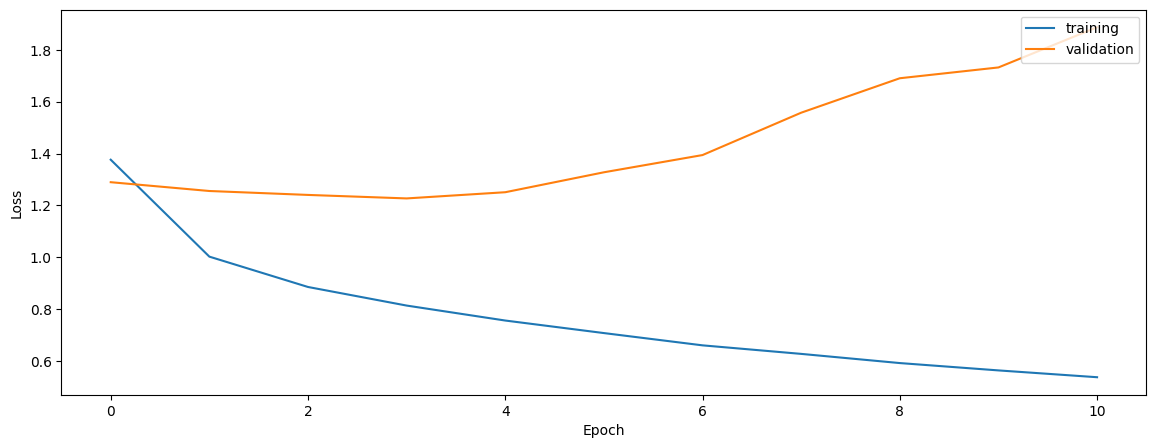

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7066611286496051
0.542128246084089
0.5920413375494475


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6441673312549844
0.5895820164348925
0.5724658199174824


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6426691133230911
0.5900609343263372
0.5828083655325886


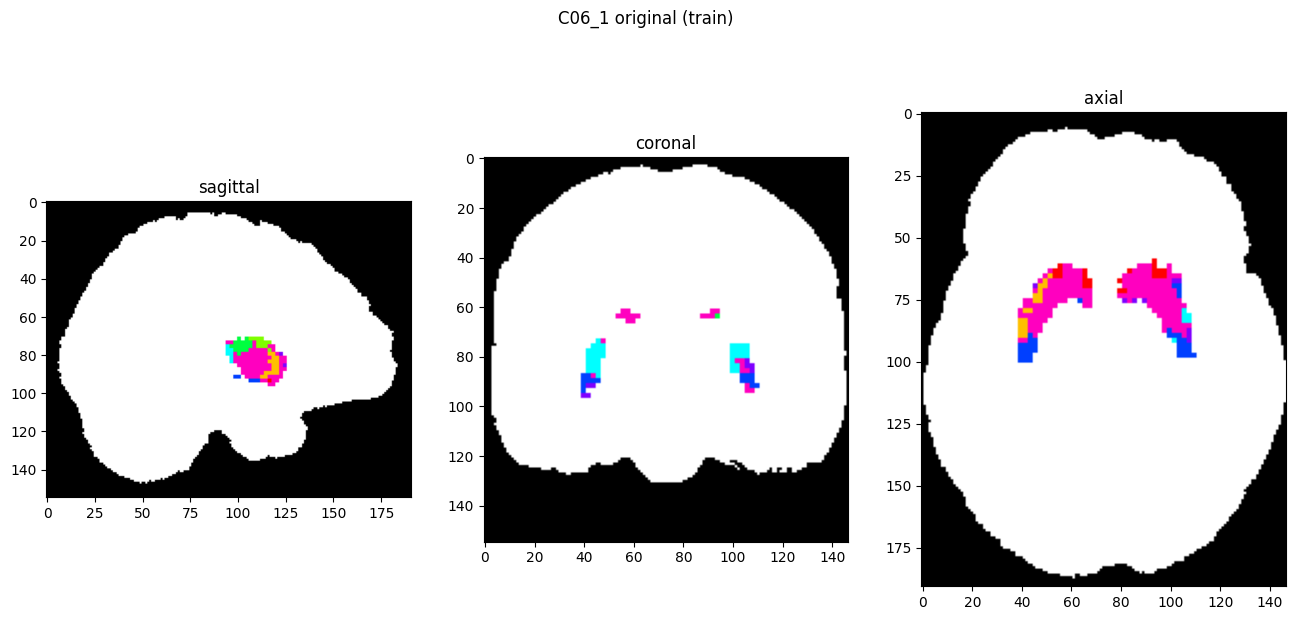

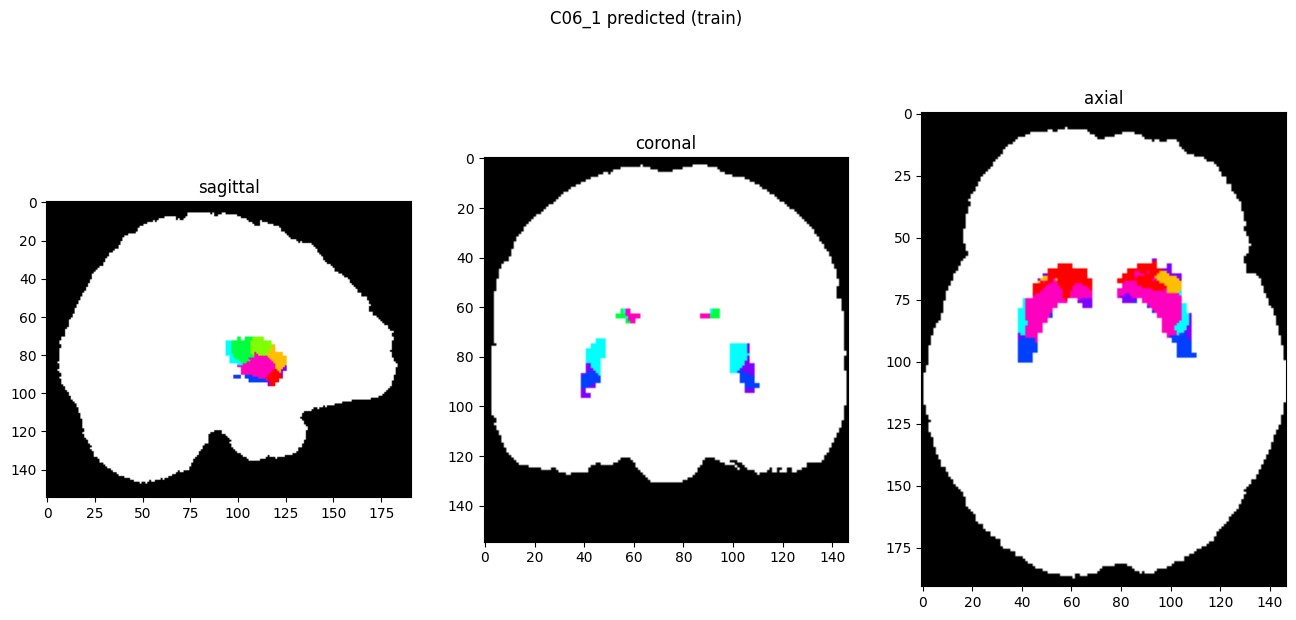

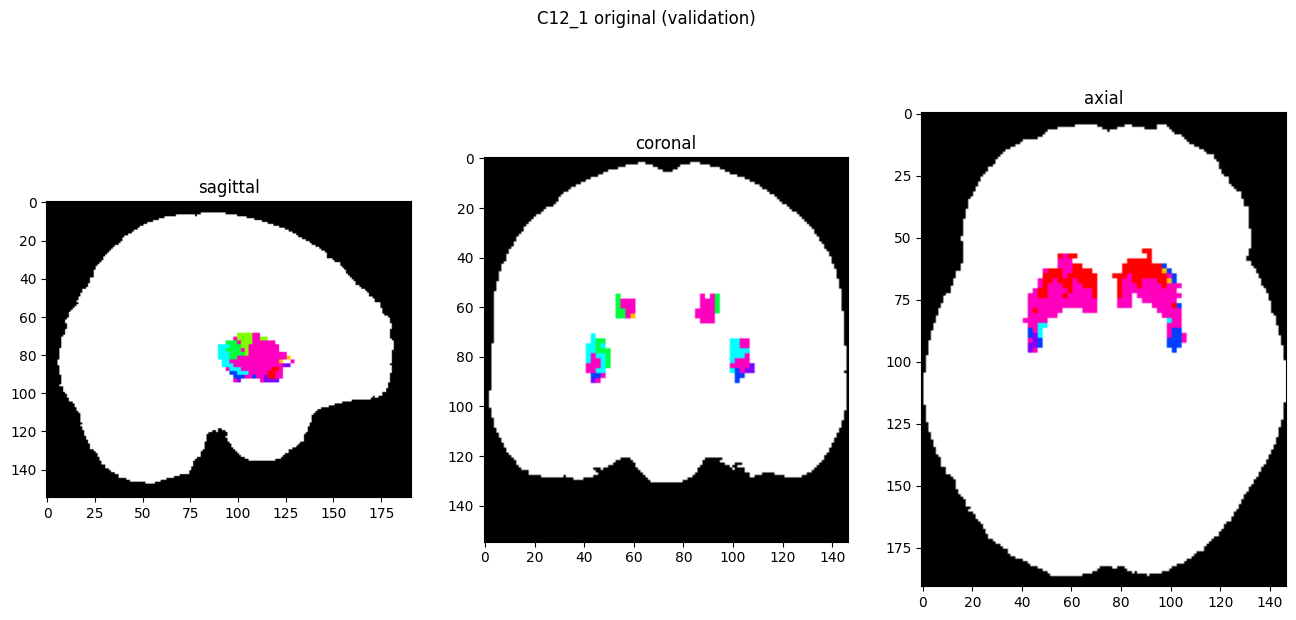

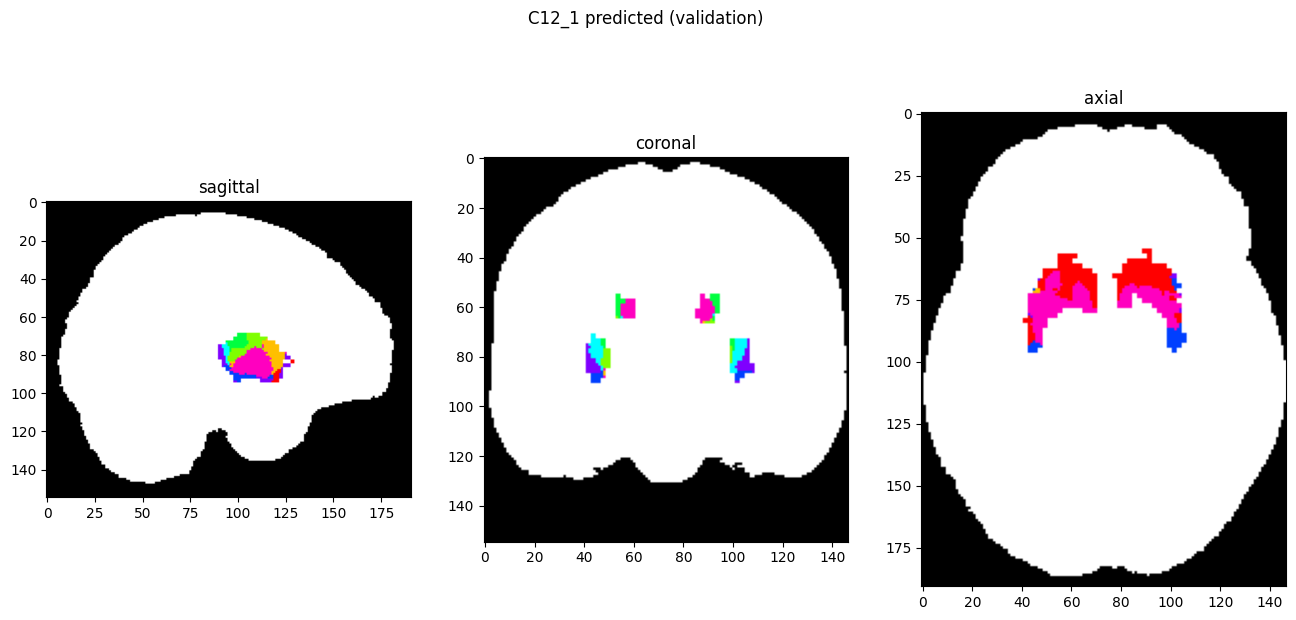

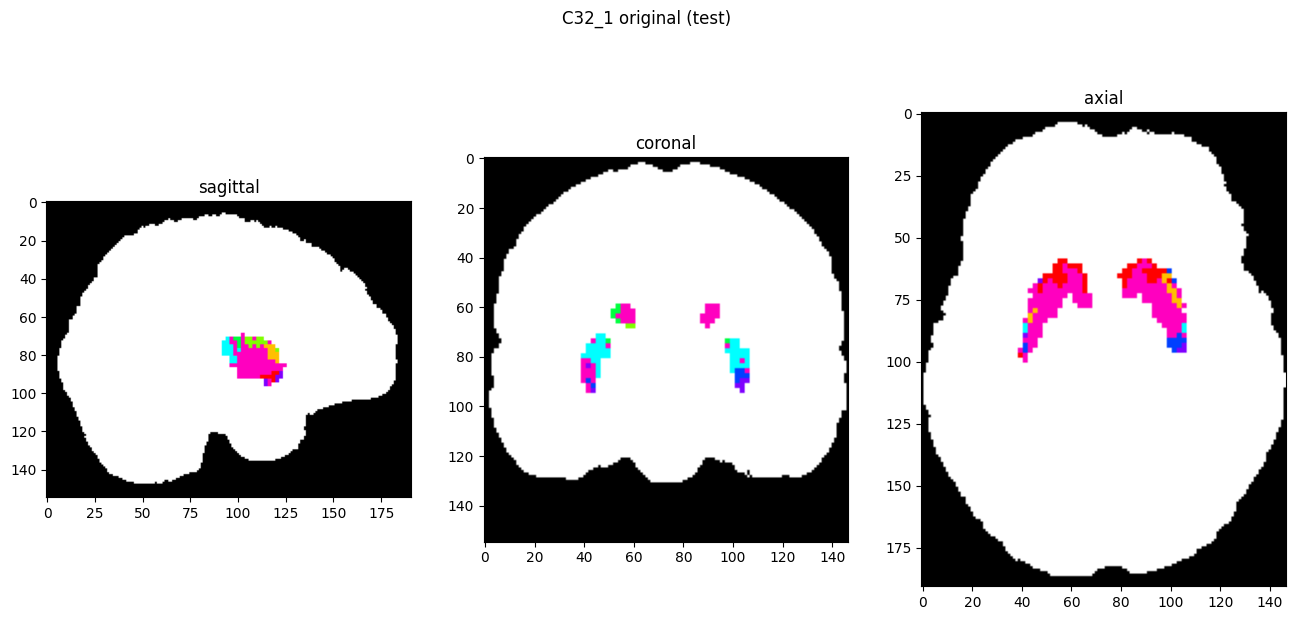

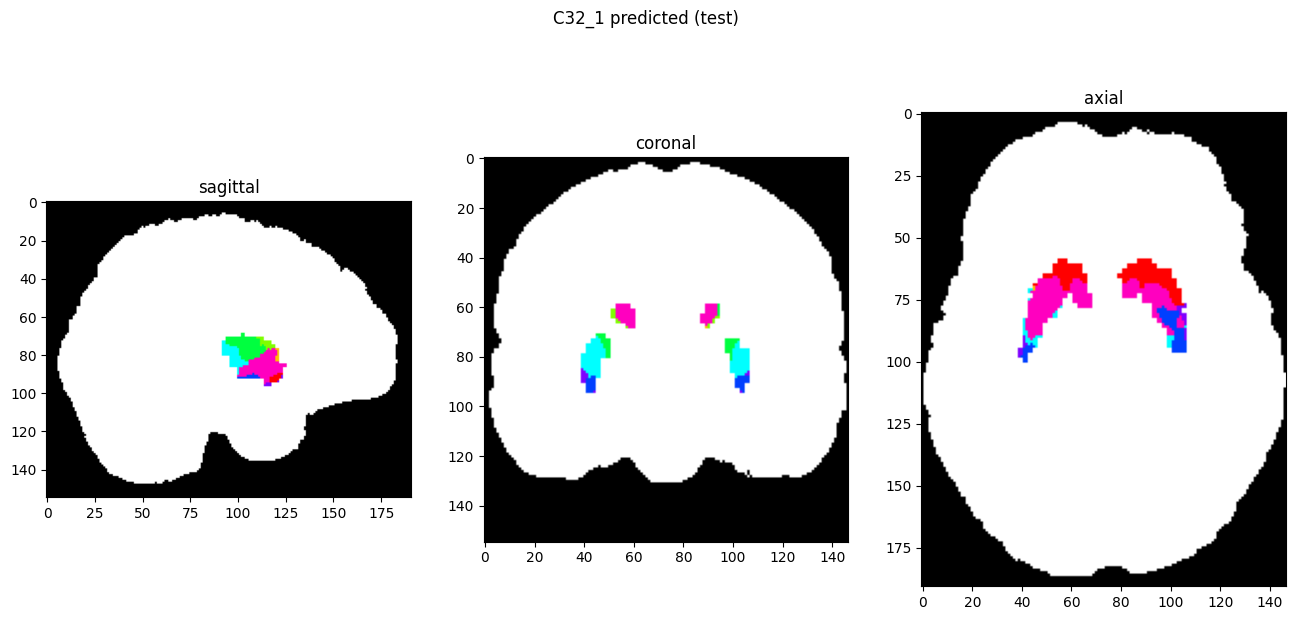

In [10]:
showResults(model, gen, threshold=0)